# Using GAIL TRPO to Play HumanoidBulletEnv-v0

PyTorch version

In [1]:
import sys
import logging
import imp
import itertools
import time

import numpy as np
np.random.seed(0)
import pandas as pd
import scipy.signal as signal
import gym
import pybullet_envs
import matplotlib.pyplot as plt
import torch
torch.manual_seed(0)
import torch.autograd as autograd
import torch.optim as optim
import torch.nn as nn
import torch.distributions as distributions

imp.reload(logging)
logging.basicConfig(level=logging.DEBUG,
        format='%(asctime)s [%(levelname)s] %(message)s',
        stream=sys.stdout, datefmt='%H:%M:%S')

#### Environment

In [2]:
env = gym.make("HumanoidBulletEnv-v0")
env.seed(0)
for key in vars(env):
    logging.info('%s: %s', key, vars(env)[key])
for key in vars(env.spec):
    logging.info('%s: %s', key, vars(env.spec)[key])

00:08:14 [INFO] env: <HumanoidBulletEnv<HumanoidBulletEnv-v0>>
00:08:14 [INFO] action_space: Box(-1.0, 1.0, (17,), float32)
00:08:14 [INFO] observation_space: Box(-inf, inf, (44,), float32)
00:08:14 [INFO] reward_range: (-inf, inf)
00:08:14 [INFO] metadata: {'render.modes': ['human', 'rgb_array'], 'video.frames_per_second': 60}
00:08:14 [INFO] _max_episode_steps: 1000
00:08:14 [INFO] _elapsed_steps: None
00:08:14 [INFO] id: HumanoidBulletEnv-v0
00:08:14 [INFO] entry_point: pybullet_envs.gym_locomotion_envs:HumanoidBulletEnv
00:08:14 [INFO] reward_threshold: None
00:08:14 [INFO] nondeterministic: False
00:08:14 [INFO] max_episode_steps: 1000
00:08:14 [INFO] _kwargs: {}
00:08:14 [INFO] _env_name: HumanoidBulletEnv


#### Agent

In [3]:
class ExpertAgent:
    def reset(self, mode):
        pass

    def step(self, observation, reward, done):
        weights0 = np.array([
                [+0.2289, +0.2584, +0.2595, +0.0173, +0.1293, -0.2980, +0.1410, +0.0982, +0.0216, +0.3724, +0.2204, -0.0734, -0.2420, -0.3443, -0.2738, -0.3825, +0.1504, -0.0930, -0.2680, +0.0685, +0.1592, +0.2534, -0.0787, -0.0426, +0.2591, +0.2134, -0.1631, +0.5168, +0.1444, +0.2736, +0.3623, -0.3472, +0.0393, -0.3056, +0.3850, -0.5231, +0.4511, +0.4223, -0.0905, +0.2265, +0.1662, +0.1092, +0.0426, -0.0209, +0.3260, -0.1788, +0.5045, -0.0254, +0.6684, +0.4659, +0.2193, +0.6121, -0.1771, +0.3024, +0.3233, -0.3380, +0.1834, +0.1947, +0.2840, -0.0212, +0.0610, +0.0254, -0.0687, +0.3342, -0.2010, +0.4851, -0.5739, -0.3228, -0.2242, +0.6149, +0.2704, -0.1006, +0.3950, -0.2684, +0.0090, -0.2419, +0.1112, -0.0795, +0.0021, -0.0317, +0.1345, -0.2847, +0.2323, +0.5374, -0.0119, -0.2098, +0.2074, +0.1693, +0.4537, -0.1453, +0.2661, -0.2997, +0.1043, -0.2340, +0.4472, -0.0415, +0.6437, +0.0279, +0.1609, +0.3353, -0.2240, -0.5433, -0.0053, +0.1863, +0.1038, +0.3337, +0.3889, +0.4159, -0.0836, -0.0826, +0.0872, -0.1362, +0.0061, -0.2982, -0.0074, -0.1452, -0.0655, -0.1369, -0.0493, -0.1082, -0.4080, +0.4732, +0.1229, +0.3087, -0.1222, +0.3846, +0.0719, -0.4536, +0.1202, -0.3903, -0.0445, +0.4052, +0.2922, +0.1095, +0.0317, +0.0974, +0.1149, -0.3794, +0.4364, -0.1597, +0.2889, +0.2431, +0.6867, +0.5117, -0.2517, +0.2835, -0.0365, +0.3303, +0.2569, +0.3636, -0.0945, +0.1853, -0.1341, +0.2595, -0.0174, -0.3227, +0.1999, +0.2348, +0.5826, -0.0480, +0.1449, +0.3866, +0.4740, +0.2486, +0.5011, -0.0334, +0.0953, +0.1072, -0.0901, -0.3235, +0.3258, +0.3003, +0.1229, -0.2257, -0.1920, -0.2025, -0.2022, +0.0843, +0.4563, -0.2654, +0.3158, -0.3102, +0.1105, -0.1171, +0.0465, -0.0692, +0.2824, +0.2598, -0.0289, -0.7774, +0.3501, -0.0635, +0.2257, -0.1644, +0.4091, -0.1967, +0.1614, +0.5468, +0.1365, +0.5054, +0.1986, +0.1368, +0.0886, -0.1305, +0.4297, +0.2482, -0.1914, -0.2909, +0.1784, +0.0690, +0.0224, +0.0378, +0.4991, -0.3410, +0.4281, -0.4574, +0.1952, -0.0444, -0.1939, +0.1637, +0.2385, +0.1354, +0.1817, -0.3849, +0.1909, +0.6585, +0.0997, +0.1376, +0.3598, +0.0611, +0.0124, -0.1492, -0.0659, -0.2671, -0.3925, +0.2333, +0.4184, -0.1364, -0.0361, -0.5937, -0.0327, -0.1142, -0.3334, +0.2963, +0.2350, -0.2600, +0.2784, -0.0720, -0.1594, -0.2652, +0.3922, +0.7291, -0.1830, +0.2253, +0.1965, +0.1972],
                [+0.2244, +0.6008, -0.2907, -0.1769, -0.1935, +0.0902, +0.3499, +0.0213, +0.1343, -0.4925, -0.0996, -0.2332, -0.0739, -0.3686, -0.8946, +0.0956, +0.0229, -0.1700, -0.1541, -0.1738, -0.2712, +0.2399, -0.9785, +0.0332, -0.1472, +0.2317, -0.2498, -0.5549, +0.2247, +0.1835, +0.3699, +0.4326, +1.0277, +0.5037, +0.1917, -0.0519, +0.6952, +0.0699, +0.5892, -0.2437, +0.4122, +0.8816, +0.1263, -0.2072, +0.7932, +0.1292, -0.0770, +0.0025, +0.5216, -0.0476, +0.1862, +0.5225, -0.1914, +0.2424, +0.9420, +0.3432, +0.0285, +0.1507, +0.1983, -0.3111, -0.2958, -0.3750, -0.3894, +0.4764, -0.0933, -0.1671, -0.3327, -0.1734, +0.3197, -0.2884, +0.0234, -0.3527, -0.4019, +0.4847, +0.8950, +0.1055, +0.1383, +0.2209, -0.0691, +0.6060, +0.3265, -0.0979, -0.2110, +0.6802, -0.4336, -0.6381, -0.1507, +0.4082, -0.1635, -0.0835, -0.0082, +0.5745, -0.2450, +0.7778, -0.2730, -0.6112, -0.0839, -0.0785, -0.6745, -0.1420, +0.4217, +0.3215, -0.2859, +0.3225, +0.0936, +0.0283, -0.1876, +0.4980, -0.4691, -0.0344, +0.1162, +0.1886, -0.1320, +0.4492, +0.0019, -0.0631, +0.2038, -0.3549, +0.2250, -0.2285, -0.0618, -0.0311, +0.7220, +0.0530, -0.3637, +0.2023, -0.3015, +0.1247, +0.2858, -0.2926, +0.2305, +0.2896, +0.1855, -0.3343, -0.1031, -0.3579, -0.6165, -0.3269, +0.0746, +0.2497, -0.3880, -0.5785, -0.7582, -0.1729, -0.3449, -0.1357, -0.5979, -0.7973, +0.1202, +0.6009, -0.0103, -0.0233, -0.0987, +0.4404, +0.4355, -0.0934, -0.0910, -0.0382, -0.0268, +0.0425, +0.0329, +0.7613, +0.1151, +0.1962, +0.3848, +0.6449, +0.0600, +0.8192, +0.2580, +0.4444, -0.5772, -0.1268, -0.0429, +0.0785, +0.1237, +0.5161, -0.3665, +0.0825, +0.1226, +0.4157, +0.4844, -0.5870, -0.6568, +0.1661, +0.0846, +0.9718, +0.8856, +0.4171, -0.4568, -0.0714, +0.0394, -0.1495, +0.1462, -0.1572, +1.3937, +0.1682, +0.4968, -0.3699, +0.0710, +0.2328, +0.4747, -0.4286, +0.4434, -0.0531, +0.8446, +0.0101, -0.4317, -0.2297, +0.4299, -0.1323, +0.4804, -0.2152, +0.0161, +0.0560, -0.3013, +0.2911, +0.3542, +0.3124, +0.3897, +0.1082, +0.2437, +0.0183, +0.2230, +0.0093, +0.1507, -0.3895, -0.2750, +0.0991, +0.1170, -0.5877, +0.4045, +1.0306, -0.1141, -0.0084, +0.3079, +0.4545, +0.0084, +0.1517, -0.0344, +0.4704, -0.2666, -0.0728, -0.0447, +0.4098, -0.4524, -0.4638, -0.4063, -0.2521, -0.2830, +0.1845, -0.3146, +0.4381, -0.0215, +0.2613, -0.1182, +0.4527],
                [+0.1845, -0.1290, +0.0236, -0.1312, +0.0155, -0.6011, -0.0454, +0.0183, -0.0613, -0.1651, +0.0204, -0.2374, +0.1045, -0.2035, -0.2268, +0.2069, +0.0483, -0.3226, -0.2196, +0.0847, +0.1314, +0.0426, -0.4253, -0.0748, -0.1497, -0.1902, +0.3815, +0.1306, +0.0276, -0.2593, -0.0081, +0.1098, -0.0062, -0.1922, -0.0409, -0.2615, +0.1296, +0.0267, -0.1602, -0.4755, +0.0039, +0.2688, -0.0225, -0.1433, -0.0383, -0.0131, +0.0675, +0.1684, +0.1298, +0.3818, -0.0260, +0.1636, -0.2338, +0.0062, +0.1756, -0.1825, +0.1473, -0.2689, -0.1376, -0.0224, +0.2016, -0.2086, +0.0723, +0.2100, -0.3345, +0.1170, -0.4292, -0.1302, -0.1132, +0.0030, -0.3599, -0.1974, -0.4807, +0.0184, -0.0768, -0.0310, -0.2677, -0.0838, -0.0072, -0.1049, -0.2841, -0.2426, +0.2338, +0.0917, -0.1451, -0.3906, -0.0315, +0.1058, -0.0429, +0.1218, +0.0590, +0.0446, -0.0043, -0.0168, -0.0899, -0.3793, -0.3134, +0.0907, -0.5332, -0.0995, -0.0256, -0.2710, -0.0487, -0.0059, +0.0274, -0.1885, +0.3208, +0.0437, -0.0411, -0.3716, -0.5700, +0.0576, +0.0903, -0.1064, -0.1600, +0.1009, -0.1957, -0.0539, -0.2426, -0.5847, -0.2240, +0.0023, -0.2533, -0.2903, -0.0328, +0.1289, +0.0927, -0.2596, +0.2300, -0.4833, -0.1772, +0.3817, -0.1000, -0.2391, -0.2917, -0.3748, +0.0640, +0.0005, +0.1664, +0.0173, +0.2214, -0.2440, +0.0039, +0.2924, +0.3009, +0.0540, -0.3460, +0.1538, +0.3727, -0.0801, +0.0130, -0.0963, -0.0172, +0.0524, -0.1681, +0.1478, -0.1827, +0.2902, +0.2376, +0.0703, -0.3115, -0.0634, +0.0512, +0.1366, +0.0646, -0.0811, -0.1668, +0.1052, -0.1976, -0.1411, -0.1401, +0.0263, -0.0454, -0.0315, -0.1376, +0.0403, +0.1526, -0.0385, +0.0782, -0.1382, +0.0399, -0.1812, -0.3915, -0.1615, -0.0648, -0.3724, +0.1436, -0.1380, -0.4987, -0.1783, +0.2295, -0.4115, -0.2025, -0.3245, -0.3584, -0.1729, -0.0822, -0.0460, -0.1321, -0.3484, -0.4094, -0.1418, +0.0986, -0.2276, -0.0267, -0.1027, -0.1794, -0.1338, -0.2575, -0.2837, -0.0241, -0.2849, -0.2569, -0.0871, -0.0534, +0.1427, +0.1857, -0.1384, -0.3600, -0.1343, -0.0075, +0.1601, +0.1113, -0.1131, -0.1716, -0.2434, +0.1357, -0.1294, -0.2366, -0.0562, -0.1674, -0.0974, -0.1556, -0.5273, -0.1928, -0.0431, +0.1909, +0.0233, +0.2048, -0.2176, -0.1908, +0.0150, +0.1610, +0.0468, -0.1319, +0.0579, +0.4051, -0.2020, +0.0208, -0.5383, +0.1756, +0.0117, -0.2675, -0.1795, -0.1730, -0.1394],
                [-0.5736, -0.8805, -0.0769, -0.0851, -0.5427, +0.1977, +0.0607, -0.3635, +0.5918, +0.1243, -0.0683, -0.5963, +0.2201, -0.1754, -0.1193, +0.2689, +0.2383, -0.1014, +0.2498, +0.0947, -0.3494, -0.0848, -0.3292, +0.0194, -0.1043, +0.4501, +0.5483, -0.0839, +0.2682, +0.5032, -0.0208, -0.0950, +0.2171, +0.2045, -0.3694, +0.3404, -0.0883, +0.2092, -0.2164, -0.1036, +0.2583, -0.0949, +0.0715, -0.3988, +0.0751, -0.1982, +0.5441, +0.0172, +0.3297, -0.6622, -0.1357, -0.5829, -0.2161, -0.6473, -0.0565, +0.6117, -0.0156, +0.6255, -0.1497, -0.1722, +0.1335, +0.6251, +0.3700, -0.5719, -0.2368, -0.0315, +0.0146, -0.8732, -0.2498, -0.1137, +0.2604, -0.1385, -0.8775, -0.5170, -0.2435, -0.3753, +0.2906, +0.0193, -0.5174, -0.3639, -0.2548, -0.5402, -0.8794, -0.5529, -0.0559, -0.1246, -0.0725, -0.0145, -0.7285, -0.0017, -0.1507, +0.3688, -0.1245, -0.3651, +0.3866, -0.1138, -0.0853, +0.0368, -0.4360, -0.1958, -0.1419, +0.1774, +0.0723, -0.3591, -0.4659, +0.3450, +0.3742, -0.1436, +0.0044, +0.2917, -0.5689, -0.5904, +0.1288, -0.4701, -0.2539, -0.6716, +0.2295, -0.4429, -0.0556, -0.0518, +0.2292, -1.7909, +0.1799, -0.1646, +0.3310, +0.0519, -0.1858, +0.0612, +0.0647, +0.1269, +0.1987, -0.0585, -0.2811, -0.8582, -0.6569, -0.3871, +0.1939, +0.1120, -0.0105, -0.3577, -0.0086, -0.2489, +0.4663, -0.1103, +0.0332, -0.6252, -0.2411, -0.0892, -0.4744, +0.1257, +0.1445, +0.1788, +0.0429, -0.2699, +0.4812, +0.4112, +0.2460, -0.0158, -0.6195, -0.7866, +0.7380, -0.1607, -0.9005, -0.3402, +0.1250, +0.0292, -0.5294, +0.2517, -0.1519, +0.6130, -0.3528, -0.4301, -0.2510, +0.5858, +0.0060, +0.0751, +0.0733, +0.2363, -0.6337, -0.0453, -0.3818, -0.0374, -0.0048, -0.4378, -0.0780, -0.1101, +0.1504, +0.4377, -0.3238, +0.2260, -0.4677, +0.1361, -0.0218, +0.2108, -0.0987, +0.3155, +0.6500, +0.2126, -0.2016, +0.3768, +0.6421, +0.2673, +0.1952, +0.0513, -0.0657, +0.2197, +0.2465, +0.2605, +0.3151, +0.0719, -0.6572, +0.4819, +0.2985, -0.1793, -0.1759, -0.3330, -0.5562, +0.1846, -0.1096, -0.5457, -0.6485, -0.4409, -0.4658, -0.0819, +0.1681, -0.3892, +0.4901, -0.3008, -0.7256, +0.1596, +0.0896, -0.3508, +0.4520, -0.5112, -0.3458, -0.6592, -0.9615, +0.1979, +0.2483, +0.1385, -0.0924, -0.2448, +0.4041, +0.5250, +0.1655, -0.5895, -0.4537, +0.3295, -0.4612, -0.1340, -0.5730, -0.2680, +0.4814, +0.0250, -1.0258, +0.1863],
                [-1.0573, +0.3035, -1.0110, +0.1281, -0.5940, -0.0072, +0.4667, +0.7137, +0.0810, -0.8921, -0.1219, -1.0541, -0.7295, +0.7648, +0.1772, -0.1785, -1.0871, -0.1349, +0.3227, +0.6328, -0.8310, +0.8725, -0.4619, -0.3077, +0.8552, -0.3231, -0.1156, -0.5372, -0.4023, +0.8194, -0.8025, -0.5804, +0.5964, -0.0932, +0.5116, -0.2766, +0.1760, -0.1303, +0.6465, -0.0711, -0.1220, -0.5499, +0.1202, +0.1071, +0.2686, -0.1856, -0.2504, +0.0925, -0.4784, +0.9105, -1.1430, -0.5899, -0.1242, +0.5508, +0.7145, +0.2748, -0.3478, -0.7003, +0.4850, +0.1385, +0.3943, +0.2670, -0.4550, +0.0036, -0.5703, -0.8350, -1.1953, -0.0970, +0.3308, +0.7714, +0.1061, +2.0960, +0.0376, -0.7406, +0.0789, +1.5258, +0.9057, +0.4235, -0.5466, +0.1064, +0.2408, +0.7252, -0.2936, +0.4144, -0.3486, -0.7981, +0.0240, -0.1555, +0.9355, -0.4706, -0.7375, +0.9309, +0.7671, -0.0113, -0.2764, -0.0366, +0.2126, +0.6469, -0.4462, -0.2112, +0.6839, +0.4796, -0.1490, +0.8926, -0.2453, +0.0598, -0.0021, +0.3849, +0.4954, -0.1375, -0.1142, +0.8535, +0.8888, -0.3101, +0.7679, -0.5564, -0.2071, -0.3134, -0.0526, -0.1788, +0.3544, +0.6677, +0.3217, -0.6103, -0.0902, +0.3894, +0.8153, -0.5409, -0.0261, +0.7648, +0.3098, +0.5138, -0.1609, +0.3192, +0.4370, -0.1330, -0.0368, +0.8144, -0.1377, +0.9899, +0.2202, +0.5290, +0.4051, +0.0875, +0.4018, -0.0897, +0.4689, +0.1784, +1.2015, -0.2091, +0.3738, +0.7411, -0.1037, -0.2531, +0.3753, +0.1518, -0.1351, +0.3109, +0.2514, +0.2564, -0.2295, +0.5837, +0.1827, -0.1766, +0.1354, -0.0895, +0.8237, +0.4432, -0.3878, -0.0831, +0.7593, -0.9360, -0.4304, +0.0854, -0.9559, +0.1652, +0.2593, +0.3457, -0.5038, -0.1274, +0.4108, -0.0822, -0.1254, +0.4618, -0.0763, -0.4831, -0.4356, +0.5051, -0.4981, +0.2556, -0.1951, +0.5189, +0.0342, +0.2521, +0.1616, -0.0889, -0.0898, +0.3080, +0.2350, -0.2451, +0.2174, +0.3621, +0.7812, +0.8774, +0.7318, +0.1353, +0.0450, -0.8271, +0.5002, -0.7626, +1.3003, +0.4312, -0.6138, -0.1886, -0.2482, -0.5597, -0.0913, +0.0901, -0.3340, +0.4610, -0.7099, +0.3496, +0.3531, +0.2044, -0.1057, +0.8731, -0.6409, +0.5075, +1.0426, -0.7513, -0.3445, +0.1368, -0.0996, +0.4420, +0.2574, +0.2526, +0.2479, +1.3376, -0.0922, +0.2117, -0.1829, -0.0796, +1.4092, -0.2412, +0.0230, +0.3997, -0.3151, +0.0822, -0.7801, -0.5236, +0.0178, -0.9243, -0.5063, +0.5279, -0.2153, +0.6347],
                [+1.4703, +1.2982, -0.0402, -0.2425, +0.2475, -0.0634, +0.4494, -0.7865, -1.3634, -0.1417, -0.2296, -0.4785, -0.1649, -0.8603, +0.2584, +0.1614, -0.3570, -0.9330, +0.6203, -0.0622, +0.7080, +0.0465, +0.0007, -0.3840, -0.0692, +0.8238, -0.9584, +0.8456, -0.8160, +0.4813, +0.3511, -0.0667, +0.7182, -0.5514, +0.3622, -2.3828, +0.6020, +0.0268, +0.3220, -0.4798, -0.1588, -0.6060, +0.0455, -0.1433, -0.5643, -0.4139, +1.0605, -0.3742, +2.4072, +1.2664, +0.1790, +0.8069, -0.1647, +0.2396, +0.6662, -1.2914, -0.2594, +0.4644, +0.3116, -0.1614, -0.7359, -0.9930, -0.4012, +0.1121, -1.4436, -0.0692, -0.3936, -0.4506, -0.8123, +1.3841, +1.2088, +0.9410, +0.1766, -0.7999, +0.2004, +0.2158, -0.4015, -0.0484, -0.3474, +0.0076, -0.7156, -0.5177, +0.8020, -0.1543, +0.0434, -0.2892, +0.1293, +0.5121, +1.2537, -0.1804, +0.2232, -0.3681, -0.4471, -0.5221, +0.0472, -0.4809, +0.5478, -0.3337, +0.0365, -0.6143, +0.7588, -0.4842, +0.1022, +0.4930, +0.5103, +0.7343, +1.5783, +0.8545, -0.9636, -0.3476, +0.5063, +0.0514, +0.3894, -0.8884, +0.0449, +0.5949, -0.2352, +0.4529, +0.2948, +0.0390, -0.7291, +0.1560, +0.0583, -0.0293, +0.0597, +0.1500, +0.7947, -1.3192, -0.1611, -1.8176, +0.9184, -0.4718, +0.7685, -0.1878, -0.3281, -0.4007, -1.2232, -1.0534, +0.7252, -0.6923, +0.3817, +0.7918, +0.4028, +0.9145, -0.0126, +0.1591, -0.2679, +1.3580, +0.0393, +0.1672, -0.4754, +1.0527, -1.0403, +0.6002, +0.1479, +0.5369, -0.1762, +0.2856, +0.3766, +0.0768, -0.3013, +1.0575, +0.6036, +0.1491, +0.6333, -0.2535, +0.1049, +1.1164, -0.3730, -1.5166, +0.5125, +0.1594, +1.6473, -0.6655, +0.4091, +0.3638, -0.5117, -0.2984, +0.3496, -0.3595, -0.3811, -0.7337, -0.0616, +0.0449, -0.2416, -0.0535, -1.3687, +0.3001, +0.0840, -1.5971, +0.7260, -0.0056, +0.3636, -0.3623, +0.2754, -0.6047, -1.2724, +0.5213, -0.0817, +1.6422, -0.2038, +0.5006, +0.7695, +0.9680, +0.4044, +0.9807, -0.1294, -0.6531, -0.7634, +0.1569, +1.2350, +1.2254, +0.7556, -0.2483, +0.0008, +0.2024, +1.1261, +0.0476, -0.1030, +0.8195, -0.2271, +0.2323, +0.3329, -0.5824, -0.1342, +1.5237, +1.2337, -0.8420, -0.3239, -0.1192, -0.3712, -0.4645, -1.4312, -0.8121, -1.2723, -0.3935, -0.0198, -0.0735, +0.7791, -1.3631, -0.8079, +0.0497, -1.1443, +0.1149, -1.0024, -0.7783, +0.5146, -0.0900, +0.2533, -0.3197, +0.8769, +0.6185, -0.4478, -0.2109, +0.9331, +0.1720],
                [+0.1914, +0.2367, -0.1629, -0.2121, -0.4821, +0.2042, -0.6208, -0.6690, -0.5308, +0.2751, +0.0058, +0.7246, +0.5435, -0.0560, -0.5556, -0.0165, +0.6507, +0.2775, +0.0431, -0.1270, +0.5966, +0.0977, +0.2673, -0.3136, -0.6983, +0.5473, -0.4528, -0.0306, +0.1088, -0.0717, +0.8475, +1.1961, +0.2308, -0.5281, -0.0913, +0.1937, +0.9934, -0.0981, -0.0031, +0.0337, +0.2783, -0.9124, +0.4286, -0.3317, +0.1689, +0.1181, +0.3386, +0.0006, -0.3645, -0.7711, -0.0095, +0.3991, -0.1333, -0.6688, +0.4254, +0.0559, +0.2671, +0.5579, -0.9046, -0.2728, -0.4878, -0.5582, +0.2866, -0.2315, +0.2442, +0.7093, +0.4266, +0.2287, +0.1558, -0.3636, +0.5561, -1.4425, -0.1192, +0.6250, -0.3334, -0.3746, -0.1556, -0.0636, +0.1641, +0.2846, +0.2501, -0.3944, -0.4040, -0.1150, -0.6399, +0.1609, +0.5772, +0.5262, -0.0361, +0.7536, +0.2497, -0.7278, +0.1851, -0.0259, -0.7170, -0.3231, -0.2127, -0.1993, -0.2452, +0.3888, +0.2922, -0.4279, -0.3269, +0.0756, +0.1988, -0.1777, -0.0172, -0.0312, -0.1341, +0.0269, +0.1057, -0.1237, -0.6615, +0.2952, +0.0767, -0.0778, -0.5447, +0.0285, +0.6785, -0.1794, +0.0174, -0.1047, -0.1765, +0.5859, -0.0837, -0.5167, -0.4280, +0.1787, +0.1762, -0.3390, +0.6731, +0.3160, +1.4737, -0.6632, +0.2942, -0.0664, -0.2121, -0.3356, -0.5989, +0.4079, -0.2348, +0.1857, -0.9283, +0.1377, -0.0273, +0.2580, +0.9982, -0.2876, -0.4685, +0.2032, +0.2644, -0.0163, -0.6819, -0.9446, -1.0937, +0.3750, -0.1436, -0.7771, +0.1031, -0.7357, -0.2943, +0.1850, -0.7978, -0.0747, +0.1661, +1.1391, -0.7675, -0.0677, +0.3038, +0.0354, -0.4304, +0.3333, +0.1617, +0.3656, +1.2621, -0.3526, +0.0040, +0.2239, +0.4336, -0.3180, +0.1273, +0.0488, -0.3459, -0.8226, +0.1833, +0.2386, -0.0214, +0.4261, -0.1491, +0.0678, -0.3771, -0.3311, +0.1703, +0.2722, +0.1684, +0.0372, -0.3637, -0.0246, -0.1785, +0.1548, -0.7042, -0.2042, -0.3849, +0.1776, -0.0536, -0.1493, -0.6161, +0.1739, -0.1201, +0.2798, +0.4395, -0.3635, +0.2738, +0.3116, -0.3052, +0.5248, +0.4516, -0.4132, -0.0536, -0.2435, +0.3823, +0.0218, +0.8631, -0.2524, +0.4060, -0.9034, +0.8162, -0.0182, -0.6250, +1.1502, +0.3362, +0.2115, -0.3169, -0.6787, -0.3379, +0.1962, -0.0973, -0.4042, -0.7209, +0.4764, -0.3201, -0.6573, -0.3488, -0.4370, -0.4269, +0.1515, +0.6850, -0.0542, +0.4701, +0.4224, -0.1287, +0.2937, +0.3044, +0.0041, +0.2738, -0.7350],
                [-0.5305, -1.0649, -0.0954, -0.2799, -0.3787, +0.9727, -0.0627, -0.2684, +0.5308, -0.2507, -0.2276, -0.2753, +0.7152, -0.1676, -0.6453, +0.2848, -0.5792, -0.4101, +0.4678, +0.5229, -0.5333, +0.2654, -0.1755, -0.2015, -0.1202, +0.7424, -0.0436, -0.7146, -0.3689, +0.3063, -0.0962, -0.5648, +0.3302, +0.8726, +0.4133, +0.3269, -0.3124, -0.3711, +0.0620, +0.1089, +0.7904, -0.6871, +0.1509, -0.6424, +0.6935, +0.1535, -0.2352, +0.2431, +0.2551, -0.9536, -0.6756, -0.5438, +0.5175, +0.0297, +0.3081, +0.7367, -0.5743, +0.5190, -0.6644, -0.2655, -0.8614, +0.5008, +0.1180, -0.6145, +0.0548, -0.0824, +0.1499, -0.4286, -0.2922, +0.1617, +0.4914, -0.1181, -0.0810, -0.5932, -0.1382, +0.2021, -0.2492, +0.4315, -0.3313, -0.7047, -0.1362, -0.6261, -0.8227, -0.2876, -0.3360, -0.0240, +0.4826, -0.3108, -1.4351, -0.0640, -0.0199, +0.5721, +0.2496, -0.3540, -0.6179, -0.1694, +0.3353, -0.1535, -0.2695, +0.0006, -0.0797, +0.6059, -0.0136, -0.1401, -0.1369, +0.5776, -0.3561, -0.7428, +0.1167, -0.2765, +0.2429, -0.5045, +0.2792, -0.3781, +0.1033, -0.2574, -0.1043, -0.2264, +0.4170, +0.4963, +0.1617, -1.0455, +0.0243, +0.7325, +0.1549, +0.2681, -0.0576, +0.7945, -0.1418, +0.9368, -0.4814, -0.5513, -0.3667, -0.9507, -0.5204, +0.1824, -0.0299, -0.3973, -0.1318, +0.1508, +0.6482, -0.3319, +0.3144, -0.0892, -0.4015, -0.1038, -0.0171, -0.1544, +0.0384, +0.0638, +0.1878, +0.4846, +0.3388, -0.2064, +0.0282, +0.0187, -0.2866, +0.2655, +0.1010, -0.3126, +0.2875, -0.2012, -0.5520, -0.7519, -0.0311, -0.4679, -0.2289, -0.1862, -0.6687, -0.0894, -0.4530, -0.4726, +0.2286, +0.4884, +0.2238, -0.4041, +0.4382, +0.0763, +0.2040, +0.1290, -0.1270, -0.3557, -0.3726, +0.2727, +0.1078, -0.3465, -0.1650, +0.1213, +0.1463, +0.4907, -0.6272, +0.2849, -0.1256, -0.0692, -0.1280, +0.6426, +0.8455, -0.2999, +0.2388, +0.3314, +0.0211, +0.1282, +0.7080, +0.2266, -0.4417, -0.5596, +0.0456, +0.0472, -0.0761, +0.3607, +0.0925, +0.5921, +0.5351, -0.1387, -0.0664, +0.0244, +0.0458, -0.1461, +0.4734, -0.3399, +0.1727, -0.3891, -0.2727, +0.1968, +0.3090, -0.2189, +0.0718, -0.4483, -0.5429, -0.1845, -0.6284, +0.1738, +0.0977, +0.1842, +0.1739, -0.5167, -1.2017, +0.1491, +0.6558, +0.4300, +0.8097, +0.0739, -0.3018, -0.1147, +0.2953, +0.2045, -0.2690, -0.2379, -0.3909, -0.1637, -1.1258, -0.3999, +0.3399, +0.0625, -1.1293, +0.3265],
                [+0.2985, -0.6516, +0.4775, -0.0140, -0.4299, -0.1279, -0.3789, -0.8213, -0.0525, +0.0010, +0.0503, -0.2211, +0.0995, +0.1976, -0.4291, +0.0379, +0.2930, +0.3705, -0.2469, -0.0770, +0.4237, +0.4334, +0.2506, -0.2329, -0.4291, +0.1146, +0.0874, +0.3548, +0.0268, +0.0869, +0.3078, +0.0402, -0.4679, +0.8574, -0.3867, +0.0835, +0.6660, -0.4280, -0.6492, -0.1042, -0.6310, -0.0259, -0.0944, +0.1484, +0.0317, -0.0098, -0.0450, +0.5161, +0.0257, +0.0005, -0.0494, +0.0465, -0.2364, +0.1916, +0.5391, +0.0028, +0.9037, -0.0930, +0.2142, +0.1406, -0.1165, -0.0293, +0.3984, -0.4787, -0.0384, +0.1164, +0.1826, -0.3080, +0.0997, +0.6248, -0.1437, -0.1716, -0.3102, -0.0448, -0.3595, +0.9930, -0.2071, +0.9864, +0.3101, +0.1298, -0.1277, -0.2569, -0.3749, -0.5782, -0.2509, +0.3860, +0.4451, +0.1810, -0.1763, +0.1142, -0.1178, +0.6319, +0.5940, +0.3328, -0.0479, -0.4712, -0.1765, -0.1778, -0.2369, +0.2725, -0.2929, -0.2874, -0.1177, +1.2907, +0.3847, -0.2287, +0.2036, +0.0735, +0.3001, -0.2437, +0.2036, -0.3419, +0.4514, +0.2280, -0.2737, +0.3508, -0.1208, -0.4684, +0.0684, +0.0490, +0.3631, -0.3185, +0.0020, -0.1861, -0.0268, -0.1274, -0.0160, -0.1210, +0.1408, +0.4183, -0.3518, -0.4569, +0.1282, -0.2319, +0.2512, -0.3592, +0.0540, -0.6120, -0.1856, -0.0308, +0.1304, -0.3050, +0.4704, +0.3629, +0.4371, -0.0915, -0.2140, -0.1166, +0.2194, +0.2926, -0.3646, -0.5791, +0.3207, -0.0810, +0.1578, -0.3067, -0.3441, +0.4426, +0.1421, -0.4309, +0.1017, -0.1754, +0.3775, +0.0048, -0.1489, +0.2823, +0.4104, +0.5312, -0.4843, -0.3423, -0.7578, -0.0118, +0.0645, +0.2197, +0.3624, -0.0137, +0.5216, -0.4339, +0.1736, +0.3054, +0.5684, +0.4813, +0.2408, +0.0112, -0.0637, -0.1112, +0.4575, -0.4203, -0.2375, -0.1869, -0.1914, +0.5073, -0.2876, +0.2371, +0.3740, +0.8589, +0.1326, +0.0220, -0.0639, +0.1505, -0.3579, -0.1986, +0.6998, +0.1042, -0.2976, -0.0343, -0.2863, -0.0873, -0.3928, -0.3351, +0.0212, +0.3023, -0.1197, +0.1894, +0.1328, -0.0621, +0.5685, +0.1133, +0.0837, -0.2829, -0.4764, +0.0455, +0.7453, +0.1416, +0.3608, +0.1513, +0.8440, +0.1792, +0.6390, +0.0493, +0.4155, -0.2832, -0.0157, +0.0372, +0.0957, +0.8445, -0.2723, +0.3604, -0.4921, +0.8836, +0.2896, -0.0577, -0.4621, +0.1412, +0.1202, -0.1868, -0.0938, +0.0032, +0.4614, -0.0066, +0.1586, +0.0146, +0.0698, +0.1539, -0.3187, +0.2030],
                [+0.1593, +0.0673, -0.2547, -0.4164, -0.7417, -0.0947, -0.0055, -0.3648, +0.1302, +0.0556, +0.3797, -0.0956, -0.3993, +0.4257, +0.0176, +0.1360, +0.1971, +0.2499, -0.1564, -0.1776, -0.3742, +0.1572, +0.1570, -0.1127, -0.4366, -0.0255, -0.0662, -0.2298, +0.5912, +0.0107, -0.5855, +0.8709, +0.0119, -0.4277, +0.4122, -0.0525, +0.1397, -0.3018, +0.6338, -0.1003, -0.1246, +0.1427, -0.1638, -0.2808, +0.1959, +0.7202, +0.1200, -0.2316, +0.1650, +0.2782, +0.4346, +0.0802, -0.2768, +0.4015, +0.4213, -0.2252, +0.2750, -0.4314, +0.0254, +0.3742, -0.3016, -0.2429, -0.6429, +0.3386, -0.0971, +0.1080, -0.2511, +0.2752, +0.6792, +0.0080, +0.2215, +0.0504, -0.7341, -0.1637, +0.0300, +0.3588, -0.3274, +0.1918, +0.3612, +0.5223, +0.1182, +0.6870, -0.3318, -0.2261, +0.2921, -0.4550, +0.1582, +0.2888, -0.2669, +0.1638, -0.6216, +0.6262, -0.6351, +0.4334, +0.0973, -0.1839, +0.0321, -0.5037, -0.2649, -0.0552, -0.1270, -0.2993, +0.6138, +0.4850, +0.3384, -0.5962, -0.6860, +0.0256, -0.2307, -0.2724, -0.1256, +0.6033, +0.2383, -0.0195, -0.0630, -0.4518, -0.3697, +0.8157, -0.5800, +0.7963, -0.3184, +0.0568, -0.3475, -1.0642, +0.7602, +0.5601, -0.0858, +0.3643, -0.4833, -0.2227, +0.5590, -0.0992, -0.6019, -0.1924, -0.1267, -0.0245, -0.5970, -0.4330, +0.1239, -1.0436, -0.3711, -0.3417, -0.1319, +0.4664, +0.2170, -0.1831, +0.2072, -0.1819, -0.1112, +0.5897, +0.4138, -0.1745, +0.0069, +0.5481, -0.2551, -0.1321, +0.3068, +0.1709, -0.3829, +0.3386, +0.0268, -0.1402, +0.2465, +0.6522, -0.6667, +0.5380, +0.8128, +0.0613, -0.6277, +0.2254, +0.0309, -0.1557, +0.0074, +0.0135, -0.5031, +1.1359, +0.0562, -0.6937, +0.1323, +0.5053, +0.0667, -0.5712, -0.3070, +0.7015, +0.2751, -0.2162, -0.2375, -0.5178, +0.6995, -0.2979, +0.2039, -0.2180, +0.6633, +1.0514, +0.7916, +0.4500, +0.3561, -0.2985, -0.7077, +0.0663, -0.6082, -0.4968, +0.0381, -0.3695, -0.1673, -0.1879, +0.3407, -0.1239, -0.4802, -0.1217, +0.5713, +0.3748, +0.0324, -0.2357, +0.1038, +0.2317, -0.2465, -0.1541, +0.0306, -0.1631, -0.6562, -0.1803, -0.1607, -0.1324, +0.2002, +0.0519, +0.1840, +0.2045, +0.1503, -0.2435, -0.1554, -0.1546, +0.1199, -0.7402, +0.5261, -0.2881, -0.7153, +0.8782, -0.2197, +0.3991, +0.1447, +0.2319, +0.2099, +0.3708, +0.1532, +0.0936, -0.0373, +0.3127, -0.0938, -0.2230, +0.3024, -0.2431, +0.1687, +0.5369, -0.6572, +0.0691],
                [-0.9205, -0.6407, -0.3495, -0.1292, -0.2954, -0.2824, -0.5187, -0.1155, +0.1093, +0.0234, -0.0082, +0.0037, +0.4904, -0.0225, +0.5050, +0.2188, +0.4062, +0.0352, -0.0210, -0.7050, +0.1355, +0.6423, -0.6829, -0.3672, -0.2787, +1.0915, +0.0694, -0.4533, +0.6736, +0.2396, +0.0699, -0.7669, -0.8898, -0.5430, -0.6663, +0.1795, -0.8685, -1.0686, +0.1690, -0.0744, -0.2449, +0.3012, -0.1798, -0.3383, +0.4449, -0.8733, +0.0579, -0.1487, +0.4444, -0.7043, +0.0664, -0.0857, +0.0319, -0.1203, -0.7229, +0.1748, -0.2829, +0.8293, +0.1026, -0.2243, +0.3540, -0.1479, -0.5573, +0.2202, +0.1052, +0.1821, +0.2858, -0.2647, +0.0733, -0.5249, +0.9333, +0.1392, -0.4069, +0.2683, -0.0897, -0.1305, -0.2437, -0.2181, -0.2209, +0.0429, -0.1205, +0.1112, -0.1993, -0.0594, -0.0557, -0.3577, -1.1923, +0.0014, -0.6420, +0.1696, -0.9703, +0.7222, -0.0252, +0.1879, +0.3040, +0.2103, +0.0601, +0.0977, -0.2715, +0.2625, -0.7554, -0.0208, +0.0804, +0.1709, -0.0788, +0.2233, +0.1557, -0.4419, -0.1501, -0.1374, -0.0640, -0.0173, +0.5292, -0.3886, +0.8104, +0.1731, +0.4099, +0.0172, +0.2222, +0.4837, -0.1392, -0.2487, -0.3176, +0.9001, +0.5629, -0.0966, -0.7590, +0.7981, -0.3387, +0.1281, -0.0880, -0.1736, -0.4041, +0.2927, +0.2257, -0.2617, +0.0081, -0.0981, -0.3232, -0.8960, -0.4555, -1.0944, +0.2450, -0.6488, -0.3626, +0.3229, -0.7959, -0.9218, -0.1168, -0.0386, -0.0772, -0.3662, -0.2033, +0.5171, -0.2605, +0.2099, +0.0587, -0.1684, +0.5608, -0.2795, +0.4050, -0.2488, -0.0009, -0.3548, +0.2713, +0.2540, +0.4301, +0.1538, +0.5952, +0.0035, -0.0855, +0.1828, +0.5056, -0.0285, -0.2480, +0.3974, -0.1071, +0.7901, -0.1271, +0.0085, +0.0022, -0.0033, -0.5544, -0.3821, -0.4543, +0.5065, -0.2156, +0.4301, -0.0898, +0.0038, -0.3771, -0.1299, +0.3414, +0.2850, +0.2536, +0.2735, -0.2499, +0.1810, -0.8185, +0.2789, +0.0172, +0.1249, +0.5116, -0.3276, +0.0151, -0.1496, -0.3928, +0.0160, +0.1973, +0.6946, -1.0572, +0.2596, +0.5213, +0.1074, +0.0397, +0.0158, -0.1003, +0.0849, -0.6143, +0.0286, +0.1211, -0.3642, -0.2030, -1.3791, -0.2391, -0.0444, -0.2008, -0.4846, +0.4913, -0.1766, -0.7605, -0.6237, +0.0567, -0.2466, +0.8322, +0.1745, -0.5219, -0.2627, -0.0347, +0.0840, +0.8085, -0.8310, -0.2293, -0.5016, +0.3874, -0.3295, -1.6434, -0.0489, -0.2061, +0.2168, -0.8213, -0.3119, +0.3437, -0.3040, +0.2633, -0.6758],
                [-0.1224, +0.1807, +0.0476, -0.1733, -0.2275, -0.6607, +0.5602, +0.2290, +0.4946, -0.3229, +0.2211, +0.5021, +0.2795, -0.4379, -0.4183, +0.0239, -0.0520, -0.3631, +0.5901, -0.8528, -0.3056, -0.0029, -0.2342, -0.2650, -0.0214, +0.1637, +0.3739, -0.1126, -0.0839, -0.1313, +0.0461, -0.5930, +0.2383, +0.3599, -0.3978, -0.2775, +0.1222, -0.6615, +0.1524, -0.2367, -0.3254, -0.1699, -0.2446, +0.0040, -0.2987, -0.0853, +0.0497, -0.1563, -0.0894, -0.0426, +0.3357, -0.5865, -0.3145, -0.2334, +0.4475, +0.6045, -0.1532, -0.5043, -0.3072, -0.2198, +0.1998, -0.1104, +0.1984, -0.0500, -0.1988, -0.0554, +0.6667, +0.2950, +0.4560, +0.0905, +0.8948, +0.4141, +0.0889, +0.2876, +0.8547, +0.0443, +0.4713, +0.0125, +0.4692, +0.0556, +0.3437, -0.2034, +0.0493, +0.0987, -0.5343, -0.5624, +0.5240, +0.6423, +0.0898, -0.3092, -0.3829, +0.4628, -0.3896, -0.2335, +0.4425, +0.1577, -0.3808, +0.7042, -0.1099, +0.2177, -0.4898, -0.2984, +0.2604, -0.0835, -0.5402, +0.0921, -0.1487, +0.1235, -0.0274, +0.1865, -0.3032, +0.1477, -0.8785, +0.2594, +0.2667, +0.1290, +0.4497, -0.5279, +0.2041, -0.2774, -0.2247, +0.1755, +0.2179, +0.2883, -0.2374, -0.2710, -0.6661, +0.2488, -0.2718, +0.3415, -0.0217, +0.1544, +0.2134, +0.0385, -0.3567, +0.1695, +0.3289, +0.5405, -0.1381, -0.5697, -0.1969, -0.0151, -0.4153, -0.3042, -0.4061, -0.9120, -0.3237, -0.4619, -0.2990, -0.3770, -0.1387, +0.0114, -0.7310, +0.1120, +0.1241, -0.2797, +0.0220, -0.0135, +0.3210, -0.6078, -0.4427, -0.1668, +0.0040, -0.6242, +0.8404, -0.5844, +0.6519, +0.2185, -0.0381, -0.3671, +0.4789, +0.0554, +0.1012, +0.0864, -0.0963, -0.3227, -0.1091, +0.5487, -0.5835, +0.2718, +0.6050, -0.0901, -0.1951, -0.1213, -0.1814, -0.2178, -0.2861, -0.3037, -0.0871, -0.4600, +0.2746, -0.5300, -0.5216, +0.7110, +0.1588, +0.0332, -0.7698, +0.7929, +0.4748, -0.0828, -0.1833, +0.0244, -0.4698, -0.2932, +0.7227, +0.3943, +0.6195, -0.4069, +0.5510, +0.4044, -0.0376, +0.1132, +0.2594, +0.2696, -0.0090, -0.5220, +0.3694, +0.2535, +0.2949, -0.3292, +0.1338, -0.1614, -0.4826, -0.6461, -0.0891, +0.6627, -0.4489, +0.1577, +0.7618, +0.4944, -0.3768, -0.0778, +0.0620, -0.2107, +0.0132, -0.1325, -0.0489, +0.2153, -0.2410, +0.1829, +0.1007, -0.1304, -0.2355, -0.7770, +0.3267, -0.3735, -0.2366, +0.1976, -0.1219, +0.3927, +0.2558, -0.0528, +0.6828, +0.6081, -0.0640, -0.1716],
                [+0.5773, +0.4005, +0.2367, -0.2554, -0.0570, -0.3491, -0.1217, +0.1797, +0.2174, +0.2224, +0.1831, +0.3781, -0.1077, -0.4088, -0.3937, +0.1849, +0.6256, +0.1961, -0.3727, -0.1188, -0.2571, -1.0813, +0.1191, -0.0072, +0.3410, -0.1113, +0.0178, +0.0221, -0.2449, +0.1956, +0.4295, +0.0470, -1.0544, +0.3908, -0.2403, +0.0338, +0.1049, -0.1989, -0.6795, +0.1352, +0.3580, -0.0550, +0.1559, +0.1566, -0.2989, +0.3722, +0.3373, +0.1194, -0.0818, +0.0315, +0.2551, +0.0579, +0.0571, +0.2316, -0.0330, -0.4553, -0.3433, -0.1070, -0.3248, +0.3737, -1.0162, -0.2596, -0.5808, +0.0423, -0.0359, -0.5898, +0.0525, +0.4582, +0.0296, -0.4855, +0.1305, -0.5326, +0.1646, +0.2046, -0.6652, -0.1011, +0.0367, +0.0979, -0.1058, -0.8457, -0.1656, -0.5374, +0.7134, -0.6131, +0.0588, -0.5346, -0.4256, +0.2006, +0.5099, -0.5682, -0.3149, -0.1147, -0.9188, -0.0958, -0.2129, -0.6066, -0.0144, -0.2814, +0.0966, -0.1576, +0.1431, -0.1485, +0.2355, -0.1664, -0.0622, -0.0011, -0.0136, +0.1440, -0.6193, -0.1540, -0.1121, -0.2571, +0.0337, +0.5311, -0.7750, +0.2000, +0.1121, -0.1559, -0.5731, +0.3587, -0.0157, +0.0921, +0.2889, -0.0086, -0.1163, -0.1031, +0.4536, +0.0260, +0.4147, -0.0971, -0.6322, -0.1779, +0.1588, +0.1106, -0.6539, -0.1867, -0.0918, -0.4986, +0.1861, -0.8405, +0.0673, +0.1445, -0.2178, +0.0211, -0.3776, -0.2325, -0.7193, -0.2383, +0.1055, -0.3297, -0.6075, -0.0166, -0.0599, +0.3519, +0.2016, -0.1683, -0.0618, +0.0966, +0.4444, +0.0336, -0.0360, -0.0038, -0.0901, +0.0575, +0.1595, +0.0420, +0.3149, +0.1565, -0.5973, +0.0455, -0.2269, +0.7422, -0.1403, +0.1556, -0.5552, -0.1018, -0.1478, -0.1449, -0.3502, -0.3411, -0.6673, +0.1856, -0.1387, -0.0826, +0.2279, +0.3411, +0.3251, -0.8518, +0.4285, -0.3885, +0.0961, +0.2770, +0.5029, +0.0081, -0.0688, +0.2335, -0.2451, +0.0313, -0.1630, +0.4845, -0.1214, -1.0611, -0.9483, -0.0859, +0.7039, -0.0264, +0.1340, -0.3957, -0.1174, +0.1597, -0.1261, +0.0289, +0.1340, +0.1144, -0.1680, +0.3226, -0.1484, -0.3115, +0.0072, -0.3260, +0.4108, +0.1639, -0.9366, +0.4429, -0.1095, -0.2999, -0.0186, -0.5972, -0.1980, -0.2521, +0.2721, +0.2089, +0.1511, -0.1393, -0.4629, -0.8785, +0.0836, -0.2853, -0.3804, -0.4894, +0.1630, -0.3580, -0.0938, +0.3543, -0.1880, +0.4280, -0.0910, -0.1145, -0.4794, -0.0023, +0.0837, +0.2889, -0.0548, -0.1878, -0.2514, +0.2941],
                [+0.1971, +0.1297, +0.3127, -0.1900, +0.2138, -0.5950, -0.0518, +0.5522, +0.7271, -0.4612, +0.0603, -0.0771, +0.0421, +0.2994, -0.7150, -0.6847, +0.4128, +0.2148, +0.7659, -0.1203, +0.0513, -0.6664, -0.4696, -0.1599, -0.0016, -0.2961, +0.0878, +0.1158, +0.3799, +0.1267, +0.2748, -0.7240, -0.1967, +0.8070, -0.4856, +0.2131, +0.4358, -0.0098, -0.1944, +0.7715, +0.0676, +0.2041, -1.1034, -0.3384, +0.6977, +0.1520, +0.3113, -0.3375, +0.1434, +0.0769, +0.4804, -0.4066, -0.1047, +0.1328, -0.6792, +0.1742, +0.1389, -0.0741, -0.2742, +0.1880, -0.7640, -0.3254, +0.0108, -0.5652, -0.7209, -0.2656, +0.4557, +0.1764, -0.2182, -0.3519, -0.1209, +0.1609, +0.2707, -0.0814, -0.2446, -0.1418, +0.0642, -0.4075, -0.3181, +0.1488, -0.3156, -0.0194, -0.1112, -0.0664, +0.8506, +0.0797, +0.0967, +0.0589, +0.2103, -0.1941, -0.0901, -0.1765, +0.2050, -0.5338, +0.2230, +0.0117, +0.4295, -0.6978, -0.2315, -0.1358, -0.1298, +0.1919, +0.7137, +0.4695, -0.2569, +0.3268, -0.1098, -0.6414, -0.3317, -0.5824, +0.3109, +0.5197, +0.0289, +0.2862, -0.1670, -1.1588, -0.5376, +0.7066, -0.4736, -0.6062, +0.0383, +0.4817, +0.3675, -0.2474, -0.1373, +0.6097, +0.1162, +0.0026, +0.5885, +0.5167, +0.1943, -0.2286, -0.0977, -0.0914, -0.2177, -0.4933, -0.2152, +0.3393, +0.4035, +0.4174, -0.0249, -0.1241, +0.2562, +0.2692, -0.4636, +0.2140, -0.2008, -0.2862, -0.0860, -0.3197, -0.2499, +0.4412, -0.1225, -0.0678, -0.5300, +0.0226, +0.5928, +0.4112, +0.3408, +0.3258, +0.3220, +0.6597, -0.3444, +0.3276, -0.3681, -0.4247, -0.2516, +0.2093, -0.5528, +0.0715, +0.3478, +0.5149, +0.7822, -0.1180, +0.3608, -0.1642, +0.1633, -0.3586, +0.3944, -0.3117, +0.3464, +0.2220, -0.1847, +0.2722, -0.1410, +0.6442, +0.2111, -0.5102, +0.0657, -0.0787, +0.1314, +0.1596, +0.3922, +0.4387, +0.3768, +0.0938, -0.2301, -0.4222, -0.2457, +0.1377, +0.0971, -1.0034, -0.6783, -0.2950, +0.6848, +0.3718, -0.0991, +0.3351, +0.4113, -0.0339, -0.0272, +0.1386, +0.1174, +0.5951, -1.3231, +0.1352, -0.0537, -0.0648, -0.0348, -0.3936, +0.4308, -0.5901, +0.3274, +0.4185, +0.2364, -0.0838, +0.1790, -0.2632, -0.5750, -0.3647, -0.7477, -0.3476, +0.6007, +0.2378, -0.2952, -0.8994, +0.0876, +0.5734, -0.1559, +0.1650, +0.4103, -0.0516, -0.4388, +0.6463, -0.4788, +0.0584, +0.0616, +0.1933, -0.1242, -0.5378, -0.0676, +0.5118, +0.2571, +0.5174, +0.5873, -0.0766],
                [+0.0258, +0.0557, +0.0314, -0.1428, +0.1264, +0.2882, +0.1731, +0.0442, -0.6218, -0.1942, -0.3289, +0.2295, -0.1792, -0.3100, -0.3131, -0.3692, -0.1941, +0.5551, +0.0759, +0.0739, -0.2385, -0.4435, -0.1647, +0.3799, +0.1403, -0.2910, -0.1646, -0.1996, -0.0809, -0.3370, +0.1309, -0.1390, +0.1873, -0.1753, -0.1671, +0.0357, +0.0419, +0.1547, -0.2335, +0.3820, +0.0704, +0.1450, +0.3619, -0.4785, +0.0094, +0.2105, -0.0015, -0.4892, +0.0153, +0.1744, +0.6894, +0.0375, -0.2539, +0.3752, -0.0939, +0.0410, -0.0005, +0.0414, -0.5551, +0.0786, +0.2726, -0.2081, +0.1608, +0.0056, -0.3801, +0.2772, -0.0787, -0.3693, -0.1018, +0.1075, +0.0577, +0.1752, +0.2847, +0.1793, -0.2131, +0.1969, +0.0438, +0.0763, -0.2106, +0.1562, -0.0079, -0.0419, -0.6081, -0.3683, -0.0284, +0.0196, +0.2458, +0.0486, +0.3165, -0.1404, +0.0881, -0.2001, +0.0943, -0.2257, +0.1904, -0.2215, -0.0143, +0.1636, -0.1493, +0.0209, -0.3232, -0.1058, +0.1450, +0.2953, -0.0649, -0.1792, -0.4404, +0.0648, -0.0782, -0.0980, -0.1962, +0.0114, -0.4174, +0.1230, +0.2255, -0.4465, +0.0099, -0.0002, -0.0327, -0.2182, -0.0044, +0.1385, +0.2404, -0.1530, -0.2449, -0.1187, -0.1197, -0.0196, +0.0636, +0.2732, -0.0020, -0.3308, -0.2261, -0.2961, -0.0110, +0.1877, -0.1727, -0.0579, +0.3186, -0.1244, +0.4831, -0.3772, +0.2442, -0.5991, -0.0244, -0.0651, +0.3005, +0.2811, -0.1175, -0.1017, +0.0363, +0.1163, -0.1070, +0.2171, -0.2766, -0.1591, -0.2473, +0.2177, -0.5437, +0.2643, +0.1680, -0.2968, -0.1783, -0.3845, -0.2310, -0.1699, +0.1597, +0.0023, +0.0930, +0.3626, +0.1183, +0.3463, +0.1107, +0.1850, +0.1242, -0.0231, -0.2174, -0.2698, -0.5214, -0.3067, +0.0808, +0.6624, -0.0719, +0.0046, +0.2116, -0.0666, +0.1001, -1.0531, +0.4140, -0.6715, -0.0883, -0.2107, +0.1025, -0.2391, +0.0068, +0.5813, +0.0922, -0.7574, +0.1401, +0.1576, -0.0085, -0.2051, +0.2217, +0.0145, +0.0643, +0.2933, -0.1660, -0.0310, +0.3889, +0.2739, +0.0619, -0.0057, -0.0851, -0.3741, -0.0350, +0.0032, -0.1186, +0.3271, -0.7010, -0.0641, -0.2619, +0.2942, +0.0946, -0.2396, -0.0092, +0.2894, +0.4296, -0.1338, +0.4397, -0.3429, +0.5862, +0.2123, -0.0220, +0.0683, -0.0801, -0.2240, +0.1695, -0.0177, +0.1851, -0.2303, +0.1154, -0.0554, -0.1827, +0.0404, +0.5515, -0.3435, +0.1356, -0.6155, +0.0421, +0.4062, -0.1319, -0.1664, +0.2044, -0.3144, +0.3057, +0.5167],
                [+0.2190, +0.5299, +0.0416, -0.0133, +0.2273, +0.1847, +0.2117, -0.3650, +0.1088, +0.7693, +0.2472, -0.1210, -0.3569, -0.1793, -0.3154, +0.2999, +0.6809, +1.1643, -0.4968, -0.0260, -0.3963, +0.2722, -0.2396, +0.0662, -0.1695, -0.3343, -0.4404, +0.2240, -0.2892, +0.3186, +0.0070, -0.3156, +0.5497, +0.1461, +0.4193, +0.5595, -0.1487, +0.2295, -0.1106, +0.8187, +0.2716, -0.3308, -0.2466, +0.7375, -0.5231, -0.8374, -0.1546, +0.8101, +0.0305, +0.4414, +0.9101, -0.0790, -0.7719, -0.1223, +0.2108, -0.3328, -0.1319, +0.0044, -0.7621, -0.2411, -0.3317, -0.3602, +0.3811, -0.5627, -0.3574, +0.1514, -0.1217, +0.1223, -0.3627, -0.3312, +0.0908, +0.3559, -0.2127, +0.4198, -0.1993, +0.5076, +0.6647, +0.6660, -0.3889, +0.3641, +0.0583, +0.6410, +0.3024, +0.7780, -0.0566, -0.0725, +0.0005, -0.6199, +0.1416, -0.1018, +0.1975, +0.0407, -0.6696, +0.1270, +0.2403, -0.0984, +0.1143, -0.1629, +0.5482, -0.5193, -0.0165, +0.5192, +0.7334, -0.1055, -0.0946, -0.2747, -0.9139, +0.5439, -0.0660, -0.1288, +0.0253, -0.3988, -0.4482, +0.7088, +0.5435, -0.5111, +0.0793, +0.0429, -0.4865, +0.4337, +0.3207, -0.1065, +0.5435, +0.0121, +0.0708, +0.4475, +0.0082, -0.0752, +0.5082, +0.5027, -0.4079, -0.1469, -0.0291, -0.2024, +0.4415, +0.6201, +0.0561, +0.7860, -0.0309, -0.4140, -0.4525, -0.0112, -0.2588, -0.1160, -0.1658, -0.3977, -0.1903, +0.0040, +0.5195, -0.5027, +0.1395, +0.3001, -0.0364, -0.0070, -0.1940, -0.0794, -0.7707, +0.0793, +0.2436, -0.2028, +0.7458, -0.4411, +0.3906, -0.3629, -0.3652, -0.1732, +0.0129, -0.1646, +0.1341, +0.3027, +0.3714, +0.8555, +0.0846, -0.1275, +0.1576, -0.5475, +0.2914, -0.4467, -1.0526, +0.4156, +0.1801, +0.5511, -0.2876, -0.3708, +0.4191, -0.5156, -0.5698, -0.2032, -0.3767, +0.9636, +0.0591, -0.2111, -0.2921, +0.2434, +0.1629, +0.5713, -0.0247, -0.3819, -0.0096, +0.1990, +0.1771, +0.1748, -0.6692, +0.6622, +0.8074, +0.1628, -0.0205, +0.2880, -0.4322, +0.2115, -0.7574, +0.6190, +0.0132, -0.2705, -0.5313, -0.2903, +0.6175, -0.2226, -0.1388, -0.5078, -0.6529, +0.2888, +0.2174, +0.3050, -0.2648, -0.1298, +0.0513, +0.0026, +0.2277, +0.6358, -0.3906, -0.3793, +0.6255, -0.4248, -0.5383, +0.2805, +0.1700, +0.1024, -0.2525, +0.0197, +0.0756, +0.2159, -0.4651, -0.3313, -0.4396, +0.4773, -0.5920, -0.1574, -0.0513, -0.7548, +0.1198, +0.6633, -0.0992, +0.4179, +0.5154, +0.1625],
                [+0.4234, +0.4392, -0.2747, -0.2705, -0.6422, -0.0934, +0.0052, -0.0935, +0.0754, +0.1551, -0.0347, +0.1696, +0.2298, +0.1517, -0.1544, -0.7179, +0.3967, -0.4788, +0.2861, -0.2384, +0.3171, +0.3328, -0.2257, -0.2352, +0.3594, +0.1360, -0.1726, -0.0534, -0.3732, +0.4586, +0.6655, +0.1862, -0.0504, -0.5245, -0.2335, -0.1044, +0.1731, -0.4958, +0.3857, +0.1822, -0.2132, +0.2401, -0.1770, -0.3829, -0.1447, +0.0365, +0.1743, -0.0582, +0.1387, +0.1938, -0.4010, +0.2540, -0.1261, -0.1798, -0.1797, -0.3228, -0.1266, -0.0110, +0.4102, +0.1474, -0.3089, -0.3147, -0.4659, +0.7590, -0.0920, -0.0002, -0.4629, -0.1343, -0.1630, -0.1713, +0.0623, +0.1539, -0.2611, +0.2111, +0.0032, +0.0254, -0.1147, -0.5070, +0.2582, +0.4978, -0.2704, +0.2963, -0.2424, -0.2377, +0.0542, -0.5813, -0.3314, +0.0234, +0.1353, +0.1885, -0.4818, +0.4946, -0.3437, -0.0408, -0.3601, +0.1318, +0.2486, -0.3088, -0.4411, +0.5277, -0.1257, -0.4646, -0.4539, -0.0095, +0.6496, -0.1052, -0.6746, +0.3025, -0.0855, -0.1113, +0.1304, -0.2482, +0.0107, -0.3439, -0.1315, -0.2316, +0.1768, -0.2268, -0.1223, -0.5271, +0.3784, -0.5252, -0.2377, +0.1388, -0.3378, +0.2181, -0.0689, +0.2941, +0.0044, +0.1891, -0.0509, +0.0914, +0.2977, -0.1663, -0.3623, -0.0772, +0.0197, -0.2234, -0.3112, -0.0609, -0.1381, +0.0890, +0.0460, +0.0142, -0.4865, -0.1751, +0.2371, -0.1852, -0.6088, +0.0152, -0.0823, -0.1289, -0.2044, -0.7310, -0.2056, +0.1072, +0.0079, -0.1789, +0.1253, -0.2312, -0.3431, -0.1412, -0.0953, -0.3622, +0.3766, +0.3203, +0.1998, -0.1852, -0.4630, +0.1017, +0.0380, -0.3577, +0.0552, -0.0491, +0.0620, -0.2254, +0.5100, +0.3085, -0.9197, +0.0245, +0.1613, -0.2888, -0.3367, -0.7743, +0.2930, +0.5275, +0.2395, +0.3260, -0.4876, +0.1441, +0.1083, -0.2077, -0.0162, -0.0100, -0.0559, -0.0036, +0.1453, +0.0042, +0.2518, -0.2407, +0.1021, +0.0405, -0.2128, +0.0866, +0.2753, -0.2614, -0.0256, -0.6157, -0.2181, -0.3962, +0.5585, -0.2790, -0.3463, -0.2301, -0.3256, +0.1199, +0.3906, -0.2450, +0.2601, +0.2751, +0.2546, +0.3675, -0.1279, -0.3002, -0.2151, -0.3924, -0.6061, +0.0396, -0.2452, -0.3420, +0.0579, +0.4261, -0.2200, -0.0324, -0.2346, -0.5050, -0.0047, -0.1375, -0.6326, -0.2100, +0.2774, +0.0850, +0.1070, -0.2795, +0.2149, -0.4067, +0.2429, -0.1144, +0.4880, +0.0949, +0.3567, +0.0152, +0.0013, -0.2505, -0.1949, +0.0630],
                [-0.1723, -0.1557, -0.4950, -0.3447, +0.3134, -0.3579, -0.0001, +0.0962, -0.5796, -0.4150, -0.5110, +0.4075, +0.0227, +0.0725, -0.9421, +0.6107, +0.2790, +0.1984, +0.2337, +0.5453, -0.0340, +0.3049, -0.1807, -0.1085, +0.4351, +0.4050, -0.1805, -0.2090, +0.3533, -0.0195, -0.0786, +0.8944, -0.2721, +0.7169, -0.2861, -0.1510, -0.2619, -0.3671, -0.2015, +0.2595, +0.0351, +0.2994, -0.3666, +0.2408, +0.3073, -0.0179, +0.0976, -0.3664, +0.1841, +0.0979, -0.1209, +0.2309, -0.2827, +0.3789, +0.4197, -0.0155, +0.1979, +0.2720, -0.1160, +0.4626, -0.5456, +0.0007, -0.2535, -0.1234, +0.1810, +0.1973, -0.3088, -0.1346, +0.3206, -0.1146, +0.2446, -0.3067, -0.4639, +0.1647, -0.2162, +0.3796, +0.0619, +0.6112, +0.1175, +0.5665, +0.1142, +0.3709, -0.1419, +0.1321, +0.0650, +0.1952, -0.3417, +0.3802, -0.6273, -0.0162, +0.1213, +0.0823, -0.5304, +0.9111, +0.5029, +0.8862, +0.2029, +0.2394, +0.4913, -0.2721, -0.0655, -0.0001, +0.0483, -0.5096, -0.0732, -0.4347, -0.4974, +0.0450, +0.2935, -0.1081, +0.7021, -1.1752, +0.0609, -0.9516, -0.4281, +0.0092, +0.2223, -0.7367, +0.0107, -0.5940, -0.1206, -0.0405, -0.2688, +0.0516, -0.1647, +1.0320, -0.6207, -0.2238, +0.2180, -0.1574, -0.0412, +0.1640, -0.8342, +0.5910, +0.5872, -0.1396, +0.0310, -0.4284, -0.1957, -0.5202, -0.4918, +0.1178, +0.1810, +0.2900, +0.3115, +0.0185, +0.0360, -0.0422, -0.0245, +0.0866, -0.1750, -0.2731, -0.2825, -0.5676, -0.1056, +0.3177, +0.3432, +0.2608, +0.3884, +0.5627, -0.2243, -0.0137, -0.1918, -1.0110, -0.2613, -0.0348, +0.3585, -0.6610, +0.5136, -0.0330, +0.3686, -0.6808, +0.2505, +0.3316, +0.7917, -0.1283, +0.9045, +0.1989, -0.5997, -0.9126, +0.2693, +0.3214, -0.7779, -0.7518, -0.2985, +0.6057, +0.1136, +0.2035, +0.2291, +0.2812, -0.0236, -0.9562, +0.1740, -0.0238, +0.7070, +0.0373, -0.2822, +0.1867, +0.0245, -0.3107, -0.4408, -0.2246, -0.3152, +0.5446, -0.2249, -0.4331, -0.3255, -0.4219, -0.5227, -0.0210, +0.0635, -0.2103, -0.5634, +0.8767, +0.2529, -0.1215, -0.3635, -0.1327, -0.3813, +0.4531, -0.6627, +0.1316, +0.2156, +0.1508, -0.2161, -0.1154, -0.6417, +0.8709, -0.2289, +0.0605, -0.4046, +0.3373, -0.1148, -0.6212, +0.0371, -0.1410, -0.2213, +0.8599, -0.4573, +0.6222, +0.3107, -0.1569, +0.4160, -0.0845, +0.1652, +0.0080, +0.1743, -0.0456, +0.3639, +0.2093, -0.1005, +0.0093, -0.2168, -0.7153, -0.1972, +0.7276],
                [+0.1697, -0.3885, +0.1069, -0.0617, +0.5131, -0.1418, +0.1427, -0.5709, +0.0191, -0.0495, -0.3026, -0.1129, +0.1109, -0.0662, +0.3090, +0.3430, -0.2976, +0.1814, -0.4145, -0.1168, -0.1641, -0.3613, +0.2260, -0.3825, -0.1149, +0.5480, +0.3160, +0.1604, -0.1252, -0.1538, -0.2604, +0.2282, -0.2813, +0.1356, -0.5893, -0.1053, -0.1946, -0.7235, +0.2499, -0.6875, +0.0987, +0.0351, -0.1473, +0.0171, -0.3876, -0.1652, -0.0297, +0.1009, -0.1188, -1.0803, +0.0354, -0.3797, -0.0477, +0.2496, +0.1565, +0.0354, -1.0098, -0.0470, -0.0345, -0.2341, +0.0760, -0.0247, -0.4161, -0.0920, +0.3157, +0.5730, -0.1212, +0.0573, +0.1007, +0.1926, +0.4577, -0.2041, -0.1005, +0.1324, +0.2268, -0.3710, -0.0038, -0.2247, +0.3495, -0.3643, -0.2977, -0.5127, -0.0201, +0.1074, +0.4485, -0.2529, -0.1624, -0.2576, -0.0633, +0.5198, +0.4709, +0.2370, -0.1645, +0.0109, -0.1159, -0.1174, +0.2032, -0.2863, -0.1481, +0.0215, -0.3431, -0.7387, +0.0869, +0.2565, -0.7215, -0.2867, -0.2441, -1.6201, -0.1918, -0.1217, +0.1225, -0.1834, -0.4723, +0.2542, +0.0229, +0.2454, -0.2479, -0.0542, +0.2266, +0.0513, -0.1715, +0.3481, -0.0674, +0.0048, +0.0435, -0.0930, -0.0589, -0.1182, -0.2407, +0.1002, +0.1340, +0.5007, -0.1613, -0.1241, -0.3080, +0.1454, +0.3897, -0.2256, -0.0927, +0.1028, -0.4274, -0.2913, -0.3130, -0.9492, +0.2260, -0.4201, +0.1871, -0.0975, -0.8489, +0.7287, -0.4117, +0.1555, -0.2486, -0.6040, +0.4002, -0.2970, -0.1902, +0.1478, +0.3497, +0.0713, -0.0653, -0.5390, -0.3187, +0.2181, +0.2413, +0.5533, -0.3434, -0.1390, -0.2986, +0.1452, -0.7319, +0.0479, -0.4350, +0.2009, +0.0184, -0.5783, -0.1971, -0.0501, +0.1205, -0.6514, -0.4555, -0.1106, -0.0623, -0.1877, -0.2276, +0.0869, +0.5072, -0.1449, +0.1115, -0.3480, -0.8555, +0.0199, -0.3390, +0.2017, -0.1187, -0.3836, +0.2586, +0.0085, -0.1478, -0.1012, +0.0896, +0.4176, +0.5783, -0.2789, -0.3044, +0.0019, -0.0417, -0.0133, -0.1092, +0.0913, -0.0325, +0.2607, -0.0013, -0.0174, +0.1431, -0.1434, -0.1505, -0.0888, +0.3194, +0.0493, -0.1195, +0.3872, +0.0543, +0.6214, -1.1019, -0.3721, -0.3201, +0.3204, -0.1039, -0.0099, +0.0641, -0.3761, +0.2542, -0.1680, +0.3555, -0.0990, -0.6406, +0.2056, -0.5322, +0.1438, +0.1698, -0.4285, +0.2757, -0.2258, -0.0983, +0.1210, -0.2695, -0.0074, -0.0644, -0.0990, -1.3496, +0.1073, +0.3525, -0.0115, +0.0264, -0.2596],
                [+0.2747, +0.5628, +0.4431, -0.4808, +0.1649, +0.5614, +0.3499, +0.3167, -0.4618, -0.0132, -0.3237, -0.2952, +0.4245, -0.1691, +0.1089, +0.1352, -0.2851, +0.1287, -0.6465, -0.2492, +0.4377, +0.2717, +0.4748, -0.5543, -0.4054, +0.1491, +0.2907, +0.6462, +0.2216, -0.4695, -0.0424, +0.2164, -0.2030, -0.4614, -0.1250, +0.0055, -0.0856, -0.1442, +0.4880, -0.2420, -0.4811, +0.1583, -0.4418, +0.9357, +0.0392, -0.6858, -0.0939, +0.5365, -0.1688, -0.7388, -0.0071, -0.3334, +0.1075, +0.2025, -0.3026, +0.3052, -0.2410, -0.0626, +0.2712, -0.0920, -0.0153, +0.2765, -0.0545, +0.2745, +0.0655, +0.3442, +0.3462, +0.3263, +0.2914, -0.5316, +0.3494, +0.0859, -0.2454, +0.2092, -0.1163, +0.3634, +0.2525, +0.5571, +0.2256, -0.5412, -0.0111, +0.0994, -0.0691, +0.3054, +0.2804, -0.0680, -0.1856, -0.1495, +0.4269, +0.2529, +0.2101, -0.0740, -0.8437, +0.3873, -0.1279, +0.0644, -0.4079, -0.5276, -0.3977, -0.4074, -0.4552, -0.3181, +0.1966, +0.1559, +0.0435, -0.1219, -0.1680, +0.0140, -0.4742, -0.2062, +0.2468, +0.0087, -0.2799, -0.2163, +0.1322, +0.1842, -0.3525, +0.1758, +0.4053, -0.0979, -0.2324, +0.4251, +0.0993, +0.1651, -0.2595, +0.1306, -0.0781, +0.1477, -0.4104, -0.1264, +0.1643, +0.3303, -0.1632, -0.5046, +0.0847, -0.0272, +0.3258, +0.0115, -0.2498, -0.0496, -0.0365, +0.2946, -0.2972, -0.5459, +0.3055, -0.0819, -0.1421, +0.1174, -0.3425, -0.0407, +0.1862, -0.0683, -0.3621, -0.1234, +0.1474, +0.0456, +0.2276, -0.2268, +0.7288, +0.0816, +0.1983, +0.1715, -0.1798, -0.5754, +0.1822, -0.1222, +0.3782, +0.1634, -0.3839, -0.1345, -0.1396, -0.4157, +0.7586, +0.0151, +0.2993, +0.6449, -0.2801, +0.0825, +0.0071, -0.2395, -0.2420, +0.3180, -0.6414, +0.1926, -0.3371, -0.2227, -0.1492, -0.2123, -0.0785, +0.4464, -0.6735, +0.7092, +0.2349, +0.2622, +0.2318, +0.2083, +0.2080, -0.6163, +0.5206, -0.2141, -0.1516, +0.3485, +0.2487, -0.3222, +0.2153, +0.4927, +0.0316, -0.0842, +0.2031, +0.4124, +0.0955, +0.2378, +0.1805, -0.3313, -0.0765, -0.2072, +0.1117, +0.4379, +0.4960, +0.1179, +0.5476, -0.4134, +0.1773, +0.3737, -0.0206, -0.3819, +0.0122, -0.3059, -0.3299, +0.1291, -0.2483, -0.0893, -0.0693, -0.1249, +0.3299, -0.4633, +0.3046, +0.1212, -0.1704, +0.2537, -0.1089, +0.1156, -0.0764, -0.1748, +0.4580, +0.2688, -0.0216, -0.3047, +0.0361, +0.0442, -0.4634, -0.0529, +0.7424, +0.0897, -0.4915, -0.2530],
                [-0.2950, +0.4745, -0.2429, +0.2752, -0.4050, -0.0669, -0.1100, -0.2696, +0.5789, -0.3232, -0.6611, +0.0717, -0.5163, +0.1445, -0.0622, -0.0038, -0.2640, +0.3361, +0.1008, +0.4852, -0.5955, -0.1323, +0.3321, +0.3346, -0.3011, -0.0732, -1.1028, +0.0692, -1.0819, +1.2074, -1.0188, -0.2155, +0.2934, +0.0449, +0.0060, -0.8519, -0.2445, +0.3793, -0.2954, -0.1761, +0.1100, -0.1667, +0.1866, +0.0724, +0.1035, -0.1747, +0.1722, -0.3217, +0.8777, +0.5600, -0.4940, +0.0429, +0.2103, -0.0161, +0.0652, -0.0538, -0.6381, +0.0505, -0.2626, -0.8758, -0.8780, -0.3226, +0.3723, -0.0063, +0.3529, -0.2120, -0.8369, -0.4227, +0.0098, +0.6233, -0.0428, -0.0706, +0.0185, -1.4554, -0.2413, +0.1361, -0.0933, -0.2917, -0.7164, -0.2296, +0.2872, -0.6325, -0.4693, +0.5704, +0.2275, +0.1236, +0.0047, +0.2918, +0.3270, -0.3250, -0.6201, -0.2348, +0.3860, -0.0198, +0.7052, -0.5551, +0.8388, -0.0369, -0.5169, -0.3586, +0.3014, -0.1938, +0.2685, -0.0955, -0.1103, +0.2058, -0.3227, +1.0233, -0.4240, +0.1558, +0.2731, +0.0126, +0.5597, -0.0101, -0.1268, -0.3800, +0.1101, +0.2421, -0.2984, -0.2336, +0.1988, +0.3700, -0.4579, -0.0235, -0.1603, -0.7767, +0.2749, -0.5447, +0.0028, +0.0438, -0.4079, +0.1064, -0.2033, -0.1493, -0.2249, +0.2252, -0.2091, -0.2542, -0.7724, +0.2091, +0.0220, -0.2310, -0.1476, -0.3213, +0.1362, -0.2202, +0.3902, -0.1610, -1.1772, -0.2014, +0.3702, +0.0760, -0.3432, +0.2867, -0.4002, -0.5128, +0.6702, -0.3667, -0.0299, +0.1372, -0.4944, +0.3034, +0.3064, -0.1679, +0.2280, -0.5870, -0.2718, -0.5096, -0.2144, -0.9115, -0.4486, -0.0969, -0.1706, -0.2283, +0.0728, -0.0999, +0.4275, -0.0496, +0.2265, +0.6409, +0.5212, -0.2511, -0.0128, -0.5112, +0.7315, -0.6277, -0.8890, +0.1119, -0.0329, -0.4842, +0.3657, -0.0832, -0.0453, -0.4431, -0.7345, -0.4028, -0.6844, +0.2773, -0.0776, +0.5961, +0.2588, -0.1628, -0.2956, +0.6240, -0.0442, -0.1976, -0.0601, +0.0487, +0.1059, -0.4802, +0.2312, +0.1878, -0.1641, -0.3063, +0.0779, -0.5947, +0.3276, -0.1574, +0.0518, -0.8603, -0.6282, +0.0159, +0.2217, -0.0711, +0.4798, +0.0434, -0.2916, -0.1463, +0.0058, -0.0726, -0.1971, -0.1869, -0.6205, -0.2644, -0.8322, +0.5034, -0.0311, +0.2060, -0.2229, -0.0838, -0.4383, -1.3797, +0.0462, +0.3815, -0.6875, -0.0992, -0.1150, +0.5152, -0.9405, -0.1500, -0.1374, +0.1917, -0.5055, -0.9638, -0.3250, -0.2241],
                [-0.1536, -0.3932, -0.1488, +0.0040, -0.1288, -0.1545, -0.9172, -0.2805, +0.3230, +0.1461, -0.1107, +0.2029, +0.1632, -0.2643, +0.2472, +0.3046, +0.2814, -0.1184, -0.5096, +0.0984, -0.3366, +0.2242, -0.0239, +0.4157, +0.2858, +0.1108, -0.0776, -0.1283, -0.2030, +0.1134, -0.0902, -0.1824, +0.0418, +0.3266, +0.4316, -0.2477, +0.2924, -0.0527, +0.1449, +0.2986, +0.2485, +0.1540, +0.0001, -0.8476, -0.0689, -0.1016, +0.3742, -0.1236, +0.2377, +0.3154, +0.1240, +0.2560, +0.5795, -0.3371, +0.3826, -0.2159, -0.3485, +0.1224, -0.7865, -0.3446, -0.2398, -0.2691, -0.0612, -0.2650, +0.4368, -0.7490, +0.1430, -0.6888, -0.1218, +0.1478, -0.1616, -0.4055, -0.0134, -0.2593, -0.5647, +0.1908, -0.6317, +0.7954, +0.0961, -0.5094, +0.5672, +0.1861, -0.0810, +0.6770, +0.5015, +0.6221, -0.4789, +0.2531, +0.1142, -0.3287, -0.0953, +0.1372, +0.4031, +0.0750, -0.0161, -0.2726, +0.5245, +0.3697, -0.6535, -0.4510, +0.0919, +0.0658, -0.4687, -0.0160, -1.0360, +0.3085, +0.1988, -0.0155, -0.0580, +0.6356, +0.4824, -0.0580, -0.6040, +0.1401, -0.5050, -0.3169, -0.0570, +0.2261, -0.2034, +0.2546, +0.1917, -0.2450, -0.5480, -0.0658, +0.4291, -0.0303, -0.4937, -0.4524, -0.0388, +0.3961, +0.4950, +0.0312, -0.2034, +0.5666, -0.1002, -0.5486, +0.0753, +0.0175, -0.7026, +0.3155, -0.0880, +0.2177, +0.0881, +0.2664, +0.0051, -0.2471, +0.4793, -0.2982, +0.1036, +0.1263, +0.0034, -0.4423, +0.0933, +0.3059, +0.4064, -0.3276, +0.0026, +0.0185, -0.6529, -0.6750, -0.5380, +0.1447, +0.1747, +0.3788, +0.1551, -0.0605, -0.6776, +0.2446, +0.5547, -0.0101, +0.1820, +0.1259, -0.0514, +0.0479, -0.2650, -0.1059, -0.1688, -0.1912, -0.3360, +0.2134, +0.0543, +0.5636, +0.3412, -0.5392, +0.0621, +0.4772, -0.3313, -0.4376, +0.0272, +0.1554, +0.3807, +0.4939, +0.3175, -0.4498, +0.5755, -0.0546, +0.0159, +0.0351, +0.0451, +0.3587, +0.0944, -0.0031, -0.0826, +0.2568, +0.5953, -0.6936, +0.1513, +0.0973, -0.0282, +0.1344, +0.1280, +0.0350, +0.2338, -0.0971, +0.2113, +0.0762, -0.6498, -0.7180, +0.6955, -0.6532, +0.2342, +0.3941, +0.3652, +0.0793, -0.0786, -0.0365, -0.0705, +0.3362, +0.0218, +0.3218, +0.1325, +0.0795, +0.0799, -0.3366, -0.0008, -0.7087, +0.1497, +0.1490, +0.2054, -0.3338, +0.2178, -0.5476, +0.0694, -0.3220, -0.2363, -0.6905, -0.0137, -0.0039, -0.3057, -0.0075, -0.2926, +0.3981, +0.1954, -0.6497, -0.6387, -0.5863],
                [-0.0360, +0.2954, -0.0415, -0.1861, -0.1073, -0.0619, +0.0758, +0.2595, -0.1324, +0.0786, -0.4354, -0.2461, -0.1916, -0.2344, -0.1291, +0.2328, +0.3387, -0.0731, -0.6766, +0.1840, +0.0911, -0.1266, -0.0519, +0.1181, +0.1365, -0.0523, -0.1781, +0.2005, +0.1115, +0.1210, +0.0721, -0.1915, +0.0981, +0.0564, -0.4853, +0.2200, +0.1986, +0.2435, -0.0983, +0.2328, +0.0097, +0.2252, -0.3074, -0.2446, -0.1512, +0.0477, -0.1672, -0.1571, -0.3081, -0.0384, +0.1514, -0.0964, -0.1442, -0.3555, -0.4037, -0.3527, +0.2746, +0.0331, +0.3087, -0.4382, -0.1313, +0.1540, -0.2501, -0.0540, -0.0858, -0.3254, +0.2537, +0.1154, +0.3133, +0.2732, +0.0159, -0.0697, +0.3618, -0.2276, +0.0914, -0.6782, +0.1307, -0.1598, +0.1400, -0.3742, -0.2462, -0.1944, -0.0343, +0.4345, +0.1273, -0.2421, +0.1062, -0.0204, +0.0289, +0.3268, -0.1223, +0.1921, -0.0763, +0.2320, -0.0406, +0.2471, -0.1578, -0.3309, +0.3415, +0.1961, +0.2112, -0.1143, +0.1991, +0.0273, +0.0975, +0.2010, -0.0719, +0.1204, +0.1723, +0.1155, -0.0569, -0.1840, +0.2899, -0.0957, +0.2138, -0.0352, -0.7646, -0.4011, +0.5825, -0.0675, -0.2865, +0.2258, -0.0888, +0.4040, +0.5791, -0.3169, +0.1193, -0.2115, +0.1814, +0.2504, -0.1733, +0.0491, +0.0677, +0.2845, +0.0169, +0.0868, -0.0024, -0.0365, -0.2270, -0.4361, +0.3346, +0.2319, -0.0769, +0.2725, -0.2883, -0.1010, +0.0275, -0.1357, +0.1794, -0.2117, +0.2064, +0.1074, -0.1082, +0.0635, +0.0389, -0.7832, +0.1141, +0.1320, +0.0181, -0.1715, +0.1375, +0.4326, +0.1225, -0.0650, -0.0209, -0.2055, -0.3685, -0.2018, +0.0845, -0.1548, +0.0742, -0.0552, -0.5630, -0.0593, -0.6809, -0.0612, -0.1252, +0.0674, +0.3169, +0.2488, -0.0968, -0.2377, -0.0607, +0.3838, -0.2299, -0.5658, -0.3862, +0.3168, -0.3866, +0.0213, +0.4963, -0.6488, -0.5193, +0.5468, +0.1999, -0.2567, -0.1807, +0.1057, -0.1875, -0.1282, +0.0276, +0.4583, -0.4058, -0.0258, -0.3120, -0.1087, -0.2016, +0.1688, -0.1348, +0.2886, -0.7916, +0.0877, +0.1170, -0.3574, -0.6124, +0.2224, +0.4414, +0.0925, -0.2001, -0.0743, -0.0906, +0.0475, -0.1264, +0.2501, -0.1218, +0.1349, +0.1751, -0.2361, +0.5184, -0.1585, +0.1610, +0.1194, -0.0824, -0.1333, +0.1845, -0.4864, -0.1342, -0.0673, -0.1059, -0.1255, +0.1713, -0.2342, +0.1031, +0.0191, +0.0026, -0.0553, -0.1135, +0.2985, +0.2850, +0.4020, -0.1087, +0.0884, -0.3541, +0.3092, +0.0849, -0.2151],
                [+0.2371, -0.0086, -0.2611, +0.5156, +0.0931, +0.0796, +0.1728, +0.0679, -0.5360, -0.0178, -0.4290, +0.0138, -0.1435, -0.2081, -0.2986, +0.6750, +0.3418, +0.3486, -0.2263, +0.1717, -0.2510, -0.3704, +0.1700, +0.7958, +0.2257, +0.0034, -0.4423, -0.0504, -1.1018, -0.4064, -0.4251, +0.1119, -0.6379, +0.4920, +0.8266, +0.0255, +0.3594, +0.4602, +0.3663, -0.0724, -0.1700, -0.3765, +0.3345, -0.3255, -0.0887, +0.9938, -0.3264, -0.0687, -0.1137, -0.0124, -0.0392, -0.0047, +0.5795, -0.4190, +0.4339, +0.0758, -0.0027, -0.1153, +0.1485, +0.4894, +0.1099, -0.2054, +0.6032, -0.0731, -0.2392, +0.1160, -0.1188, -0.0067, +0.2892, -0.4823, -0.0291, +0.4673, -0.3526, -0.0929, +1.1909, +0.2589, -0.0504, -0.3820, -0.1289, +0.3804, +0.1888, +0.2932, -0.2874, -0.2412, -0.0845, +0.2648, -0.0194, +0.1119, +0.0614, +0.5552, -0.3978, +0.3185, -0.9749, +0.1223, -0.1325, +0.0353, -0.3382, -0.4137, -0.2405, -0.2323, +1.0141, -0.4834, +0.3897, -0.1186, -0.0549, -0.2652, -0.0160, +0.8072, +0.3652, -0.5397, +1.1077, -0.4531, +0.0320, +0.7525, +0.3837, -0.1597, -0.5915, -1.0873, +0.2604, -0.1406, +0.0787, +0.4561, +0.0474, -0.1794, +0.3019, +0.3779, +0.0220, +0.2327, -0.7537, +0.1829, -0.2856, +0.0857, -1.0650, -0.3748, -0.2974, -0.7783, +0.8731, -0.1243, -0.1016, +0.1358, -0.3743, +0.9547, -0.7992, -0.6159, -0.1482, -0.3578, +0.1896, +0.5530, +0.4486, +0.4260, +0.5332, -0.0449, +0.2954, +0.1244, +0.3628, -0.2508, -0.7484, -0.8054, -0.0311, -0.1260, +0.7015, -0.0675, -0.0999, -0.0363, -0.0300, -0.4767, -0.1877, -0.4087, -0.0022, -0.7186, -0.5304, +0.5916, +0.5709, +0.0832, -0.7458, +0.5229, +0.4158, -0.0808, -0.0479, -0.1827, -0.0359, +0.1044, -0.6888, +0.3843, +0.3503, -0.0043, -0.0708, +0.2169, -0.2123, +0.0380, +0.1926, -0.5396, +0.0643, +0.1430, +0.2271, -0.5528, +0.0703, +0.1330, +0.2271, -0.2817, -0.5850, +0.4538, -0.2435, -0.1733, +0.7802, +0.4799, -0.4109, +0.5072, -0.3197, +0.6073, +0.6545, +0.1636, +0.0254, +0.6118, -0.3745, +0.7355, -0.5632, -0.6298, -0.0379, +0.4363, -0.5521, +0.6507, -0.0700, +0.1930, -0.8462, -0.1050, -0.3672, +0.1103, +0.2060, -0.7312, -0.6317, +0.1302, +0.0955, -0.5235, +0.3899, -0.0225, -0.0077, +0.4365, +0.2099, +0.2631, -0.2255, -0.6623, +0.1293, -0.6884, -0.2619, -0.1395, -0.1443, +0.6374, +0.8680, +0.8132, +0.7087, -0.2445, +0.4986, -0.0446, -0.0006, -0.8373],
                [-0.4495, +0.0435, +0.4813, +0.1369, -0.3641, -0.2529, +0.4496, -0.0242, -0.2999, -0.3478, -0.2722, -0.0916, +0.1491, -0.1968, -0.2539, +0.1463, -0.2696, +0.2267, +0.2962, +0.5283, +0.0416, +0.7199, -0.0238, +0.0954, -0.2894, +0.1260, +0.2921, +0.6348, -0.8794, -0.3574, +0.1670, -0.2380, -0.7382, -0.1575, -0.0566, -0.2299, -0.0549, -0.1437, +0.2151, +0.1275, +0.0698, +0.1757, -0.2951, -0.4897, +0.0375, +0.5689, +0.0023, -0.0353, -0.0830, +0.0415, -0.1865, +0.5987, +0.3522, -0.3112, -0.5514, -0.3481, -0.1245, +0.6629, -1.5164, -1.5245, -0.1184, +0.2531, +0.2720, -0.2686, -0.9922, -0.4516, -0.0557, +0.0438, -0.1536, -0.1301, -0.0277, -0.2421, -0.9948, +0.5539, -0.6173, +0.3850, +0.2736, -0.0939, +0.1821, +0.6746, -0.3509, -0.0593, -0.0309, +0.1863, -0.4364, +0.8391, +0.0684, -0.6878, +0.0378, +0.0772, +0.2807, -0.2284, -0.0043, -0.1348, -0.0927, +0.4267, -0.3053, +0.4963, +0.5246, +0.7464, +0.0170, +0.0081, +0.1008, +0.3554, -0.1083, +0.0900, -0.0259, +0.2350, +0.2738, -0.0943, +0.1602, -0.8808, -0.3479, +0.1440, -0.2565, -0.8828, -0.4877, +0.1551, -0.4075, +0.1506, -0.1975, +0.2705, +0.4446, +0.1308, -0.4963, +0.5065, +0.4221, -0.3242, +0.3413, -0.4956, +0.1187, +0.1829, -0.3531, +0.1247, +0.1899, +0.3358, -0.3549, -0.4318, -0.2254, +0.1786, +0.0941, -0.6469, -0.2490, +0.3554, -0.5808, -0.0775, -0.6145, -1.3435, +0.1474, +0.0131, -0.6835, +0.6978, +0.1364, -0.6990, -0.0145, -1.0213, -1.1805, +0.7311, +0.1982, -0.4777, -0.1177, -0.2967, -0.1379, -0.9473, -0.2823, -0.1279, -0.2873, -0.5012, -0.1892, -1.1920, -0.6524, -0.3917, +0.2036, +0.4123, -1.2438, -0.5606, -0.2587, +0.1305, +0.2363, +0.1463, -0.0899, -0.5979, +0.4246, -0.1457, -0.1571, +0.2682, -0.3809, -0.3298, +0.5987, +0.2087, +0.0190, -0.5439, -0.1221, +0.0441, +0.4264, +0.1032, -0.3863, +0.0826, -0.5298, +0.1179, +0.4471, -0.0058, +0.1359, -0.5553, -0.2015, +0.0624, +0.5981, -0.0567, +0.3412, -0.2411, +0.1909, -0.4750, +0.3180, -0.3431, -0.4751, +0.2987, +0.6077, +0.4846, +0.0018, -0.0260, -0.5347, -0.2805, -0.1223, -0.2192, +0.1721, +0.2594, -0.4876, -0.5535, +0.0242, +0.6930, -0.7116, +0.1902, -0.1624, -0.0507, -0.7388, -0.0348, -0.1045, -0.5571, -0.1837, +0.2429, +0.2504, -0.4475, -0.1865, +0.0849, +0.3409, +0.8343, +0.2234, -0.5084, -0.1988, -0.7860, -0.5043, -0.0522, +0.2207, -0.1742, +0.0785, +0.3266],
                [-0.1545, -0.2636, +0.7711, +0.5888, +0.8420, -0.3952, +0.4993, +0.0223, +0.1174, -0.1090, -0.1476, +0.3352, +0.5241, -0.6029, -0.3128, -0.1732, -0.4034, +0.0029, -0.0042, +0.2734, +0.4653, +0.4844, +0.7529, -0.0139, -0.0961, +0.1176, +0.3521, +0.0775, +0.0548, -0.1762, +0.3629, -0.1580, -0.1869, -0.0555, +0.6377, +0.0195, +0.0749, +0.2786, +0.0565, +0.7454, +0.4380, -0.2898, -0.6027, +0.3066, +0.3890, -0.2317, +0.1276, -0.3984, -0.0154, -0.1493, -0.1296, -0.2045, -0.2730, -0.1757, +0.2943, +0.2368, +0.2421, +0.4279, -0.0585, -0.5660, -0.0633, +0.5286, +0.4202, -0.0919, -0.2269, +0.1888, +0.2327, -0.0919, -0.2479, +0.3121, +0.0653, -0.6794, +0.7241, -0.1175, -0.2181, -0.0647, +0.1438, -0.1630, -0.1400, +0.4939, +0.2837, -0.1447, -0.0997, -0.5197, -0.1330, -0.0634, -0.6257, +0.0281, -0.3211, +0.2312, -0.1216, -0.3033, -0.1893, +0.7291, -0.0157, -0.3289, -0.4493, -0.5517, -0.1759, +0.6222, -0.4931, +0.2985, -0.4296, -0.2574, -0.2905, +0.0091, -0.5682, +0.0978, +0.1111, -0.0548, +0.2864, -0.4165, +0.8250, -0.1752, -0.0190, -0.1323, +0.2348, -0.6032, -0.2997, +0.5765, -0.1065, -0.1482, +0.5952, +0.1394, +0.1673, -0.2770, +0.4918, -0.2861, +0.6747, +0.0634, -0.6803, +0.1890, +0.1198, -0.3153, +0.2313, +0.0112, +0.0932, -0.1102, -0.2010, -0.3737, -0.5680, -0.4689, +0.5138, +0.2031, -0.6002, -0.1868, +0.3376, -0.2676, -0.9375, -0.2736, -0.2545, -0.0246, +0.0679, -0.0150, -0.0617, -0.2441, +0.4709, +0.0774, +0.5169, -0.3557, +0.0490, +0.7436, +0.6572, +0.0357, -0.0924, -0.4672, -0.1624, -0.7978, -0.3220, +0.0738, +0.7238, -0.2530, +0.5674, +0.4540, -0.7096, -0.0164, -0.1263, +0.9431, -0.5657, +0.2935, -0.2642, -0.2049, -0.0366, +0.8266, -0.1993, +0.2611, -0.1295, -0.6901, -0.2303, -0.0508, +0.0599, +0.2460, -0.5177, -0.4144, -0.2723, +0.3891, -0.3817, -0.0499, -0.2704, +0.2270, +0.3747, -0.1594, -0.2215, +0.7694, -0.0915, +0.0059, -0.6710, -0.3997, -0.0833, +0.2102, +0.4514, -0.3927, +0.2041, -0.8319, -0.4655, -0.2734, -0.1729, -0.2223, -0.2689, +0.6059, -0.5239, -0.2485, -0.3970, +0.3389, -0.3576, +0.2457, +0.1344, -0.0006, +0.2879, +0.0049, +0.2234, -0.2334, -0.1920, -0.1798, -0.2480, -0.2451, +0.1456, -0.1634, -0.0665, +0.5494, +0.2914, +0.2998, -0.0831, -0.1296, +0.3089, +0.1795, -0.1477, -0.0371, -0.8516, -0.1523, -0.1577, -0.0086, +0.0418, -0.7372, +0.2951, +0.0362],
                [-0.4565, +0.1782, +0.1290, -0.5322, -0.2860, -0.2451, -0.3503, -0.1212, -0.6014, +0.2923, -0.2355, -0.4092, -0.3082, +0.6207, -0.6511, -0.1271, -0.3121, -0.6387, -0.1085, -0.3078, +0.0726, -0.1056, -0.7585, +0.0335, -0.1210, +0.2206, +0.5102, -0.4960, -0.3887, +0.0633, -0.2038, -0.0613, -0.1608, -0.4403, +0.1844, +0.2427, -0.0712, +0.1452, -0.3168, +0.2375, +0.5895, -0.3812, +0.4553, -0.3796, +0.0759, +0.0808, -0.0043, -0.1435, -0.1343, +0.4849, -0.4057, +0.0537, -0.3170, -0.5482, -0.0744, -0.2475, +0.2786, +0.0103, +0.1002, +0.2105, +0.0228, +0.2931, -0.1969, -0.5573, -0.5076, +0.3885, +0.2231, -0.7409, -0.3342, +0.1119, +0.1228, +0.3823, -0.4331, +0.0602, +0.0816, -0.3968, -0.1841, +0.2059, +0.3797, +0.0335, -0.0525, -0.1171, -0.4932, +0.0667, -0.3642, +0.2155, -0.2907, -0.0247, -0.8014, +0.1727, +0.2656, -0.3467, -0.1870, -0.0004, +0.2753, +0.0611, -0.0361, +0.0040, +0.3672, -0.6810, +0.3802, +0.1425, -0.1164, +0.0589, -0.3594, +0.1147, -0.0726, +0.1166, +0.1405, -0.8273, -0.1676, -0.0557, -0.2434, +0.1277, +0.5011, -0.1945, -0.3558, -0.3259, +0.0800, -0.1651, +0.5381, +0.0205, +0.0540, +0.3779, -0.3028, -0.0529, -0.6128, +0.1707, -0.3605, -0.0364, -0.3162, -0.0557, -0.1434, -0.3231, -0.3164, -0.7789, +0.0809, +0.0999, -0.0837, -0.1528, +0.2895, -0.0212, -0.0732, +0.2575, -0.1690, -0.2843, +0.0976, -0.0577, +0.0625, +0.5292, -0.2402, -0.4092, -0.0631, -0.0600, +0.1563, -0.0879, -0.1808, +0.0164, -0.1146, -0.5358, -0.1802, +0.0685, +0.2012, +0.2354, -0.1941, -0.2628, +0.2707, +0.0396, -0.2286, +0.1113, -0.3468, +0.2619, +0.0130, -0.2485, -0.1131, +0.1862, +0.0415, -0.6855, -0.1715, -0.3101, +0.2030, -0.4367, +0.3013, +0.0863, -0.5386, +0.0915, +0.2793, -0.1328, -0.0632, -0.1778, +0.0966, -0.0656, +0.1870, -0.4183, +0.2612, -0.3949, -0.2119, -0.7062, -0.1619, +0.1240, +0.5384, +0.0755, +0.2566, +0.0666, +0.1773, -0.0047, +0.2708, -0.0026, +0.0031, +0.2468, -0.0893, +0.3492, -0.1193, -0.7335, +0.3597, -0.9848, -0.3577, -0.0779, -0.3795, -0.3974, +0.0866, +0.3102, -0.5583, -0.7425, +0.1512, +0.1052, -0.1454, +0.2425, -0.1251, +0.1301, -0.5012, -0.6570, +0.7020, -0.1142, -0.0283, +0.1393, +0.1112, +0.1435, -0.3354, -0.2273, +0.4505, -0.0457, -0.2140, -0.4433, -0.4714, -0.0525, -0.0225, +0.1967, -0.0158, +0.1003, +0.0867, -0.9314, -0.2636, +0.3661, -0.5848, +0.0565],
                [-0.1112, -0.4525, +0.1614, +0.0399, +0.5304, -0.3198, -0.4914, -0.2721, -0.0057, +0.1912, +0.3123, +0.1551, +0.3333, -0.0465, -0.1155, +0.1781, +0.0136, -0.4149, +0.1566, -0.5089, -0.0009, -0.0626, -0.1944, -0.1314, -0.1063, -0.2397, +0.2927, -0.6858, +0.3245, +0.2261, -0.2639, -0.0988, -0.2489, +0.0032, +0.2910, +0.1492, -0.3025, +0.0991, +0.2780, +0.3589, -0.2876, -0.0963, +0.1392, -0.5810, -0.7109, +0.6384, +0.0976, -0.5051, +0.0422, +0.6395, +0.2289, -0.6906, +0.6869, -0.2494, +0.0840, +0.5636, +0.4438, +0.0787, +0.3340, +0.0412, +0.3545, -0.4366, -0.4846, +0.0560, -0.0517, +0.2010, +0.1060, -0.5708, +0.4587, +0.0208, +0.0620, -0.2796, +0.5296, -0.2107, +0.3797, -0.3168, +0.6043, +0.1749, +0.4162, +0.4593, -0.7969, +0.6965, +0.4833, +0.1571, -0.1353, -0.0926, -0.0610, +0.0594, -0.8100, -0.3465, -0.8444, +0.1071, -0.1125, -0.1348, +0.1900, -0.3160, -0.0849, -0.5535, +0.2228, -0.0280, -0.2032, -0.5068, -0.1945, -0.4944, -0.3757, +0.2530, +0.2590, +0.0177, -0.3995, +0.1453, +0.4474, -0.2493, -0.1195, +0.1928, +0.9237, +0.0135, -0.6365, +0.1230, -0.3276, -0.0830, +0.2579, -0.3146, -0.1939, +0.4047, -0.0049, -0.3189, -0.0661, +0.1790, -0.2341, +0.1557, +0.2112, +0.1689, +0.1799, +0.0173, -0.3950, -0.5424, +0.0521, -0.3810, +0.1368, +0.1286, -0.4210, +0.4710, +0.0680, +0.2577, -0.2847, +0.2011, -0.0889, -0.3098, +0.3893, +0.1595, -0.2627, -0.1097, +0.1000, +0.1536, +0.3436, -0.1249, -0.4113, +0.2356, -0.0156, +0.1952, -0.0951, -0.3113, -0.3086, +0.4344, +0.0703, -0.2342, -0.3115, -0.1909, +0.4157, -0.3784, -0.1582, +0.1850, -0.2052, +0.1344, -0.0284, -0.4493, +0.0625, -0.1307, +0.3509, -0.0012, +0.8178, -0.2761, +0.7609, +0.1238, +0.0534, -0.2405, -0.2435, -0.1970, +0.0690, +0.4685, +1.0030, +0.6136, +0.6953, +0.0036, +0.5347, -0.4444, -0.1588, -0.4121, -0.3876, +0.3125, +0.2208, -0.0865, -0.2455, +0.0981, +0.4245, -0.5058, +0.2232, +0.1998, +0.1941, -0.2040, -0.0108, +0.2213, +0.0371, -0.3715, -0.4102, -0.1646, -0.1220, +0.6978, -0.2699, +0.1139, +0.0043, -0.2600, +0.4152, -0.2855, -0.2182, +0.7740, +0.1168, +0.1696, +0.1662, -0.4700, -0.0897, -0.5900, +0.0786, +0.2272, -0.1016, +0.3904, -0.3343, -0.1979, -0.2305, -0.0750, -0.1703, -0.4604, +0.2909, -0.3099, +0.1186, -0.3282, +0.2542, +0.0348, -0.2425, +0.4281, +0.1888, -0.6300, -0.0389, -0.2371, -0.1128, +0.1885],
                [+0.6639, +0.0702, -0.1304, -0.4967, +0.3758, -0.1061, -0.0523, -0.2161, +0.0816, -0.3597, +0.0542, +0.0536, -0.3311, -0.1367, -0.5922, -0.3262, -0.3618, -0.8526, -0.5574, -0.1029, +0.1654, -0.3574, -0.5698, -0.0729, -0.4110, +0.1946, -0.5148, -0.2157, +0.0880, -0.4988, +0.1084, -0.2813, +0.4106, -0.0524, -0.1673, -0.7740, +0.1078, +0.1820, -0.5635, -0.0145, -0.1669, +0.0116, -0.1952, +0.1940, +0.2119, -0.0359, +0.3704, +0.2859, +0.1880, -0.0113, +0.0125, +0.4600, -0.2778, +0.0657, +0.7902, -0.1208, +0.1688, -0.1355, +0.3225, +0.4388, -0.2043, -0.5396, +0.0596, -0.6605, -0.4528, -0.4741, -0.3760, +0.4426, -1.1438, -0.0723, +0.2735, -0.1089, -0.3427, -0.0726, +0.0420, -0.2223, -0.7000, -0.2843, -0.4384, +0.2913, -0.1338, -0.5119, +0.5250, -0.0908, +0.5554, +0.1226, -0.0437, +0.2352, -0.2992, -0.2623, +0.3665, -0.0842, +0.0260, +0.0963, -0.6214, -0.3901, +0.0785, -0.0952, -0.0248, -0.3269, -0.1007, +0.0385, -0.1838, -0.4408, +0.0586, +0.3316, +0.2261, +0.1234, -0.1497, -0.8627, -0.2077, -0.0247, -0.3589, -0.2200, -0.0796, -0.3080, +0.0493, +0.1684, -0.0319, -0.4871, -1.0854, +0.0254, -0.3065, -0.1966, -0.3679, +0.1414, -0.0580, -0.2385, +0.2040, +0.0429, +0.1307, -0.8378, -0.1806, -0.4079, +0.4829, -0.5028, -0.1583, -0.4943, -0.0458, -0.1000, -0.5349, +0.2198, -0.1819, +0.4630, -0.0457, +0.0766, +0.3230, +0.6088, -0.0285, -0.3704, -0.3567, -0.3936, -0.1021, +0.4362, -0.1535, -0.1291, +0.0761, -0.3656, -0.3966, -0.4077, +0.6730, -0.0519, -0.6391, +0.2173, -0.2885, +0.2854, -0.2147, +0.1787, +0.2168, -0.4785, +0.1279, -0.0088, -0.4949, -0.8904, -0.6216, -0.1224, -0.2990, -0.4242, +0.3770, -0.3137, +0.0934, -0.5931, -0.2990, +0.3737, -0.6431, -0.1939, -0.2330, -0.1893, -0.2435, -0.1946, -0.0799, -0.1570, -0.5438, +0.0471, +0.2994, +0.2884, +0.2453, -0.6113, +0.4730, +0.2125, -0.6701, +0.0616, -0.2903, -0.2056, +0.2428, -0.1759, -0.8047, -0.2883, -0.6022, -0.4987, -0.2738, +0.1943, +0.2759, -0.3151, -0.3028, -0.0858, -0.6176, -0.4943, -0.2982, +0.3932, -0.3796, -0.1953, -0.3258, +0.0818, +0.1012, +0.0787, +0.3576, -0.5450, -0.2397, +0.1890, +0.4258, +0.1003, -0.4817, +0.3342, -0.1117, -0.1249, -0.0892, -0.1996, +0.0142, -0.0099, +0.0581, -0.7400, -1.2277, +0.0064, +0.0318, -0.4549, -0.0940, -0.0705, -0.0682, -0.2008, +0.1345, +0.5597, -0.2645, -0.0604, -0.3416, -0.2864],
                [-0.0028, -0.0898, -0.4007, +0.4676, -0.1535, +0.2170, +0.0180, -0.0810, +0.5363, +0.0032, +0.3269, -0.1136, -0.1009, -0.2048, -0.3535, +0.4315, +0.1272, -0.1089, -0.5999, +0.0208, +0.0936, -0.1613, +0.4883, +0.1000, -0.2159, +0.4113, -0.0223, +0.6549, -0.3449, +0.0485, +0.2421, -0.4096, +0.0556, -0.4409, -0.4039, +0.0445, +0.3850, +0.0889, +0.0026, -0.1220, +0.3864, +0.3739, +0.1646, +0.5352, -0.0789, -0.0276, +0.2423, -0.3945, +0.1482, -0.0888, -0.1047, +0.6800, -1.1911, -0.7345, +0.5066, +0.0200, -0.0569, -0.0783, +0.1944, +0.4563, +0.1254, +0.3341, +0.8698, +0.3332, +0.4348, -0.3389, -0.4066, +0.2644, -0.2798, -0.0424, +0.1193, +0.0831, -0.7383, -0.0038, +0.2701, -0.0101, -0.6089, +0.1930, -0.1343, +0.5417, -0.3725, +0.0902, -0.1180, +0.3325, +0.3892, +0.1325, +0.9921, -0.0492, +0.2405, +0.2264, +0.2860, +0.0994, +0.0847, +0.9777, +0.0296, +0.4773, -0.1188, +0.6873, +0.5104, +0.0378, -0.2487, +0.3510, -0.3927, -0.0066, -0.3028, +0.1421, +0.0103, -0.0162, -0.2787, -0.3621, +0.7588, -0.1543, -0.1931, -0.2935, +0.1967, +0.2697, +0.4855, +0.5111, +0.1222, -0.3406, -0.2549, +0.1323, -0.0580, -0.1195, -0.1470, +0.6529, +0.2743, -0.0332, +0.1778, +0.2766, +1.1343, -0.3576, -0.6760, -0.2872, -0.8008, -0.0279, -0.0802, -0.0202, -0.1213, -0.5831, -0.2366, -0.4305, +0.3012, -0.1903, +0.2265, -1.0208, -0.1138, -0.1229, -0.7328, +0.1313, -0.1682, -0.7280, -0.4280, +0.6649, -0.3497, +0.2514, -0.2782, -0.0772, -0.4907, -0.0475, +0.0505, +0.6654, -0.5389, -0.2224, +0.0454, +0.0665, -0.2657, -0.1661, +0.3128, +0.5484, +0.2041, -0.0153, -0.5880, +0.1951, -0.1350, +0.2217, +0.2999, -0.1773, -0.1246, +0.2815, +0.3207, -0.3308, -0.0356, -0.2777, -0.1428, -0.4047, -0.1064, -0.0044, +0.4314, +0.0760, -0.0951, -0.1282, -0.0204, -0.0225, -0.4182, +0.3567, -0.0197, -0.3210, +0.7637, +0.2886, -0.3230, +0.0109, +0.3165, +0.0088, -0.3390, +0.6050, +0.0018, +0.0298, -0.2559, -0.2123, +0.1931, +0.0521, +0.1330, +0.2284, -0.4433, -0.2233, +0.6624, -0.0413, -0.5773, +0.0100, +0.0626, -0.5787, +0.5139, -0.7480, -0.1786, +0.2617, -0.1276, -0.0327, +0.3131, +0.2643, -0.0968, +0.1409, -0.3147, +0.6659, -0.4285, -0.2072, -0.0548, +0.1973, +0.0799, +0.4575, +0.3171, -0.2175, -0.2405, -0.0591, -0.2228, +0.1632, -0.0162, -0.1352, -0.2736, -0.6039, -0.5106, +0.1240, +0.3908, +0.0334, -0.1636, -0.2803],
                [+0.0894, -0.1313, -0.5267, -0.3037, +0.0560, -0.0589, -0.0811, +0.2186, -0.0574, -0.2032, +0.4292, +0.1375, -0.1661, +0.1344, +0.1416, -0.2339, -0.1400, -0.1990, -0.2908, +0.0187, -0.1002, -0.5780, +0.0609, -0.2537, -0.2208, -0.0817, -0.0625, +0.3360, +0.3056, -0.0835, +0.0158, +0.1561, -0.5691, -0.0537, -0.0060, +0.0156, -0.0768, +0.1259, +0.0801, -0.3652, -0.2935, -0.0957, -0.3882, -0.0806, -0.1767, -0.1223, -0.2980, -0.0602, +0.0748, +0.1073, -0.2273, -0.0432, +0.0205, -0.1205, +0.0701, +0.2412, -0.0545, +0.4093, +0.1213, -0.1339, +0.2695, -0.1651, -0.3032, +0.2259, +0.2772, -0.4091, -0.2053, +0.1683, +0.3017, +0.0795, -0.0465, -0.1519, +0.1913, -0.0878, -0.3027, -0.1999, -0.1650, +0.0766, +0.3527, +0.0193, -0.0428, -0.3020, +0.1492, +0.0307, -0.0845, -0.3916, +0.2446, -0.2790, -0.1062, +0.0129, -0.0355, -0.0179, +0.0488, -0.1491, -0.1360, -0.5012, -0.1146, -0.6466, -0.0591, -0.2473, -0.0138, -0.0251, -0.3729, -0.4206, +0.0316, +0.4263, +0.1346, +0.0591, -0.0302, -0.3306, +0.2092, +0.1464, -0.2104, -0.0266, -0.5471, +0.3618, -0.0120, -0.0801, -0.6509, -0.1565, +0.2461, -0.2794, +0.1373, -0.3501, -0.0141, -0.3659, -0.0823, +0.0433, -0.4913, +0.1867, -0.1787, -0.2530, -0.0858, +0.0631, +0.4656, -0.0758, +0.1346, +0.3409, -0.0766, +0.1549, -0.1865, +0.0163, +0.1177, -0.1294, -0.0539, -0.1648, -0.3973, -0.0093, +0.0441, +0.2224, +0.2009, -0.1244, +0.2471, -0.1195, +0.2794, -0.1653, -0.0777, +0.2899, -0.0727, -0.0180, -0.1459, +0.1405, +0.2990, -0.3099, -0.0493, -0.0159, -0.3430, +0.2833, -0.0530, -0.1604, -0.0790, -0.0641, +0.4894, +0.1193, +0.0302, +0.0596, -0.3592, -0.0790, -0.3708, +0.1281, -0.1684, -0.1438, +0.1309, -0.1472, +0.0636, +0.0655, -0.2718, -0.3099, -0.2452, -0.3439, -0.2408, -0.2503, +0.0348, +0.1378, -0.1481, +0.0495, -0.0593, -0.2129, -0.1782, -0.1991, -0.0801, -0.0231, -0.2544, +0.3121, -0.6851, +0.1245, +0.1280, +0.0607, +0.1181, +0.2037, -0.0248, -0.0015, +0.2572, +0.1095, -0.4549, +0.0161, -0.0200, -0.3575, -0.3766, -0.1733, -0.1862, -0.2414, -0.4685, -0.1836, -0.3641, -0.1041, +0.0687, -0.1580, +0.1813, -0.0349, +0.2789, +0.1194, -0.2338, +0.3210, +0.0017, -0.4004, +0.2656, +0.2545, -0.2993, +0.1564, -0.3086, +0.0336, +0.0466, -0.0968, -0.2550, +0.2261, -0.0329, -0.1153, -0.1083, -0.2512, +0.0684, -0.1142, +0.1333, -0.0650, +0.2348, +0.3584],
                [+0.4732, -0.1606, +0.6582, -0.2787, -0.4086, +0.4893, -0.4595, +0.1070, -0.2998, -0.3381, +0.4717, +0.0695, +0.0694, -0.1232, -0.3385, +0.5312, -0.7533, -0.6750, +0.5398, -0.0136, -1.7436, -0.4604, +0.1915, -0.0144, -0.8186, +0.6056, -1.0079, -0.6666, -0.5122, +0.1853, +0.3952, +0.3490, -0.4289, -0.8478, -0.7121, -0.3623, -1.4662, +0.2201, +0.5418, -0.3230, -0.6259, +0.1299, -0.6091, -0.0094, +1.4666, -0.0719, -0.9252, +0.3602, +0.1149, +0.3030, -0.2658, -0.4848, -0.1590, -0.5769, +0.0430, +0.2988, +0.0350, +0.5103, +0.7586, +0.2644, -0.0157, -0.6312, -0.2371, +0.1164, -0.9660, -0.9717, -0.1487, -0.1394, -0.5667, +0.3729, -0.3456, +0.3801, +0.4136, +0.3297, +0.6520, +0.3534, +0.5755, +0.4200, +0.3596, -0.0550, +0.0103, -0.2814, +0.1925, -0.1471, +0.2325, -0.1932, +0.2907, +0.9803, +0.4304, -0.2703, +0.4069, +0.0140, +0.3637, -0.1827, +0.2379, -0.0605, +0.1779, -1.0385, -0.3431, +0.3169, +0.8508, -0.5855, +0.4819, -0.2676, -0.2594, +2.1076, -1.0596, +0.4236, -0.3660, +0.6359, +0.4310, -1.0984, -0.9941, +0.8232, +0.0712, +0.3779, -0.7529, +0.0185, +0.2977, -0.6670, +1.1753, +0.0192, -0.2653, -0.9421, -0.1875, -0.4444, +0.2785, +0.6543, -0.0886, +0.1154, -0.7106, -0.5924, -1.0759, -0.0793, -0.5093, +0.2754, +0.4661, +0.6569, -0.0456, +0.8637, -1.5313, -0.3027, +0.2600, -0.4001, -0.0731, -0.9646, -1.3496, -0.5664, +0.6005, +0.7289, +1.0823, +1.0336, -1.1099, -1.7396, -0.0138, -0.7396, -0.4744, +0.5657, -0.4586, +0.7394, +0.3641, +0.1860, -0.2638, -0.0889, -0.1331, -0.8559, -0.1339, +1.0111, -0.7366, -0.8960, +0.9621, -0.2681, +0.3126, +0.2824, +0.1901, +0.1823, +0.1325, -0.3736, -0.2325, +0.3365, +0.2287, -0.0605, +0.2358, +0.0979, +0.5472, -0.2089, -0.0947, -0.2847, -0.4178, -0.4625, +0.9301, -0.4498, -0.1724, +0.1641, -0.2897, +0.7335, +0.1285, +0.5672, +0.0944, -1.2222, -0.4112, +0.0133, -0.3927, +0.7011, +0.1873, -0.9979, -0.6419, +0.0528, +0.2162, -0.9908, -0.0299, -0.0079, -0.1600, +0.4196, -0.5376, -0.5944, +0.5843, -1.4553, -0.3420, -0.0111, -0.3172, -0.7095, +0.3238, -1.5251, -0.6495, +0.1290, +0.5290, +0.8379, -0.0186, +0.3914, +0.6254, -0.9157, +0.5162, -0.7548, +0.2652, -0.1713, +0.6144, +0.3886, -1.0187, +0.4616, -0.1282, +0.1885, +0.4676, -0.5539, -1.3952, +0.1609, -1.3798, -0.9262, -0.0862, +0.4384, +0.1909, +0.6169, -0.2354, +0.0560, -0.4729, +0.5102],
                [-0.2623, -0.5500, -0.8934, -0.5827, -0.3098, +0.0409, -0.5424, +0.1890, +0.2709, -0.4536, -0.2234, -0.0921, -0.0883, -0.1581, -0.2704, +0.1434, +0.5878, -0.1153, +0.3998, -0.5189, -0.0398, -0.8323, -0.2917, -0.3440, +0.1746, +0.1797, -0.0405, +0.1575, -0.4795, -0.0746, -0.0424, -0.3207, +0.5470, +0.0724, +0.6805, -0.1680, +0.8424, -0.1252, -0.9788, +0.5110, -0.3236, -0.0378, -0.3926, +0.3545, +0.6891, +0.0941, -0.4593, +0.3817, -0.4011, -0.1867, +0.1241, -0.0399, +0.0399, +0.4695, +0.0817, +0.2802, -0.2934, +0.1742, +0.2839, -0.6293, -0.0622, -0.3654, +0.3869, +0.0138, +0.3932, +0.3312, +0.0329, -0.5800, -0.2554, -0.0443, -0.1353, +0.3262, -0.1477, +0.3355, +0.4989, +1.0883, -0.1484, -0.0356, -0.1507, +0.0998, +1.0423, +0.8652, +0.0962, -0.7090, +0.0557, +0.4462, -0.5165, +0.3132, -0.1200, -0.7751, -0.2078, +0.0040, +0.1418, +0.0903, +0.1258, -0.7325, -0.0397, +0.2254, -0.0790, +0.6261, -0.1110, +0.0273, -0.3680, -0.6284, -0.5848, -0.0510, -0.3352, -0.4350, +0.7128, -0.0535, -0.3427, +0.1700, -0.1675, +0.5452, -0.0314, +0.0352, +0.0463, -0.2302, +0.2769, -0.1505, -0.0960, -0.1267, +0.0688, -0.3363, -0.3650, +0.1264, -0.6723, -0.1585, -0.3805, -0.5702, +0.3047, +0.0726, -0.1396, +0.5884, -0.5775, -0.3510, +0.4869, -0.2920, +0.2757, -0.7034, -0.5380, +0.2403, +0.4119, +0.0880, +0.4356, -0.1930, +0.0740, -0.1306, -0.5824, -0.1174, +0.3561, +0.0697, +0.1986, -0.1393, +0.6282, -0.6205, -0.1164, +0.2631, +0.2449, +1.0627, -0.6674, +0.7347, -0.0015, -0.2780, +0.0399, +0.2840, -0.5423, -0.3100, -0.2520, -0.5139, +0.2372, +0.0145, -0.3361, +0.2923, +0.0887, +0.0496, +0.1057, +0.5594, -0.0216, +0.0017, -0.0902, -1.1624, +0.2974, -0.0896, +0.0014, -0.1058, -0.2326, -0.4239, -0.6721, -0.1929, -0.0481, +0.2104, +0.4768, +0.2210, -0.2804, -0.0495, -0.2478, +0.0522, -0.0218, -0.0644, +0.2885, -0.2548, +0.0693, -0.4215, -0.0662, -0.4346, +0.2659, +0.0776, -0.1521, -0.4458, -0.0882, -0.0582, +0.8444, -0.5577, -0.3347, -0.0834, -0.6310, +0.3409, -0.3974, -0.6091, +0.3574, +0.2273, -0.4237, +0.1367, -0.1327, +0.0987, -0.9152, +0.5622, -0.0676, -0.6499, +0.3606, +0.4399, -0.3099, -0.6367, +0.3527, +0.0088, -0.2020, -0.1820, +0.0846, -0.6191, +0.1769, +0.3711, -0.1939, -0.3972, +0.0426, +0.0640, +0.5209, +0.2030, +0.3277, -0.5862, +0.1393, -0.2087, +0.5449, +0.1910, +0.0607, -0.1638],
                [+0.3326, -0.2192, -0.1261, -0.7672, -0.0726, +0.0749, +0.1123, +0.2187, +0.0284, +0.2690, -1.0084, +0.3601, -1.6456, +0.1946, +0.3244, -0.8317, +0.0052, +0.3999, -0.0599, -0.2789, +0.4927, -0.0105, +0.6244, +0.6483, +0.2249, +0.2885, -0.0790, +0.6272, +0.2172, +0.7959, -0.3381, -0.4279, +0.1254, +0.8320, -0.3991, -0.4147, +0.0855, -0.0195, -1.0794, -0.2158, +0.6702, +1.1494, +0.5560, +0.2204, +0.5365, -0.4700, +0.1475, +1.1094, -0.3511, +0.0416, -0.2719, +0.1314, +0.6246, +0.5698, -0.1744, +0.2456, -0.5748, +0.2735, +0.2794, -0.3873, -0.3518, -0.4836, -0.9445, -0.7092, -0.1050, -0.5319, -0.0415, -0.4103, -0.8021, -0.4810, -0.3130, +0.2015, -0.2658, +0.7122, -0.9539, -0.1401, +0.3261, -0.1090, +0.1664, +0.8160, +0.8901, -0.4834, -0.9219, +0.2213, +0.7483, -0.0979, +0.4085, +0.6627, -0.0915, -0.1968, -0.3771, +0.0993, +0.7787, +0.2916, -0.1056, -0.9319, -0.6357, -0.2824, -0.2307, -0.0626, +0.4354, +0.1002, -0.4637, -0.6664, -0.5818, +0.3427, -0.1501, -0.4927, +0.1051, +0.9686, +0.4639, +1.0309, +0.4054, +0.5349, -0.5620, +0.0207, -0.0858, -0.6535, +0.4465, -0.0544, +0.4589, -0.3666, +0.5363, -0.2222, -0.2747, +0.3050, -1.1584, +0.1305, +0.3800, +0.8084, +0.6366, +0.2893, +0.1092, -0.0087, +0.9411, -0.5530, -0.4102, +0.2868, +0.3403, +0.1751, -0.2593, -0.2496, +0.0389, +0.9976, -0.4269, +0.1595, +0.6351, +0.2016, -0.0273, +0.3620, +0.8245, +0.5060, -0.2563, +0.2884, -0.3763, -0.3475, -0.6837, +0.1288, -0.4847, +0.2518, -0.6590, +0.4302, +0.0284, -0.3004, +0.1761, +0.0353, -0.3861, +0.6957, +0.1880, -0.5363, +0.7874, -0.0366, -0.1364, +0.5343, +0.6380, +1.6283, +0.0523, +0.5491, +0.3073, +0.7776, -0.5433, -1.0954, -0.4400, +0.3572, +0.4507, +0.2235, +0.4191, -0.0030, +0.2167, +0.0241, -0.2959, -0.1926, -0.0548, +0.6186, +0.1567, +0.0447, -0.1605, -1.2927, -0.0799, -0.8015, +1.0467, +0.1503, -0.1165, -0.3578, +0.0835, +0.3518, +0.6534, -1.6320, -0.4974, -1.2648, +0.0539, -0.7212, -0.4364, -0.5707, -0.3332, +0.8711, -0.2449, +0.2042, +0.1523, +0.2714, -0.1228, -0.3889, -0.8836, -0.0737, -0.1996, +0.3627, +0.1584, +1.3699, +0.5986, +0.4335, +0.7518, +0.4746, -0.6336, -0.6632, -0.1306, -0.2863, -1.0185, -0.5354, +0.0729, -0.2683, +0.2188, +0.0261, -0.3163, -0.0834, +0.0905, +0.2801, +0.6009, -0.2417, -0.5704, -0.4598, -0.5413, -0.0954, -0.1351, +0.9718, +0.4152, -0.8522],
                [-0.1711, -0.1063, +0.0715, -0.3206, +0.1503, +0.3791, -0.1802, -0.0566, +0.2265, -0.1800, -0.0480, -0.3589, +0.0047, +0.2423, +0.3973, -0.1336, -0.1008, -0.2685, -0.0073, -0.0393, -0.1822, -0.3134, +0.3055, +0.2837, +0.2647, +0.0811, -0.0392, +0.1127, -0.1816, +0.1328, +0.0866, -0.1994, +0.0885, +0.0459, +0.6323, -0.0745, -0.1675, -0.1628, -0.2264, +0.2328, +0.2803, +0.3329, -0.0857, -0.0834, +0.0058, +0.2387, -0.0153, +0.1075, -0.1300, -0.0398, +0.0271, -0.0736, +0.0525, -0.3868, +0.1940, -0.4156, -0.0022, +0.0494, -0.0423, -0.2591, -0.0749, +0.0908, -0.0273, +0.1700, -0.1291, +0.1797, -0.2058, -0.1395, -0.4264, -0.2898, -0.1726, -0.0213, +0.1089, +0.0923, -0.0280, +0.2194, +0.0694, +0.4390, -0.0365, +0.2571, +0.0334, -0.0207, -0.0985, +0.0378, +0.0380, -0.0329, +0.3669, -0.1063, -0.1286, -0.0433, +0.1327, -0.0711, +0.4962, -0.2371, -0.1473, -0.0841, -0.1811, +0.0358, +0.1089, -0.1886, -0.1936, -0.2577, -0.0633, +0.4586, -0.1914, +0.2095, -0.1539, +0.0479, +0.2096, -0.0109, +0.4658, +0.1918, -0.1946, -0.4688, +0.0825, -0.0409, -0.0128, +0.0776, +0.0104, -0.1060, +0.0913, +0.1380, -0.3030, +0.2420, -0.1261, +0.0273, +0.2801, +0.1011, -0.2845, -0.0056, +0.0449, -0.2219, -0.3166, -0.0995, +0.3312, +0.0378, +0.3752, +0.1273, -0.0218, +0.1467, +0.7130, -0.1773, -0.0020, +0.0221, -0.2904, -0.3301, -0.0714, -0.3943, -0.2730, -0.3627, +0.0126, +0.1011, +0.0552, -0.0592, +0.1397, +0.4257, -0.5063, -0.1791, +0.3605, -0.0214, +0.0775, +0.3434, -0.4018, -0.1175, +0.0876, -0.2879, +0.1134, +0.4348, -0.0254, +0.0863, +0.1131, +0.1835, +0.2308, +0.3229, +0.3254, +0.4667, -0.3888, -0.1415, +0.0981, +0.0166, -0.1201, +0.2934, +0.3937, +0.2242, -0.5198, -0.3040, -0.0367, +0.1663, -0.3662, +0.1434, -0.2027, +0.0861, +0.0767, +0.2295, -0.0056, +0.0315, +0.0541, +0.2837, -0.1139, +0.0808, -0.0422, +0.0673, +0.1571, -0.3419, -0.1489, -0.1222, -0.0932, -0.1747, -0.2475, +0.2277, -0.2570, -0.1233, +0.2159, +0.0146, +0.0969, +0.0559, +0.2020, -0.1456, +0.4296, -0.3832, +0.5871, +0.3385, +0.1100, -0.1362, -0.0197, -0.1770, -0.1053, -0.1967, +0.1094, -0.1991, +0.4991, -0.0012, -0.1015, -0.0932, -0.3859, +0.1861, -0.2871, +0.4395, -0.2905, +0.3829, -0.1480, -0.0701, +0.1316, +0.0267, +0.1225, +0.2529, -0.2509, -0.2783, +0.1156, +0.1564, -0.0783, -0.0978, +0.2723, +0.2160, -0.1469, +0.3120],
                [+0.0315, -0.2696, -0.0547, +0.1758, -0.2117, +0.4463, +0.8609, -0.1051, -0.0676, -0.3982, +0.9245, -0.1324, -0.1016, +0.6617, -0.2366, -0.4399, +0.3019, +0.1689, -0.0158, -0.1818, -0.4215, +0.0936, +0.5601, -0.0098, -0.1283, -0.0398, -0.0200, +0.2282, +0.1735, +0.0721, -0.2770, -0.0388, +0.0866, -0.0641, -0.3395, -0.0183, -0.2307, +0.2022, -0.0453, +0.1410, +0.1753, -0.2238, -0.0288, +0.3948, +0.1377, -0.2461, -0.2781, +0.1382, +0.0858, +0.0087, -0.2323, +0.0826, +0.3201, +0.0201, +0.1398, +0.4103, +0.1346, +0.1654, -0.2246, +0.4345, -0.0825, +0.0604, -0.4920, -0.1070, -0.2675, +0.0284, -0.6419, -0.0281, -0.1501, -0.1668, -0.0765, +0.0647, -0.0766, +0.1001, -0.1794, +0.2516, +0.4290, -0.7728, +0.2099, +0.0732, -0.2205, -0.5481, +0.1747, +0.2618, -0.1887, +0.2324, +0.3140, -0.0721, +0.0421, -0.0456, +0.0669, -0.3454, -0.0662, +0.4177, -0.1038, +0.2780, +0.0996, -0.5959, -0.5961, -0.4114, +0.2390, -0.3022, -0.1677, -0.3278, -0.3484, -0.1997, -0.0566, -0.0892, +0.7018, +0.6478, +0.1005, -0.5961, +0.1566, +0.0825, +0.2346, -0.3356, -0.3185, +0.0755, +0.0411, -0.0793, +0.3258, -0.1396, +0.1283, +0.1896, -0.5171, +0.1120, -0.1224, +0.0367, +0.0743, +0.1430, +0.0132, +0.0149, +0.1147, -0.4125, -0.2080, +0.1968, +0.8142, -0.0721, +0.3152, -0.2247, +0.3908, +0.0971, -0.1424, +0.1374, +0.2706, -0.3770, +0.1096, -0.0568, +0.3264, +0.4506, -0.4569, +0.1727, -0.2381, +0.4214, +0.1191, -0.3278, +0.1992, -0.2243, -0.4143, +0.8708, -0.2386, +0.7603, -0.1501, +0.0901, +0.4924, -0.2237, -0.3817, +0.1332, +0.1977, +0.2710, +0.2726, -0.0557, +0.0365, -0.2051, +0.4295, -0.0173, -0.0251, -0.2283, -0.5470, +0.2785, +0.4134, +0.1839, -0.2030, -0.0077, -0.3212, +0.1286, -0.2258, -0.2953, -0.3600, +0.0362, -0.2548, +0.1616, -0.2418, +0.2031, +0.1168, +0.1147, -0.0406, -0.0521, -0.8852, -0.2120, -0.0571, +0.0538, +0.2702, -0.2204, -0.2196, +0.0400, +0.1007, -0.4083, -0.1119, +0.3729, +0.3893, -0.2311, +0.3263, +0.3975, +0.2199, +0.1641, +0.7579, -0.3420, +0.3819, +0.0741, +0.7023, -0.1790, +0.3570, +0.1058, -0.1609, -0.0125, +0.1419, -0.2185, +0.1101, +0.2555, -0.5080, -0.2319, -0.0974, -0.4406, +0.3373, +0.7219, -0.2865, +0.0826, -0.1259, +0.1188, -0.0105, -0.1039, -0.0604, +0.3308, +0.0726, +0.0293, +0.4745, -0.6289, -0.2740, -0.5608, +0.1218, -0.0781, +0.0437, +0.1166, -0.0665, +0.7765],
                [+0.1900, +0.1304, +0.1306, +0.1685, +0.0547, -0.1907, -0.0987, +0.3965, +0.0377, +0.3136, +0.3067, +0.0101, -0.0786, -0.2354, +0.2159, +0.2700, +0.1332, +0.0464, +0.0145, -0.3109, -0.1940, +0.3194, -0.0398, -0.0600, -0.1790, +0.0580, +0.3900, +0.3714, -0.3819, +0.1061, +0.0045, -0.2275, +0.0156, +0.1695, +0.1446, +0.0291, +0.2628, -0.0779, +0.2689, +0.1189, +0.4291, +0.3251, -0.2835, -0.1831, +0.5168, +0.2814, -0.2532, +0.1688, -0.0255, +0.0595, -0.0628, -0.0292, +0.4426, +0.0847, -0.0432, +0.1771, -0.1106, +0.0703, -0.0249, +0.0689, -0.0916, -0.0069, -0.0343, -0.1095, -0.0536, +0.0074, -0.0784, -0.1075, -0.2998, -0.0088, +0.1853, +0.0493, -0.1932, +0.0370, +0.2847, -0.0820, -0.1846, -0.0661, -0.3196, +0.3797, -0.0899, +0.5101, +0.0220, +0.4859, +0.3703, -0.0893, +0.0720, +0.0627, +0.0008, +0.2151, +0.2527, -0.0721, +0.2133, +0.1272, +0.2210, -0.2012, +0.1135, +0.8663, +0.3867, +0.5365, +0.1263, +0.2323, -0.0163, -0.1178, +0.4859, +0.1277, -0.5319, +0.0241, +0.1482, -0.2447, +0.1440, -0.1298, -0.0774, +0.1329, +0.2049, -0.1232, +0.0122, +0.2751, -0.1623, -0.0355, +0.2232, +0.1650, +0.0788, +0.3453, +0.3085, -0.0324, +0.2696, -0.1154, -0.0087, +0.0087, -0.0158, -0.0721, -0.2802, +0.6397, +0.1834, +0.1206, +0.1670, -0.0771, +0.3098, +0.0817, -0.2540, -0.1481, +0.3749, -0.1109, -0.1901, +0.0763, +0.0562, -0.0834, +0.4640, +0.2060, -0.0520, +0.2273, -0.5758, +0.0613, -0.3936, +0.4325, +0.3668, +0.6940, +0.0661, +0.1322, +0.0727, -0.1327, -0.2523, -0.0368, +0.3519, +0.0042, -0.1765, -0.0588, +0.0173, +0.3305, -0.0382, -0.0072, +0.1676, +0.4529, +0.1004, +0.0037, +0.4982, -0.1013, -0.1774, -0.1828, +0.0592, -0.0361, +0.1937, -0.3102, -0.0329, +0.7132, +0.1081, +0.1713, -0.1541, -0.1572, +0.0455, +0.0631, -0.3422, -0.0472, +0.0655, -0.1291, +0.1069, +0.3075, +0.2226, -0.1803, -0.1247, -0.0509, -0.1519, -0.1252, +0.2028, +0.1468, -0.0986, +0.0458, +0.0799, +0.2962, -0.2362, +0.1770, -0.0585, +0.1376, -0.1471, -0.0011, +0.3521, +0.1243, -0.4805, -0.2684, +0.2582, +0.5082, +0.1511, +0.5160, -0.3806, +0.1276, +0.1041, -0.3635, +0.0573, +0.0853, -0.1572, +0.2395, -0.0647, +0.1263, +0.2338, +0.2568, +0.0774, +0.3536, +0.4368, +0.1272, +0.1465, +0.0028, +0.2233, -0.0329, -0.0857, +0.0750, +0.1408, +0.3485, -0.0137, +0.1533, -0.1600, -0.1337, -0.0974, -0.0299, -0.0323, +0.0912],
                [-0.3504, +0.3179, -1.0918, -0.3050, +0.9112, +0.5211, +0.6364, -0.0960, -0.5305, +2.3346, -0.7544, +0.0837, -1.0392, +0.7178, -0.1126, +0.7165, +0.7288, +0.6258, +0.0957, -1.2260, -0.3948, +0.3753, -0.4606, -1.5339, -0.2479, +0.2242, +0.6865, +0.0099, -0.0191, +0.2671, -1.2197, +0.0032, +0.1167, +0.3508, +0.8007, -0.7487, -0.4238, -0.6390, +0.5996, +1.5764, +1.4712, -0.0523, +0.3140, -0.9890, +0.3494, +0.4810, +0.6032, +0.9013, +0.8956, +0.0639, -0.6232, -0.0639, +1.3263, -0.6084, -0.2796, -0.4429, -0.1116, +1.2581, -0.3688, +0.4144, +0.1753, -0.8812, +0.1593, +1.7526, +0.2204, +0.7330, +0.7426, -0.1957, -0.5876, +0.3344, -0.8807, -0.3715, -0.2438, +0.2862, +0.1338, -0.8705, +1.3052, -0.7570, -0.9733, +0.0851, -0.1355, +0.7726, +0.9775, +1.8582, +0.4909, +0.2100, +0.6480, -0.9390, -0.0109, +0.8414, -0.0162, +0.1212, -0.3045, +1.2366, +0.6475, +0.0346, -0.5155, -0.4277, -0.3017, -1.3542, +0.5016, +0.3839, +1.0181, -0.2053, +1.2256, +0.6403, +0.2995, +0.1694, +1.1001, -1.2428, -0.6839, -0.0096, +0.2364, +0.6608, -0.0468, +1.1051, -0.4258, +0.2412, -0.0888, +0.4045, -0.8473, -0.3771, +0.0673, -0.7719, +2.2755, +0.1519, +0.2434, -0.3192, +1.2985, +0.1204, -1.2696, +0.5239, +0.3562, +1.0429, +0.1553, -1.0302, -0.3452, +0.4931, -0.8529, -0.2207, -1.4133, -0.7739, -0.9373, -0.0316, -0.0720, -0.3610, -0.9920, -0.2442, +0.1684, +0.8980, -0.3976, +0.5449, -1.5636, -0.8419, -0.1692, +1.3491, +0.0253, +1.9946, +0.3635, +0.5639, +0.1305, -1.3483, +0.7867, -0.0294, +1.3528, -0.4485, +0.0917, -0.0045, -0.8327, +0.2827, +0.4188, -0.2105, +0.3741, +0.7789, +0.7423, +0.3054, +0.5409, -0.3485, +0.2274, +0.8441, +0.2397, +0.5060, +0.4379, +0.3308, -0.3921, +0.2715, -1.0825, -0.5958, +1.3096, +0.7103, +0.1227, +0.1876, +0.7009, +0.2243, +0.6355, -0.1630, +0.2463, +0.1666, -0.3954, -0.5123, -0.7415, -0.0754, +0.2274, -0.2862, +0.2964, +0.0954, +1.1562, -0.3559, +0.4572, +0.9555, -0.5453, +0.1497, +0.0105, -1.4956, +1.3926, +0.0228, -0.3674, -0.1625, -0.9157, +0.7016, -0.6211, +0.5463, +0.3265, +0.9720, -0.3992, -0.4322, -0.4880, -1.3482, +0.7272, -0.0962, +0.1547, +0.6783, +0.1496, -0.0992, +0.4034, +0.1924, -0.1571, -0.0865, +2.5906, +1.2446, -0.5539, -0.0809, +0.5130, -0.0844, +0.9177, -1.3037, -0.0150, -0.6602, -0.0371, +0.3352, -0.4679, -0.8509, -0.6062, +1.6027, -0.5644, -1.3218],
                [+0.2795, +0.0642, -0.4321, +0.1457, +0.0121, -0.6645, +0.5804, +0.1799, +0.0117, +0.5672, -0.3526, +1.0581, +0.0324, +0.3915, +0.1572, +0.0034, +0.2864, +0.1973, -0.4619, +0.3294, -0.0396, -0.3446, -0.0199, -0.4083, -0.5971, +0.0460, +0.5415, +0.6182, +0.2403, -0.1356, -0.1049, +0.4659, -0.2931, -0.2250, -0.6128, +0.4385, -0.0995, +0.3239, +0.6134, +0.3091, +0.2143, +0.1731, +0.0841, +0.1188, -0.3338, +0.3281, +0.2010, +0.5196, -0.1062, +0.2815, +0.2324, -0.1379, +0.0957, -0.2191, +0.1873, +0.2349, -0.1210, -0.0056, +0.0639, +0.0467, +0.4666, -0.0640, +0.1107, -0.0418, -0.2104, +0.1299, +0.4768, -0.1160, -0.0516, -0.1398, +0.3253, -0.0154, -0.2684, -0.1671, +0.4381, +0.1137, +0.2647, -0.2082, -0.5011, +0.0124, +0.2318, -0.0503, +0.0276, +0.8962, +0.2799, +0.3159, -0.6777, -0.0680, +0.1874, +0.1644, +0.1518, +0.1808, +0.0803, -0.2494, +0.5158, -0.2165, +0.3377, +0.8342, +0.0527, -0.6154, +0.1771, -0.1781, -0.0620, -0.7147, -0.3531, +0.2948, +0.0663, +0.3923, +0.6540, +0.0174, +0.6028, -0.1087, +0.4604, -0.0161, +0.2117, +0.3383, -0.2849, +0.9566, -0.4082, +0.2355, +0.0818, -0.0087, -0.1493, +0.1262, +0.5054, -0.1072, -0.1005, +0.2100, +0.2903, +0.3424, -0.1168, +0.1297, -0.4548, -0.4380, +0.6081, -0.8408, +0.4011, -0.0471, +0.3515, -0.2566, +0.8423, +0.1594, +0.1761, -0.0926, -0.3069, +0.2977, +0.0840, +0.2581, -0.1953, +0.2386, +0.2111, +0.4178, -0.1321, -0.0219, +0.5732, -0.0419, -0.2215, -0.5132, +0.3878, +0.0862, -0.3056, +0.3618, +0.7162, -0.0857, +0.1711, -0.1898, +0.2286, +0.6806, +0.3809, +0.2188, +0.2804, -0.2275, +0.6766, +0.1952, +0.0073, -0.3949, -0.1420, +0.3417, -0.3001, +0.1640, -0.1118, -0.5296, -0.0676, -0.1672, +0.2324, -0.0308, +0.0786, +0.9096, +0.7681, -0.2398, +0.0431, -0.1578, +0.3719, -0.3167, +0.8528, -0.0046, -0.0758, +0.2415, -0.2559, -0.1975, +0.2967, -0.1169, +0.0701, +0.1372, -0.0018, +0.2277, -0.2830, -0.1139, +0.4305, -0.3147, -0.3947, -0.2646, -0.1233, +0.6040, +0.2712, +0.5285, -0.3873, +0.1587, -0.0579, -0.4679, -0.2148, -0.1199, -0.3221, +0.0139, +0.2610, -0.2710, -0.0914, -0.3749, +0.8469, -0.0296, +0.0442, +0.4900, +0.0576, +0.9743, +0.1762, -0.1878, -0.2236, +0.2311, -0.1199, -1.0481, -0.3038, -0.3667, +0.0169, -0.1208, +0.0286, +0.1759, +0.1569, +0.1607, +0.8348, +0.0245, +0.1323, -0.3582, +0.6256, -0.2299, +0.2870, +0.0372],
                [+0.4222, -0.0573, +0.5081, -0.3760, +0.7451, -0.3354, +0.9356, +0.3947, +0.3637, -0.1050, -0.9781, +0.0794, -0.0114, -0.2344, +0.9890, +0.2250, +0.6542, +1.0132, +0.4594, +0.1899, -0.5553, -1.0695, -0.0464, -1.0895, -1.4412, -0.4980, +0.1758, +0.2815, +0.6579, -0.0964, -0.0780, +0.3784, -0.4967, -0.2489, -0.4366, +0.4137, +0.5941, +0.9789, +0.0680, -0.1903, +0.4329, -1.2772, -0.2180, +0.1931, -0.5630, -0.7352, +1.4870, -0.7178, -0.2086, +0.0265, -0.1702, +0.1937, -0.0929, -0.7027, +0.1547, +0.8569, -0.3356, +0.3963, +0.7436, +0.5573, -0.0482, +0.1243, +0.5669, +1.2589, -0.1877, -0.2490, +0.0755, +0.6648, -0.4557, -0.9240, +0.0784, +0.3344, -0.4727, -0.2906, +0.2908, -0.0087, -0.8507, +0.9188, -1.0174, -0.3030, -0.1066, -0.1418, +0.6422, -0.4228, +0.8031, -0.0486, +0.0789, +0.0159, +0.4195, +0.7959, -0.4948, +1.0052, -0.4370, -0.3082, +0.4453, -0.8982, +0.1833, -0.0529, -0.2152, -0.6723, -0.5515, -0.5945, +0.1152, +0.2134, -0.1846, -0.0981, +0.0175, +0.3448, -0.5466, -0.3407, +0.8680, -0.2085, +0.9641, -0.1393, -0.2101, -0.2797, +0.4820, -0.4386, -0.8097, +0.0695, +0.3653, +0.4081, -0.0723, +0.6429, -1.1749, +0.0525, -0.3654, -0.7180, +0.1074, -0.2005, +0.3934, -0.5641, -0.3977, -0.7490, -0.7064, -0.2359, +0.3631, -0.7209, +0.4213, +0.5278, +0.1775, -0.0226, +0.2676, -0.8443, +0.6325, -0.6958, -0.0446, +0.0145, +0.6466, +0.4083, +0.2505, -0.3254, -1.3595, -0.2900, +0.3684, +0.2849, -0.0168, -0.9716, +0.0890, +0.1455, +0.1932, -0.2316, -0.2257, +0.1177, +0.1743, -0.0457, -0.7849, +0.7017, -0.4356, +0.1590, +0.2895, -0.5398, +0.2746, -0.1955, -0.9924, +0.4579, +0.0071, -0.0746, +0.2151, -0.1827, +0.5044, -0.5401, -0.4354, +0.1411, -0.2633, +0.7402, +0.0019, -0.0907, +0.3447, -0.6141, -0.2552, +0.5652, +0.2047, -0.5309, +0.2966, +0.0315, +0.2328, -0.1916, -0.2069, -0.1830, +0.6357, +0.4643, -0.5741, +0.4861, +0.7827, -0.0479, -0.3617, -0.1293, -0.0768, -0.3499, +0.2789, -0.1915, +0.0334, +0.0698, -0.1463, +0.4034, -0.1668, +0.9289, -0.9585, -0.4268, -0.3682, +0.1801, -0.8269, -0.3515, +0.3098, +0.1076, +0.6027, -0.1172, +0.0588, +0.7357, -0.0441, -0.1213, +0.2665, -0.4022, -0.2895, -0.3017, -0.3352, -0.3031, -0.1225, -0.1627, -0.6134, -0.3426, +0.4558, -0.3361, +0.5679, +0.5502, -0.0751, -0.7189, +0.6709, +0.5030, +0.3367, -0.7531, +0.9245, -0.8705, +0.2312, +0.0640],
                [-0.0035, -0.0034, -0.2528, -0.3608, +0.3682, -0.2742, -0.0113, -0.3332, +0.0137, -0.0303, -0.0216, +0.0627, +0.1116, +0.0642, -0.3810, +0.0072, -0.0297, -0.1337, +0.2035, -0.1883, +0.0202, -0.0721, +0.1509, -0.2001, +0.5420, -0.1128, -0.1005, +0.1079, +0.1587, +0.0785, -0.0149, -0.0047, +0.3506, +0.3381, -0.1188, +0.1962, -0.0130, -0.0012, -0.2426, +0.1351, +0.1945, +0.1089, +0.2607, +0.0582, -0.2137, +0.6271, +0.1350, +0.0122, -0.1709, -0.2135, -0.1653, +0.0632, +0.4087, -0.0052, +0.6810, +0.0148, -0.0323, +0.3402, +0.0679, +0.1630, -0.0387, -0.0974, -0.0687, -0.0846, +0.1532, +0.1129, -0.0719, +0.0268, -0.1528, +0.0340, -0.0595, +0.3099, +0.0794, -0.0118, +0.0639, -0.3403, +0.0216, +0.0587, +0.1669, +0.1529, -0.0114, -0.5345, -0.0442, -0.2288, +0.4265, -0.3686, +0.1109, +0.0872, +0.1012, +0.1267, -0.0799, +0.0821, +0.1215, -0.1414, +0.1897, +0.3936, +0.1082, +0.0621, +0.4993, +0.1550, +0.0853, -0.1830, -0.0109, +0.2747, +0.0066, -0.0596, -0.0209, -0.1222, +0.6425, +0.0010, -0.1389, +0.2046, -0.0143, -0.1457, +0.2317, -0.3896, +0.1399, +0.0099, -0.0574, +0.3197, -0.2081, +0.1138, +0.0407, -0.0042, +0.0752, +0.0459, -0.2480, +0.0822, -0.3238, +0.0392, +0.3801, +0.1197, +0.2401, -0.4082, +0.0690, +0.1263, +0.1912, +0.2382, +0.0859, -0.4645, +0.1211, +0.0598, -0.1411, +0.2445, -0.0240, +0.1098, +0.1856, +0.2397, -0.0041, +0.1188, -0.0047, +0.0424, +0.5290, +0.3475, +0.1254, +0.0685, +0.0748, -0.0148, +0.1090, -0.0598, -0.0045, -0.2743, +0.1616, +0.1719, -0.1873, -0.0924, -0.0310, -0.1332, -0.1907, +0.1881, -0.4096, +0.1428, +0.2975, -0.0189, +0.2020, +0.2217, -0.0367, +0.3606, +0.4407, -0.2666, +0.0850, -0.0286, -0.1606, +0.1058, +0.0790, +0.1514, -0.0547, +0.1220, -0.2964, +0.1235, +0.4847, +0.0590, +0.0304, +0.2212, +0.2509, -0.1166, +0.0666, -0.1935, +0.0430, -0.1518, +0.3587, +0.0948, +0.2795, +0.4758, +0.0747, -0.1021, +0.3524, +0.0737, +0.1654, +0.6264, -0.0327, -0.1234, +0.0612, -0.0495, -0.2775, -0.2223, -0.0795, -0.0540, +0.4101, +0.0887, +0.6357, -0.0557, +1.0091, +0.3728, -0.2812, +0.0505, -0.2041, -0.0258, -0.0876, +0.0441, +0.0864, -0.0484, +0.3001, +0.3026, +0.0090, -0.2822, -0.1953, -0.2267, -0.2283, -0.0550, +0.4666, -0.2008, -0.1510, -0.0588, +0.0770, +0.3002, +0.0200, +0.1235, -0.0181, +0.1489, +0.1830, -0.0221, +0.2327, -0.2378, -0.1699, +0.4160],
                [-0.1059, +0.1515, +0.0140, +0.1541, +0.3425, -0.3510, +0.1152, -0.0096, +0.0941, +0.2030, -0.5814, +0.1163, -0.1798, +0.2130, -0.0308, -0.2670, -0.0307, +1.1302, -0.5876, -0.1339, +0.0085, -0.4369, -0.0089, +0.2912, -0.0841, -0.0179, +0.0648, -0.2874, -0.3967, +0.1606, +0.4970, +0.0788, +0.1305, +0.6643, +0.8430, +0.0646, +0.0448, -0.3034, -0.1129, -0.3283, +0.0435, +0.5129, -0.1075, -0.1883, +0.4669, -0.3403, -0.1316, +0.3523, -0.0285, -0.1050, -0.0914, -0.0981, +1.3083, -0.3445, -0.5618, +0.0772, +0.1022, -0.0018, -0.1475, -0.3236, +0.1725, -0.3069, +0.1140, -0.1664, +0.1786, -0.4218, +0.2003, +0.1524, +0.2598, +0.0738, +0.0487, +0.4012, -0.3416, +0.1218, -0.1210, +0.9181, +0.6536, +0.4306, +0.0462, +0.6724, +0.0628, -0.5143, +0.2787, +0.1601, +0.2327, -0.0700, -0.0750, -0.2287, +0.2918, -0.3260, +0.0710, +0.0433, -0.6924, +1.1640, +0.4052, +0.4894, -0.0450, +0.6232, +0.1674, -0.1411, -0.1690, -0.3918, -0.5933, +0.4397, +0.5854, +0.6074, -0.2093, -0.2082, -0.2854, -0.2730, +0.4739, -0.1440, -0.0470, +0.3595, +0.0505, +0.0261, +0.2556, +0.1997, +0.1467, -0.6146, -0.1772, +0.3620, +0.2029, -0.1267, -0.5105, +0.2807, -0.7753, +0.0937, -0.0990, -0.0566, +0.1463, +0.4945, -0.4445, +0.2097, -0.4238, +0.3291, +0.4771, -0.0934, +0.3328, +0.0125, +0.2216, +0.1743, -0.1884, -0.1027, +0.1037, +0.9080, +0.7220, +0.3006, -0.4461, +0.2261, +0.3679, -0.0083, +0.1107, -0.2835, -0.2122, +0.9465, +0.2494, +0.2009, +0.3854, +0.3620, -0.0232, +0.7130, +0.5914, +0.2367, -0.1907, +0.0126, -0.4836, -0.7799, +0.1886, +0.7844, +0.0632, -0.1651, +0.5767, -0.3709, +0.2219, -0.4823, -0.4274, +0.1896, -0.2534, +0.2759, -0.0053, +0.3047, +0.0830, -0.0579, -0.5030, -0.3829, +0.2817, -0.4349, -0.1430, +0.1322, +0.3572, +0.0090, -0.5643, +0.1411, -0.4972, -0.3413, -0.1593, +0.0419, -0.3883, +0.0232, -0.1065, -0.0463, +0.3074, +0.6826, +0.1211, +0.1497, -0.0864, +0.0145, +0.6440, -0.1601, +0.2847, +0.4424, +0.1406, +0.3737, -0.0508, -0.0550, +0.2662, -0.1365, -0.2198, -0.1154, +0.1846, +0.3939, -0.1867, +0.2783, +0.0214, -0.2052, +0.2852, +0.4517, -0.0070, +0.9497, -0.0211, -0.5972, +0.0932, -0.0961, +0.0633, +0.5786, -0.2438, -0.1156, +0.1324, -0.0539, +0.1527, +0.5762, -0.0996, +0.2633, -0.0446, +0.2198, -0.1069, -0.1196, -0.3112, +0.2806, -0.0446, -0.3673, -0.3333, -0.5466, -0.6300, -0.0539],
                [+0.0886, -0.1736, +0.2303, +0.7947, +0.0393, -0.2798, -0.5487, -0.2241, -0.5310, +0.5406, -0.0532, -0.0064, +0.2742, -0.3217, -0.2300, +0.1303, -0.2625, -0.4393, +0.0598, -0.2584, +0.0027, +0.2343, +0.3005, -0.3532, -0.7355, -0.1263, -0.0904, +0.0143, +0.0917, +0.3467, -0.1259, +0.0210, -0.0186, -0.0360, -0.4055, +0.0844, +0.3825, +0.1753, +0.3408, +0.2307, +0.4749, +0.1994, +0.1054, +0.3573, -0.2327, +0.0036, -0.2009, -0.1823, +0.0889, -0.0884, -0.2532, +0.3909, -0.2113, -0.2426, +0.1061, +0.2335, +0.3052, +0.1240, -0.2379, -0.0317, +0.0107, -0.3895, -0.0050, -0.0169, +0.1984, -0.1232, -0.2768, +0.4420, +0.0246, +0.3070, -0.1335, +0.2652, -1.1367, +0.2838, +0.3087, -0.5247, +0.1373, -0.5731, +0.0517, -0.8331, +0.0370, +0.0661, -0.1572, +0.1051, -0.4990, -0.9321, +0.2448, +0.2690, +0.2054, -0.4378, +0.0132, -0.3105, -0.1545, -0.3607, +0.4425, -0.1347, +0.2146, +0.2794, -0.1716, -0.0498, +0.0685, +0.4673, -0.5200, +0.4520, -0.0439, +0.0930, -0.0961, -0.2375, +0.2483, -0.1084, +0.0855, +0.3815, +0.1763, -0.2518, -0.0570, -0.2764, -0.9503, +0.4452, -0.2262, +0.2897, +0.2107, -0.2425, -0.2231, +0.1219, -0.2070, -0.3488, -0.2947, +0.0958, +0.0930, +0.1411, +0.3361, -0.2040, +0.2504, -0.7070, +0.2827, -0.1822, -0.1630, -0.0348, +0.0428, +0.0818, -0.1700, +0.0074, +0.1539, +0.0177, +0.3407, -0.0548, +0.5441, -0.1306, -0.4407, +0.0646, -0.3218, -0.0806, +0.1349, -0.2540, -0.0872, +0.4692, -0.4425, -0.5095, -1.0056, +0.4027, -0.0200, -0.1376, +0.0475, -0.7649, -0.3253, -0.6835, -0.0361, +0.1053, -0.0829, +0.3581, +0.3582, +0.2497, +0.0393, +0.5963, +0.3694, -0.2755, -0.4194, +0.3549, +0.2054, +0.2459, -0.3597, -0.1185, +0.0509, +0.6428, -0.3443, +0.2562, +0.0889, +0.3400, -0.6770, -0.0713, -0.2477, +0.2696, -0.1843, +0.4073, -0.2708, -0.0514, +0.2385, +0.0235, -0.1136, +0.4380, -0.0392, +0.0524, -0.4062, +0.1885, -0.7391, +0.2537, +0.0709, -0.3841, -0.6341, +0.1817, -0.4291, -0.5313, -0.9104, +0.3972, +0.0307, +0.2267, -0.0018, +0.2399, -0.1271, -0.1045, +0.1824, -0.9698, +0.0084, -0.2353, -0.0986, -0.3136, -0.0781, -0.0959, -0.3397, -0.8343, -0.6744, +0.2505, +0.0941, +0.0670, +0.2594, -0.5116, -0.1491, +0.4280, +0.3119, +0.6404, +0.1156, +0.2095, -0.0151, -0.0291, +0.0717, -0.2272, -0.3254, +0.0794, +0.0487, +0.1850, -0.2387, -0.0572, -0.2224, -0.4618, -0.5881, -0.0762],
                [+0.1613, -0.0121, -0.6823, +0.4505, +0.0159, -0.6711, -0.4259, -0.0010, -0.1023, -0.0402, +0.1031, -0.1431, -0.0213, +0.4424, -0.1080, -0.2636, -0.0149, -0.1129, -0.4833, +0.1006, -0.8493, -0.2696, +0.3725, +0.1174, +0.3757, +0.0964, -0.1318, +0.1640, +0.0253, +0.2252, -0.1748, -0.0377, -0.0120, +0.1607, +0.0376, +0.0201, +0.0198, -0.3454, -0.2380, +0.4885, -0.2846, -0.3210, -0.3668, +0.1292, +0.0733, -0.1518, -0.1435, +0.7051, +0.0440, -0.3134, +0.1986, -0.0950, -0.2036, -0.5937, -0.5377, +0.0555, +0.1399, -0.1929, -0.1455, -0.0545, -0.5609, +0.4115, -0.3768, -0.6463, +0.4130, -0.0706, +0.1245, +0.2189, -0.1688, -0.4369, -0.0189, -0.1132, +0.0900, -0.0476, -0.3192, -0.0721, +0.3550, +0.0791, -0.1973, +0.2124, -0.3421, -0.2505, -0.4525, -0.3532, -0.4306, +0.0726, -0.1936, +0.3790, +0.0773, +0.1141, +0.3051, -0.1605, -0.1697, -0.3239, -0.0387, +0.0490, +0.4097, -0.1983, -0.3103, -0.1348, +0.0983, -0.1906, -1.0984, -0.3224, +0.1721, +0.0596, -0.0802, +0.1193, +0.5012, +0.4600, +0.1982, -1.2366, -0.3397, +0.0045, +0.0963, +0.0420, +0.0534, -0.6935, -0.1704, +0.2974, -0.5040, -0.4112, +0.1151, -0.3827, -0.6324, +0.1939, -0.0368, +0.1991, -0.2959, +0.1311, +0.0653, -0.1839, -0.3214, +0.2320, +0.2095, +0.0678, +0.0375, -0.1832, +0.4512, +0.2901, -0.4755, +0.2493, +0.2288, +0.0834, -0.3465, +0.4282, +0.0664, -0.2354, +0.3027, +0.2787, +0.2102, +0.1778, -0.2229, +0.2759, -0.2128, +0.5151, -0.0355, -0.2695, +0.0498, -0.6670, -0.2849, -0.1452, +0.4245, +0.4908, +0.4679, +0.0071, +0.3998, +0.0380, -0.1295, -0.2110, -0.0502, +0.0330, +0.5156, +0.2586, -0.1972, +0.1425, -0.5514, -0.1277, +0.3379, -0.1527, -0.0876, -0.1846, +0.3335, -0.2494, -0.1005, +0.0055, +0.1809, +0.2810, -0.2826, +0.1018, -0.1270, +0.2189, +0.2438, +0.0231, -0.0637, -0.4122, -0.1142, +0.0933, -0.0771, +0.0415, -0.0525, +0.1933, +0.5861, +0.1639, -0.0109, -0.1786, -0.3391, -0.0341, +0.4664, +0.3602, -0.2455, -0.1581, +0.0035, -0.6658, -0.4299, +0.0850, -1.0917, -0.1338, +0.4143, +0.0696, -0.3031, +0.3610, +0.2661, +0.1521, +0.6565, +0.1507, -0.1110, +0.1716, +0.2436, -0.5497, -0.6088, -0.4964, +0.0426, -0.4534, -0.0126, -0.2565, -0.2301, +0.0974, +0.1669, +0.5493, +0.0544, +0.2104, +0.0747, +0.2049, +0.2100, +0.1637, -0.5843, +0.3274, -0.4244, +0.4082, +0.2544, +0.0823, +0.2458, +0.1169, +0.1472, +0.0367],
                ])

        bias0 = np.array([+0.0121, -0.1511, -0.2084, -0.1066, -0.0461, -0.0115, -0.0901, -0.1204, -0.0683, -0.4155, -0.2394, -0.0011, +0.0274, +0.1958, +0.1082, +0.1022, -0.2041, -0.0238, +0.1433, -0.1095, -0.1888, -0.2587, -0.0783,  0.049 , -0.2258, -0.4215, -0.0165, -0.4178, -0.2095, -0.3098, -0.3732, +0.2750, +0.0545, +0.1464, -0.3375, +0.2293, -0.3018, -0.2394, -0.0483, -0.2963, -0.2453, -0.2816, -0.0795, -0.1448, -0.2568,  0.0103, -0.573 , -0.1259, -0.6212, -0.1397, -0.2015, -0.4701,  0.0769, -0.3449, -0.0635,  0.0259,  0.0133, -0.4456, -0.1537,  0.0155, -0.0916, -0.2151, +0.1276, -0.1829, +0.0836, -0.2349, +0.2459, +0.2720, +0.1823, -0.4939, -0.417 , -0.0756, -0.3284,  0.1111, -0.0447,  0.2109, -0.243 , -0.0921, -0.0857, -0.1018, -0.155 , -0.0092, -0.1094, -0.3902, -0.0053, +0.1133, -0.1513, -0.2105, -0.3028, +0.0414, -0.2581, +0.0847, -0.1021, +0.1715, -0.4275, -0.0772, -0.7386, -0.1173, -0.2453, -0.4033,  0.0608,  0.1871, -0.0656, -0.0979,  0.0197, -0.3825, -0.2574, -0.253 ,  0.0129,  0.0822, -0.1138, +0.1071, -0.0171, +0.2028, -0.1165, +0.0582, -0.0632, -0.0363, -0.0918, +0.0359, +0.1473, -0.1847, -0.1689, -0.2935, -0.0689, -0.2856, -0.0736,  0.0214, -0.0927,  0.027 , -0.0185, -0.2319, -0.1764, -0.024 , -0.0155, -0.0384, -0.2631,  0.1791, -0.3755,  0.0983, -0.0947, -0.116 , -0.5465, -0.1491,  0.1229, -0.2463, -0.0665, -0.1121, -0.2323, -0.4021,  0.0247, -0.3374,  0.1422, -0.3245, -0.2008,  0.0899, -0.2255, -0.1919, -0.3534,  0.1183, -0.3344, -0.2494, -0.4454, -0.0809, -0.5042,  0.0155, -0.2055,  0.0052, -0.0585,  0.072 , -0.1932, -0.2664, -0.2193,  0.0218,  0.0811,  0.1424,  0.0285, -0.1073, -0.2013,  0.1465, -0.2248,  0.0789, -0.1276, -0.1289, -0.0111, -0.1462, -0.3025, -0.2632, -0.1271, +0.4733, -0.1538, -0.1528, -0.2935, +0.0016, -0.2593, +0.0693, -0.2548, -0.4880, -0.0892, -0.5765, -0.2882, -0.2885, -0.0461, -0.1257, -0.3772, -0.2018, -0.0228,  0.0094, -0.1892, -0.2189, -0.1504, -0.2848, -0.4088,  0.151 , -0.3381,  0.3166, -0.1093, -0.0171, -0.0935, -0.2417, -0.074 , -0.1878, -0.2313,  0.2401, -0.1477, -0.4411, -0.0585, -0.1385, -0.3293, -0.1667, -0.0983, +0.0905, -0.1657, +0.0545, +0.1609, -0.1351, -0.174 , -0.0071, +0.0347, +0.231 , -0.2671, +0.0651,  0.2268, -0.1995, -0.2122,  0.0721, -0.1138, -0.1109, +0.1199, -0.0582, -0.1439, -0.6126, -0.0809, -0.2292, -0.1876, -0.2544])

        weights1 = np.array([
                [-0.0446, -0.0941, -0.3955, -0.1329, +0.3261, -0.2340, +0.1304, +0.1444, -0.0064, +0.4035, +0.5651, +0.2906, -0.2569, -0.1496, -0.6781, +0.3623, +0.3923, -0.5059, +0.0361, -0.2793, -0.3257, -0.5450, +0.1372, -0.3239, +0.1807, +0.4815, -0.5801, +0.0871, +0.0759, -0.4970, +0.1630, -0.2405, +0.1363, -0.2391, -0.3084, -0.1048, -0.4797, +0.1461, -0.4725, -0.4272, -0.1229, -0.3213, -0.3729, -0.2070, -0.2260, +0.0191, +0.4376, +0.2038, +0.4303, -0.3538, -0.3511, -0.0173, -0.0621, +0.1285, -0.0412, -0.4655, -0.5779, -0.1277, -0.0267, -0.3498, +0.1073, +0.0636, -0.7525, +0.1612, +0.3821, -0.1038, -0.8780, +0.3191, +0.2394, -0.0068, +0.0812, -0.2313, -0.2938, -0.3093, -0.3838, -0.0023, -0.5775, +0.4613, +0.3519, -0.1342, -0.4099, +0.0764, -0.2711, -0.0370, +0.0079, +0.0552, +0.4197, -0.9073, -0.2105, +0.2615, -1.1096, +0.0082, +0.4138, +0.2725, +0.0815, +0.3513, -0.7101, -0.1694, -0.0091, +0.2357, -0.2003, +0.3896, -0.0686, -0.6690, -0.0813, +0.2245, +0.2243, -0.3500, +0.3599, +0.0891, -0.5524, -0.1980, -0.3951, +0.0085, +0.0538, +0.6534, -0.8200, +0.1080, -0.3786, +0.1675, -0.0115, +0.1537, +0.4711, -0.0807, -0.1799, +0.0223, +0.2167, +0.2362],
                [-0.2444, -0.6241, -0.1147, -0.2118, +0.0857, -0.3879, +0.3546, -0.0733, -1.0193, +0.1459, +0.0498, -0.2553, -0.2879, -0.5408, -0.3574, +0.4237, -0.7382, -0.2695, +0.0282, -0.2548, -0.2155, -0.2600, -0.1573, -0.3413, -0.6334, +0.0929, -0.0176, -0.3606, +0.2845, -0.0617, -0.3122, +0.1209, -0.2462, +0.3425, +0.2171, +0.5273, -0.1572, -0.1532, +0.5552, -0.0139, +0.1994, +0.0812, -1.0411, +0.3236, -0.2614, -0.3478, -0.1349, +0.1892, +0.3215, -0.2034, -0.0209, +0.2062, -0.3500, +0.1164, +0.1389, +0.2095, +0.2791, -0.1504, +0.1044, +0.4266, -0.7286, +0.2604, -0.2693, -0.1244, +0.1317, +0.3252, -0.7114, +0.5549, -0.1956, -0.1914, -0.4135, -0.3006, -0.4114, +0.0110, -0.3341, -0.3824, -0.2613, -0.7747, +0.5477, -0.0026, -0.2780, +0.3150, -0.3447, -0.0708, -0.1666, +0.1757, +0.2413, -0.0522, -0.1630, -0.1557, +0.2338, -0.4316, +0.0440, -0.3387, +0.2614, -0.2280, +0.0125, -0.0967, -0.1448, +0.3245, +0.1507, -0.2703, -0.2256, -0.3510, -0.5730, -0.6961, +0.3662, -0.3726, +0.3866, +0.1329, -0.7782, +0.0877, -0.5175, -0.0080, -0.4061, +0.0042, -0.0629, -0.0861, +0.1035, +0.3153, -0.1609, -0.0586, +0.1450, +0.0041, +0.1466, -0.6496, +0.0201, +0.0129],
                [+0.1386, -0.0945, +0.2795, -0.0256, -0.0028, -0.0133, -0.4415, -0.1106, +0.1377, +0.3588, -0.4300, +0.3529, +0.2544, +0.1488, +0.4599, +0.3566, +0.1138, -0.4420, -0.1201, +0.1293, -0.5788, -0.0978, -0.1088, +0.1153, -0.4146, +0.1100, +0.0620, +0.1854, -0.7047, -0.0504, +0.2937, +0.0530, +0.0955, -0.0370, +0.0178, +0.1662, -0.2216, -0.0763, -0.4237, -0.5979, +0.0670, -0.0144, +0.0355, -0.5579, +0.2910, +0.2649, +0.0297, -0.4149, -0.2434, -0.2470, -0.2179, +0.1319, -0.1494, +0.3073, -0.3072, -0.3915, +0.3447, +0.2100, -0.4788, -0.0824, +0.2316, -0.0760, -0.2466, +0.0284, -0.0477, -0.0012, -0.7704, +0.3028, -0.8417, +0.0159, +0.6322, +0.0871, +0.1442, -0.0744, -0.0640, +0.3171, +0.0569, -0.0746, -0.0438, -0.2017, -0.2061, +0.0221, -1.0163, -0.3438, -0.0295, +0.1516, -0.2567, -0.4551, +0.1802, +0.2473, -0.3067, -0.0302, -0.2944, +0.0247, +0.1530, -0.4357, -0.2943, -0.1051, -0.3184, -0.0940, +0.1110, -0.2013, +0.1567, +0.4995, -0.6288, +0.5756, +0.0462, -0.0036, -0.8926, -0.1855, +0.0631, -0.7486, +0.0764, +0.2724, -0.3770, -0.4466, +0.1047, +0.2308, +0.1856, -0.3025, -0.2538, -0.0370, -0.6129, -0.6437, +0.0648, +0.0632, +0.1569, -0.5954],
                [-0.2110, -0.4682, +0.1521, -0.2096, +0.0752, -0.2327, -0.3026, +0.0227, +0.1361, +0.1600, -0.0204, -0.5653, +0.3198, -0.2031, -0.5835, +0.0099, -0.0005, -0.0378, +0.1420, +0.2448, -0.1970, -0.6869, +0.1893, -0.3542, +0.3116, +0.1331, +0.2216, -0.0751, +0.0818, -0.0981, -0.4190, +0.5141, -0.0763, +0.0360, -0.1761, +0.0261, -0.5464, -0.7008, -0.2040, -0.1353, +0.2963, -0.1157, +0.0362, -0.5863, -0.8737, -0.3414, +0.0769, +0.1460, -0.1560, -0.0128, +0.2671, +0.3803, +0.2876, -0.1158, +0.0046, -0.1798, -0.0418, -0.2737, -0.4797, -0.4231, -0.1860, -0.5159, -0.8221, +0.3182, -0.7719, +0.1197, +0.1327, -0.3147, -0.1979, -0.3086, +0.1928, -0.0266, -0.2050, -0.0781, +0.4301, -0.0320, +0.5265, -0.2464, +0.3842, -0.1679, +0.0903, -0.0991, +0.5649, -0.2095, -0.3192, +0.5082, +0.2163, -0.1517, +0.3231, -0.0450, -0.6572, -0.2979, +0.5014, -0.6241, -0.1478, -0.3796, +0.0776, +0.0567, -0.2926, +0.2549, -0.4551, -0.1126, -0.3430, +0.0577, -0.0678, -0.6104, +0.1488, +0.0124, -0.0232, +0.1021, +0.4954, +0.0608, -0.2865, -0.1660, +0.3615, +0.2145, +0.0863, -0.0482, +0.1043, -0.0310, +0.1584, -0.1514, -0.2689, -0.2622, +0.2389, -0.0352, +0.0505, -0.4725],
                [-0.0229, -0.4313, +0.0184, -0.8077, +0.5455, +0.2926, +0.1833, -0.1669, -0.3142, -0.2872, -0.1973, +0.1569, -0.0577, +0.2992, +0.0187, -0.3197, +0.1143, +0.3957, -0.0845, -0.0656, -0.6643, -0.1391, -0.3222, +0.7873, +0.0598, +0.3911, +0.0200, +0.1554, +0.2937, -0.4432, -0.2098, -0.5019, +0.2838, +0.1635, -0.0923, -0.3384, -0.3427, +0.3220, +0.4029, -0.3257, +0.1441, -0.0432, -0.3495, -0.5423, +0.2564, -0.0237, +0.4511, +0.0765, -0.0877, -0.0430, +0.3376, -0.2686, +0.3190, +0.0444, -0.0437, +0.1836, -0.0036, -0.1122, -0.5164, -0.0967, -0.0943, -0.0267, -0.2884, +0.1110, -0.0452, -0.5358, -0.9480, -0.0428, +0.0632, +0.5967, -0.5697, -0.5430, -0.3233, -0.1837, -0.3865, -0.1141, -0.3161, -0.3135, -0.1826, -0.2103, +0.1367, +0.0738, -0.4706, -0.2797, +0.2463, +0.0844, +0.1632, +0.2067, +0.2860, -0.1431, -0.1538, -0.4689, +0.1815, -0.7608, -0.5361, +0.0924, -0.0427, +0.0261, +0.1086, +0.0071, -0.0351, +0.1962, -0.5212, -0.2708, -0.0387, -0.4651, -0.1066, +0.1502, -0.0507, -0.4060, +0.0178, +0.1007, -0.3050, -0.3290, -0.7691, -0.2058, +0.2255, -0.4308, +0.1231, +0.2162, +0.3136, +0.1682, +0.0186, -0.2181, +0.1038, -0.7105, +0.0725, +0.1498],
                [+0.2957, +0.3931, +0.5196, +0.0034, -0.1459, -0.4853, +0.0045, +0.3441, -0.6762, +0.3599, -0.2657, -0.0656, +0.2883, +0.2954, -0.3889, +0.5849, +0.0604, +0.2256, -0.7857, +0.0923, +0.1446, -0.4545, -0.0598, -0.0619, +0.0932, -0.0672, +0.1070, +0.2962, +0.1364, -0.0010, +0.0422, +0.1428, -0.0486, -0.6373, -0.1726, +0.1041, +0.0355, +0.1551, -0.8913, -0.6888, -0.1694, -0.7115, +0.2172, -0.7797, +0.2613, -0.6847, -0.3206, -0.0662, -0.1301, -0.2691, -0.3250, -0.5412, +0.3733, -0.6999, -0.1384, +0.2234, -0.6276, -0.6873, -0.1056, -0.2576, -0.3469, -0.0035, -0.3412, -0.4947, -0.2108, +0.2637, -0.4840, -0.7649, +0.0512, -0.5292, -0.1976, -0.3880, -0.1312, -0.2244, -0.5623, +0.1554, -0.0144, +0.1044, -0.3046, -0.0893, +0.0786, +0.1556, -2.0057, -0.2783, +0.2209, -0.6801, +0.1200, -0.0627, -0.1416, +0.0931, -0.1593, +0.6807, -0.0833, -0.3581, -0.1243, -0.2332, +0.0648, -0.2536, +0.0485, -0.3385, -0.3248, -0.2046, -0.0735, +0.1252, -0.0138, -0.2593, +0.3831, -0.2624, -0.0680, +0.1553, -0.6539, -0.3949, -0.2072, -0.3056, +0.0470, -0.2456, -0.2607, -0.1460, +0.1578, -0.4485, -0.1730, +0.0905, -0.5966, +0.1038, +0.4146, +0.0169, -0.2569, +0.0757],
                [-0.0059, +0.2504, -1.8223, +0.0071, +0.0843, +0.0531, +0.0537, -0.4270, -0.0225, +0.0206, +0.1877, -0.0539, -0.1275, -0.1903, -0.2041, +0.1867, -0.2453, +0.0968, -0.7747, -0.0996, -0.1644, -0.2217, -0.0222, -0.0323, +0.1196, -0.4662, -0.0733, -0.2897, -0.0650, +0.1710, +0.3257, -0.6486, +0.1965, +0.4933, -0.1914, -0.7322, -0.7016, -0.2255, +0.0376, +0.2672, -0.5327, +0.2688, -0.0806, -0.2247, -0.1833, -0.4959, -0.7814, -0.6611, +0.1856, -0.1662, -0.0610, +0.4234, +0.1225, +0.0887, +0.1060, +0.1328, +0.1165, -0.3699, -0.3317, +0.1403, +0.1845, +0.0305, -0.2385, -0.0139, +0.2337, -0.0865, -0.4594, +0.0413, -0.3618, +0.1392, +0.0640, +0.3269, -0.4006, +0.6018, -0.1011, +0.1064, +0.0764, -0.7746, -0.2271, -0.8182, -0.1293, -0.5567, -0.3629, -0.6294, +0.1535, -0.5792, +0.0733, -0.1860, +0.3598, -0.0287, +0.3026, -0.4029, +0.0910, +0.3008, +0.3386, +0.0652, +0.1527, +0.2761, +0.2965, -0.4328, -0.1331, -0.0883, +0.1920, -0.2682, +0.2188, -0.3514, -0.2600, -0.0027, -0.9167, -0.3502, +0.6296, +0.1959, +0.0535, +0.2855, +0.1944, +0.6012, -0.8331, +0.3115, +0.3111, +0.0916, -0.1444, -0.0131, -0.2425, +0.2020, -0.2527, +0.2171, +0.0902, +0.2377],
                [+0.1734, -0.3360, +0.0102, -0.1136, +0.0421, +0.0059, +0.0081, -0.1179, -0.2811, -0.3038, -0.0654, -0.0284, +0.1823, -0.5043, -0.0641, +0.3135, +0.2485, -0.1943, -0.7957, -0.4855, +0.3363, -0.3024, +0.0201, -0.0095, -0.2435, -0.3528, +0.1311, -0.1494, -0.2564, +0.0214, +0.0812, -0.0815, -0.3220, +0.0243, +0.1589, +0.2596, +0.0788, -0.1100, -0.0409, -0.0636, +0.0915, -0.0302, -0.1303, +0.2093, -0.7333, -0.4362, -0.0231, +0.1416, -0.0775, -0.6113, +0.1495, +0.1520, +0.1515, -0.2184, +0.2908, -0.4809, +0.1760, -0.5343, +0.0255, +0.3853, -0.6806, -0.0456, -0.0844, -0.2962, -0.2281, +0.2654, -1.0656, +0.0755, -0.1765, +0.1391, +0.1288, +0.2546, -0.0349, +0.0460, +0.0746, -0.3408, -0.1496, -0.7456, -0.2263, -0.1545, -0.3210, -0.1699, -0.0215, -0.0136, +0.3570, +0.2186, +0.0431, -0.2374, -0.1237, -0.0502, +0.3524, -0.3504, -0.8003, -0.1479, -0.1306, -0.1243, -0.0349, +0.0689, -0.1313, -0.1078, -0.0253, -0.0653, -0.0671, -0.4589, +0.1150, -0.2785, -0.4662, -0.0127, -0.2129, +0.2506, -0.3115, +0.3973, -0.0523, +0.1712, -0.0820, +0.0759, -0.0481, -0.0596, +0.1819, -0.3091, +0.1873, +0.2186, -0.5450, +0.0715, +0.1790, -0.2883, +0.0226, +0.1730],
                [-0.2602, -0.3215, -0.0906, +0.1177, -0.1313, -0.5380, -0.4104, -0.4251, -0.0429, +0.1910, +0.2934, -0.0522, -0.0154, +0.0940, -0.7726, -0.0532, -0.1507, -0.4646, +0.0155, -0.1635, +0.4168, +0.3530, -0.0973, -0.0352, -0.1655, -0.2412, +0.1004, +0.3036, -0.0438, -0.6966, -0.3239, -0.8388, +0.0405, -0.0482, -0.4399, +0.5633, -0.0991, +0.0878, -0.4014, -0.3725, -0.1872, +0.1927, -0.0272, +0.2497, -0.3443, +0.0991, -0.2369, +0.2886, +0.0404, -0.3542, -0.3079, -0.3784, -0.1192, -0.5404, +0.1479, +0.1591, +0.2231, +0.2725, -0.1559, +0.2966, +0.0741, +0.0748, +0.3326, -0.7224, -0.0826, -0.0814, +0.0424, -0.4582, +0.3849, -0.0785, -0.1042, +0.1102, -0.2348, -0.0806, -0.0245, -0.1454, +0.3831, -0.0851, -0.6094, -0.4785, -0.1979, -0.2312, -0.3423, -0.1665, +0.3068, -0.6060, +0.1745, -1.2672, -0.3371, +0.0945, -0.0562, -0.6999, -0.2454, -0.1074, +0.2825, -0.3700, +0.3908, -0.1738, +0.0191, -0.5917, -0.0799, -0.4251, -0.9711, +0.0096, -0.7487, -0.1138, +0.2945, -0.4373, +0.1421, -0.1377, +0.2897, -0.0829, +0.2462, +0.1447, +0.0142, -1.0093, -1.0673, -0.6900, -0.2250, +0.1916, -0.8061, -0.3221, +0.1838, +0.0782, +0.0042, +0.0976, +0.4808, -0.2449],
                [-0.0186, +0.0312, -1.1666, +0.4912, +0.0535, -0.0724, +0.4590, +0.5356, -0.2967, +0.0945, +0.3760, +0.1753, +0.5287, -0.3805, -0.8444, -0.1378, -0.2789, -0.0429, +0.5450, -0.0904, +0.0773, -0.4917, -0.7371, +0.0729, +0.1716, +0.0492, +0.2712, -0.4112, +0.4279, -0.2601, +0.1060, -0.1974, -0.0752, -0.0291, +0.0424, -0.3498, +0.3540, +0.4572, -0.0620, -0.1689, -0.7175, -0.0296, +0.0981, -0.0719, +0.1335, -0.0579, -0.7234, +0.5031, +0.0332, +0.2731, -0.3885, -1.1700, +0.2232, +0.1357, -0.1256, -0.3946, +0.1373, +0.2081, +0.0855, -0.5177, -0.0246, +0.2997, -0.5857, -0.3490, +0.1922, -0.6260, -0.2010, -0.0540, -0.5983, -0.1169, -0.0199, +0.2142, -0.0344, -0.0711, +0.2242, +0.0118, +0.1590, +0.1529, +0.1587, -0.7301, +0.1030, -0.2880, +0.2163, -0.2043, -0.0016, -0.0082, +0.1785, -0.6902, -0.1381, -0.1248, +0.3989, -0.1963, +0.4378, -0.0211, +0.2309, -0.5025, +0.1148, +0.0732, +0.0534, +0.0736, -0.3570, +0.1016, +0.0007, -0.0154, -0.2812, +0.4252, +0.0808, +0.3596, +0.2169, -0.2200, -0.8553, -0.7431, -0.0798, -0.5308, +0.0099, +0.1634, +0.1090, +0.0750, +0.0094, -0.3583, -0.2442, -0.0193, +0.1221, +0.2039, -0.4970, -0.4103, -0.2623, +0.1852],
                [+0.0035, -0.2371, -0.0652, -0.5765, +0.2370, +0.1303, -0.1977, -0.6236, +0.1144, -0.1280, +0.0588, -0.0054, -0.1472, -0.2433, -1.1024, +0.2071, -0.1101, +0.7363, -0.0024, +0.2096, +0.0864, -0.2140, +0.1191, -0.1789, +0.2744, -0.5595, -0.4182, +0.0468, -0.2223, +0.1140, -0.0006, -0.4948, -0.2110, +0.2943, -0.0723, -0.0925, -0.4041, +0.2033, -0.5595, +0.0529, +0.1126, -0.8388, -0.2227, -0.0921, -0.2104, -0.0412, +0.1017, +0.0853, +0.2641, +0.0581, +0.2180, -1.8387, +0.3215, +0.2269, -0.1205, -0.0315, +0.0466, -0.4390, -0.9485, -0.9049, +0.1571, -0.1657, -0.1598, -0.6076, +0.3959, -0.1420, +0.0664, -0.0393, +0.2893, -0.4381, +0.0649, -0.0343, +0.1189, -0.3135, +0.0619, +0.0534, -0.0150, -0.0847, -0.3386, -0.4189, -0.2144, -0.5014, -0.4263, -0.3158, -1.1655, +0.4229, +0.1088, -0.0160, +0.0623, -0.1086, +0.0452, -0.1172, +0.0235, -0.4329, +0.0315, -0.2861, -1.8719, +0.1323, -0.1785, +0.0296, +0.0625, +0.1258, -0.2638, -0.2692, +0.2976, +0.0126, -0.5463, -0.4668, -0.1375, +0.0925, -0.1242, -0.8335, +0.1498, -0.4909, +0.0150, +0.1882, -0.3309, +0.3453, -0.0746, +0.1613, -0.0352, +0.4158, -0.6152, -0.1984, +0.3839, -0.3962, -0.0498, -0.8401],
                [-0.2221, +0.4577, -0.3264, +0.0867, +0.2288, -0.6050, +0.0765, -0.0253, +0.0234, -0.1089, +0.2742, +0.0977, -0.2987, +0.3709, -0.6876, -0.0137, +0.2326, +0.1873, -0.0458, +0.4263, -0.1981, -0.1495, -0.2254, +0.1243, +0.2372, +0.0684, +0.0282, +0.0340, +0.2636, -0.1085, +0.1307, +0.0005, +0.2727, -0.3159, -0.0499, -0.5526, -0.4607, -0.1653, -0.1389, -0.2559, -0.3343, -0.1751, +0.0961, -0.1130, -0.3663, +0.1649, -0.0549, +0.1994, +0.3338, +0.2785, +0.3672, +0.1056, +0.3413, +0.2041, +0.2421, -0.4176, +0.0595, -0.7157, -0.8599, -0.2813, -0.5280, -0.2340, -0.3723, +0.3193, -0.0203, -0.7509, -0.4940, -0.0868, -0.0221, +0.0788, -0.0377, +0.1623, +0.0788, -0.0519, -0.2508, -0.3549, +0.2371, -0.4721, +0.5425, +0.5633, +0.0457, -0.0053, -0.4628, -0.2514, -0.1613, -0.2032, +0.0440, +0.3368, +0.0844, -0.1580, -0.7842, +0.1071, +0.0913, +0.2130, -0.3305, +0.1332, +0.1810, -0.1177, +0.2646, -0.4359, -0.3863, -0.0371, +0.2614, -0.1002, +0.1836, -0.2881, +0.4521, -0.1639, -0.0507, +0.1292, -0.2386, -0.2004, -0.0219, -0.9069, +0.2525, -0.0051, +0.5764, +0.1496, +0.2575, -0.1619, +0.1981, -0.0817, -0.0992, +0.1743, -0.1275, -0.2257, -0.0344, +0.1149],
                [+0.0552, -0.1676, +0.0500, +0.0371, +0.2764, -0.2129, -0.2672, +0.3881, +0.3348, +0.1618, -0.0235, -0.2225, +0.0011, +0.3560, +0.2559, -0.2586, -0.0630, -0.0616, +0.2104, +0.1421, +0.0131, -0.5461, -0.1410, -0.2444, -0.3954, +0.2889, -0.1876, +0.5588, -0.2274, +0.0884, -0.4838, +0.0815, -0.4368, -0.0366, -0.0305, -0.2435, +0.1682, -0.1123, -0.6352, -0.1180, -0.1304, -0.3762, -0.1200, -0.0787, +0.1968, +0.0229, +0.6007, +0.3058, +0.0111, +0.0071, -0.3882, -0.4516, +0.0657, -0.4349, -0.0312, -0.3833, +0.3771, +0.5473, -1.1309, -0.2844, -0.2990, -0.3114, -0.2003, +0.1692, -0.5216, -0.2573, +0.2162, +0.4196, +0.0645, +0.1814, -0.1180, -0.1903, +0.1395, +0.3146, -0.0503, -0.0129, +0.1173, -0.1289, -0.7010, +0.1966, -0.1170, +0.1836, -0.5466, +0.2949, +0.1268, +0.2523, +0.1339, +0.2687, -0.1148, -0.9586, -0.3372, +0.0221, -0.3042, +0.1392, -0.1978, -0.4729, +0.0023, -0.0018, -0.3816, -0.2387, +0.0710, +0.0402, +0.3025, -0.0422, +0.2517, -0.1266, +0.2964, -0.0651, -0.1329, +0.0103, +0.4835, -0.1226, +0.0643, -0.1345, +0.0647, -0.3269, -0.4923, +0.2875, +0.1877, -0.1526, -0.0785, -0.0118, -0.0353, -0.6584, +0.3742, -0.1663, +0.2500, +0.0618],
                [+0.2997, +0.2519, -0.4286, -0.7198, -0.2245, -0.1805, -0.4405, -0.4680, -0.1060, -0.3217, +0.1738, -0.2077, +0.1985, -0.3943, -0.3274, -0.5616, -0.5938, +0.0370, -0.0538, +0.2143, -0.3124, -0.3561, +0.3302, -0.2428, -0.1921, +0.0271, -0.0047, -0.2883, +0.0238, -0.2252, -0.2254, +0.1708, -0.2050, +0.2460, +0.0141, +0.0999, -0.1220, -0.1217, -0.1450, -0.0053, -0.4942, -0.4115, +0.1852, -0.1231, +0.1924, -0.3888, -0.2041, -0.4723, -0.4349, +0.0732, -0.6097, -0.3690, +0.1171, +0.1377, -0.3710, +0.4654, -0.1571, -0.8847, +0.0086, -0.0884, +0.3293, -0.5117, +0.0098, +0.2000, -0.2808, +0.0643, +0.1971, -0.0608, -0.4650, -0.3024, +0.1653, -0.0648, +0.2489, -0.1785, -0.1707, +0.3948, -0.3938, -0.6172, -0.2203, -0.7173, +0.0293, -0.3072, -0.0620, -0.2389, -0.0896, +0.1239, +0.2999, -0.0323, -0.5117, -0.0260, -0.3110, -0.1003, -0.5293, -0.0664, +0.2057, +0.1447, -0.3164, -0.0746, -0.6058, +0.1389, +0.1527, -0.2403, -0.0355, -0.1622, -0.0819, +0.2913, +0.2429, -0.0298, +0.0585, -0.0653, +0.1618, -0.0336, -0.6792, +0.3777, +0.0029, -0.2496, +0.3963, -0.0700, +0.4383, -0.4798, +0.2028, +0.1346, -0.6482, -0.1837, +0.0233, -0.0848, +0.0192, +0.2274],
                [-0.7703, +0.3597, +0.2273, -0.0120, -0.6104, -0.3715, -1.1547, -0.8693, -0.0804, -0.3563, -0.2710, +0.1459, +0.0653, +0.0391, -1.0880, +0.1807, +0.3675, -0.1739, -0.1623, +0.1400, -0.1035, +0.1792, +0.6849, -0.7708, -0.4373, +0.1885, -0.2048, +0.0541, +0.1565, -0.4325, -0.5115, -0.0447, +0.3524, +0.1776, +0.2972, -0.0688, -0.4532, -0.0173, -0.0426, -0.1938, +0.1425, -0.4570, +0.0673, -0.0495, -0.3246, +0.2467, +0.3304, -0.1078, +0.3719, -0.0125, -0.0105, -0.1284, +0.3591, -0.3257, +0.2117, -0.3518, +0.2448, -0.5693, +0.4628, -0.4708, -0.0589, +0.2012, +0.1599, -0.3289, -0.1241, -0.8050, -1.0541, +0.2217, +0.0578, -0.0257, +0.4239, -0.3047, -0.4532, +0.5791, -0.0018, -0.1231, -0.1040, -0.2046, -0.0637, -0.1778, -0.1759, +0.3343, -0.4349, -0.6581, -0.0120, -0.3806, -0.6405, -0.1362, +0.1076, -0.9756, -1.0895, -0.5013, +0.1329, -1.0341, -0.1451, -0.0347, -0.0139, -0.2391, -0.3683, +0.0724, +0.3231, -0.7633, -0.1369, +0.0740, -0.0623, -0.0497, -0.1996, +0.0780, +0.2873, -0.2659, -0.3895, -0.6219, +0.2696, +0.4523, -0.3043, -0.2205, +0.2472, -1.0548, -0.3012, -0.6168, -0.6512, -0.2143, -0.5998, -0.2672, +0.1359, -0.0752, +0.0370, +0.0627],
                [-0.1791, -0.2279, -0.0998, +0.1783, +0.1553, +0.0612, -0.2220, +0.1551, -0.2240, -0.0159, +0.0010, -0.0103, +0.1007, -0.3934, -0.5397, -0.2077, +0.0963, -0.1834, -0.2112, -0.0267, -0.3809, -0.2319, +0.2167, +0.0076, +0.0075, -0.0750, +0.0607, +0.1455, +0.0941, -0.0205, -0.2981, -0.0061, +0.4115, -0.4933, +0.2443, -0.9828, -0.3445, -0.2593, -0.3871, +0.0736, -0.8643, -0.0187, +0.1316, -0.2119, +0.3713, +0.0419, -0.5368, +0.1741, -0.1143, +0.0186, -0.2846, -0.4499, -0.2979, -0.0987, -0.1089, -0.1469, +0.1726, -0.4902, +0.3746, -0.1956, -0.6684, -0.1877, -0.4473, +0.3690, +0.1347, -0.1845, -1.4047, -0.1341, -0.0740, -0.0375, -0.1693, -0.3976, -0.6494, -0.0323, -0.2126, +0.3526, -0.2334, -0.3229, +0.4134, +0.0701, +0.2353, +0.4844, +0.0562, +0.3268, -0.1159, -0.1046, -0.0269, -0.0188, -0.1613, -0.2217, -0.2000, -0.0957, -0.2712, +0.3059, +0.1249, -0.1035, +0.0004, +0.3311, +0.1874, +0.3168, +0.0562, +0.1328, +0.1546, -0.1332, -0.0177, +0.2608, -0.1027, -0.4310, -0.5956, +0.0371, +0.0779, -0.1145, +0.0611, +0.1766, +0.2322, +0.3979, -0.1862, +0.3387, -0.6133, +0.0790, +0.0620, -0.1411, -0.0586, -0.0211, -0.1644, -0.4890, -0.0665, +0.2908],
                [-0.1590, +0.3465, -0.7111, +0.0057, +0.2907, -0.4929, +0.1248, -0.0589, -0.0498, -0.3394, +0.3763, +0.2212, -0.0642, +0.4740, -0.3273, -0.3461, +0.1982, -0.4864, +0.3201, +0.1274, +0.2486, +0.0471, -0.0542, +0.2365, +0.4782, -0.9680, -0.0935, -0.0158, -0.1450, -0.3454, -0.2127, -0.2524, +0.1208, -0.0273, +0.3810, -0.0663, +0.0663, -0.2722, -0.6524, -0.3031, +0.1824, -0.5041, +0.0428, +0.3808, -0.4099, +0.1713, -0.2006, +0.3985, -0.1635, -0.0436, -0.8630, +0.0073, -0.0152, +0.2548, +0.3976, +0.2089, -0.0484, +0.0710, +0.0378, -0.0727, -0.3489, -0.2270, +0.2633, +0.0113, +0.3312, +0.0097, -0.5475, +0.1103, +0.0917, -0.2627, -0.5849, +0.1446, -0.8225, -0.3470, -0.0024, -0.2059, -0.4963, +0.0666, -1.5108, -0.2249, +0.1441, -0.2078, -0.2021, -0.2921, -0.3632, +0.0481, +0.0159, -0.3559, -0.3166, +0.2004, -0.4084, -0.3994, +0.1976, +0.0868, +0.1715, +0.0243, -0.0022, +0.3939, +0.0631, -0.5910, -0.0901, +0.0470, -0.1276, +0.0298, +0.0838, +0.2862, -0.7131, -0.1051, -0.4813, +0.1589, -0.1359, +0.1241, -0.0412, +0.1048, +0.1344, -0.3297, -0.0250, +0.1921, +0.0646, +0.1873, -0.3154, +0.1462, -0.1932, +0.4339, -0.4673, +0.1966, -0.2193, +0.1271],
                [-0.4045, -0.4693, -0.2753, -0.0697, -0.7086, -0.1363, +0.0742, +0.5169, -0.9451, +0.0164, +0.7178, +0.4367, -0.5113, -0.0481, -0.3382, +0.3882, -0.6975, +0.3492, +0.6143, +0.2262, -0.3421, -0.1838, +0.5108, +0.2796, +0.3800, +0.0532, -0.4792, -0.4716, +0.0690, -0.0716, +0.2828, -0.7554, +0.1276, -0.2303, +0.0311, -0.2633, +0.0998, +0.2469, +0.1871, +0.6439, -0.4219, -0.2035, -0.4298, +0.0361, +0.1351, +0.2658, -0.2374, -0.1598, -0.5585, -0.0315, -0.9313, +0.2618, +0.2350, -0.0825, +0.0885, +0.1367, +0.3425, +0.0241, -0.4690, -0.1568, -0.2416, -0.2253, -0.0125, -0.1595, +0.0867, +0.4414, -0.8874, +0.0626, -0.3080, +0.5134, +0.4091, -0.2617, -0.1513, -0.1776, +0.0203, +0.2636, +0.0000, -0.4166, -0.0429, +0.2566, -0.3680, -0.1859, -0.6129, +0.4622, -0.1716, -0.0095, -0.1997, +0.3254, +0.4619, -0.4222, +0.0490, +0.2444, -0.0382, -0.0066, +0.0251, -0.7795, +0.6492, -0.4009, +0.0306, -0.6512, +0.0904, -0.5018, +0.2744, +0.6262, -0.0631, -0.7705, -0.3628, -0.0445, +0.1403, -0.3503, +0.3548, -0.4655, +0.6479, -0.2118, +0.2087, -0.8546, +0.7755, -0.2266, +0.2387, -0.6748, +0.1535, -0.3294, +0.3806, +0.1586, -0.1722, -0.2350, +0.1667, +0.3890],
                [+0.2363, +0.0062, -0.4151, -0.2195, -0.1890, +0.1727, -0.1118, -0.2844, +0.1809, -0.2691, -0.1235, -0.1263, +0.3011, -0.5891, +0.4425, -0.1007, -0.1312, -0.2862, +0.1523, +0.0050, -0.0170, -0.3431, -0.2285, +0.0159, +0.1520, -0.6582, +0.1684, -0.4045, -0.2205, +0.1423, +0.0978, -0.0692, -0.6432, +0.2055, -0.0115, +0.0345, +0.0718, -0.1850, -0.3148, -0.0285, +0.4103, +0.3684, +0.0221, -0.9018, -0.4790, -0.2507, -0.0904, +0.3063, +0.1512, -0.0405, -0.5723, -0.7270, -0.0956, +0.1412, -0.0119, -0.3245, +0.2918, -0.4344, +0.1103, +0.2323, -0.3513, +0.3947, +0.3163, -0.3286, +0.0400, -0.4976, -0.0799, +0.1862, -0.4608, -0.4698, -0.3919, -0.1890, +0.3467, -0.4846, +0.1217, -0.4737, -0.0228, -0.0274, -0.7486, -0.7364, +0.0778, +0.1966, -0.0731, -0.7374, -0.3736, -0.5404, -0.0662, -0.2419, +0.1435, +0.1261, -0.8224, -0.2903, +0.1371, +0.0677, +0.1414, -0.7651, -0.2402, -0.2509, +0.3953, -1.0583, -0.4834, +0.1641, -0.4187, -0.3944, -0.3237, -0.2496, -0.3212, -0.0233, -0.0451, +0.0084, +0.0396, -0.5585, +0.0647, -0.7654, +0.0435, +0.2010, -0.7568, -0.0416, -0.7364, -0.1277, -0.3532, +0.1159, +0.1172, -0.0711, +0.1222, +0.1614, +0.2695, -0.1347],
                [+0.2645, +0.1945, -0.1109, -0.0107, +0.4603, -0.0164, -0.6991, +0.0160, -0.2493, -0.0361, +0.0486, +0.1446, +0.1816, -0.3309, -0.5692, +0.3186, +0.0398, +0.1935, +0.0052, +0.1339, -0.6104, -0.0547, -0.0493, +0.1449, -0.0981, -0.4863, -0.0619, -0.0866, -0.2730, -0.0892, -0.5666, +0.0349, -0.1451, -0.0458, +0.0709, -0.0688, -0.3157, -0.1346, +0.0223, +0.1968, -0.3147, -0.2957, +0.0356, -0.4077, -0.0574, +0.1900, -0.2019, -0.4952, -0.4156, -0.2254, +0.3388, -0.1667, -0.0230, +0.0165, -0.1358, -0.0144, +0.0272, -0.2540, -0.0612, -0.0324, -0.0505, +0.1923, -0.3608, +0.3274, -0.5640, +0.2636, +0.2367, -0.1310, +0.0460, +0.0487, +0.0208, -0.3474, +0.1411, +0.2065, +0.6770, -0.1130, -0.0721, -0.6301, -0.0159, -0.0925, +0.1345, +0.1874, -0.4512, -0.2718, +0.0344, -0.2044, +0.1453, -0.0164, -0.1500, +0.3967, +0.0505, -0.0252, +0.2409, -0.4191, +0.0563, +0.0028, +0.1797, -0.6223, +0.3218, -0.3501, -0.1397, -0.3705, -0.0733, +0.2525, +0.1673, +0.2652, +0.3524, +0.2129, +0.0589, +0.0883, +0.4070, +0.3489, +0.0569, -0.1190, +0.4708, -0.2421, +0.2813, +0.1846, +0.2897, -0.2035, +0.2092, +0.1079, +0.3770, -0.0807, -0.2196, +0.1587, +0.0665, +0.1521],
                [-0.0032, -0.5900, +0.3245, +0.2203, -0.4119, +0.0732, -0.1448, -0.2840, -0.5423, +0.4369, +0.1149, -0.1663, -0.0846, -0.4860, -0.7153, +0.2717, +0.3148, +0.0577, +0.0600, +0.1907, +0.0226, -0.8129, -0.0191, -0.1380, -0.3814, -0.2589, +0.1204, -0.1775, -0.4343, -0.3241, -0.4191, +0.2309, -0.1817, +0.1551, +0.1934, -0.6179, -0.3449, -0.3706, -0.1836, -0.0723, +0.1246, -0.1750, +0.0323, +0.0048, +0.1908, -0.0128, -0.2133, +0.2548, +0.2636, +0.2050, -0.5303, +0.2526, +0.0808, -0.5870, -0.2439, +0.2156, -0.4137, -0.7845, -0.0266, -0.1659, -0.0701, -0.0901, +0.4030, -0.2117, -0.3111, +0.2580, -0.3229, +0.2362, +0.5040, -0.0254, +0.1128, +0.0537, +0.0629, +0.0724, -0.0315, +0.3396, +0.0600, +0.2878, +0.1927, +0.0392, -0.4752, -0.1950, -0.1491, -0.4002, +0.2534, +0.0002, -0.0474, +0.3546, +0.3228, +0.4452, -0.0011, +0.0549, -0.0518, +0.2764, +0.2517, +0.2436, -0.4300, +0.2737, +0.3223, +0.0856, +0.1481, -1.0614, -0.0964, -0.6597, -0.1409, -0.1445, -0.1676, -0.5498, +0.7005, +0.3196, +0.2127, -0.0677, -0.2303, -0.2276, -0.1833, -0.2009, -0.0879, -0.1477, +0.2008, -0.1563, +0.0598, -0.0930, +0.1721, -0.2699, -0.2913, +0.0134, -0.2100, -0.2508],
                [+0.0078, -0.1145, +0.0566, +0.2845, +0.3333, +0.0245, +0.5178, -0.2139, -0.5225, +0.1092, +0.3087, -0.2633, -0.4887, +0.5600, -0.3808, -0.4829, +0.3219, +0.3766, +0.0972, +0.4930, -0.2441, -0.2812, -0.2231, -0.0461, -0.6873, -0.0303, -0.0595, +0.1965, +0.1405, +0.2027, +0.1398, -0.5602, -0.5044, +0.3049, -0.8612, -0.0465, +0.4593, -0.1495, +0.4121, +0.3910, +0.1221, -0.3441, -0.1128, -0.3937, -0.0790, -0.2019, -0.5485, +0.1180, +0.0659, -0.0949, -0.1865, +0.8964, +0.1803, +0.2051, -0.3293, -0.3495, -0.2919, +0.1497, -0.0474, -1.0231, +0.0527, -0.4692, -0.0999, +0.0488, -0.1689, +0.1371, -0.1849, +0.1495, -1.0595, +0.4409, -0.1860, +0.3221, -0.4063, +0.2084, +0.3131, -0.0811, -0.0254, +1.0520, +0.2568, -0.1223, -0.6538, -0.3910, +0.0634, -0.1927, +0.0842, -0.5116, +0.0424, +0.0742, +0.0284, -0.9449, -0.2828, -0.2224, +0.1159, -0.0119, -0.0894, -0.2882, -0.3089, +0.2021, -0.1726, -0.1260, -0.2500, -0.0621, -0.6379, +0.2073, +0.3437, +0.2344, +0.1052, +0.0429, -0.1970, +0.7690, -0.2105, -0.6152, +0.1540, -0.1216, -0.1457, -0.0201, -0.7810, -0.5367, -0.1856, -0.3119, -0.6950, -0.0800, +0.1553, +0.7838, -0.4806, -0.7120, -1.0775, +0.4206],
                [-0.8158, -0.0751, +0.4568, +0.1936, -0.0115, +0.0016, +0.1775, -0.3664, +0.2353, -0.1059, -0.0433, -0.2364, -0.0069, -0.0294, -0.3629, +0.4730, -0.3616, +0.2660, +0.4088, -0.0482, +0.2876, -0.0399, +0.1708, +0.3116, +0.0624, +0.1124, +0.2188, -0.1548, +0.0379, +0.2865, +0.0004, -0.3470, -0.4660, -0.1543, -0.6684, +0.3219, +0.7255, +0.2310, -0.2165, +0.0654, -0.5981, -0.2871, -0.4359, -0.0235, -0.4874, -0.6068, -0.1394, +0.0140, +0.1378, +0.0300, -0.3226, -0.1644, +0.0784, -0.3535, +0.4106, +0.3939, +0.4227, -0.2622, -0.0644, -0.7142, -0.6646, -0.3376, -0.0979, -0.1231, -0.2758, -0.7267, -0.0163, -0.3791, +0.2953, -0.0657, +0.0056, -0.4484, -1.0532, +0.5263, -1.1149, -0.1071, -0.5389, -0.0615, -0.0329, +0.1728, -0.0696, -0.3026, -0.0906, -0.1880, +0.1664, -0.4204, +0.2661, -0.6305, -0.2993, -0.1241, -0.2866, -0.1463, +0.4917, +0.1292, -0.4802, +0.3295, -0.7186, -0.1402, -0.0365, +0.0668, +0.1496, -0.3388, -0.0329, -0.2554, +0.1411, -0.6357, -0.1040, +0.1403, +0.1908, -0.7587, -0.5095, +0.2143, +0.2150, +0.2288, +0.2723, -0.8710, +0.1903, +0.0446, -0.7277, -0.1252, -0.0186, +0.2522, -0.4735, -0.0302, -0.3595, -0.3273, +0.2083, +0.0594],
                [-0.2945, +0.3638, +0.1284, -0.5290, -0.1601, +0.1974, +0.1350, -0.3181, +0.1355, -0.1144, -0.8185, +0.3295, +0.0454, -0.2519, +0.0312, -0.0144, +0.0092, +0.1483, +0.0112, +0.1281, +0.2530, +0.0103, -0.2943, +0.0510, +0.2044, +0.0298, +0.2082, -0.0052, +0.1255, +0.1062, -0.6600, -0.0876, +0.0886, -0.1130, -0.4472, -0.0706, -0.2610, -0.4739, -0.3537, +0.0546, -0.3391, -0.5774, -0.1172, +0.1768, +0.3232, +0.0907, -0.5683, -0.6098, +0.1459, +0.3442, -0.3454, +0.0279, +0.1736, -0.1270, +0.1902, +0.0658, -0.0248, -0.2342, +0.1925, +0.1986, +0.1576, -0.6727, -0.3078, +0.1383, -0.2497, -0.1600, +0.2205, -0.3507, +0.1797, +0.5265, -0.3245, +0.0958, -0.1797, +0.0096, +0.3309, -0.2368, +0.0322, -0.2754, +0.1351, +0.5305, +0.1616, +0.5841, -0.7230, -0.3630, -0.0726, -0.5375, -0.2105, -0.1580, +0.1014, +0.1227, +0.0446, +0.0279, +0.5773, -0.5343, +0.2156, -0.0660, -0.3511, -0.0986, -0.2209, +0.1967, +0.0479, +0.4054, -0.4945, +0.2346, -0.4003, +0.1255, +0.0379, -0.3276, -0.3174, -0.1166, +0.1421, -0.3541, +0.0644, -0.2061, -0.0139, +0.1682, -0.2627, +0.0623, +0.3165, -0.2602, +0.3458, +0.2270, -0.4983, -0.1965, -0.1811, +0.1990, -0.0536, -0.3008],
                [+0.2861, +0.2465, +0.5445, -0.6241, -0.3810, -0.2431, +0.0899, +0.0009, +0.0287, -0.2860, +0.4379, +0.1100, -0.0060, -0.0688, +0.3326, +0.4050, -0.0543, -0.3589, -0.4444, -0.1794, +0.0463, -0.4859, +0.5408, +0.1241, -0.1452, +0.1877, +0.3102, -0.5119, -0.4563, +0.2339, +0.0762, -0.0091, -0.2146, +0.0441, -0.8371, +0.1044, +0.3922, +0.0952, +0.2457, -0.1154, +0.2800, +0.0238, -0.1393, +0.1442, -0.6630, +0.3521, -0.2741, -0.0738, -0.0247, -0.0797, -0.2095, +0.5173, -1.1573, +0.4417, +0.2038, -0.2982, -0.2218, -0.0335, -0.0754, +0.0173, -0.1934, -0.7999, -0.7296, -0.1534, +0.0536, -0.5079, +0.3942, +0.1031, +0.0451, +0.3108, +0.0228, -0.5315, -0.5942, +0.1103, -0.1635, -0.0243, -0.3393, -0.2886, +0.1906, +0.0561, -0.1120, -0.2488, -0.2236, -0.3785, -0.0452, +0.2679, +0.2678, +0.4436, -0.8340, +0.0203, +0.6116, -0.3027, +0.1799, -0.2438, +0.1136, -0.2686, -0.0847, +0.0744, +0.0928, +0.2443, +0.0078, -0.0683, -0.4921, -0.0881, -0.1307, +0.3243, -0.4150, +0.0227, -0.5241, -0.5408, +0.2310, +0.2375, -0.0665, +0.2242, -0.2104, +0.2351, -0.1965, -0.3067, +0.0265, -0.1175, -0.3326, -0.3971, -0.4137, -0.0187, -0.4536, -0.0317, -0.2076, +0.1488],
                [+0.3728, -0.0547, +0.3402, +0.0846, -0.2939, -0.4488, -0.3421, +0.3539, +0.2334, -0.1906, +0.2732, +0.2161, -0.4480, +0.1510, -0.4346, -0.0497, +0.2783, -0.1186, +0.0806, -0.0484, +0.1960, +0.2053, -0.0394, +0.0148, -0.0442, +0.1445, -0.2074, +0.2616, -0.0416, +0.2471, -0.3292, +0.2827, +0.1714, -0.0269, -0.1959, -0.3425, +0.3473, -0.2343, -0.3136, +0.2331, -0.0308, +0.1485, +0.4697, -0.1206, +0.3913, -0.1763, -0.3010, -0.2376, +0.5187, +0.1515, -0.2541, -0.0851, -0.5678, +0.1875, -0.0576, +0.2598, -0.0535, +0.0647, -0.2367, -0.5131, -0.6636, +0.0245, +0.1720, -0.1660, +0.0015, -0.5347, +0.0851, -0.1086, -0.0278, +0.3490, -0.3233, -0.1908, +0.2611, +0.2172, -0.0438, +0.1540, +0.0241, +0.3071, -0.2689, +0.0820, +0.3680, -0.1333, -0.4390, -0.0022, -0.1614, -0.2464, -0.5837, -0.1894, +0.0748, +0.2046, -0.1179, -0.3081, -0.2560, +0.0728, -0.0119, +0.1377, -0.2225, -0.1516, -0.0038, +0.0417, +0.3232, -0.1597, +0.0374, -0.2734, -0.0756, +0.2224, -0.1316, -0.1672, +0.1052, +0.1462, +0.3924, -0.1192, -0.2089, -0.0764, -0.0825, -0.1494, -0.2589, +0.1217, -0.2977, -0.2204, -0.2216, -0.3703, -0.3574, -0.1172, -0.2267, +0.2539, -0.0252, +0.0847],
                [+0.1868, -0.6792, -0.0882, -0.4607, -0.0270, +0.1324, +0.2618, -0.6255, -0.0388, +0.3012, +0.1471, -0.1281, -0.3204, -0.1431, -0.3314, -0.0240, -0.1630, -0.2548, +0.1775, -0.1358, -0.2844, +0.0252, -0.4802, -0.0492, -0.2956, +0.0343, +0.2928, +0.2291, -0.0586, +0.1699, +0.2495, -0.0260, +0.1860, -0.0989, +0.0219, +0.0784, -0.1875, +0.2573, -0.1494, -0.0104, +0.1539, +0.3493, -0.1276, +0.2420, +0.2307, -0.1657, -0.3181, +0.0017, -0.2638, +0.1521, +0.2645, -0.9728, -0.0588, -0.3231, +0.2092, -0.3449, +0.4395, +0.2772, +0.0681, -0.0655, +0.0825, +0.0245, +0.6292, +0.1525, -0.3409, -0.0468, -0.3370, +0.1332, -0.0825, +0.1383, +0.0434, +0.3655, +0.1437, -0.2284, -0.1684, -0.0226, +0.4623, +0.1211, -0.1569, +0.0185, +0.3112, +0.1661, +0.0546, +0.2685, +0.1671, +0.0382, +0.1157, +0.2854, +0.2848, +0.0935, +0.3446, -0.3609, -0.2390, +0.1744, -0.7724, +0.0076, -0.3620, +0.4923, -0.0388, -0.1553, +0.2411, -0.0320, +0.4227, +0.2251, -0.2288, -0.6397, -0.1282, +0.4254, +0.0105, +0.2636, -0.0833, -0.0003, +0.1051, -0.0291, -0.3264, -0.0814, +0.1735, -0.0074, -0.4138, -0.0254, -0.0859, +0.0787, -0.1913, +0.1291, +0.1845, -0.0069, +0.0697, +0.1905],
                [+0.2668, +0.0176, -0.6247, +0.0919, -0.4115, -0.2334, +0.0598, +0.1609, +0.5839, +0.1131, +0.2215, -0.2243, +0.1482, -0.3540, -0.9145, +0.0116, -0.0904, -0.3873, -0.0561, -0.1550, -0.2506, +0.1287, -0.0165, -0.3660, -0.1245, -0.5657, -0.2736, -0.4638, +0.3541, -0.0719, +0.2303, -0.2123, +0.1793, +0.1374, +0.4679, -0.3017, -0.2900, -0.0085, -0.0199, -0.0094, -0.0539, -0.4537, -0.1137, +0.1031, -0.2512, -0.5477, -0.3711, +0.0679, -0.0909, -0.4900, -0.0460, +0.1870, +0.5657, +0.0770, -0.1924, +0.5013, +0.1926, +0.4636, -0.2005, -0.6079, -0.0038, -0.3662, -0.1998, +0.2434, -0.1351, -0.1438, +0.4540, +0.3861, -0.5414, +0.1765, +0.5507, +0.0502, -0.2789, +0.0302, -0.4437, +0.1469, +0.0083, -0.0509, +0.0401, +0.0566, -0.3248, -0.1318, -1.5129, -0.6188, -0.1140, -1.1974, +0.2079, -0.1738, +0.2441, -0.8853, +0.0682, +0.0367, +0.2440, -0.6512, +0.0619, +0.2182, +0.1542, +0.2227, -0.4152, +0.4476, -0.4592, +0.6061, -0.5287, +0.5690, -0.5691, +0.0677, -0.2069, +0.0190, -0.1155, +0.5428, +0.4470, +0.0292, +0.3965, +0.0130, +0.4818, -0.6723, -0.6049, +0.1751, -0.0091, -0.0193, -0.4040, +0.1776, -0.0811, +0.5117, +0.1059, +0.2048, +0.3580, +0.0120],
                [-0.1210, +0.0283, -0.2150, -0.8675, -0.1966, -0.1280, -0.3534, +0.1179, -0.5637, -0.0615, -0.2321, +0.0095, +0.1918, +0.0317, -0.2031, -0.1552, +0.3155, +0.4319, +0.2815, -0.0709, -0.6060, -0.0318, -0.6541, -0.3911, +0.0916, +0.1339, +0.3901, -0.0215, +0.3117, +0.3603, +0.3742, -0.2424, -0.2102, -0.0055, -0.1783, +0.2992, -0.0213, +0.2737, +0.3640, -0.0041, -0.0435, +0.1138, -0.0185, -0.0374, +0.0415, +0.4626, +0.3861, -0.2194, -0.6983, +0.1617, +0.1974, -0.0364, +0.4909, +0.1799, +0.2560, +0.0741, +0.0866, +0.0264, -0.4130, -0.0046, -0.5335, -0.0196, +0.3220, -0.0230, +0.2521, +0.1357, -0.2103, +0.1343, +0.1675, +0.0260, -0.1268, +0.2371, +0.0360, +0.2276, +0.1925, +0.2276, +0.0839, +0.1985, -0.0862, +0.1063, -0.1310, +0.1342, +0.1287, -0.1455, -0.3308, -0.1680, -0.5989, -0.5364, -0.0396, -0.4750, -0.0452, +0.2292, -0.0566, +0.3250, -0.0889, -0.1587, +0.0793, -0.2573, +0.3200, +0.4030, -0.0636, +0.4392, +0.1043, +0.0802, +0.0769, +0.4630, +0.1506, +0.0572, +0.0029, -0.3777, -1.6826, -0.0892, -0.7466, -0.1378, +0.3277, +0.1467, -0.0098, +0.0221, -0.1759, -0.7071, +0.0824, -0.0311, -0.2508, -0.0275, -0.7920, -0.3872, +0.1502, +0.2264],
                [+0.6120, +0.3405, +0.2589, +0.0686, -0.1953, +0.6403, -0.1969, +0.0595, +0.1195, +0.2618, +0.1715, +0.0922, +0.1265, -0.1682, +0.0085, -0.0564, -0.2752, -0.2192, +0.0928, -0.1574, +0.1297, +0.1780, +0.2758, +0.0059, +0.2249, -0.2070, -0.2551, +0.0703, +0.0269, -0.2630, +0.0450, +0.2389, +0.2634, -0.2034, -0.4609, +0.4847, +0.5883, -0.3472, +0.2286, +0.0655, -0.6584, +0.3056, +0.2531, -0.0975, -0.1207, -0.1381, -0.5765, +0.4057, -0.2481, +0.1628, -0.0124, +0.1207, -0.4008, -0.1172, -0.2151, -0.0345, +0.0495, +0.0189, +0.3476, +0.0653, +0.0872, -0.1548, -0.0870, -0.5931, -0.1480, -0.0160, +0.3780, -0.0113, -0.1431, -0.2628, -0.0559, -0.4389, +0.2481, +0.0285, +0.2956, -0.2034, -0.1550, +0.0492, -0.0950, -0.1279, +0.0670, -0.2606, -0.0781, +0.1651, -0.6137, -0.2109, +0.0098, -0.4534, +0.0486, +0.1961, -0.4423, +0.1798, -0.1662, -0.1309, +0.2564, -0.3861, -0.0668, -0.2116, -0.3516, -0.0911, +0.1962, -0.6550, -0.3101, -0.1711, -0.3370, -0.2917, +0.2500, +0.2666, -0.0542, -0.4167, -0.3549, -0.0180, +0.2593, +0.0414, -0.1374, +0.3264, +0.0359, -0.4018, -0.1284, -0.0707, +0.3961, -0.3629, +0.5779, +0.3261, -0.1960, +0.0196, +0.1802, +0.1772],
                [+0.3321, -0.0043, +0.0059, +0.1838, -0.0379, -0.6290, -0.2934, -0.0023, +0.4021, +0.1333, +0.3395, +0.3662, -0.5307, +0.4866, +0.1920, +0.1895, +0.1353, -0.0677, +0.0010, -0.1776, +0.0715, +0.1955, +0.1733, +0.0839, +0.1278, +0.0549, -0.1681, -0.0210, +0.0268, -0.2156, -0.0524, +0.0486, +0.1273, +0.0394, +0.4595, +0.1428, -0.4473, -0.1574, -0.5620, +0.0088, -0.1087, -0.3781, +0.0653, +0.0713, +0.0020, +0.1512, -0.0755, -0.1028, -0.0136, -0.0456, -0.3270, -0.0032, +0.2283, +0.2919, +0.3500, -0.5352, -0.1475, +0.2793, -0.7237, -0.3808, -1.2308, -0.2369, -0.1346, -0.1291, +0.4355, -0.2403, -0.3712, +0.0012, +0.2265, +0.4574, +0.0566, +0.5269, +0.3710, +0.5246, -0.0498, -0.3951, -0.4347, -0.3339, -0.4218, +0.0127, -0.0504, +0.2275, -0.2729, +0.2287, +0.0500, +0.2769, -0.1740, -0.3289, +0.0437, -0.1089, -0.1714, -0.3370, +0.1238, -0.2227, -0.2236, -0.0241, +0.0526, -0.1371, +0.0734, +0.1850, +0.1059, -0.1044, +0.1228, -0.1843, +0.1778, +0.1081, +0.2087, -0.7055, +0.0547, +0.0166, +0.0231, -0.1416, +0.3223, -0.1833, +0.1695, -0.2619, +0.1388, +0.2318, +0.0007, -0.1106, -0.0560, +0.1814, -0.1111, -0.2346, +0.2086, -0.1681, -0.4507, -0.2912],
                [-0.0355, +0.2780, -0.0415, -0.6060, +0.1641, -0.1634, -0.1836, -0.2687, -0.2778, +0.3303, -0.5843, +0.2118, -0.0916, +0.1060, +0.0583, +0.0854, +0.2461, -0.2423, +0.4740, +0.3551, -0.3546, +0.0514, -0.1922, -0.8780, -0.1073, +0.0772, +0.1236, -0.2780, +0.1447, -0.6879, +0.0313, +0.2184, -0.2200, -0.0125, +0.0931, -0.1300, -0.1865, -0.4454, -0.8373, -0.0907, -0.3115, +0.0840, -0.2306, -0.1615, -0.3491, +0.2386, +0.1848, -0.5184, -0.1454, -0.2316, +0.2788, -0.0251, -0.0211, +0.0219, +0.1418, +0.0277, -0.2427, -1.2938, -0.1140, -0.2718, -0.6272, -0.0525, +0.1877, +0.2890, +0.3268, -0.0594, +0.1912, +0.4100, -0.2659, -0.0808, -0.8520, -0.7808, -0.2231, +0.4269, +0.1724, +0.3903, -0.4007, -0.3331, -0.1801, -0.3650, +0.0508, +0.4958, +0.2926, -0.2167, -0.2007, -0.0711, +0.2235, +0.0508, -0.0419, +0.2554, +0.0702, +0.0802, -0.0612, -0.0652, +0.3999, +0.4148, +0.6440, -0.1218, -0.4333, -0.2390, -0.2230, +0.0354, +0.1575, +0.0190, -0.2055, +0.1771, -0.7678, -0.2000, +0.1853, +0.1183, +0.0925, -0.2047, -0.4217, -0.0655, -0.0234, +0.2635, +0.0828, +0.2193, -0.6872, -0.3432, -0.2302, +0.1799, -0.2867, +0.0938, -0.1178, -0.0551, -0.4497, -0.1970],
                [-0.5875, +0.3584, +0.1795, -0.4308, +0.3049, +0.3270, +0.3174, -0.1452, -0.1415, +0.2994, -1.2432, -0.3681, +0.0554, +0.1826, +0.1509, +0.6676, +0.7488, +0.0322, -0.9482, -0.0708, -0.1230, +0.3096, +0.0785, -0.0805, -0.6251, +0.1364, -0.3964, -0.9179, +0.4554, +0.0184, +0.5066, +0.1493, +0.0249, -0.5184, -1.4056, +0.0259, +0.3481, -0.4445, +0.1686, -0.0919, -0.1951, -1.3686, -0.3031, -0.7120, -0.1386, +0.3186, +0.4143, +0.1699, +0.3723, -0.5573, +0.0541, +0.7135, -0.1683, +0.3588, +0.2727, -0.5074, -0.7353, -1.2056, +0.1675, -0.3630, -0.0839, +0.2155, +0.3176, +0.2199, +0.0528, +0.1867, -0.1459, -0.1960, -0.5922, -0.1418, +0.1251, -0.2371, -0.0244, -0.3642, -0.0267, -0.3112, +0.0506, +0.2327, -0.0061, +0.0202, +0.0529, -0.1410, -0.5588, -0.3405, -0.1945, +0.0048, -0.2415, -0.0087, +0.0536, -0.2444, -0.3201, -0.0885, +0.4312, -0.0041, -0.2366, +0.2506, +0.0255, -0.4700, -0.0447, +0.1439, +0.3104, +0.1605, +0.0736, +0.1862, -0.0253, -0.1050, +0.5843, +0.0937, -0.3332, -0.2927, -0.3305, +0.0606, +0.3630, -0.0441, +0.3914, +0.1469, -0.3773, -0.1831, -0.4460, -0.2917, -0.5101, +0.5178, +0.0635, -0.3741, +0.0059, -0.3863, -0.0546, +0.2805],
                [+0.0601, -0.3253, +0.0195, -0.1363, +0.3744, +0.0671, -0.1641, -0.4333, +0.4887, +0.2348, -0.1369, -0.2670, +0.1986, -0.5604, -1.0478, -0.3187, -0.4200, -0.2033, -0.5111, +0.1593, +0.0223, -0.2550, -0.0922, -0.2716, +0.3623, -0.1694, -0.0972, +0.1189, -0.6272, -0.0722, +0.1894, -0.6329, -0.3364, -0.7210, -0.8415, -0.3291, +0.0917, -0.4014, +0.2275, -0.3271, -0.2019, -0.3149, +0.5368, -0.0693, +0.5510, -0.1304, -0.2988, -0.1306, +0.0359, +0.1579, -0.6640, +0.1081, -1.5365, -0.1597, +0.2577, -0.0664, +0.0757, +0.1524, -0.0956, -0.1541, -0.4604, -0.4904, +0.0975, +0.2428, -0.1907, -0.7102, +0.6586, -0.1683, -0.0257, -0.3399, -0.1199, -0.0780, +0.0957, -0.2709, +0.1472, +0.0477, +0.0115, -0.1198, +0.3382, +0.4367, +0.0999, -0.6750, -0.8398, +0.0322, +0.0039, -0.3979, -0.1288, -0.5003, -0.2096, -1.1291, -0.4065, -0.3172, +0.1936, -0.6337, -0.6576, +0.0531, +0.4156, -0.9388, -0.0643, -0.7279, -0.5641, -0.3065, +0.4290, +0.0895, -0.1019, -0.3363, +0.1544, -0.0767, +0.0565, -0.7275, -0.0629, -0.8995, -0.0352, -0.0069, -0.2988, -0.5636, +0.5480, -0.3188, -0.7048, -0.3809, -0.1963, +0.3920, +0.1438, +0.1053, -0.2073, +0.2638, -0.1706, +0.0799],
                [-0.2158, +0.0953, +0.2846, -0.2392, -0.2678, +0.0783, +0.3179, -0.2224, +0.6093, -0.5543, -0.1057, -0.2840, -0.3915, -0.2513, +0.1723, -0.3655, +0.0223, -0.4514, +0.0781, -0.3668, -0.0650, -0.2735, -1.0161, -0.0027, -0.3664, -0.0702, -0.1575, -0.2282, +0.0369, -0.0807, +0.1153, -0.0076, -0.1323, +0.4017, +0.1480, +0.2383, -0.4470, +0.1887, -0.1691, +0.3031, +0.1124, -0.5467, +0.0554, +0.0814, -0.4822, +0.0195, -0.3758, +0.4181, -0.4839, -0.3081, +0.4140, +0.1578, +0.1257, +0.2257, -0.5583, -0.5895, -0.8581, -0.3002, +0.0568, -0.3166, -0.8867, -0.0909, -0.5856, -0.1936, -0.4399, +0.1872, -0.2999, +0.4525, -0.1103, +0.1011, -0.1481, -0.0094, -0.2643, -0.3380, +0.5789, -0.2954, -0.4386, -0.7334, +0.3065, +0.4677, -0.0934, +0.2365, +0.2516, +0.3897, -0.0673, -0.0134, -0.0030, +0.1351, -0.4304, +0.0894, +0.1702, -0.1998, -0.1700, -0.1687, +0.1565, -0.3954, -0.4844, -0.3194, -0.5078, +0.0651, +0.1964, +0.0848, -0.1559, -0.1095, -0.3068, -0.0296, -0.3526, -0.5551, -0.2015, -0.3554, -0.0166, -0.0325, -0.3315, +0.6864, +0.1491, +0.4219, +0.4374, -0.1169, -0.2291, +0.5127, -0.3610, -0.4966, +0.4471, +0.0802, -0.5580, -0.5791, -0.1772, +0.2302],
                [-0.1076, +0.1499, -0.0961, -0.2042, +0.2166, -0.2431, +0.0062, -0.7276, -0.1863, -0.3058, -0.2379, +0.1921, -0.4037, +0.0759, -0.1372, -0.1939, -0.2092, -0.7652, -0.0190, +0.3077, -0.0457, -0.0271, -0.5684, +0.0415, +0.0116, -0.8223, +0.3359, -0.1225, +0.1816, +0.2140, +0.1602, -0.1146, -0.1266, -0.0036, -0.7904, -0.2256, -0.1559, -0.2645, +0.0860, -0.0661, -0.2869, -0.6140, -0.0998, +0.2239, -0.1742, +0.2176, +0.3107, +0.0136, -0.1963, +0.5052, +0.0713, -0.3807, +0.2308, -0.5190, +0.1811, -0.1509, +0.1385, -0.0837, +0.1361, -0.2535, +0.1506, -0.3724, +0.0996, +0.1964, +0.1111, -0.0517, -0.0306, +0.1187, +0.1788, -0.0407, -0.1487, -0.0854, +0.2843, -0.0753, -0.0068, -0.0077, -0.3471, +0.0351, -0.6159, -0.4226, +0.5148, +0.0071, -0.7155, +0.2349, -0.0137, +0.1020, -0.0478, -0.0962, -0.3094, +0.0115, +0.0320, +0.1118, -0.0642, -0.6710, -0.0404, +0.2625, -0.1370, +0.0298, -0.0184, -0.1681, +0.0445, +0.0099, +0.0830, +0.2498, +0.3416, -0.2665, +0.1916, +0.0037, -0.6989, -0.3035, -0.5451, -0.0226, +0.1792, +0.2112, +0.1199, -0.4196, +0.3648, +0.1852, +0.1674, +0.3833, +0.4238, +0.2341, -0.1482, -0.0028, +0.1002, -0.2465, +0.0602, +0.2140],
                [+0.0213, +0.1944, -0.1501, -0.7898, -0.0269, -0.1696, -0.1227, +0.3991, +0.3180, -0.0466, +0.5871, +0.0320, +0.3256, +0.0336, -0.3113, -0.0198, -0.1346, -0.6108, -0.1094, -0.5958, -0.0453, -0.5481, -0.1500, -0.0589, +0.0894, +0.1282, -0.6472, -0.0027, -0.2055, +0.2224, +0.1027, +0.1256, -0.0334, -0.1769, -0.0391, -0.3949, +0.1055, +0.2503, -0.1800, -0.3791, -0.2318, -0.0518, -0.1476, +0.1280, +0.0072, -0.0926, -0.0673, +0.2434, -0.3668, -0.9051, -0.1701, +0.0967, +0.0836, -0.0320, +0.0400, +0.0664, -0.2545, -0.2088, +0.0896, -0.3086, -0.1286, -0.1372, +0.3918, +0.2618, -0.1957, -0.2447, -0.3575, -0.3319, +0.6881, -0.1629, +0.0188, -0.3465, -0.1682, +0.2730, -0.1074, -0.0268, -0.2431, +0.0457, +0.4783, +0.2920, -0.8347, +0.0237, +0.0183, +0.2163, +0.2028, +0.0512, +0.3901, +0.3220, +0.1953, +0.2893, +0.1298, +0.1812, -0.4022, -0.2563, -0.1943, +0.0630, -0.3236, +0.3854, -0.0505, +0.0693, +0.0277, -0.5653, -0.0168, +0.0141, -0.2540, -0.5629, -0.0544, -0.1690, +0.2695, -0.5674, +0.4644, +0.5105, -0.0195, -0.4197, +0.0466, -0.3659, +0.3466, -0.1359, -0.2359, -0.3740, +0.2405, +0.1225, -0.5024, +0.0566, -0.8196, -0.1433, +0.0337, +0.0528],
                [-0.6809, +0.2662, -0.5515, +0.0274, +0.4504, +0.3657, -0.0369, -0.0298, +0.0075, -0.1811, +0.1554, -0.5186, +0.5404, -0.3754, -0.3679, -0.0857, +0.0986, -0.5003, +0.1381, -0.2794, -0.4324, +0.0690, -0.3677, +0.0815, -0.0896, -0.6115, +0.3429, -0.1858, -0.1057, -0.4543, +0.1465, -0.1958, +0.0853, -0.1470, +0.1513, -0.2316, +0.2884, -0.4537, -0.3710, -0.0103, +0.2550, -0.1489, -0.2394, -0.2326, +0.0281, -0.1502, +0.0989, +0.2860, -0.1225, -0.4216, +0.3528, -0.2252, +0.0390, -0.5138, -0.2122, -0.0263, +0.1364, -0.4858, +0.3086, +0.1359, +0.3356, -0.6935, -0.6898, +0.2928, -0.2900, +0.4967, +0.1789, +0.0129, -0.0865, +0.1469, +0.1938, +0.3798, +0.1427, -0.3017, +0.5246, -0.0486, -0.5537, -0.0919, -0.1737, +0.0380, -0.0290, -0.3807, -0.6776, -0.2915, -0.0784, -0.2607, +0.0507, -0.0996, -0.0567, +0.3834, -0.0326, +0.1360, +0.0460, -0.1078, +0.4804, +0.2062, +0.3488, -0.1236, +0.3503, +0.0557, -0.0188, +0.2796, -0.0616, -0.0295, -0.3695, +0.1613, -0.2866, +0.3682, -0.1529, -0.0211, -0.8208, -0.5679, +0.3730, +0.2508, -0.0373, -0.5967, +0.2355, -0.0826, -0.1477, -0.4036, +0.0439, +0.3214, -0.0763, +0.1182, -0.1230, -0.0080, +0.0365, -0.3488],
                [+0.1278, +0.3544, -0.0588, -0.9237, +0.1073, +0.2965, +0.5606, +0.1852, -0.4272, -0.6675, -0.2859, -0.7539, +0.0184, +0.0534, -0.8694, -0.1548, +0.2093, +0.0162, -0.2391, -0.3411, +0.2604, -1.3084, +0.3698, -0.0768, -0.0322, +0.0754, -0.0044, +0.1771, -0.1628, +0.4309, +0.0774, -0.0721, -0.2629, -0.0708, -0.3502, -0.0600, +0.1463, -0.5095, -1.0829, -0.9172, +0.2253, +0.1346, -0.1799, -0.0397, -0.1397, +0.0269, -0.2786, +0.1675, -0.3110, +0.0059, +0.3807, +0.1454, +0.0373, -0.0626, -0.0482, +0.3647, -0.1477, +0.4116, +0.1811, -0.3096, +0.1492, -0.0770, -0.1550, +0.3186, -0.5793, -0.0217, +0.1216, +0.0893, -1.0605, -0.0276, -0.3422, +0.0822, -0.4680, +0.2439, -0.3746, +0.0006, -0.2558, +0.1921, -0.0572, -0.0718, -0.5186, +0.0136, -0.7412, -0.2912, -0.1026, -0.3082, -0.0322, -0.1574, +0.0616, +0.1399, -0.5695, -0.5556, -0.1188, +0.0646, -0.4050, +0.3945, +0.4077, +0.1311, -0.8293, -0.0814, -0.7487, +0.0789, +0.2741, +0.1798, +0.1800, +0.0221, +0.2849, +0.1241, +0.0981, -0.0291, +0.0349, -0.2348, -1.1890, +0.2165, -0.2498, +0.3480, -0.1510, -0.0254, +0.4350, -0.2413, -0.2154, +0.1620, +0.3549, +0.1094, +0.3039, -0.1670, -0.5215, +0.2193],
                [-0.5056, -0.2717, -0.0887, +0.1180, +0.2221, -0.0533, +0.3635, +0.0107, -0.0155, -0.3851, -0.0780, +0.4512, -0.0052, -0.2470, -0.0436, -0.3644, +0.2348, -0.3132, -0.1388, -0.3696, -0.2221, -0.1212, -0.1152, +0.1401, +0.2334, -0.2287, -0.0463, +0.0870, -0.1798, +0.0395, -0.8861, -0.8117, +0.0519, -0.0148, -0.1086, +0.2235, -0.2144, -0.2035, +0.3049, +0.2782, -0.0790, -0.3271, +0.1502, +0.0752, +0.1874, -0.2961, -0.1831, -0.1052, -0.1899, -0.1599, -0.2232, -0.0929, +0.1634, +0.2954, +0.1783, +0.1850, +0.0323, +0.1821, -0.1331, -0.0664, +0.2822, -0.3062, -0.2497, -1.2594, -0.3746, +0.1056, +0.2596, +0.0462, +0.2250, -0.5202, -0.2983, -0.3262, -0.2862, -0.4389, +0.1809, +0.1076, +0.2707, +0.4548, -0.0305, -0.0603, +0.0805, -0.3495, -0.3292, -0.4320, +0.2417, +0.1606, +0.3576, -0.0476, -0.3210, +0.1739, +0.3417, -0.2769, -0.1329, +0.6614, +0.1064, -0.5903, +0.3824, -0.0035, -0.1594, -1.0897, +0.1392, -0.0113, -0.0069, +0.3172, +0.1027, -0.1457, -1.0550, +0.2104, -0.8771, +0.1007, -0.3465, +0.3272, +0.0404, +0.0174, +0.3485, -0.2760, +0.0764, -0.0402, +0.1597, +0.4512, +0.4985, -0.8222, -0.5071, +0.0934, -0.1479, -0.6469, -0.1912, +0.2672],
                [+0.5416, -0.0218, -0.0531, +0.0453, +0.1252, -0.1311, +0.2916, -0.0341, +0.3304, +0.0958, +0.0507, -0.2015, -0.2878, -0.5418, -0.0068, +0.0552, +0.0864, +0.4119, +0.0150, -0.0622, +0.0781, -0.4440, -0.5189, +0.0631, +0.0681, -0.0632, -0.1314, -0.0119, -0.0225, -0.1634, -0.3359, +0.1974, -0.2654, -0.1948, -0.0087, +0.0303, +0.4607, +0.1021, +0.0181, -0.0214, +0.1044, +0.0861, +0.3070, -0.2432, +0.1628, +0.0187, -0.9277, +0.1928, -0.6063, +0.3662, -0.1792, -0.0239, -0.0632, -0.6483, +0.3550, -0.1499, -0.0971, +0.2099, +0.2688, -0.0530, +0.1171, +0.5035, -0.8688, -0.3405, -0.2476, +0.4547, -0.4105, -0.1177, -0.3137, +0.1011, +0.0825, -0.3973, +0.1754, +0.2616, -0.1194, -0.0725, -0.2332, -0.5832, -0.1741, -0.4962, +0.1793, -0.3603, +0.5548, -0.2168, -0.4409, +0.2611, -0.1732, -0.2258, +0.4478, +0.2887, -0.6937, +0.4469, -0.1434, +0.2411, -0.0069, -0.8774, -0.2686, -0.0973, +0.1061, -0.0011, -0.0416, -0.2424, +0.1575, +0.1909, -0.6973, -0.0013, -0.0070, -0.2964, +0.1380, +0.5137, -0.0704, -0.2486, -0.1062, +0.1285, -0.3033, +0.0060, -0.1700, -0.0587, +0.1942, +0.3036, +0.2824, -0.8177, -0.6379, +0.4813, +0.0342, -0.1333, +0.0801, +0.4477],
                [-0.0211, +0.2675, +0.3353, -0.3372, -0.1233, +0.2106, +0.0731, -0.1431, -0.1459, +0.2807, -0.2799, -0.2038, -0.1239, -0.4392, +0.2931, +0.4137, -0.2620, -0.1753, +0.4271, -0.1496, -0.3291, +0.3312, +0.1065, +0.1967, +0.3853, -0.0131, +0.3213, -0.1285, -0.6470, -0.2297, -0.1128, +0.3138, -0.2046, -0.0544, +0.2242, -0.1240, +0.2349, -0.4463, -0.3117, -0.1976, -0.5940, +0.5098, +0.0314, +0.1411, -0.1443, -1.3227, -0.0915, +0.0622, +0.3047, -0.6741, -0.0068, +0.1571, +0.0197, +0.3689, +0.2350, -0.7219, -0.3110, -0.3136, +0.1014, +0.1670, -0.0109, -0.1335, -0.1780, +0.2741, -0.5067, -0.0343, -0.2735, -0.1306, +0.0644, -0.0421, -0.3508, -0.0239, -0.0895, +0.7201, -0.4332, -0.2279, +0.3636, +0.4006, +0.0258, +0.0039, +0.0240, +0.0969, +0.1108, -0.3942, -0.0191, -0.0833, -0.0460, -0.0104, -0.3314, -0.3009, -0.2580, -0.0891, -0.4601, +0.0273, -0.6587, +0.0187, +0.1647, +0.2728, -0.3057, -0.6602, +0.2252, +0.0499, +0.0645, -0.3887, +0.0085, +0.2773, -0.2943, +0.0106, -0.1876, +0.1680, +0.4481, -0.6070, -0.3804, +0.0686, -0.1384, +0.0941, -0.2830, -0.3419, +0.5389, +0.0071, +0.0309, +0.3877, -0.2346, -0.2765, +0.3154, +0.5432, +0.1597, -0.0707],
                [-0.3307, +0.0719, -0.4069, -0.4818, -0.0336, +0.2526, +0.0127, +0.1715, +0.1634, -0.1317, -0.0556, -0.6635, +0.0385, -0.1778, -0.6021, +0.0995, -0.3965, +0.5307, +0.2085, +0.0421, -0.2732, -0.4179, -0.3875, -0.2914, +0.0900, +0.1833, +0.2219, -0.4152, +0.4455, -0.3731, -0.2920, -0.0412, +0.0676, -0.4575, -0.5457, -0.3103, -0.1316, -0.6066, -0.0151, -0.2290, -0.5575, +0.4713, +0.0446, +0.1031, -0.0860, +0.1306, -0.5180, -0.0828, -0.0814, -0.0137, -1.1862, -0.0610, -0.0665, -0.4811, +0.0875, -0.1226, -0.1726, +0.1026, +0.2877, -0.2522, -0.8006, +0.0242, -0.6489, -0.1083, +0.1570, -0.0922, -0.5692, +0.2164, -0.0050, +0.0594, +0.3049, -0.1859, -0.8103, -0.2647, -0.1506, -0.3981, -0.0826, +0.2345, +0.3153, -0.3429, +0.0491, -0.1324, -0.2087, -0.0861, -0.8154, -0.0180, +0.2558, -0.2299, +0.0994, +0.0263, -0.8396, +0.1073, +0.1554, -0.3760, +0.0870, -0.0737, -0.3097, -0.1488, -0.0324, -0.2025, +0.3044, +0.1957, -0.0953, -0.1347, -0.6328, +0.0435, -0.3573, -0.6667, -0.0919, -1.0430, -0.0192, -0.1639, +0.4036, -0.1974, -0.5038, -0.0258, +0.2064, +0.2843, +0.0147, -0.0562, -0.1918, -0.3606, -0.4848, -0.1829, -0.3000, +0.0925, -0.2469, -0.0005],
                [-0.1075, +0.0796, -0.0946, -0.4344, +0.2005, -0.1093, -0.0906, -0.3207, -0.2558, -0.0439, +0.5002, -0.5107, -0.3569, -0.2400, -0.9696, +0.1216, +0.1939, -0.0901, +0.0303, -0.5634, -0.0879, -0.0478, -0.6500, -0.1287, -0.0194, -0.4115, +0.1487, -0.3913, +0.2391, +0.2528, +0.1589, +0.1568, -0.2328, -0.3401, -0.3910, -0.4641, -0.3274, -0.2689, -0.5790, -0.2490, -0.3726, +0.1373, -0.3168, +0.1565, +0.0834, -0.1442, +0.0261, +0.0699, -0.5031, +0.1383, -0.3060, +0.0458, -0.1907, -0.1535, -0.0182, -0.2781, -0.0593, -0.3813, +0.2376, +0.0838, +0.0307, +0.1134, +0.0186, +0.0102, +0.0446, -0.0612, +0.2964, +0.0673, +0.4004, -0.1744, +0.2707, -0.0061, +0.3257, -0.8955, -0.0757, -0.6494, -0.1417, -0.2841, +0.1827, +0.0669, -0.2435, +0.0048, -0.3185, -0.2073, +0.2819, +0.0463, -0.2587, +0.1456, -0.1462, -0.1835, -0.3942, +0.1628, +0.4768, -0.3747, +0.0178, +0.1807, -0.1081, +0.0570, -0.1036, +0.3498, -0.3699, +0.1021, -0.5282, -1.1311, -0.1090, +0.3226, -0.4719, -0.1089, -0.4208, +0.4415, -0.5734, -0.4619, +0.3115, +0.3256, +0.1768, -0.3252, -0.7296, +0.6043, -0.3889, +0.1948, -0.1121, -0.3825, -0.3001, +0.0001, -0.3872, -0.0690, +0.2413, +0.2725],
                [-0.1956, +0.4824, +0.0299, +0.0923, -0.1255, -0.0784, +0.1399, -0.0119, +0.2045, +0.1789, -0.0844, +0.0612, +0.0869, -0.1022, +0.1522, +0.1175, -0.3761, -0.8891, +0.1135, -0.1164, -0.0650, -0.4960, -0.0575, +0.3796, -0.4186, +0.5628, -0.0502, -0.2575, -1.6787, -0.1565, -0.3031, +0.2404, -1.0437, -0.0959, -0.1703, +0.1407, +0.1496, +0.1953, -0.0319, +0.3103, +0.1761, +0.0003, -0.5419, -0.6587, +0.0537, +0.2545, -0.3464, +0.0076, -0.1283, -0.4792, +0.1090, -0.2502, +0.0810, +0.5328, -0.2368, -0.2101, -0.0410, -0.0465, -0.0782, -0.0789, -0.1115, +0.0534, -0.0064, -1.3387, +0.2155, -0.0807, -0.3716, -0.1701, +0.0104, +0.0665, -0.0696, -0.6764, -0.0896, +0.1293, +0.2936, -0.2979, +0.1135, +0.1420, +0.2191, +0.0649, -1.5397, +0.0106, -0.0295, +0.0041, +0.1493, +0.2680, -0.1745, +0.0864, +0.0223, +0.1098, +0.1272, +0.1090, -0.3073, +0.0846, -0.1849, +0.2400, +0.0479, -0.1117, -0.3259, +0.2560, -0.8979, -0.2436, -0.2723, +0.0895, +0.2896, +0.5229, +0.3580, +0.2622, +0.1865, -0.0928, -0.1333, -0.0331, -0.2025, +0.0284, +0.0933, -0.4256, +0.1458, -0.0047, +0.2814, -0.5681, -0.1660, -0.0740, -0.3705, -0.1294, -0.2887, -0.1671, -0.3191, +0.0041],
                [-0.0429, -0.2979, -0.8061, +0.0274, +0.1359, -0.0807, +0.2634, -0.1513, -0.1274, -0.0166, -0.2593, -0.0043, -0.3913, -0.4622, -1.0735, -0.2252, -0.3954, -0.2352, +0.1754, -0.3066, -0.5369, -0.2073, -0.0621, -0.2404, +0.1481, +0.1076, -0.2903, +0.0644, +0.3461, -0.8494, -0.2225, -0.4445, +0.0074, +0.1606, -0.2494, +0.1894, -0.4898, +0.2003, -0.8726, +0.1727, +0.4279, +0.0250, -0.2323, -0.4568, -0.9386, +0.4602, -0.0544, -0.6053, -0.3673, -0.2031, -0.2869, -0.0142, -0.1154, -0.0311, +0.3106, -0.1357, -0.0287, -0.6635, +0.0821, -0.7078, -0.8762, -0.4313, -1.1641, +0.1237, -0.2846, -0.7949, -0.8328, +0.1506, +0.3018, -0.0569, +0.3055, -0.2692, -0.8944, -0.6283, +0.0082, +0.1982, +0.2366, -0.2263, +0.1205, -0.3662, -0.0564, -0.8527, -0.0458, -0.2136, -0.8190, +0.3705, +0.1591, +0.0972, +0.1972, +0.1188, +0.1552, -0.0021, -0.3104, -0.0915, +0.0861, -0.0970, -0.1669, -0.2250, +0.1361, -0.2040, -0.1728, +0.0874, -0.4176, -0.0232, +0.2895, -0.3241, -0.2774, -0.6778, +0.0860, -0.1810, -0.2635, -0.3905, +0.2894, -0.5524, -0.5900, +0.0042, -0.1872, +0.0342, -0.1982, -0.3431, -0.2942, -0.1713, -0.3947, -0.0634, -0.2148, -0.3236, -0.6599, -0.4746],
                [+0.1139, +0.0650, -0.2456, -0.1315, +0.1407, +0.0788, -0.1801, +0.4116, +0.0631, +0.3614, +0.1779, +0.2011, +0.1047, +0.1695, +0.0276, -0.1528, -0.1153, -0.3329, +0.1846, -0.2067, -0.1040, -0.3134, -0.0784, -0.0427, +0.2053, +0.1852, -0.2523, +0.0244, -0.1028, -0.4057, -0.4726, -0.4021, +0.1813, -0.1851, +0.1457, -0.4243, +0.2401, -0.1664, +0.4241, +0.1109, +0.0009, +0.4179, -0.0435, +0.0391, -0.1372, +0.1172, -0.4394, +0.2111, -0.4688, +0.0953, -0.8070, -0.0438, -0.1590, -0.5387, -0.0352, +0.1419, +0.3123, +0.4866, -0.3642, -0.1444, +0.2279, +0.1875, +0.2849, -0.0600, +0.4420, +0.3253, -0.2210, +0.0820, +0.0518, +0.2397, -0.6165, +0.2275, -0.0655, -0.5054, +0.1406, +0.0747, -0.2759, +0.2004, +0.2437, -0.9419, +0.1028, +0.0414, +0.1167, +0.0623, +0.2964, -0.1441, -0.2434, -0.0737, -0.0669, +0.4142, -0.3767, -0.4335, -0.2037, -0.4858, +0.1892, -0.0506, +0.1072, +0.0308, -0.0045, +0.1688, +0.0354, -0.1328, -0.0729, +0.1582, -0.7064, -0.2073, +0.1505, +0.1551, -0.4480, +0.3366, -0.0612, -0.4353, +0.0585, +0.0633, -0.0932, -0.0445, +0.0806, +0.1299, -0.0159, +0.3052, +0.2307, -0.1101, -0.0202, +0.0697, -0.5824, -0.0746, +0.4108, -0.0447],
                [+0.0791, +0.1980, -0.7039, +0.0263, +0.2395, +0.6237, +0.2502, -0.5161, +0.2494, -0.2117, +0.1475, +0.0525, -0.4173, -0.3249, +0.2539, -0.1223, -0.0348, -0.2279, +0.2262, +0.0258, -0.3077, +0.2887, +0.3885, +0.1906, +0.2463, +0.3811, -0.6282, +0.0522, +0.5306, -0.4458, -0.1445, -0.3747, -0.0662, +0.2248, -0.1537, -0.2953, +0.0561, -0.2883, -0.5619, +0.0355, -0.2044, +0.1899, -0.0981, -0.2455, +0.0141, +0.0599, -0.0083, +0.0112, -0.2022, -0.2484, -0.4551, -0.3796, +0.0054, +0.0155, -0.1069, -0.0031, -0.4725, +0.2876, +0.0632, -0.6091, +0.0202, +0.0060, +0.4156, -0.3036, -0.0778, +0.2482, -0.8074, +0.2175, -0.2130, +0.2723, +0.1917, -0.1859, +0.3197, -0.1314, -0.1503, +0.1386, +0.1615, -0.5322, -0.4531, -0.2186, -0.0994, -0.4077, +0.4061, -0.0434, -0.2415, -0.6183, -0.0757, -0.2556, -0.2224, +0.0449, +0.4767, -0.0516, -0.1578, -0.5435, -0.3362, +0.5258, -0.0355, -0.0297, +0.3339, +0.0571, -0.1741, +0.4465, +0.2506, -0.6265, -0.4877, +0.2635, -0.1913, -0.0469, +0.2758, -0.1095, +0.1190, -0.0785, +0.0585, +0.3044, -0.4372, -0.4773, -0.4492, +0.2806, -0.5223, +0.4161, -0.3399, +0.0181, +0.0459, +0.0355, -0.2409, +0.3043, -0.5086, -0.3526],
                [+0.3889, -0.1236, +0.3455, +0.0586, +0.1031, -0.0423, +0.2450, +0.3118, -0.0065, -0.2184, -0.1482, -0.3720, +0.2949, +0.2279, -0.0590, -0.1256, +0.0081, -0.0231, -0.0424, -0.0446, -0.0472, -0.0739, +0.0330, +0.2615, +0.0390, +0.0315, -0.8050, -0.0950, -0.0147, -0.0005, -0.4977, +0.1281, -0.4847, -0.0590, +0.2566, +0.0080, +0.3070, +0.0687, -0.3527, -0.0516, -0.0147, -0.1813, +0.3453, -0.0237, +0.1650, -0.5538, -0.2602, -0.4506, +0.0339, -0.2247, +0.0678, +0.3342, -0.1982, -0.0218, +0.1906, +0.1715, +0.0353, -0.0505, +0.3488, +0.1096, +0.1575, -0.1131, -0.0731, +0.0549, +0.2869, +0.0115, +0.5333, -0.3713, -0.3464, +0.1477, -0.0973, -0.5280, +0.0714, +0.2884, +0.1430, +0.1944, +0.2250, +0.2365, +0.3119, +0.0493, -0.2922, +0.2082, -0.2683, -0.2334, -0.0036, -0.1826, +0.0553, +0.0514, +0.0699, +0.4359, -0.0839, -0.1283, -0.5059, +0.0360, +0.4593, -0.2900, +0.3191, -0.0913, -0.0334, -0.0426, -0.2070, -0.0938, +0.1743, -0.0897, +0.0871, +0.0905, -0.4720, -0.0107, +0.3723, -0.0417, -0.1012, -0.0172, -0.3901, -0.3876, +0.1151, +0.0425, -0.3587, +0.0249, +0.0674, -0.2577, +0.1353, -0.1724, +0.1267, -0.2325, +0.0940, +0.4211, +0.2862, -0.4374],
                [-0.3170, +0.3755, -0.0338, -0.6477, -0.1268, +0.4264, -0.2412, -0.3584, -0.4816, -0.0234, -0.4274, -0.0597, +0.4883, -0.4695, -0.0844, +0.2464, -0.1324, -0.1116, +0.3023, +0.2658, +0.1502, +0.0145, -0.1165, +0.0199, +0.0481, +0.2250, +0.2717, +0.0514, -0.5709, -0.8578, -0.5535, -0.1945, -0.1825, -1.0669, -0.0163, +0.2724, -0.1275, +0.4192, -0.0253, -0.0427, -0.1992, +0.2067, +0.3362, +0.0737, -0.8661, -0.2856, -0.2030, +0.0765, -0.1862, -0.7112, +0.0424, +0.3103, -0.0769, +0.2623, +0.1757, +0.0937, +0.2951, +0.0081, -0.2650, +0.4250, -0.0401, +0.0961, +0.4578, -0.1580, +0.2566, -0.1072, +0.0640, -0.2257, +0.1407, -0.2923, -0.0112, -0.3022, -0.2181, -1.1515, +0.5188, +0.1174, +0.2920, -0.1971, +0.0040, +0.0855, -1.0107, -0.2752, -0.3839, -0.2948, -0.0194, +0.2019, -0.4102, -0.3485, -0.4294, +0.1244, -0.0475, +0.0760, -0.0122, +0.0635, -0.4242, +0.1172, -0.1831, +0.2975, -0.0734, +0.0206, -0.6166, +1.0285, -0.8004, +0.2025, -0.3087, +0.0608, -0.0776, +0.4676, -0.6982, +0.0874, +0.3236, -0.1107, -0.2018, +0.0993, -0.1123, +0.5077, -0.2170, -0.8204, -0.2160, -0.1872, +0.6235, +0.2099, +0.0830, +0.5081, -0.3071, -0.3446, -0.2227, -0.3825],
                [-0.1874, -0.1186, -0.6802, +0.0035, +0.1394, -0.3427, +0.1561, -0.0044, -0.4163, -0.6432, +0.0009, +0.0743, +0.0019, +0.3348, -0.1833, +0.0599, -0.0237, -0.8147, -0.5931, +0.0681, +0.3820, -0.4131, -0.5803, +0.5772, -0.1047, -0.1667, -0.0174, -0.4283, -0.0115, -0.2094, +0.3176, -0.4656, +0.1398, -0.2553, +0.3680, -0.2766, -0.0749, +0.3381, +0.6150, -0.5616, +0.5847, -0.2923, -0.0928, +0.2362, -0.4309, +0.2479, +0.3509, +0.0306, -0.0601, -0.0772, -0.4807, -0.0940, +0.0597, +0.2288, -0.2230, -0.1378, -0.0027, +0.1361, +0.1256, -0.0968, -0.4223, -0.1213, -0.0766, -0.3987, +0.4523, +0.1027, +0.0623, +0.1629, +0.0932, -0.1068, -0.0629, -0.2282, -0.1594, -0.2082, -0.4811, +0.2055, +0.3540, +0.0748, +0.1092, -0.3655, -0.1293, +0.5093, +0.2215, -0.3072, +0.2241, -0.0072, -0.2497, -1.0213, +0.1769, -0.1960, -0.5724, -0.1859, +0.2190, -0.4151, +0.4209, -0.1399, -0.2326, +0.1927, +0.1507, -0.3548, -0.2342, +0.3334, -0.4695, -0.0160, +0.0182, -0.0142, +0.0374, -0.4114, -0.7137, -0.0206, -0.9733, -0.2071, +0.1435, +0.0653, -0.2332, -0.5594, -0.0698, +0.1158, +0.3619, +0.0128, -0.1712, +0.5550, -0.0249, -0.2328, -1.0144, +0.0697, +0.2297, -0.0154],
                [+0.1416, +0.2309, +0.1272, +0.3941, -0.1264, +0.0519, +0.0873, +0.1319, +0.2100, +0.5420, +0.0346, +0.1919, -0.0527, +0.2655, -0.0654, +0.0043, +0.3115, +0.4582, +0.3955, +0.0363, -0.3897, +0.2471, -0.1910, -0.3071, +0.0255, +0.1280, -0.0897, +0.4849, +0.1039, -0.2925, -0.0640, +0.1888, +0.1011, -0.2415, +0.3240, -0.7261, +0.4590, -0.3333, +0.2433, +0.1094, -0.1727, -0.0460, -0.2958, -0.1053, -0.0891, -0.0464, +0.0229, -0.1550, -0.2716, +0.0343, +0.0671, +0.0667, -0.4367, +0.2242, +0.0838, +0.1480, -0.1503, +0.1468, -0.0787, +0.1684, +0.5497, +0.3268, +0.0520, -0.3957, +0.3271, +0.0407, -0.0103, -0.6582, -0.4209, +0.2281, +0.2063, +0.1261, -0.0853, +0.1172, +0.2424, +0.2464, -0.3707, +0.2101, +0.1751, +0.1536, -0.3106, -0.2551, -0.3719, -0.4328, -0.5526, +0.3865, -0.0679, +0.4122, +0.0144, +0.5162, +0.3118, -0.0527, -0.5021, -0.0328, -0.0653, +0.2858, +0.3345, -0.1361, +0.2132, +0.0117, +0.1889, -0.1802, -0.0858, +0.2928, -0.3164, +0.0148, -0.3775, -0.1734, +0.0018, +0.2143, +0.2750, -0.4583, -0.3690, +0.0197, -0.0628, -0.0013, -0.3150, -0.0254, +0.1141, +0.1115, -0.0689, +0.2310, -0.3745, -0.1398, -0.5079, +0.0076, +0.1439, -0.2340],
                [-0.0705, +0.2175, -0.3332, -0.1569, -0.1880, -0.0037, +0.1646, +0.1630, -0.6191, -0.8408, -0.3053, -0.1745, +0.0026, +0.4307, -0.4499, -0.1112, -0.0265, +0.2433, -0.0564, +0.2633, -0.2392, -0.0076, -0.3069, -0.4411, +0.1402, -0.6455, +0.3210, +0.0260, -0.3119, +0.5672, -0.0835, -0.5722, -0.6016, +0.1153, +0.1611, -0.7369, -1.3666, +0.0773, -0.0642, -1.0518, +0.0271, +0.1978, -0.2372, +0.6399, +0.0095, -0.1786, -0.8306, +0.1600, +0.0155, -0.0362, -0.3337, -0.6398, -0.5897, -0.0730, +0.2387, -0.2654, +0.2886, -0.0430, -0.1995, +0.8904, +0.4374, -0.5649, -0.1457, +0.4233, +0.5757, -0.1515, -0.6817, +0.2119, -1.2438, +0.0547, -0.8169, -0.2639, +0.0272, -0.0893, +0.2654, -0.0196, +0.2261, -0.5399, +0.5351, -0.0945, -0.2289, -0.8261, +0.4079, +0.3965, -0.3613, -0.3296, -0.1655, -0.3622, +0.4279, -0.0974, -0.6180, -0.2898, +0.2287, -1.0311, +0.5108, -0.5468, -0.5000, -0.0666, +0.6999, +0.0559, +0.0413, -0.5421, -0.3508, +0.6266, -0.4022, -0.8094, -0.6987, -0.0470, -0.2295, -0.0360, +0.0580, -0.6328, -0.5165, -0.6991, -0.1251, -0.3032, -0.8044, -0.0751, +0.1579, +0.2006, +0.4040, -0.0811, +0.3109, -0.0211, -0.1546, +0.1875, -0.0905, +0.0186],
                [-0.1124, -0.0259, -1.0389, -0.2415, -0.1909, -0.0094, +0.1439, -0.2701, -0.2011, +0.1145, +0.1781, +0.0553, -0.2120, -0.2954, +0.3016, -0.0922, -0.3145, +0.2040, +0.0703, -0.2844, -0.0642, +0.4545, +0.0644, -0.1845, -0.0994, -0.8798, -0.1192, -0.5188, +0.0076, -0.2705, +0.1672, +0.4707, -0.0896, +0.3602, -0.4464, -0.1122, +0.1324, -0.1451, +0.1014, +0.0307, -0.9547, +0.0565, -0.1124, -1.5838, +0.0327, -1.1211, -0.2453, +0.1526, -0.2564, -0.0585, +0.2328, +0.0004, +0.0644, +0.4235, +0.3800, -0.0384, +0.0893, +0.0122, -0.4679, -0.2261, -0.4993, +0.4685, -0.0971, -0.1161, -0.1099, -0.1286, -0.3552, -0.5843, +0.0891, -0.7263, -0.2820, -0.0843, -0.2338, +0.0958, -0.4697, -0.1636, +0.2075, -0.1443, -0.0772, +0.1051, -0.6447, -0.6946, -0.6446, +0.1869, -0.0377, +0.2761, +0.2183, -0.2731, +0.4264, -0.0304, -0.3574, -0.1569, +0.0530, -0.2232, +0.5197, -0.2320, +0.1347, +0.2012, +0.4305, +0.5680, +0.0232, +0.0364, -0.0573, -0.0205, +0.2564, +0.1661, -0.2184, -0.0759, -0.1445, -0.0086, -0.0486, -0.3832, -0.5249, +0.3752, -0.1400, -0.4232, -0.5390, +0.1935, -0.4422, +0.5784, +0.2731, -0.1560, -0.2261, -0.1864, -0.3307, -0.4695, +0.1852, -0.3265],
                [-0.6703, +0.0926, -0.5231, -0.0533, -0.1457, -0.4545, +0.1801, +0.3127, -0.2343, +0.3361, +0.3834, -0.7315, +0.0778, -0.3351, +0.4405, -0.4576, -0.5709, +0.2803, +0.0452, +0.0133, -0.2356, -0.6245, -0.0676, -0.2523, +0.0208, -0.5238, -0.9113, -0.2605, -0.4297, -0.5623, +0.4107, -0.0113, +0.1714, -0.4200, -0.5485, -0.0135, -0.5424, -0.9021, +0.4813, -0.0478, -0.0835, +0.2108, +0.1599, -0.2998, -0.1875, -0.1832, +0.2381, -0.3613, +0.0165, +0.2614, -0.0388, +0.0995, +0.0900, -0.3565, -0.0507, -0.4172, -0.4961, -0.0002, -0.2006, +0.3034, +0.1398, +0.3606, +0.1704, +0.0951, -0.8070, -0.0367, -0.2107, +0.3901, -0.2230, -0.1858, +0.0469, +0.3347, -1.5453, +0.0425, +0.3040, +0.7134, -0.7763, -0.1766, -0.3002, -0.5227, +0.0830, -0.1727, -0.4539, -0.1433, -0.0327, +0.4274, +0.6077, -0.0714, -0.0844, -0.1670, -0.1059, -0.1060, +0.2655, +0.3415, -0.0698, +0.0529, -0.6991, -0.0675, +0.2832, -1.2297, +0.1104, -0.1522, -0.0114, +0.0321, -0.8254, +0.2382, -0.1540, -0.4243, -0.5772, +0.2560, +0.0717, +0.5933, +0.1687, +0.5182, -0.2102, +0.0605, -0.0974, -0.6947, -0.5887, -0.1060, +0.1320, -0.5905, -0.0760, +0.1181, +0.3569, -1.1210, -0.1727, -0.3395],
                [-0.1772, +0.3237, -0.4493, -0.3765, -0.0837, -0.1910, +0.0285, +0.0285, -0.0667, -0.3530, -0.4776, +0.1161, +0.1717, +0.0996, -0.2512, +0.1541, +0.1372, -0.4701, +0.3240, +0.2725, +0.3984, +0.2341, -0.1772, -0.0638, -0.9732, -0.2302, +0.1441, +0.2924, -0.0501, -0.1822, +0.2711, -0.4964, -0.2970, -0.0056, -0.3456, -0.2073, +0.2572, +0.1298, -1.3292, +0.1337, +0.3027, +0.1671, +0.4342, -0.2896, +0.1945, -0.0109, -0.0791, +0.4136, -0.3764, +0.1054, -0.0079, -0.9551, +0.1080, +0.1019, +0.0474, -0.6121, +0.0449, +0.0598, -1.1097, +0.0250, -0.1256, -0.1458, -0.2722, +0.1970, +0.0081, +0.0660, -0.1319, +0.2402, +0.1193, -0.2687, +0.1651, -0.0789, -0.0503, +0.1427, +0.1901, -0.4159, -0.1638, +0.0628, -0.3589, -0.0816, +0.2290, +0.0615, -0.0529, +0.5482, -0.2030, -0.1866, -0.1962, +0.1167, -0.0306, -0.0570, -0.5030, +0.2395, -0.0310, +0.1479, -0.4245, +0.1024, -0.1648, +0.0096, +0.4198, -0.0484, -0.4378, -0.1204, +0.0451, -0.1932, +0.1844, +0.0525, -0.2658, +0.2161, +0.0031, +0.0196, -0.4107, -0.0498, +0.0715, +0.0926, -0.4154, -0.8397, -0.0224, -0.0883, +0.0899, -0.2138, +0.3100, +0.0488, +0.1945, -0.2503, +0.1935, -0.2487, +0.1230, +0.1808],
                [+0.0978, +0.2190, -0.0593, -0.2084, +0.1471, +0.2789, +0.1923, +0.0510, -0.1054, +0.0873, -0.3996, -0.3414, -0.1372, +0.4061, +0.4627, -0.3202, -0.4714, -0.9601, -0.4819, -0.0822, +0.2082, +0.4049, -0.3494, -0.2458, +0.1077, +0.0142, +0.2404, -0.2345, -0.1056, -0.2140, -0.2043, -0.0387, +0.2045, +0.0874, -0.2327, -0.2445, -0.2904, -0.5968, -0.2412, -0.0058, -0.2166, -1.6990, +0.0953, -0.4337, +0.2621, +0.0671, +0.2875, +0.2830, -0.0937, -0.1816, -0.1853, -0.2221, -0.1232, -0.2037, -0.5923, -0.1751, -0.5312, +0.0452, +0.0293, -0.1305, -0.6181, +0.3799, +0.0910, +0.2810, -0.1294, -0.3590, -0.0479, +0.5384, +0.4292, +0.2362, +0.0533, +0.3635, +0.1747, -0.0539, +0.2116, +0.1162, -0.1256, -0.1487, +0.3834, -0.1898, -0.6399, +0.3572, -0.2274, -0.3151, -0.5312, +0.2602, +0.4891, +0.5756, +0.1359, +0.0022, -0.0719, +0.1784, -0.1273, -0.1417, +0.0633, -0.0857, -0.0686, -0.1350, +0.0348, +0.0844, -0.3420, +0.4479, +0.0563, +0.3900, -0.0671, -0.2740, -0.4127, +0.2551, -0.1971, -0.2538, -0.7251, +0.1549, -0.4616, +0.0078, -0.1966, -0.2291, +0.4462, -0.0231, +0.1826, -0.2767, +0.2035, +0.2113, +0.2010, -0.1224, +0.0935, +0.0749, +0.5143, -0.2320],
                [+0.4054, +0.2429, -0.0183, -0.0671, +0.0756, -0.3977, -0.0052, +0.3820, +0.1232, -0.6040, +0.1117, +0.1694, +0.0706, -0.0372, -0.3751, -0.1524, +0.1442, +0.2963, +0.3444, -0.1264, -0.2681, +0.2256, -0.1735, +0.1759, -0.1471, -0.0931, -0.1282, -0.0297, -0.4555, +0.1279, -0.3330, -0.0396, -0.2031, +0.0297, -0.2009, -0.4507, +0.1667, -0.0241, +0.0708, -0.0017, +0.4077, -0.4664, +0.1849, +0.2298, +0.0304, -0.1883, -0.1395, -0.4955, -0.3710, -0.1001, +0.2081, -0.1213, +0.1483, -0.0164, -0.0292, -0.2213, +0.0290, -0.1306, -0.7133, -0.2339, +0.0027, +0.3779, -0.1889, -0.4761, +0.0219, -0.3321, -0.0823, -0.3801, -0.4626, +0.0792, -0.1393, +0.0571, +0.2609, +0.5688, +0.1841, -0.1736, +0.4979, -0.2646, -0.1537, -0.0628, +0.4625, +0.1443, +0.0340, -0.2156, -0.1324, +0.1748, -0.0408, +0.2963, -0.0362, -0.0399, -0.2844, -0.1848, +0.0143, +0.2672, +0.0449, -0.0820, +0.2961, +0.0566, +0.1471, +0.0741, -0.1360, -0.3407, +0.1218, +0.2081, +0.3921, -0.1527, -0.3588, +0.1095, +0.5187, +0.1537, +0.3488, +0.1492, +0.1520, +0.0071, +0.0351, -0.4850, +0.0759, -0.1150, +0.1143, -0.2452, +0.1051, -0.3250, +0.3133, +0.1014, +0.4137, +0.0760, -0.0911, -0.1412],
                [+0.2362, +0.1948, -0.0234, -0.3180, -0.3947, -0.4324, +0.0409, +0.3256, +0.3289, +0.2192, +0.5133, -0.0905, -0.1503, -0.2234, -0.1854, -0.1960, +0.3640, +0.5452, -0.2586, -0.2272, -0.4349, -0.4656, -0.1711, -0.6232, -0.0941, -0.0505, -0.0344, +0.4293, +0.0385, +0.5727, +0.1007, +0.5269, -0.1729, -0.1460, +0.0340, +0.0289, -0.1339, -0.5340, -0.2329, +0.0951, -0.0265, +0.0880, -0.1202, -0.2510, +0.5979, -0.3229, +0.1184, +0.0523, -0.4103, -0.3743, -0.0977, -1.0859, -0.6775, +0.3640, -0.8403, +0.0808, +0.1736, -1.3813, -0.3318, -0.0426, +0.0144, -0.0157, +0.3430, -0.2677, -0.9526, -0.1665, -0.5873, +0.5943, -0.0056, +0.1360, -0.6386, -0.0068, -0.3385, +0.3513, -0.3315, +0.2062, -0.0138, -0.0954, +0.3514, -0.2501, -0.1372, +0.1850, +0.3187, +0.2417, -0.0165, -0.0188, -0.4274, -0.6362, -0.0069, -0.2832, +0.2678, +0.1463, -0.2544, +0.1819, -0.1543, +0.5009, -0.0178, -0.3187, +0.2966, +0.2476, +0.2248, +0.1764, -0.3332, -0.4743, -0.0223, -0.1946, +0.3361, +0.3132, -0.4011, -0.0480, -0.2854, +0.0791, +0.3655, -0.0550, -0.3133, -0.0224, +0.3137, +0.0587, -0.0012, -0.0146, -0.9586, -0.4508, -0.3847, +0.7080, -0.1266, -0.0618, +0.2187, +0.1620],
                [-0.2008, +0.1522, -0.5955, +0.6051, +0.1620, +0.0268, +0.1630, +0.2391, +0.0104, +0.1939, +0.0231, -0.2313, +0.0025, +0.1624, -0.3330, -1.0833, +0.0795, +0.4136, -0.1967, -0.1655, -0.4112, -0.5563, +0.0014, +0.2210, +0.0668, +0.0035, +0.0021, -0.3850, +0.0200, -0.1434, +0.2206, +0.4751, -0.2284, -0.3879, -0.4084, -0.3560, -0.4632, -0.4490, +0.4050, -0.1352, +0.6847, -0.1648, -0.0965, -0.1461, -0.4165, +0.1370, +0.1259, +0.4660, -0.2856, -0.2612, -0.0582, -0.3693, -0.1022, +0.2008, +0.0215, -0.0236, +0.1790, -0.6251, -0.2491, -0.3790, -0.3333, -0.4391, +0.3633, -0.2411, +0.1885, +0.4584, +0.0208, +0.1701, +0.1982, -0.0979, +0.4661, +0.0457, +0.1591, +0.1819, +0.0283, +0.4571, -0.5580, -0.1806, -0.3569, -1.1665, +0.0674, -0.2786, -0.2875, +0.4527, -1.1245, +0.3730, +0.1160, +0.1188, -0.2990, +0.0239, -0.6229, -0.2620, -0.3014, -0.4404, -0.0490, -0.3869, -0.6526, -0.5756, -0.8867, -0.7128, -0.0526, +0.0577, -0.3834, +0.0532, -0.0304, +0.0433, +0.1128, -0.6711, +0.4782, -0.0905, -0.5573, -0.4746, -0.2918, +0.4604, +0.6131, -0.1770, -0.2956, +0.3240, -0.4591, +0.0128, -1.1714, -0.1943, -0.0942, -0.0663, +0.0099, +0.3937, +0.0239, +0.2766],
                [+0.0170, +0.1780, -0.4973, -0.0716, -0.2169, +0.4612, -0.1626, -0.4549, +0.0101, -0.2997, -0.1466, -0.4529, +0.4533, -0.2593, -0.1703, -0.0386, -0.1084, +0.2293, +0.2698, +0.1456, +0.4082, +0.0162, -0.2304, -0.1280, -0.6106, +0.1895, +0.3912, +0.1475, +0.0724, -0.0967, -0.0013, -0.5470, +0.2986, -0.1856, +0.2783, -0.0052, -0.0829, +0.4755, -0.0281, -0.3022, -0.3180, -0.2155, -0.0571, -0.4241, +0.2273, -0.1250, -0.2180, -0.1371, +0.2904, -0.1918, +0.0821, -0.0508, +0.0111, +0.4068, -0.2078, -0.2357, +0.1265, -0.3957, -0.2841, -0.1312, +0.0499, -0.1635, +0.5007, -0.1800, -0.1760, -0.2792, +0.3352, +0.2681, +0.0224, +0.0703, +0.0863, +0.4539, +0.3918, -0.2057, -0.0448, +0.4148, -0.4861, +0.0167, -0.2710, +0.2207, -0.0376, +0.1143, -0.0410, +0.2689, +0.2591, -0.1383, +0.0083, -0.0713, +0.4651, -0.0582, -0.8496, -0.5416, -0.0562, +0.0845, +0.3523, +0.0582, -0.0935, -0.9280, +0.2553, -0.1722, -0.1497, -0.0048, +0.1228, -0.0553, -0.0358, -0.0211, -0.2331, -0.0881, +0.6748, +0.1664, -0.2651, -0.3012, +0.0718, +0.2363, -0.2371, +0.2396, +0.0795, +0.1391, +0.0848, -1.2251, -0.2978, -0.3685, -0.2829, -0.2450, +0.3609, +0.3417, +0.1501, +0.3238],
                [+0.0900, -0.2040, -0.3442, -0.0759, -0.0008, -0.1255, -0.4207, -0.1525, +0.0554, -0.0316, -0.0605, +0.0019, -0.1811, -0.4385, +0.2662, -0.0091, -0.2444, +0.4792, -0.1383, -0.0188, +0.0034, +0.0720, +0.0144, -0.0678, -0.1145, -0.3357, +0.0574, -0.0022, -0.2551, +0.2565, -0.2532, -0.5748, +0.0039, +0.2820, +0.0501, -0.2402, +0.2779, -0.3452, +0.0553, +0.2286, +0.1530, -0.2965, -0.0433, +0.2779, +0.2508, +0.2410, -0.4465, -0.3985, +0.3084, +0.3646, -0.1586, -0.2752, -0.1026, -0.1534, +0.0080, -0.1443, +0.0291, -0.0555, +0.4796, -0.3250, +0.0324, -1.3958, -0.1115, -0.4174, -0.8049, -0.1630, -0.0525, -0.1305, +0.0095, -0.0867, +0.6708, -0.0000, -0.0843, -0.0231, +0.0889, +0.3775, +0.0640, -0.2378, -0.5108, +0.5505, +0.2033, -0.0100, -0.6312, +0.2917, -0.0302, -0.6544, -0.0306, -0.1413, +0.0555, +0.0217, +0.0254, +0.1307, -0.3287, -0.2562, -0.5944, +0.1274, -0.2151, +0.1284, -0.1192, -0.0702, +0.0741, -0.4227, +0.3265, +0.4678, +0.3035, +0.0018, +0.3776, -0.1378, -0.1743, +0.3270, +0.2135, +0.1307, +0.3493, +0.0399, -0.0457, -0.2329, +0.0670, +0.1151, +0.1365, -0.0620, -0.2110, +0.3270, -0.0685, -0.1888, +0.2463, +0.0731, +0.2472, -0.1711],
                [-0.6258, +0.0343, -0.4289, -0.0230, +0.1648, -0.2181, -0.0405, +0.2619, -0.3522, +0.2752, -0.2303, -0.8017, +0.0875, -0.5309, -0.0828, +0.0963, -0.0591, -0.1077, -0.5009, +0.0188, -0.3606, +0.1645, -0.4699, -0.0852, -0.0179, +0.1350, -0.1510, -0.3459, -0.0844, -0.3181, +0.2630, -0.4920, +0.0747, +0.1878, +0.1468, -0.1660, +0.3766, -0.7024, -0.1669, -0.3311, -0.0016, -0.4786, -0.0991, -0.1425, -0.0974, -0.2058, -0.1966, +0.2934, -0.3269, -0.3688, +0.1155, -0.1031, -0.1258, -0.4646, +0.2674, +0.1911, +0.4869, -0.1837, -0.5085, -0.5208, -0.1521, -0.0067, -0.0239, -0.2621, -0.3033, -0.5556, +0.1006, -0.0904, -0.0944, +0.0145, +0.3106, +0.1368, -0.0789, +0.0792, +0.2908, +0.2396, +0.3105, -0.6561, +0.1680, -0.1279, -0.2308, -0.2565, +0.4570, +0.5447, -0.2268, +0.1352, -0.3080, -0.1836, +0.4647, -0.3035, +0.0227, -0.0715, -0.0236, -0.2222, +0.0024, +0.1746, +0.5088, -0.3626, +0.1088, -0.4604, -0.1205, -0.0737, +0.2408, -0.4081, -0.2848, -0.0930, +0.6972, -0.6394, -0.3911, +0.3077, +0.1641, -0.2980, +0.3526, +0.4996, +0.4259, -0.4143, -0.0722, -0.0489, -1.0649, +0.1243, -0.1063, -0.2763, -0.3938, +0.0349, -0.2978, -0.1311, -0.1644, -0.2178],
                [+0.2228, -0.1594, -0.1861, -0.4351, -0.3284, -0.3570, -0.1520, -0.3707, -0.2458, +0.1899, +0.1590, -0.4710, -0.3044, +0.2631, +0.4542, +0.5799, +0.1573, -0.0166, -0.3127, -0.2947, +0.2246, -0.2435, +0.3069, -0.2311, -0.5902, +0.4220, +0.2568, +0.1050, +0.0542, -0.3542, -0.2701, -0.0067, +0.1571, +0.0236, +0.0788, -0.3256, -0.4584, -0.2293, -0.2716, -0.0985, -0.3065, -0.1393, +0.3065, -0.2204, -0.2763, +0.5014, +0.5428, -0.3151, -0.0117, -0.5099, +0.5324, -0.0418, +0.1083, +0.2712, +0.1853, -0.0178, +0.1567, -0.8271, -0.0563, -0.0500, +0.1297, -0.0225, -0.3542, -0.0787, -0.1147, -0.0703, -0.3248, +0.2742, -0.0758, -0.5295, -0.8132, -0.0120, -0.2870, +0.3596, -0.4447, +0.1253, +0.3223, +0.0799, -0.2196, -0.1284, -0.3209, +0.6268, +0.3135, -0.3077, +0.5631, +0.0843, -0.1243, +0.3294, +0.2224, -0.3047, -0.3792, -0.5224, -0.0835, -0.0596, -0.4145, -0.4059, +0.2051, -0.5110, -0.2352, -0.1687, +0.3791, -1.1113, +0.0344, -0.5561, -0.0971, -0.1956, -0.9917, +0.0974, +0.4424, +0.2190, -0.5096, +0.1050, -0.1065, +0.1762, -0.2220, -0.3448, -0.0259, +0.0306, +0.3688, +0.0888, +0.5377, -0.0213, +0.0768, +0.1048, -0.2878, -0.1735, -0.0799, -0.3435],
                [-0.2558, -0.1894, -0.4240, -0.1683, +0.2696, -0.6537, -0.4097, -0.8188, +0.0788, -0.0674, +0.0466, -0.1045, -0.3688, +0.1775, +0.0076, +0.0276, -0.0015, -0.2355, -0.0081, +0.3447, +0.3784, -0.5474, +0.1801, -0.1660, +0.3446, +0.4288, +0.2730, -0.1667, +0.3351, +0.1431, +0.3574, -0.8036, +0.2580, -0.0009, -0.2548, +0.2669, -0.0010, +0.2673, -0.0481, +0.2498, -0.1628, +0.0913, +0.3274, +0.1052, -0.1022, +0.4280, -0.1549, -0.4395, +0.1083, +0.3907, -0.2138, +0.2467, -0.8071, +0.2845, +0.2277, +0.0958, +0.1499, +0.0426, -1.0645, +0.2627, -1.0988, +0.0073, -0.2371, -0.1110, -0.0370, +0.1322, +0.1908, -0.0820, -0.0871, -0.0927, -0.2126, -0.1933, -0.5629, -0.0014, -0.1545, +0.4580, -0.1378, +0.0316, -0.5284, +0.1727, -0.1004, -0.2099, +0.0290, +0.1137, +0.0408, -0.1891, -0.2607, -0.5103, -0.0073, -0.3733, -0.2262, -0.5160, +0.2817, -0.1558, +0.0888, +0.3333, +0.6985, -0.2266, -0.3598, +0.1534, +0.2226, +0.2616, -1.3961, +0.2103, +0.2918, +0.1863, -0.1366, -0.0886, +0.0040, -0.1006, -0.2855, -0.3092, +0.0798, +0.0321, -0.0850, +0.1356, +0.1690, -0.0924, +0.1542, -0.1020, -0.4774, -0.2607, -0.0833, -0.1287, +0.0672, +0.2268, -0.1807, -0.0932],
                [-0.2405, -0.3201, +0.7086, -0.1859, -0.1761, -0.2028, -0.2184, -0.1675, -0.1567, +0.0830, -0.6260, -0.0593, -0.4650, +0.2506, -0.0680, +0.4262, -0.2814, -0.5134, +0.0255, +0.1273, -0.2961, +0.1498, -0.3338, +0.0174, -0.2212, +0.3174, -0.1205, +0.4797, +0.0533, -0.0115, +0.2920, +0.2266, -0.1898, +0.1149, -0.1576, -0.2620, +0.1099, -0.3745, -0.0760, +0.0467, -0.3250, +0.1586, +0.0099, -0.2494, -0.7048, -0.4182, +0.5150, +0.5745, -0.1478, -0.2727, -0.2478, -0.2406, -0.2523, +0.1856, -0.0971, -0.6087, -0.0432, -0.9908, +0.1931, -0.1341, +0.2256, +0.3962, +0.7869, +0.0154, -0.2696, -0.0954, -0.3696, -0.0110, -0.1052, -0.0975, +0.1781, +0.1258, -0.0776, +0.0353, -0.2180, +0.1670, -0.0379, +0.3439, +0.0207, -0.1833, +0.2566, -0.0464, +0.2096, +0.4449, +0.0416, +0.1547, +0.3403, +0.0345, +0.4687, -0.2652, -0.0801, -0.0020, +0.2610, -0.1122, +0.3909, +0.0769, -0.4641, +0.0736, -0.1571, -0.3774, +0.2008, +0.0973, +0.0370, +0.2582, +0.1885, -0.1066, -0.2197, -0.4079, -0.0710, -0.4423, -0.4312, -0.0751, -0.1196, +0.3101, -0.0285, +0.5479, -0.1970, -0.2913, -0.4369, +0.5454, -0.6903, -0.8019, +0.0506, -0.1360, +0.0087, +0.0290, -0.2148, -0.1939],
                [-0.4610, -0.2473, -0.0072, +0.1139, -0.0247, -0.0270, +0.1747, +0.2458, +0.0063, -0.0531, -0.0759, +0.0047, +0.0364, -0.5022, -0.1617, -0.7361, -0.6447, -0.2081, +0.2924, +0.2775, -0.2411, -0.0804, +0.0894, +0.2635, +0.5808, +0.0442, +0.0549, +0.3769, -0.2544, +0.1273, +0.2322, -0.0005, +0.0571, -0.2578, -0.3183, -0.0808, -0.0843, -0.4059, +0.5397, +0.4067, +0.1236, +0.0372, -0.0280, +0.3330, -0.0433, -0.6466, +0.1857, -0.0144, -0.3054, +0.4676, +0.0957, -0.0832, +0.0522, +0.1565, +0.1035, -0.1486, -0.0411, +0.1708, -0.6490, +0.2695, -1.4983, -0.0924, +0.0861, -0.3205, +0.1533, -0.5704, -0.1770, +0.0457, -0.2784, +0.1999, -0.5306, -0.3039, +0.0315, -0.0714, -0.2366, +0.2338, -0.0119, -0.1229, -0.4881, -0.1953, -0.0109, +0.3970, +0.0111, +0.0094, +0.2245, -0.3690, -0.2375, -0.5421, +0.3655, -0.1213, -0.1289, +0.4099, -0.2984, +0.2335, -1.0059, +0.3213, -0.1308, +0.0610, -0.4671, +0.1776, -0.2169, +0.0928, +0.4206, +0.0827, -0.0566, -0.1113, -0.2543, +0.0759, +0.2825, +0.0447, -0.4559, -0.0657, +0.1503, +0.0488, -0.2538, -0.1964, +0.1072, -0.1280, +0.6441, -0.4528, +0.3117, +0.2581, -0.4013, -0.0773, -0.0911, -0.3778, +0.0242, +0.0215],
                [-0.3375, -0.5719, -0.6334, -0.0649, -0.0854, +0.0065, +0.0112, -0.8870, +0.3573, +0.4600, +0.1725, -0.0770, -0.3685, -0.0545, -0.5765, +0.0273, -0.1385, +0.2495, +0.2816, +0.2096, -0.1360, -1.0331, +0.0761, -0.2855, -0.0729, -0.2590, -0.1185, -0.2533, +0.1765, -0.4079, +0.2194, -0.5630, +0.2157, +0.2393, +0.1017, -0.7140, +0.0217, -0.4780, +0.1821, +0.2813, -0.3911, -0.3134, +0.0405, -0.0632, -0.1073, -0.1237, -0.2487, +0.6443, +0.2270, -0.2456, -0.1470, -0.4370, -0.2383, +0.1560, +0.1944, -0.4339, +0.1600, +0.2022, +0.0125, -0.9087, -0.2564, -0.1490, -0.3016, -0.3584, -0.4661, -0.1902, -0.7473, +0.2934, +0.5054, -0.0753, +0.3913, +0.2743, -0.0716, -0.0532, -0.1229, +0.3036, +0.0937, -0.6381, +0.3031, +0.0587, -0.3400, -0.0665, +0.0558, +0.1511, +0.1622, +0.1003, -0.2812, -0.1361, -0.2708, +0.2619, -0.0755, -0.3061, -0.1715, +0.0845, +0.0100, +0.0034, -0.5785, +0.1349, -0.1744, -0.2035, +0.4662, +0.1399, -0.3066, -0.4236, -0.0472, -0.2843, -0.2385, -0.5794, +0.1820, +0.3557, -0.0862, +0.3738, +0.1450, +0.1000, +0.5473, +0.1507, -0.5443, +0.0914, -0.3537, +0.3741, -0.1891, +0.3546, +0.3191, -0.5246, +0.4230, -0.5878, -0.1751, -0.0542],
                [+0.0213, -0.1471, +0.3261, -0.4587, -0.1803, +0.3454, -0.4453, -0.3145, -0.3858, -0.2512, -0.1947, -0.1724, +0.0583, +0.0332, +0.3049, -0.2802, -0.1356, -0.1136, -0.2123, +0.5089, +0.2820, -0.1252, +0.0767, +0.0704, -0.4895, +0.2362, -0.1172, +0.0923, +0.1067, +0.3615, -0.0697, +0.2067, -0.5127, +0.0913, -0.3579, +0.2358, -0.3798, +0.0920, +0.1841, -0.2430, -0.0443, -0.0572, +0.0997, +0.1046, +0.1505, +0.4334, +0.0064, +0.1389, -0.1436, -0.1635, +0.0277, -0.1091, -0.0032, +0.2427, +0.2126, +0.1951, -0.1043, -0.4167, +0.0660, +0.3166, -0.0735, +0.4281, -0.0680, +0.2983, +0.2509, +0.0579, -0.1808, +0.2992, +0.4224, +0.1334, -0.3825, +0.2144, -0.3767, +0.0435, +0.2921, +0.3553, -0.6511, -0.4253, +0.0686, -0.3102, -0.0320, +0.1272, -0.0162, +0.3658, -0.0617, +0.2804, +0.0475, +0.2362, -0.3137, -0.3116, -0.0363, -0.0645, -0.3065, -0.0121, -0.1316, -0.1926, +0.2697, -0.3122, -0.1086, -0.2185, +0.0241, +0.1630, +0.1691, -0.2266, +0.0638, -0.3642, +0.0405, +0.0430, -0.3574, -0.2212, -0.1512, +0.2038, -0.5828, -0.2209, -0.0242, +0.2462, +0.1717, -0.0077, -0.0030, -0.0895, +0.1574, +0.4435, -0.0056, -0.1508, +0.2267, -0.9727, +0.0261, -0.1215],
                [-0.3160, -0.1400, +0.4377, -0.3019, +0.3067, +0.2706, -0.0765, -0.0643, +0.2614, -0.2829, -0.0770, -0.4608, +0.0010, -0.7371, +0.1481, +0.0234, +0.2131, +0.5582, -0.5795, -0.1648, -0.3535, +0.2181, -0.3191, +0.0782, +0.0203, -0.1470, -0.3755, -0.2801, +0.4999, +0.1431, +0.3485, -0.0319, -0.2214, -0.5425, -0.4827, +0.0720, +0.0499, +0.0915, +0.1852, +0.4811, -0.2475, +0.3030, +0.1523, -0.8120, +0.1666, -0.1881, -0.2929, -1.0035, +0.1171, -0.1081, -0.2652, +0.2682, +0.2016, -0.1875, +0.1921, +0.1625, -0.2025, -0.6555, -0.4698, -0.6763, -0.0720, +0.0744, +0.0735, -0.2397, -0.7100, -0.0878, -0.2742, -0.0971, +0.3277, -0.0065, -0.1009, -0.2990, +0.0095, -0.1290, +0.1047, +0.2795, -0.0224, -0.1167, +0.1958, +0.0617, +0.0240, -0.1795, -0.1911, -0.3702, -0.1098, +0.0642, -0.1415, +0.2290, +0.2341, -0.1400, -0.3408, -0.1841, +0.0148, +0.1168, +0.3008, -0.3096, +0.1196, -0.4468, +0.1721, +0.1640, -0.0977, -0.0530, +0.0229, +0.1476, -0.1028, -0.1261, -0.1420, +0.1022, +0.3167, -0.6265, +0.1797, -0.0936, +0.0511, -0.1893, -0.0957, +0.6811, +0.1573, -0.2752, +0.1701, -0.2201, -0.5291, -0.2507, +0.3921, -0.1902, +0.0837, -0.0864, +0.2542, -0.3904],
                [+0.3549, -0.3863, +0.0507, +0.2643, -0.5068, +0.0091, -0.1987, +0.2044, +0.1588, -0.1687, +0.3042, -0.2765, -0.1975, +0.3145, -0.3224, +0.0269, +0.1342, +0.1690, -0.3698, +0.0475, +0.2741, +0.1402, -0.3399, +0.1895, -0.3704, +0.0448, -0.6119, -0.4312, -0.1161, +0.1789, -0.2738, -0.0005, -0.1235, -0.1129, -0.1537, -0.4127, +0.3147, -0.4615, -0.1564, +0.1232, -0.0074, +0.4090, +0.1535, +0.1611, -0.0459, +0.0316, -0.0453, +0.2114, +0.2703, -0.1030, +0.2373, -0.1695, +0.1394, +0.2881, +0.1062, +0.2914, -0.0610, -0.0085, -0.2375, -0.0314, -0.0266, +0.0097, -0.1276, +0.2307, +0.3851, -0.0813, +0.0323, +0.3472, -0.1466, -0.0722, -0.2811, +0.1014, +0.1024, -0.0211, +0.1074, -0.0008, -0.1776, +0.2776, -0.2850, +0.1980, +0.3691, -0.0283, +0.1396, +0.1274, -0.1716, -0.1685, -0.4215, +0.0225, +0.0786, -0.1001, +0.4591, -0.0575, -0.3971, +0.1456, -0.2183, +0.0558, -0.0271, +0.3083, +0.0568, +0.2462, -0.1597, -0.0232, +0.1730, -0.3045, +0.0611, -0.0139, +0.0820, +0.1426, +0.2030, +0.1218, -0.0595, -0.0221, -0.1941, -0.2436, +0.0602, +0.3822, -0.0739, +0.3550, -0.2108, -0.1007, +0.0043, -0.1852, +0.0749, -0.1664, +0.1066, -0.0244, +0.1905, -0.0022],
                [-0.4225, +0.0205, +0.2343, +0.6412, -0.1847, -0.3596, +0.0700, -0.0939, -0.0499, -0.0930, -0.0358, -0.8865, -0.0728, -0.0062, -0.0464, -0.0181, +0.2364, -0.0239, +0.5704, -0.0628, -0.1030, -0.4086, +0.5106, +0.1740, +0.0949, -0.1879, +0.1340, -0.0541, +0.3082, -0.0291, +0.3116, +0.0689, -0.1211, -0.1224, +0.0628, -0.4648, +0.2210, +0.0961, -0.2342, +0.0106, +0.0186, +0.0873, -1.5674, +0.2819, -0.2889, -0.2208, -0.5178, +0.4684, +0.0253, -0.4241, +0.1826, -0.1348, +0.2715, +0.2436, +0.2658, +0.2304, +0.1359, -0.0806, -0.5793, +0.3441, +0.2264, -0.2614, -0.1882, -0.3382, +0.1948, +0.4520, -0.9745, +0.1227, -0.3187, +0.1561, +0.1611, -0.2133, -0.1997, -0.4954, -0.2462, +0.1609, +0.1442, +0.1312, +0.1740, -0.3870, -0.4074, -0.3078, -0.0300, +0.2480, +0.2126, +0.2092, -0.8827, -0.5479, +0.1335, -0.3101, -0.0703, +0.0903, -0.2329, -0.1830, +0.4569, -1.1144, -0.0159, +0.6270, +0.1413, +0.3254, -0.0640, -0.9923, -0.2731, -0.8292, +0.3298, -0.3924, -0.2309, +0.2209, -0.1428, +0.1210, +0.3638, +0.0533, -0.2677, -0.4959, +0.0251, -0.2504, -0.0507, -0.0921, +0.1597, +0.1228, +0.0347, +0.1019, -0.0810, -0.1491, +0.0628, +0.2191, -0.4947, +0.0954],
                [+0.1637, +0.0948, -0.4648, +0.3582, +0.0854, +0.0058, +0.1979, -0.5683, +0.2024, +0.6277, -0.1446, +0.1466, -0.3083, -0.0088, +0.2004, -0.5835, -0.0979, -0.4047, +0.1741, +0.2211, -0.1131, -0.9463, -0.0805, +0.2657, +0.1303, +0.3516, +0.1750, +0.1509, +0.2827, +0.0082, -0.0395, -0.2700, -0.9032, +0.0319, +0.1324, +0.1078, -0.5541, +0.7263, +0.3923, -0.0758, -0.7597, -0.5127, +0.1942, -0.2357, -0.5484, -0.1027, +0.3685, -0.3620, +0.3254, -0.2113, -0.8554, +0.4961, +0.1886, +0.2338, +0.1664, -0.5808, -0.0672, +0.1681, +0.1266, +0.0296, -1.1437, -1.3080, -0.7877, -0.2797, +0.0179, -0.3475, +0.2645, +0.2776, +0.2837, +0.3169, +0.2472, -0.0013, -0.1141, -0.0726, -0.1195, +0.2691, -1.2304, -0.3329, -0.7756, +0.3802, -0.1996, +0.2079, -0.1404, +0.2316, +0.4997, +0.1979, +0.1014, +0.0706, -0.3750, -0.8870, +0.1731, +0.3022, -0.2311, -0.2704, -0.1208, -0.1827, -0.9557, +0.1715, -0.3653, +0.2939, -0.6981, +0.2919, -0.4313, -0.3437, -0.0768, +0.0977, -0.3232, -0.3931, -0.2694, -0.2122, -0.0491, -0.3902, +0.2010, -0.4833, -0.4078, -0.0292, -0.0444, -0.3722, -0.1701, -0.0076, -0.7189, -0.1509, -0.0553, -0.9382, -0.0043, -0.5509, -0.0923, +0.0345],
                [+0.1160, -0.2954, -0.3315, -0.1049, -0.1665, -0.6713, +0.2705, +0.2416, -0.1831, -0.4300, +0.1659, +0.0535, -0.3640, +0.4983, +0.1289, +0.1666, -0.3206, -0.0546, +0.1964, -0.0279, +0.0947, +0.0797, -0.3268, +0.1590, -0.2458, +0.0288, +0.2251, -0.3009, -0.1476, +0.2927, +0.1510, -0.0044, -0.3690, +0.3700, +0.2042, -0.3515, -0.4181, +0.0056, -0.0933, -0.4424, +0.3104, -0.0206, -0.7065, +0.4244, +0.0692, +0.0821, -0.0387, +0.0745, +0.1301, -0.1519, -0.0195, +0.0234, +0.1581, +0.2883, +0.0212, -0.4560, -0.5068, -0.5831, +0.4690, -0.1566, -0.0208, +0.1124, +0.0008, -0.3741, -0.2130, -0.2332, -0.3150, +0.0841, -0.0527, -0.1880, -0.0400, -0.1145, +0.2574, +0.1251, -1.0734, -0.2387, -0.1422, -0.2481, +0.0069, +0.0068, +0.0484, -0.0377, +0.3183, -0.2792, +0.2541, -0.2930, -0.0113, -0.1120, +0.0407, -0.0675, -1.0289, +0.2839, +0.2054, +0.0621, -0.1725, -0.6597, +0.2531, -0.1362, -0.1612, +0.2407, -0.2504, +0.0369, +0.2115, -0.4549, -0.1791, +0.1713, -0.2896, -0.1486, +0.2133, +0.0461, -0.3307, +0.0050, -0.4137, +0.2785, -0.4291, -0.0957, +0.2633, -0.0458, -0.0116, +0.2395, +0.0834, -0.1063, -0.5765, -0.1646, -0.0355, -0.6641, -0.4030, +0.1182],
                [-0.1603, +0.1595, -0.8431, -0.6778, +0.1075, -0.2351, -0.1148, +0.0481, +0.0980, +0.1509, -0.4538, -0.6482, +0.3181, -0.7497, -0.6013, +0.1111, +0.0616, -0.1351, -0.0651, +0.3321, -0.0197, -0.1127, -0.0341, +0.3115, -0.3223, +0.0818, +0.1163, -0.0377, +0.1245, -0.3289, -0.0432, +0.1208, -0.1961, +0.0422, -0.0774, -0.0120, -0.3441, +0.5444, -0.2227, +0.0064, -0.4028, -0.0151, -0.3354, +0.3311, -0.0559, +0.0867, +0.4502, +0.0128, +0.0003, -0.1244, +0.7798, +0.5170, -0.0804, +0.6044, -0.3152, +0.0484, -0.1151, +0.5629, -0.6603, -0.2273, -0.1492, -0.2242, -0.0485, -0.5484, -0.2776, -0.5286, -0.0948, +0.0538, -0.1728, -0.2477, +0.0368, -0.0486, -0.1006, +0.0436, -0.1171, +0.5106, +0.2599, -0.2541, -0.3214, +0.0887, +0.1058, -0.0414, +0.7731, +0.4503, -0.3084, -0.3069, -0.8430, -0.2717, +0.0244, -0.0623, +0.4468, -0.0700, -0.6146, -0.4785, +0.1428, +0.0444, +0.8492, +0.0297, +0.1108, -0.1313, -0.2234, +0.0726, +0.1076, -0.1348, +0.2932, -0.8258, +0.1431, -0.2649, +0.3067, +0.1376, +0.4508, +0.1335, +0.4536, +0.1607, +0.4285, -0.0105, +0.1935, +0.0985, -0.4130, -0.3155, -0.9062, -0.3534, +0.1880, -0.5299, -0.3446, -0.2847, -0.5438, +0.2116],
                [+0.5761, -0.3813, -0.3865, +0.1568, -0.1607, -0.2502, +0.0219, -0.8582, -0.5226, +0.5144, -0.1524, +0.0812, -0.4727, -0.3335, -0.1110, +0.3647, +0.0783, -0.5708, -0.3820, -0.3120, -0.3096, -0.0256, -0.4717, +0.1317, +0.5989, +0.4897, -0.0469, +0.0568, -0.2580, -0.2221, -0.4452, -0.2594, -0.9505, +0.4975, -0.5212, +0.2497, -0.0509, +0.1511, -0.6159, +0.0438, -0.1114, +0.2150, -0.0859, +0.2133, -0.0728, -0.3740, -0.4002, +0.4732, +0.4738, +0.5238, -0.0480, -0.2455, -0.0934, -0.2782, -0.2165, -0.1058, -0.0855, +0.5160, -0.1801, +0.0536, +0.3633, -0.2925, -0.7053, +0.0379, +0.2051, -0.0552, -0.7254, +0.1808, -0.8717, -0.2988, -0.3500, -0.4196, -0.1360, -0.3550, +0.3361, -0.4210, -0.1077, -0.4150, +0.3904, -0.2485, -0.3365, +0.2199, -0.6205, +0.1837, -0.1190, -0.3000, -0.3884, +0.2614, +0.0790, -0.0139, -0.3965, +0.3965, -0.4885, +0.4306, +0.1003, -0.0760, +0.4036, +0.0463, +0.3266, -0.2110, -0.5959, -0.4129, -0.0650, +0.3431, -0.6494, +0.2506, -0.3991, -0.1680, -0.1170, -0.0935, +0.0483, -0.0313, +0.1041, -0.5254, -0.1478, -0.0523, +0.0539, +0.0581, -0.3135, +0.4106, -0.0569, -0.1274, -0.7759, -0.1341, +0.1121, -0.2227, -0.3384, +0.2073],
                [-0.0015, -0.0050, +0.0626, -0.2167, -0.1618, -0.1563, +0.0808, +0.3984, +0.3761, -0.7672, -0.0743, +0.1242, +0.2863, +0.0726, +0.2476, -0.2723, -0.0107, +0.0697, -0.2586, +0.0376, -0.5399, -0.5003, +0.2620, +0.0800, -0.1510, -0.3301, -0.0241, +0.2990, -0.3245, +0.4816, +0.1996, +0.1130, -0.8881, +0.3102, +0.0306, +0.0916, -0.5965, -0.4686, +0.0940, +0.0700, -0.4971, +0.3605, +0.0462, -0.3902, +0.1146, -0.5735, -0.6344, -0.9496, -0.5057, -0.1810, -0.0559, -0.2218, -0.0443, -0.2366, +0.0693, -0.4752, +0.1593, -0.3631, +0.3647, +0.1596, +0.1076, -0.1984, -0.4186, +0.3248, +0.1609, +0.2158, +0.1010, +0.2301, +0.1915, -0.1493, -0.8783, +0.0871, -0.1188, -0.2275, -0.0359, +0.3421, +0.0802, -0.6345, -0.1397, -0.1732, +0.0109, -0.1552, -1.1050, +0.0960, +0.2679, +0.0425, +0.3679, -0.4878, +0.4553, -0.8658, +0.0454, -0.6804, -0.1970, -0.4404, -0.0434, -0.3961, -0.1004, +0.2561, -0.4153, +0.1440, -0.0352, +0.4118, -0.2326, -0.0680, +0.0416, -0.2793, +0.2123, +0.1383, -0.1678, +0.1839, -0.2010, +0.2858, -0.3092, +0.2992, -0.2234, -0.2068, +0.1857, -0.2247, +0.1250, +0.0474, +0.1694, -0.3829, -0.3199, -0.0096, -0.0066, -0.4101, +0.2096, +0.1492],
                [-1.0530, -0.1616, +0.1781, -0.2967, -0.3292, -0.1714, -0.1484, +0.0427, +0.3548, -0.0519, -0.2956, -0.8272, +0.0106, +0.5496, -0.5411, -0.0851, +0.2586, -0.2523, +0.0898, -0.3291, -0.4361, +0.2933, -0.3067, -0.1003, +0.4732, +0.3920, +0.2250, +0.2445, +0.2729, +0.6164, +0.1556, -0.6162, +0.1678, +0.1554, -0.0462, -1.0487, -0.0951, +0.0250, -0.0550, -0.0011, -0.0247, -0.4949, +0.3541, +0.2239, -0.3604, +0.2358, -0.9694, -0.5448, -0.6723, -0.5508, -0.0862, -0.5063, -0.2174, -0.2356, -0.2273, +0.0797, -0.3075, -0.0495, +0.1235, -0.1639, -0.3079, -0.1264, -0.4438, +0.3899, -0.1129, -0.5128, -0.6813, -0.1342, -0.1244, +0.0879, +0.5020, +0.0280, +0.3070, +0.2640, -0.4427, +0.1822, +0.0034, +0.2847, -0.2542, -0.4012, +0.0463, -0.4115, -0.5966, -0.3262, -0.0476, -0.5559, -0.2575, +0.2801, -0.2403, +0.2426, -0.1122, -0.0639, -0.0933, +0.3127, -0.4744, -0.1973, -0.7071, -0.2202, -1.0998, -0.1894, -0.2028, -0.2228, -0.1441, -0.4315, -0.8790, +0.1403, -0.3170, -0.1493, -0.3308, -0.5001, +0.2890, -0.4068, -0.1283, -0.4281, +0.2751, +0.1483, +0.4841, -0.3758, +0.4211, -0.1636, -0.0437, -0.1343, -1.0156, +0.2221, +0.1052, -0.5406, -0.4152, +0.0602],
                [-0.2308, -0.2978, +0.0745, -0.2628, -0.3429, -0.0427, +0.0573, +0.1858, -0.2774, -0.2777, -0.0013, -0.1791, +0.0037, -0.0213, +0.0925, -0.0212, -0.2492, +0.0183, +0.3678, -0.0179, -0.0583, +0.0586, -0.0014, +0.1517, +0.3286, +0.6509, +0.2159, -0.3924, +0.0795, +0.2268, -0.1243, +0.2543, -0.0295, +0.0129, -0.0151, +0.1521, -0.5144, +0.1643, -0.5641, +0.0363, +0.4261, +0.0787, -0.0144, +0.2405, +0.1561, +0.1014, -0.0883, -0.1637, +0.1274, +0.0933, -0.2461, -0.2536, +0.2394, +0.4473, -0.3484, +0.1002, -0.3076, +0.0268, +0.0668, -0.0877, -0.2816, -0.6566, +0.1330, -0.3667, +0.3127, -0.1171, +0.2557, +0.3192, +0.3922, +0.2430, -0.8649, -0.3526, +0.4035, -0.0499, +0.1406, +0.1930, -0.1427, +0.1748, +0.1786, +0.0764, +0.3115, +0.2849, -0.0117, +0.0284, +0.1940, -0.5640, +0.2338, +0.2769, -0.2405, -0.4534, -0.4668, -0.0395, +0.2209, +0.0711, -0.0354, +0.4161, -0.0014, -0.2474, -0.1787, +0.2895, +0.2003, +0.0210, +0.1707, -0.1632, -0.1909, -0.0915, -0.2660, +0.0307, +0.0622, +0.0725, +0.3364, -0.0440, -0.0147, -0.4324, -0.4612, +0.2892, -0.0327, +0.0708, -0.2288, -0.6771, +0.1125, +0.4182, -0.4915, -0.2478, +0.1810, -0.4989, -0.3241, -0.0827],
                [+0.0611, +0.2865, -0.1639, -0.5949, -0.6014, -0.0413, +0.4919, -0.1920, +0.1659, -0.4057, -0.0116, +0.1717, -1.8083, +0.3695, +0.1806, -0.4881, +0.5887, -1.2683, -0.1151, -0.5173, +0.2263, +0.2536, +0.2895, -0.4869, -0.1181, +0.0537, +0.2262, +0.1881, -0.1279, -0.7002, -0.3557, -0.0005, -0.2306, -0.8433, -0.0015, -0.1687, +0.2881, +0.0146, -1.0380, +0.0755, +0.3358, +0.1864, -0.3233, +0.3758, -0.1901, +0.0065, -0.3992, -0.3306, +0.1113, -0.2037, -0.1552, -0.3460, +0.3272, -0.2249, -0.8292, -0.1383, -0.2892, -0.1736, -0.3339, +0.0082, -0.5588, -0.0003, -1.3892, +0.1160, -0.3565, -0.0793, -0.3037, +0.1453, -0.2012, +0.1600, -0.0894, +0.1147, -0.2503, -1.0418, -0.1991, +0.0348, -0.6366, +0.1861, +0.0672, -0.4284, -0.0243, +0.1470, -1.0503, -0.4545, +0.1642, +0.5413, -0.2965, +0.4746, +0.0497, -0.0846, +0.3373, +0.1835, -0.3656, -0.9899, -0.7913, +0.2604, -0.4761, -0.3113, -0.3797, +0.0733, +0.0392, +0.0518, -0.3743, -0.1053, -0.2166, +0.0327, +0.0788, +0.2358, -0.1864, -0.4050, +0.1921, -0.8714, -0.6943, -0.1009, -0.2309, +0.0990, +0.0303, -0.2281, -0.6570, +0.1796, -0.2536, -0.7205, +0.0996, +0.1210, -0.2807, -0.0518, -0.1800, +0.1282],
                [-0.7158, -0.0248, -0.1820, -1.0689, -0.8583, +0.1329, -0.2660, +0.0176, +0.0568, +0.3375, +0.2250, -0.0206, -0.4120, -0.8021, +0.2371, +0.1026, -0.3022, -0.1062, -0.1898, +0.0673, -0.1232, +0.2277, -0.0368, -0.0241, -0.1203, -0.3597, -0.2682, -0.0838, +0.1016, +0.0101, +0.1256, +0.0478, -0.5503, -0.0960, -0.6214, -0.3078, -0.1974, -0.4763, -0.4231, -0.8695, -0.2724, +0.1457, +0.1207, -0.3700, -0.0486, +0.1690, -0.0181, -0.2192, -0.0046, -0.3685, -0.0330, +0.2796, +0.1762, -0.2772, -0.0359, -0.2993, -0.1015, -0.1635, +0.2030, -0.1603, +0.2134, -0.1556, -0.5028, -0.4694, +0.3322, -0.0483, -0.7822, -0.8137, -0.7079, +0.0925, +0.1491, -0.1615, +0.3602, -0.5017, -0.0455, +0.1418, -0.0643, -0.2456, -0.1544, -0.3930, -0.7707, -0.1255, -0.5566, +0.3966, -0.1460, +0.0126, +0.0630, -0.1355, +0.0769, +0.2010, -0.6037, -0.2071, -0.1490, +0.2603, -0.0213, +0.0620, +0.1688, +0.1827, +0.4220, +0.3981, +0.2312, -0.3357, -0.1231, +0.1700, -0.1651, +0.0388, -0.1009, -0.2646, +0.1996, -0.3023, +0.1891, -0.4615, -0.3505, +0.1069, -0.1581, -0.0312, -0.8901, +0.0545, -0.6672, -0.5027, +0.2211, +0.1013, -0.7583, -0.1434, -0.6627, -0.2156, +0.2614, +0.3662],
                [-0.2563, -0.0474, -0.2365, -0.1934, -0.3914, -0.0048, -0.2730, -0.2007, -0.1603, -0.2423, -0.5630, -0.3473, +0.0258, -0.9864, +0.4544, -0.4950, +0.0337, -0.0502, +0.2225, -0.7403, -0.9425, -0.4985, -0.1403, +0.0626, +0.3485, +0.2418, -0.0540, -0.7098, +0.0510, +0.0277, +0.1600, -0.1689, -0.1595, +0.1059, -0.0557, +0.0532, -0.0278, -0.5567, -0.2592, -0.5742, -1.0013, +0.1918, -0.0463, +0.1362, -0.1924, +0.3461, -0.5660, +0.1042, +0.0646, -0.1462, -0.3421, +0.2529, +0.0525, -0.2629, -0.1130, -0.6224, -0.2830, +0.3472, +0.3616, -0.1641, -0.5444, -0.3770, +0.4742, -0.3860, -0.5951, -0.1638, -0.7594, +0.1544, -0.2297, -0.5665, -0.4948, +0.2582, -0.1000, -0.1965, +0.0185, +0.1803, +0.5790, -1.2134, -0.1435, +0.2652, -0.1434, -0.3791, +0.3301, -0.7856, +0.2785, -1.0229, +0.0838, -0.2758, -0.3962, -0.4106, -0.6214, -0.1216, +0.0602, +0.0587, +0.0879, -0.9288, -0.1678, -0.5674, +0.1685, -0.4010, -0.0188, -0.1108, -0.1286, -0.1027, +0.4474, -0.5951, +0.6017, -0.6050, -0.0316, -0.1669, -0.1520, -0.0173, -0.6195, -0.0047, -0.5535, +0.2926, -0.2384, +0.1254, -0.4349, +0.1235, -0.5216, -0.7084, -0.1835, -0.1166, -0.5433, -1.7441, +0.1094, +0.0133],
                [-0.1527, +0.2050, +0.0983, -0.1605, -0.1750, -0.1275, +0.0175, -0.4205, -0.2100, +0.0893, +0.2032, +0.0399, -0.4218, +0.0874, -0.6308, +0.2939, +0.0782, +0.0255, +0.0107, -0.2254, -0.9162, +0.2254, -0.3521, +0.2638, -0.1499, -0.1506, -0.2354, +0.2721, +0.5795, -0.3090, +0.1415, -0.3314, +0.0392, -0.5504, +0.1330, -0.2533, -0.0513, -0.5682, +0.1356, -0.7459, -0.7628, -0.0834, -0.3449, +0.3160, +0.0946, +0.3228, +0.0644, +0.1491, +0.0060, -0.3167, -0.3146, -0.8460, -0.3023, +0.2308, +0.1187, -0.5089, +0.0434, -0.0090, -0.5630, +0.0231, +0.1602, -0.2552, -0.5270, -0.7234, +0.5465, -0.4352, -0.7148, -0.3853, +0.4611, +0.4006, -0.6137, +0.4332, -0.2807, +0.0564, +0.1006, -0.2015, -0.0501, -0.1992, +0.0239, -0.0428, -0.2136, +0.0181, +0.0028, -0.2133, +0.4164, +0.0994, +0.1958, +0.0943, -0.3896, -0.1137, -0.0743, -0.0451, +0.0772, -0.2562, +0.3917, -0.2452, +0.5537, -0.0203, +0.3696, +0.1016, -0.3851, -0.0034, -0.3018, -0.4717, +0.1248, -0.0375, +0.0164, -0.2870, -0.2551, -0.3909, +0.2639, -0.5118, +0.2163, -0.1475, -0.2449, -0.1022, -0.3885, -1.1527, +0.3727, +0.3782, +0.1173, +0.4259, -0.0340, -0.0485, +0.1656, +0.2814, +0.0839, -0.5007],
                [+0.4765, -0.1649, -0.1024, +0.0055, -0.1214, +0.1782, -0.2572, -0.4435, -0.7717, -0.1426, -0.3608, -0.7833, +0.1269, -0.0235, +0.1364, +0.3735, -0.2381, -0.0663, -0.1387, -0.4519, -0.6952, -0.2574, +0.3000, -0.3859, -0.0087, -0.0432, -0.1001, -0.3128, -0.0270, -0.3285, -0.1081, +0.1883, -0.8374, -1.1177, +0.2704, +0.1830, +0.1482, +0.4163, +0.2134, -0.7739, +0.4174, -0.3978, -0.5230, +0.2132, -0.2400, -0.1015, +0.3938, +0.6610, -0.2333, -0.0563, +0.0737, -0.3698, -0.4550, -0.2412, +0.3110, +0.0754, -0.1881, -0.1304, -0.3407, +0.2422, -0.1928, -0.6068, -0.4171, -0.1750, -0.4661, +0.1497, -0.8435, +0.4782, -0.0119, +0.0284, -1.0337, -0.0165, -0.0950, +0.4089, -0.3840, -0.0563, -0.5054, +0.0379, +0.3352, -0.1341, +0.0938, -0.8643, -0.1014, +0.0840, -0.5156, -0.1637, +0.0072, +0.3067, -0.0884, -0.7413, +0.5943, -0.0905, -0.2211, -0.5878, +0.3823, -0.3302, -0.3392, -0.5429, +0.1319, -1.0519, +0.3625, +0.3302, -0.0129, -0.1716, -0.5146, -0.0158, -0.3191, -0.2978, +0.0817, +0.1130, +0.0154, +0.6382, -0.3736, +0.2939, +0.2334, +0.2609, +0.2365, +0.2562, +0.2581, +0.3822, -0.3219, +0.0573, +0.2748, -0.0081, +0.1287, -0.5954, -0.5557, +0.3334],
                [-0.1244, -0.0739, -0.1773, -0.0051, -0.2568, +0.0253, -0.3943, +0.4885, -1.2380, +0.1550, -0.0180, +0.0387, -0.1563, -0.0694, +0.3956, -0.1860, +0.2417, -0.0104, +0.1181, -0.1433, -0.1424, -0.2395, +0.1543, +0.0020, +0.3424, -0.8965, +0.2261, -0.0223, -0.0491, -0.1797, -0.7054, +0.0414, +0.1474, -0.0349, -0.0832, -0.0827, +0.0572, +0.2952, -0.0980, -0.5059, -0.3756, -0.3521, +0.3812, -0.2648, +0.1227, +0.5788, -0.1290, +0.1006, -0.6027, +0.0324, -0.1361, +0.1538, +0.1624, -0.4140, -0.2818, +0.2475, -0.3697, +0.0158, +0.0414, -0.4090, +0.1862, +0.3428, +0.3250, -0.2630, +0.1261, +0.2009, +0.3502, -0.0755, -0.2826, +0.1526, -0.2166, -0.2248, -0.4648, -0.6940, +0.2055, -0.2284, -0.0808, -0.1773, +0.4859, -0.8962, -0.0136, -0.5233, -0.4861, -0.1999, -0.0792, +0.6809, -0.4605, -0.0301, +0.1620, -0.5748, -0.1882, +0.2918, +0.2180, -0.0636, -0.3878, -0.0864, +0.1710, +0.1606, -0.0546, -0.3337, -0.6139, +0.1103, +0.0151, +0.0350, +0.1895, +0.3184, +0.3794, +0.0449, -0.1940, +0.1791, -0.2073, +0.1471, -0.5927, +0.0492, +0.1733, -1.0351, -0.3525, +0.2772, -0.0317, -0.9995, -0.0498, -0.1881, +0.5443, +0.2347, +0.5254, -0.3914, -0.0550, -0.1160],
                [-0.0967, +0.3455, -0.2238, +0.2009, +0.1764, +0.0967, -0.0590, +0.3214, -0.0303, -0.2983, -0.4011, -0.5049, -0.1646, -0.0277, -0.4578, +0.7766, +0.0177, -0.6196, -0.1869, -0.7060, -0.7281, -0.3773, +0.3006, +0.1190, -0.1093, -0.3381, +0.3843, +0.2368, -0.0337, -0.1140, -0.3126, -0.4312, +0.5474, -0.4514, +0.0049, +0.3787, -0.1660, +0.7759, -0.3546, +0.0536, -0.1700, +0.0265, -0.1812, -0.2721, +0.0742, -0.2028, -0.3201, +0.1234, -0.4013, +0.1645, -0.7290, -0.1574, -0.2551, -0.6970, -0.3877, -0.3200, +0.1977, -0.8099, -0.0750, -0.0673, -0.2181, -1.0244, -0.3877, +0.0909, -0.3593, -0.5187, -0.2553, +0.0355, -0.3642, +0.0107, +0.1705, +0.4053, -0.2568, +0.1740, -0.2911, -0.1625, +0.2549, +0.0840, +0.3694, -0.6590, -0.3594, -0.1929, +0.2237, -0.1976, +0.1534, -0.3068, +0.1278, +0.4571, -0.2539, +0.2164, -0.5471, -0.0529, +0.0369, +0.4208, -0.0814, +0.3714, -0.5938, -0.3710, +0.3114, +0.6259, +0.0059, +0.0130, -0.5826, +0.0877, -0.2332, +0.0354, -0.8047, +0.1317, -0.9597, +0.1143, -0.2499, +0.1294, -0.0472, -0.5513, +0.0643, +0.1936, -0.1909, +0.1698, +0.0858, -0.1199, -0.6053, +0.0864, +0.0556, -0.3210, -0.3413, +0.0078, +0.1152, -0.4971],
                [-0.0527, -0.0277, -0.5070, +0.1096, +0.2826, +0.3327, -0.0866, +0.0629, -0.1437, +0.2578, +0.0404, -0.3073, +0.3690, -0.3613, -0.2037, -0.5715, -0.1269, +0.1994, -0.0578, -0.1329, -0.0046, -0.6498, -0.1521, -0.2816, -0.1446, -0.0221, +0.0810, -0.3729, +0.4460, +0.6792, +0.1963, -0.0118, -0.3029, -1.0091, -0.5706, +0.1085, -0.6219, -0.3816, -0.8965, +0.4163, -0.0812, -0.1559, +0.0440, -0.2807, -1.0406, -0.2695, -0.0474, -0.1721, +0.2909, +0.2715, -1.6228, -0.3200, -0.1958, +0.0388, +0.1530, -0.9646, +0.2767, +0.4320, -0.1137, -0.6233, +0.1335, -0.2247, +0.4663, +0.0214, -0.2247, +0.3232, -0.7008, +0.4906, +0.3080, -0.0374, -0.6051, +0.2417, -0.3725, +0.4420, +0.2252, -0.3977, -0.4043, +0.1437, +0.5895, -0.9664, -0.1180, +0.5082, +0.0914, +0.3361, -0.7208, -0.5858, -0.5050, -0.0817, +0.2920, +0.0912, +0.4496, -0.2410, -0.3415, +0.1653, -0.1557, +0.7604, -0.5723, -0.5638, -0.3500, -0.8521, -0.2054, +0.0974, +0.2551, -0.2385, -0.0929, -0.0650, -0.0434, -0.3776, +0.4589, +0.2075, -0.4577, -0.0888, +0.0540, -0.3768, -0.3778, -1.2187, -0.2733, -0.3868, -0.5227, +0.5560, +0.1831, +0.1179, -0.4877, -0.1921, -0.2940, -0.1083, +0.1321, +0.0658],
                [+0.0851, +0.1237, +0.3079, -0.3762, -0.2870, +0.1797, +0.1528, +0.1408, -0.0854, +0.2107, -0.0888, +0.1461, +0.0396, +0.0078, +0.2542, -0.0276, +0.1926, +0.0659, -0.1361, +0.0434, +0.3480, -0.0129, -0.0772, +0.0886, -0.0437, -0.0188, -0.4141, +0.1342, -0.2803, -0.0198, -0.2619, +0.0503, -0.3024, -0.1624, -0.0729, +0.0999, +0.2488, -0.5538, -0.5757, +0.0182, +0.1508, +0.0242, +0.1205, +0.0480, +0.0230, +0.0396, +0.5233, -0.4589, +0.3359, -0.2505, +0.0021, +0.1641, -0.1351, -0.2552, -0.2580, +0.0780, -0.2114, -0.0661, +0.1573, -0.0167, +0.4415, -0.1601, +0.1631, +0.2454, -0.1081, +0.0016, -0.4957, -0.0726, +0.0853, +0.2539, -0.4234, -0.0471, +0.2212, -0.2625, +0.1045, +0.1269, +0.1261, +0.1722, +0.1526, -0.1199, -0.1990, -0.3317, -0.3490, -0.1991, -0.8123, -0.1331, -0.2023, -0.4781, -0.0670, +0.1621, -0.4527, -0.0136, -0.5296, +0.1699, -0.2776, -0.4615, +0.0328, +0.3221, +0.0832, +0.0988, +0.0501, +0.0616, -0.1198, +0.0369, -0.2673, +0.1644, -0.1164, -0.7414, +0.2164, -0.2900, -0.2164, +0.1668, -0.2093, +0.0993, -0.1886, -0.3224, -0.3970, +0.1618, -0.2486, -0.5561, -0.2513, +0.0465, -0.0900, +0.0689, -0.3624, -0.5229, +0.0975, -0.1538],
                [-0.2350, -0.0645, -0.3615, -0.0227, -0.5530, +0.1408, -0.0817, -0.2408, -0.1138, -0.1513, +0.3608, +0.4338, -0.1659, +0.6428, -0.0378, +0.3013, -0.1392, -0.3619, -0.8423, +0.3682, +0.3757, -0.0121, +0.4504, +0.0619, -0.6040, -0.6458, -0.5900, -0.1712, +0.4316, +0.0350, +0.3142, -0.7079, +0.0091, +0.4126, -0.4210, -0.0609, -0.1032, -0.3058, -0.1821, +0.3230, -0.3882, -0.9278, +0.0894, -0.0269, -0.6832, -0.7596, +0.3437, -0.7062, -0.6884, -0.2122, -0.0652, +0.1604, -0.0175, +0.3662, +0.4354, +0.3192, -0.2377, +0.1625, +0.1337, +0.0469, -0.0486, +0.2694, -0.5156, +0.0278, +0.2552, -0.4929, -0.9727, -0.1039, -0.1098, -1.2475, +0.1701, -0.2273, -0.7669, -0.5180, +0.1835, +0.1097, -0.4413, -0.4020, -0.3054, -0.3705, -0.8869, +0.2093, -0.3340, -0.1148, -0.3528, -0.1682, -0.1487, -0.4372, -0.4378, +0.1359, -0.0848, -0.7216, -0.6878, -0.2174, -0.4028, -0.2557, +0.0784, -0.1654, -0.1174, +0.3619, -0.1810, -0.0099, -1.1576, -0.0002, -1.0263, -0.3744, +0.2061, -0.8543, -0.8111, -0.4431, +0.1512, +0.2831, +0.1916, +0.4312, +0.5064, +0.0385, -0.0675, -0.1375, +0.2126, +0.0130, +0.4966, +0.2362, +0.0904, -0.7148, +0.0392, -0.1645, +0.1844, -0.7697],
                [+0.0220, -0.0428, +0.0276, +0.3503, +0.2144, -0.1321, +0.3869, -0.1202, -0.1374, +0.0744, -0.4690, -0.1239, -1.0280, +0.3670, -0.1420, -0.1227, +0.1930, -0.1847, +0.3942, +0.2043, -0.5067, -0.1962, -0.6377, -0.3575, -0.0448, +0.1373, +0.0288, +0.3011, -0.0772, +0.0266, -0.2126, +0.4098, +0.0688, +0.2684, +0.0468, -0.7170, +0.5634, -0.1395, +0.4975, -0.1992, +0.0157, -0.3145, +0.1247, -0.2183, +0.1947, -0.0192, +0.0535, -0.2897, +0.2576, -0.0970, +0.0374, +0.1809, -0.2987, -0.1980, -0.0604, -0.2548, +0.3602, -0.0131, +0.2217, -0.4366, +0.3172, -0.4558, +0.3201, -0.6872, +0.1945, +0.1090, +0.0402, +0.0382, -0.1878, -0.1224, -0.0817, +0.1835, -0.9401, +0.0475, -0.0883, +0.2037, -0.0891, +0.1447, -0.2684, +0.1187, +0.2925, +0.0545, -0.6845, +0.1526, -0.1610, -0.2451, +0.0026, +0.1057, +0.0704, +0.1843, -0.2590, -0.0985, -0.2079, -0.7211, +0.0775, +0.2452, -0.3347, +0.2375, -0.0090, -0.2547, +0.1042, -0.0516, -0.0689, +0.3129, +0.1685, +0.0748, -0.2181, -0.3170, -0.1933, -0.0852, +0.5291, +0.0392, -0.0554, -0.1644, -0.2692, -0.2711, +0.1414, +0.2713, -0.4879, +0.0969, -0.1078, -0.0405, -0.4846, -0.1335, +0.0573, +0.0358, +0.1098, -0.1402],
                [-0.1117, +0.1986, -0.7761, -0.3040, +0.3357, -0.3474, +0.1743, +0.1902, +0.3739, -0.2314, +0.0653, -0.1791, -0.2269, -0.5653, +0.2996, +0.1259, -0.2694, +0.2773, -0.1439, -0.1760, -0.1470, -0.2581, -0.4101, +0.0351, -0.3246, +0.2160, +0.1913, +0.2079, +0.2030, -0.0556, +0.3580, +0.0021, +0.1484, +0.2643, +0.1736, -0.2415, +0.0955, +0.0201, -0.0134, -0.0322, +0.3084, -0.4807, +0.1081, -0.5020, +0.2811, +0.0917, -0.2092, +0.0043, +0.1168, +0.4111, -0.0706, -0.2049, +0.0966, -0.2413, -0.0175, +0.3128, -0.3217, -0.5673, -0.1846, -0.2971, -0.1817, -0.2797, -0.3498, +0.0397, +0.3490, +0.0587, +0.0955, -0.1578, -0.4743, +0.1826, +0.4050, +0.3482, +0.1023, +0.0652, -0.1641, -0.2173, -0.4869, +0.0762, -0.0708, +0.2776, +0.0441, +0.3667, -0.5101, -0.5287, -0.2622, -0.2233, +0.1004, +0.2117, +0.1264, -0.0336, +0.0162, +0.4209, +0.3222, +0.3265, -0.3533, +0.1657, -0.3463, -0.7502, -0.2849, +0.1964, +0.2663, +0.1315, -0.0235, -0.1738, -0.3701, +0.1235, -0.3071, -0.1384, +0.1270, +0.5121, +0.2657, -0.4361, -0.0806, +0.3179, +0.2078, +0.1773, -0.0158, +0.4612, -0.0097, +0.0344, +0.4431, -0.0293, +0.2263, -0.3492, +0.0373, +0.3111, -0.3341, +0.3314],
                [-0.2234, +0.3046, +0.0611, -0.2822, +0.0183, +0.0652, -0.4832, +0.2223, -0.1448, +0.0276, +0.1012, +0.3600, -0.1284, -0.6043, -1.2978, -0.8725, -0.0866, +0.1470, +0.4283, +0.0699, +0.0635, +0.5191, -0.0263, +0.0685, -0.0539, +0.3351, -0.1752, +0.3458, -0.4523, -0.2304, -0.1956, -0.0134, -0.1779, -0.1767, -0.1972, -0.1104, -0.0667, -0.2914, -0.9693, +0.2018, +0.0919, -0.3138, +0.0910, +0.2717, +0.1102, +0.0138, -0.5037, +0.0832, +0.0590, -0.3267, -0.0313, +0.1724, -0.3492, +0.2826, -0.0482, +0.0152, +0.1023, -0.7773, -0.0515, -0.2389, +0.0211, -0.0255, -0.0368, +0.5986, +0.0725, -0.2325, -0.5902, -0.1262, -0.0356, +0.1307, -0.4985, -0.1194, -0.1714, +0.0975, -0.3656, +0.3823, +0.0281, +0.0863, -0.1686, -0.2519, +0.2029, -0.0693, +0.0241, +0.4671, -0.0035, +0.1302, -0.6907, -0.2194, +0.1807, -0.7022, -0.1678, -0.0593, -1.0474, -0.3847, -0.3561, +0.0089, +0.3198, +0.1647, +0.1293, +0.0437, +0.2253, -0.0569, +0.3280, -0.3060, +0.3071, -0.0946, +0.2558, +0.1250, -0.3373, -0.7435, +0.0748, -0.1516, -0.1449, +0.2877, -0.1991, +0.0102, +0.2082, +0.3499, -0.3268, +0.1190, +0.3183, +0.0166, +0.3925, +0.3659, -1.3411, +0.3606, -0.0859, +0.1691],
                [-0.4373, +0.5870, -0.2470, -0.4369, -0.5017, -0.7323, -1.2199, -0.2451, -0.2447, -0.1360, +0.2145, -0.4427, -0.3696, +0.1239, +0.3161, -0.1466, +0.0734, -0.0463, +0.0277, -0.3268, -0.1238, +0.0240, +0.0479, -0.0531, -0.3103, +0.4964, +0.0494, -0.0860, -0.5420, -0.1102, -0.5141, +0.2544, +0.0141, +0.1847, -0.3437, +0.2420, -0.0345, -0.1352, -0.2411, +0.0601, -0.1543, +0.2220, -0.0458, -0.0342, +0.0031, +0.3370, -0.0459, -0.3162, +0.3164, -0.2459, -0.3363, +0.0468, -0.0645, +0.5785, -1.0524, +0.0431, -0.2120, -0.1114, +0.1165, -0.0978, +0.0010, +0.1229, +0.0559, -0.4454, +0.6569, -0.1128, +0.0485, -0.3288, -0.1035, -0.1959, -0.6063, +0.2157, -0.1107, -0.0526, -0.0856, -0.6510, +0.1339, +0.5464, -0.2989, +0.5216, -1.2263, -0.0108, +0.2021, -0.1379, +0.7368, -0.3330, -0.1118, +0.0816, -0.3946, -0.7703, +0.1186, +0.0387, -0.2798, -0.4680, -0.1312, +0.5733, +0.0175, -0.8109, -0.7925, +0.2221, -0.3326, +0.1711, -0.3284, +0.5274, -0.6371, +0.3497, -0.2010, +0.3155, -0.2545, -0.1489, +0.3425, +0.1253, +0.4334, -0.4114, +0.0696, +0.1568, -0.1666, +0.3577, +0.0306, -0.6268, -0.6966, -1.0236, -0.4172, -0.5622, -0.1003, -0.5679, +0.1524, -0.3371],
                [-0.2767, +0.0972, -0.5547, -0.2201, -0.1170, -0.1576, -0.1602, +0.1382, -0.0808, +0.2028, -0.3989, +0.0158, -0.1357, -0.3024, -0.2257, -1.2166, -0.2502, -0.5230, -0.4460, -0.1411, -0.1846, -0.4805, -0.0032, -0.4232, -0.4742, -0.5456, -0.1574, -0.3298, +0.0333, -0.0440, -0.2283, +0.0253, -1.1936, +0.2652, -0.0474, -0.0169, -0.0632, +0.3591, -0.2793, +0.0314, -0.6320, -0.8212, -0.1199, -0.3018, +0.1836, -0.1475, -0.8715, -0.3799, +0.1702, -0.2543, -0.5776, -0.0772, +0.3332, +0.2767, -0.2859, +0.2075, -0.7332, +0.4793, -1.5267, +0.1474, -0.2003, +0.0032, -0.0866, -0.4733, -0.2157, -0.5489, -0.8860, +0.0229, -0.3014, +0.0358, -0.0763, -0.0744, +0.0927, -0.5832, +0.2188, +0.1248, -0.2539, -0.6919, -0.0873, -0.4554, +0.0821, +0.2124, +0.0322, -0.0390, -0.2129, +0.2774, +0.2383, -0.2737, -0.2540, -0.8198, +0.1893, -0.2351, -0.0728, +0.4741, -0.4950, -0.3812, +0.1700, -0.8968, +0.0391, +0.3027, -0.0014, +0.0654, -0.2479, +0.0851, +0.1058, +0.4011, -0.0536, -0.6038, -0.2781, -0.0519, +0.2117, -0.4242, -0.4415, -0.3171, +0.1510, -0.0039, -0.4738, -0.1233, -1.2393, -0.0213, -0.1457, +0.0515, -0.2666, +0.0735, +0.3065, -0.2219, -0.3103, +0.1352],
                [-0.1894, -0.3178, -0.2146, -0.0917, -0.3281, +0.3759, -0.3827, +0.2162, -0.2736, -0.5178, +0.1408, -0.1238, -0.0214, -0.0124, -0.3949, -0.3133, -0.1027, +0.0348, +0.2293, -0.1680, -0.6537, -0.2278, -0.2112, +0.2586, +0.1426, +0.0794, +0.0601, +0.1368, -0.2424, +0.1392, +0.0391, +0.1776, +0.3126, -0.4101, +0.1359, +0.2845, +0.2675, +0.1771, -0.1543, -0.3432, +0.1683, +0.2882, -0.1131, -0.1933, +0.1945, -0.3527, -0.2665, -0.0031, -0.8195, +0.0226, +0.0603, -0.0813, +0.2884, -0.1688, -0.1183, +0.3030, +0.2942, +0.2613, +0.0640, +0.1961, +0.0728, -0.1439, -0.3157, -0.0657, +0.1147, +0.2127, -0.5807, -0.3566, +0.2828, -0.3506, +0.0159, -0.3167, +0.1337, +0.1766, +0.2469, -0.0833, +0.2147, -0.1919, +0.2639, -0.0558, -0.4039, +0.1532, -0.2222, +0.2294, -0.1847, +0.1543, +0.0267, +0.3783, +0.4722, +0.1427, +0.2415, +0.4090, -0.4329, -0.2182, -0.1861, +0.4997, +0.0788, -0.5247, +0.1604, -0.1814, -0.3566, +0.2227, -0.0276, -0.1325, -0.4941, -0.2409, +0.1634, +0.2456, +0.3919, +0.1564, -0.3376, -0.0926, -0.0169, +0.0950, -0.1314, +0.0283, -0.3400, -0.4327, +0.0396, -0.1139, -0.0001, +0.0763, -0.4060, +0.3790, -0.1646, -0.7353, +0.0369, -0.0515],
                [-0.2086, -0.1809, -0.0925, -0.3050, -0.2023, -0.3849, +0.0063, +0.3838, -0.0679, -0.4047, +0.1106, -0.2605, -0.1714, -0.0836, +0.3509, -0.1618, -0.6817, -0.5073, +0.0951, +0.0166, -0.0730, -0.3489, +0.4669, +0.0451, +0.0663, +0.3284, -0.0380, -0.3944, -0.4299, -0.1957, -0.6752, +0.1119, -0.4006, +0.0351, +0.0977, +0.3906, +0.3201, -0.3789, +0.4969, +0.0857, -1.0318, -0.0316, +0.0653, +0.1053, -0.4342, -0.5321, +0.2690, +0.2056, +0.2295, -0.0461, -0.1716, -0.9352, +0.0156, +0.0124, -0.4358, -0.0842, -0.1229, +0.5391, -0.3714, -0.0735, -0.2581, -0.2032, -0.3048, -0.4434, -0.3753, +0.4077, +0.4080, +0.0238, +0.0651, +0.1965, +0.5052, -0.2532, +0.1327, -0.5991, -0.3155, +0.1131, -0.3228, -0.1098, -0.4889, -0.3557, +0.0582, -0.8156, +0.0351, +0.0854, +0.1539, -0.0416, +0.0878, +0.5755, -0.1741, +0.3042, +0.3049, -0.1249, -0.0155, -0.0495, -0.1473, -0.0890, +0.0657, -0.4408, -0.2135, +0.1564, +0.1787, -0.3268, -0.1219, +0.1648, +0.3581, -0.0800, -0.4765, +0.2241, -0.3060, +0.1448, -0.6599, +0.1232, -0.5561, +0.2646, -0.1117, -0.0416, -0.2256, -0.0567, +0.2988, -0.1756, -0.2153, -0.2089, -0.1916, -0.1445, +0.4029, +0.5686, -0.8428, -0.3141],
                [+0.4546, -0.2401, -0.8765, +0.1447, -0.3474, +0.2069, +0.0291, -0.3461, -0.5166, -0.2007, +0.2375, +0.0309, +0.1591, +0.2316, -0.3278, +0.0879, -0.1175, +0.1829, -0.3574, -0.0183, +0.0943, -0.8221, -0.0635, +0.1241, +0.2995, -0.4990, -0.1297, -0.0750, +0.0564, +0.3013, -0.3528, -0.0187, -0.6252, -0.0760, -0.0297, -0.3231, +0.2837, +0.0155, -0.1604, -0.0188, -0.0737, +0.1051, +0.2268, -0.8192, +0.0854, -0.4684, -0.0896, -0.1865, -0.2881, +0.2112, +0.1710, +0.1251, -0.1999, -0.2006, +0.0150, +0.2386, -0.2525, -0.2776, +0.0791, -0.1655, +0.2221, -0.6359, -0.4413, +0.0507, +0.0245, -0.1480, +0.0307, -0.4909, -0.2057, -0.5612, -0.2967, +0.0754, +0.0988, -0.4456, +0.4071, -0.3079, -0.5466, +0.1572, -0.0346, -0.5972, -0.1862, +0.0957, -0.8404, +0.3361, -0.0397, +0.1259, -0.0430, +0.4487, -0.1305, -0.0816, -0.4018, +0.0301, +0.0845, -0.3938, +0.0034, -0.1890, +0.1008, -0.2038, -0.0580, +0.0037, -0.3044, -0.2627, +0.2022, +0.0591, -0.0465, -0.3806, +0.5580, +0.0273, +0.3072, -0.0389, -0.3435, -0.2277, +0.1378, -0.0317, -0.0693, +0.2321, +0.4751, -0.1210, +0.2986, +0.1641, +0.0845, +0.1088, -0.0719, +0.0558, -0.0499, +0.1624, +0.3028, -0.0444],
                [+0.3694, -0.0619, -0.0750, -0.4331, -0.4578, -0.2562, -0.2689, +0.2755, -0.2460, -0.0051, -0.7781, -1.0708, +0.2076, +0.3512, +0.2633, -0.0265, -0.3566, -0.2862, -0.6983, -0.1114, +0.1958, +0.0863, -0.6004, +0.1575, +0.3171, -0.1933, +0.0496, +0.6272, +0.0932, +0.2021, +0.1328, -0.5198, -0.6713, -0.0838, -0.3921, -0.2568, -0.3613, -0.1204, +0.0601, -0.6830, +0.4960, -0.2160, -0.0535, -0.3319, -0.3293, +0.2971, +0.3285, -0.0228, +0.0649, -0.4740, +0.7016, -0.4892, -0.2840, +0.2251, -0.2327, -0.8171, +0.4519, -0.1815, -0.1825, -0.7546, -0.5589, -0.1238, -0.1216, +0.0837, -0.2976, -1.7269, -1.0251, +0.1344, +0.4895, +0.1124, +0.0124, -0.6756, -0.1620, +0.1031, -0.2471, -0.6356, +0.5671, +0.4402, -0.5158, +0.0154, -0.2029, +0.3559, +0.4752, +0.4763, -0.0111, -0.0330, -0.1440, -0.5386, -0.0265, -0.8968, +0.1154, -0.2805, -0.3890, -0.5239, -0.0655, -0.3710, -0.1921, -0.2713, +0.3029, -0.0201, +0.0902, +0.0504, -0.2419, +0.3148, +0.7004, +0.0841, +0.5304, -0.1880, +0.2689, +0.0060, -0.7380, +0.2010, -0.0502, -0.4943, -0.0261, +0.1489, -0.6708, -0.1913, -0.7632, +0.0502, -0.3367, +0.1165, +0.0408, +0.1340, -0.4637, -0.4536, -0.9485, -0.3013],
                [-0.1725, -0.1858, +0.0331, +0.3456, -0.1368, +0.2509, +0.2902, -0.2707, +0.3620, -0.4504, +0.2074, -0.3254, -0.3116, +0.1972, -0.2880, -1.5750, +0.1065, +0.2296, -0.3981, -0.6005, -0.0860, -0.1587, +0.1138, -0.0057, +0.1169, +0.1022, +0.0771, -0.5353, +0.2160, +0.2135, +0.0991, -0.0715, -0.2361, -0.5277, -0.3601, +0.1271, -0.8232, -0.9594, -0.1746, +0.2128, -1.2460, +0.0310, -0.3488, +0.0794, -0.8006, -0.0880, +0.2133, +0.1811, -0.1658, -0.1150, -0.9967, +0.0063, +0.0494, -0.8586, -0.2293, -0.2535, +0.0954, +0.3826, -0.7305, -0.5031, -0.1241, -0.4392, -0.9065, -0.0479, -0.2143, -0.5246, -0.2355, -0.4192, -0.0020, -0.1630, +0.0590, -0.1096, -0.0354, +0.1383, -0.4181, -0.1156, -0.9471, -0.5348, -0.0057, -0.9101, -0.0550, -0.8399, +0.2349, +0.0682, +0.1741, +0.3622, -0.2623, -0.3513, +0.1216, -0.1540, +0.0167, +0.0928, +0.2289, -0.5268, -0.5032, -0.5759, -0.2395, +0.1103, -0.2771, -0.3320, -0.1327, +0.0540, -0.1549, +0.5291, -0.0706, +0.0489, -0.3762, +0.0153, -0.0167, -0.4286, -0.6423, +0.8254, +0.0893, -0.5137, -0.0482, -0.1103, +0.0620, -0.0734, -0.2348, -0.2156, -0.4396, +0.8179, -0.1603, -0.0299, -0.6343, -0.8946, -0.3538, -0.3519],
                [-0.2354, -0.0994, -0.0970, -0.1210, -0.5758, +0.2825, +0.0853, -0.0817, +0.3374, +0.3253, -0.1718, +0.2518, -0.1108, -0.4627, +0.1909, +0.0746, -0.1913, -0.4916, -0.1558, -0.2477, +0.2525, -0.0559, +0.0598, +0.0704, -0.1778, +0.2072, -0.1712, -0.0083, -0.2989, -0.1084, +0.0435, -0.2145, +0.0225, +0.6034, +0.1502, +0.1591, -0.3021, -1.0728, -0.5351, +0.0799, +0.1981, -0.0034, +0.6635, -0.2042, -0.0471, +0.2838, +0.1760, -0.4701, +0.4796, +0.1516, +0.0430, +0.6459, +0.0252, -0.3035, -0.6315, -0.1916, -0.2847, -0.6922, +0.2426, -0.2787, +0.1770, +0.1493, -0.4729, +0.3312, -0.8047, -0.3841, +0.4028, -0.1849, +0.0628, +0.1960, +0.1757, -0.1554, -0.1836, -0.2858, +0.2676, +0.2611, +0.0566, -0.9536, -0.0094, +0.0276, -0.0257, -0.1097, +0.0644, +0.1793, +0.0124, +0.0730, -0.1807, +0.0420, -0.2505, +0.2622, +0.1184, -0.5243, +0.2392, -0.2308, +0.1152, -0.2640, -0.3274, -0.0795, +0.3790, +0.3166, +0.0136, -0.4956, -0.1574, +0.2242, -0.0071, +0.1597, -0.1925, -0.3563, -0.0431, +0.4689, -0.5352, +0.1372, +0.0079, -0.4182, +0.0542, +0.0660, +0.1484, -0.0518, +0.3963, -0.1329, -0.9245, -0.2170, +0.8141, -0.2753, +0.1995, -0.8927, +0.2048, -0.9033],
                [+0.1385, +0.2524, +0.2341, -0.0525, +0.0286, -0.1349, +0.1474, +0.1847, -0.0895, -0.2732, -0.0785, -0.3748, +0.4309, -0.1217, -0.1987, +0.1887, -0.1932, +0.0054, +0.0628, +0.3407, +0.3116, -0.1444, +0.0419, -0.1252, +0.2750, +0.1297, +0.0635, -0.2700, +0.3252, -0.4535, +0.1030, +0.0394, -0.4224, -0.1120, -0.3679, +0.0162, -0.2485, -0.2971, -0.0216, +0.1285, -0.2827, +0.0020, -0.0438, +0.0292, +0.1771, +0.1373, -0.0630, -0.4031, -0.1995, -0.0976, +0.1109, +0.2382, -0.1350, -0.0708, -0.3023, +0.0379, +0.2145, -0.2867, -0.5431, -0.0735, -0.3522, -0.4424, -0.4257, -0.7687, -0.1674, +0.3218, -0.2861, -0.5267, -0.1729, -0.4813, -0.4816, -0.4595, -0.2712, -0.2190, +0.2677, -0.1222, -0.3066, -0.1060, +0.2256, -0.0821, +0.0364, -0.5062, +0.0821, +0.1147, +0.1934, -0.4142, -0.1493, +0.2036, -0.3093, -0.0189, -0.2693, +0.2322, +0.1105, -0.3197, +0.2832, -0.1993, -0.2103, -0.6401, -0.2555, +0.1762, +0.1250, -0.1426, +0.0233, -0.0284, -0.0694, +0.2206, -0.0664, +0.3228, +0.1130, -0.2081, +0.1334, +0.0279, -0.2022, +0.3889, +0.1545, -0.3145, -0.6417, -0.2156, -0.0909, +0.1342, -0.0219, -0.5034, -0.4547, +0.0030, +0.2268, -0.6860, +0.0075, +0.1278],
                [-0.2374, +0.0805, +0.2663, +0.1124, +0.0258, -0.3193, +0.3090, -0.0598, +0.3276, +0.0092, -0.5305, -0.0264, -0.1383, -0.3224, -0.0795, -1.0162, -0.1734, +0.0706, +0.3049, -0.4068, +0.1737, -0.7058, +0.2571, +0.1217, -0.2815, -0.5398, +0.1680, -0.3644, -0.5849, +0.1535, -0.2410, -0.0299, +0.4319, -0.4040, +0.1864, -0.4186, +0.1141, -0.0188, -0.8473, -0.4871, +0.0764, -0.6763, -0.4378, -0.3592, +0.1187, +0.4060, -0.2282, -0.0395, +0.1306, -0.0833, -0.3435, +0.0764, -0.5312, -0.0791, +0.1757, +0.0578, -0.5238, -0.0140, -0.5122, -0.2480, -0.7816, -0.6827, -0.5802, +0.1869, +0.2833, +0.2551, -0.6782, -0.1467, -0.3754, -0.0426, +0.5844, -0.3302, -0.5216, -0.1696, +0.3585, +0.1013, -0.0017, +0.1690, -0.0158, +0.1443, -0.0728, -0.2636, +0.0779, -0.3160, +0.0778, -0.0808, +0.0080, -0.0362, -0.2650, +0.0755, -0.0979, +0.3609, -0.3260, +0.0995, -0.3250, -0.4137, -0.2061, -0.5269, -0.1452, +0.2401, -0.2095, +0.0808, -0.2633, +0.0889, +0.2723, -0.3161, +0.1089, +0.2698, -0.3279, +0.2626, -0.0076, -0.2605, +0.2754, +0.1855, +0.4763, -0.1059, +0.0752, +0.0249, +0.4125, -0.4099, -0.5385, -0.0468, +0.1375, +0.1461, -0.1498, +0.0242, -0.6608, +0.2718],
                [+0.3181, -0.0578, +0.2270, +0.2960, +0.3759, -0.0994, -0.0301, +0.0580, +0.0580, -0.1176, -0.0211, -0.1902, +0.0512, -0.2255, -0.8401, +0.0308, -0.1803, +0.0669, -0.0963, +0.4547, -0.1982, -0.0926, +0.4024, +0.3177, -0.3376, -0.2049, +0.0444, -0.3649, +0.2239, -0.0188, -0.1576, +0.0524, +0.3666, -0.1009, +0.0668, +0.0819, -0.1313, +0.4450, -0.6085, -0.3848, -0.6414, +0.2856, -0.1182, +0.0912, +0.0397, -0.5215, +0.3353, -0.2102, -0.5109, +0.0882, +0.1674, +0.0885, -0.3224, +0.0901, +0.3159, +0.4244, -0.4800, +0.1526, +0.0061, +0.1857, -0.0979, -0.2406, +0.0730, +0.1405, -0.0050, +0.1824, -0.0160, -0.2087, -0.1628, -0.2413, +0.2396, +0.6054, -0.6268, -0.0734, -0.1073, -0.1242, +0.2214, -0.4174, -0.5380, +0.4581, +0.1509, -0.7234, -0.9114, -0.0332, -0.2386, -0.0100, -0.2586, -0.2640, +0.0461, +0.1833, +0.1354, -0.3236, +0.1699, +0.1157, -0.0966, -0.5738, +0.1736, -0.4470, -0.5721, +0.3542, +0.4103, -0.3574, +0.4307, +0.0229, -0.1325, +0.3490, -0.0651, +0.1874, -0.2291, +0.0530, +0.3738, +0.1955, +0.1027, +0.1591, +0.2077, +0.2210, +0.1001, -0.3243, +0.2351, -0.3068, -0.1417, -0.0853, -0.3813, -0.3430, +0.1111, -0.3707, -0.4524, +0.3608],
                [+0.0381, -0.3280, -1.5348, -0.2310, +0.1609, +0.2576, -0.2199, +0.1194, +0.1368, +0.5134, -0.6136, +0.5420, -0.0032, +0.0184, +0.0213, -0.6279, -0.6801, +0.2122, -0.1931, +0.0708, -0.4318, -0.1370, -0.2482, -0.0169, -0.4338, -0.1085, +0.6117, -0.1325, -0.1302, +0.4041, +0.3929, -0.0002, +0.1998, +0.0515, -0.3162, +0.4465, -0.1745, -0.3913, -0.5087, -0.1100, -0.2249, -0.2461, -0.2671, +0.1915, +0.0139, +0.0838, -0.3395, -0.1856, +0.2210, -0.0315, +0.2527, -0.0433, -0.1347, +0.2930, -0.2082, +0.2286, +0.0255, -0.2495, -0.3158, -0.3498, +0.3091, -0.0525, -0.1256, -0.3423, -0.0553, -0.0529, +0.1197, -0.7197, +0.7501, +0.0290, -0.0370, -0.6256, +0.0000, +0.0983, -0.4345, +0.0663, +0.1609, +0.0146, +0.2122, +0.1216, +0.1759, +0.0309, -0.4094, +0.2527, +0.0841, +0.4982, -0.1519, -0.1223, +0.0607, -0.1248, +0.2532, +0.1901, +0.1263, -0.2375, -0.1312, -0.2293, -0.2532, +0.5176, -0.2599, -0.0855, -0.1362, -0.5210, +0.0224, +0.3870, +0.2114, +0.3244, +0.4654, -0.7012, -0.0922, -0.9771, -0.2505, +0.5230, -0.5313, -0.5063, -0.0315, -0.5956, +0.0800, -0.0199, -0.1976, -0.9358, -0.4071, -0.1917, +0.1467, -0.2294, -0.1170, +0.0695, +0.1403, -0.4278],
                [+0.1029, +0.1445, +0.3256, -0.0877, +0.5028, -0.2229, -0.0061, +0.0184, -0.3173, -0.1645, +0.6963, -0.0568, -0.6695, -0.3263, -0.1246, -0.6652, -0.0307, -0.2701, -0.3961, +0.3665, -1.0864, +0.1994, +0.3494, +0.1447, +0.2856, +0.1528, +0.2521, +0.0676, -0.0895, -0.1963, +0.1029, -0.0675, +0.0657, -0.0773, -0.4179, +0.1854, -0.9043, -0.3480, +0.0186, -0.0853, -0.3580, -0.6232, +0.1994, -0.3973, +0.1558, -0.2424, -0.6349, +0.2492, +0.0654, -0.4719, -0.6174, +0.2362, -0.4908, -0.0194, -0.0402, -0.0680, -0.0284, -0.0382, -0.3183, +0.0208, -0.7145, +0.0223, +0.0710, -0.5593, +0.3360, -0.0591, -0.3271, -0.2059, +0.4912, +0.3903, -0.0288, +0.5235, +0.3245, +0.0820, -0.1104, +0.0020, -0.2973, -0.7333, +0.1925, -0.1251, +0.1177, +0.4494, +0.1400, -0.5209, -0.1851, +0.0925, +0.1926, +0.3427, -0.2087, +0.1852, -0.5303, -0.7136, -0.2598, -0.3725, +0.3738, +0.6966, -0.7630, -0.4744, +0.1341, -0.0536, -0.2411, +0.4594, +0.1060, +0.2383, -0.1521, -0.0214, -0.0980, +0.0557, +0.4497, +0.1257, +0.0278, -0.0656, -0.5980, -0.0110, +0.0955, +0.4506, -0.4515, +0.1015, +0.1491, +0.0256, +0.0409, -0.2116, -0.1528, +0.1721, +0.4331, -0.5740, -0.1334, -0.1490],
                [+0.2384, +0.1767, +0.1947, +0.0587, +0.0436, -0.4647, +0.0460, -0.3978, +0.3851, -0.6429, -0.0757, +0.0771, +0.3342, -0.5142, -0.0504, -0.0614, +0.1761, +0.2849, -0.0273, -0.2299, -0.0279, -0.1199, -0.2008, +0.3238, +0.1584, +0.2584, +0.0005, -0.0247, +0.1486, -0.0961, -0.2141, +0.0457, +0.2077, -0.4971, +0.2886, -0.0251, +0.2316, -0.0343, +0.2933, +0.2489, +0.1717, +0.3198, +0.1717, -0.0490, +0.0506, -0.7074, -0.2308, -0.2186, +0.1620, +0.0328, +0.1614, +0.1332, -0.0487, -0.3712, -0.2751, -0.1583, +0.2474, +0.0419, -0.4341, -0.2045, +0.1139, -0.0188, -0.3290, -0.0657, +0.0096, -0.2058, -0.4276, -0.1128, -0.2121, +0.3103, -0.1906, +0.0304, +0.1177, -0.0511, +0.1057, -0.7063, +0.3458, -0.2067, -0.0213, +0.1076, +0.0151, -0.1120, -0.2189, +0.1475, -0.0077, -0.3843, -0.2418, -0.6991, +0.1953, -0.4116, -0.1400, +0.1521, -0.5215, -0.1150, -0.0251, +0.0277, -0.0684, -0.0070, +0.2457, +0.2435, -0.0386, -0.0929, -0.0177, -0.2300, +0.0347, +0.1269, -0.1599, +0.2427, -0.3234, +0.0156, -0.2406, -0.1611, -0.2369, +0.1289, -0.1268, -0.1186, -0.2554, +0.1911, +0.3922, -0.7103, -0.2174, -0.3823, +0.1010, +0.1203, +0.4065, -0.1545, +0.3333, -0.1270],
                [+0.0320, +0.3374, -0.2328, -0.5468, +0.3057, +0.0867, +0.1920, +0.3238, +0.0958, +0.0865, -0.0978, -0.9149, +0.3992, -0.7304, -0.7107, +0.1157, +0.3527, +0.1362, -0.1631, -0.1291, -0.1038, +0.0851, +0.2969, -0.1787, -0.1327, -0.0016, -0.3977, -0.2473, -0.1113, -0.3001, +0.5036, -0.0856, +0.1597, -1.0896, +0.3766, +0.1266, +0.0147, -0.7126, +0.2683, -0.3971, -0.2376, +0.1728, +0.0654, +0.0889, -0.2988, +0.0767, +0.1215, -0.4817, -0.0649, -0.0350, -0.6930, -0.2363, -1.2543, -0.0226, -0.2209, +0.0390, +0.2717, -0.1385, -0.3073, -0.1550, -0.5586, -0.4812, +0.2852, -0.0278, -0.2483, +0.0254, +0.4223, -0.1026, -0.3841, -0.1561, +0.2930, +0.3772, -0.0625, -0.0882, +0.2467, +0.1206, -0.0632, +0.2479, -0.1358, +0.0352, -0.0730, +0.1995, +0.1430, +0.0082, -0.1685, -1.1753, -0.7206, -0.2929, -0.0186, -0.2444, +0.4176, -0.7420, -0.0811, +0.1876, -0.1151, +0.1599, -0.1971, -0.5971, -0.1488, +0.1225, +0.0460, -0.0519, -0.1219, -0.1250, -0.1093, -0.2462, -0.2120, +0.1604, +0.1361, +0.2755, +0.0633, +0.2230, +0.6084, +0.2955, +0.1139, +0.0836, -0.5077, +0.2327, +0.0441, -0.7536, -0.2307, +0.0111, +0.2659, -0.3169, -0.3589, -0.0047, -0.0293, -0.1917],
                [+0.1849, +0.4786, +0.1204, -0.3298, +0.2282, +0.3278, -0.1501, -0.0854, -0.0439, -0.2816, -0.5327, +0.3156, +0.3149, -0.0344, -0.1886, -0.4860, -0.1034, +0.0903, +0.0569, +0.1075, +0.0721, +0.1677, -0.0501, +0.3348, -0.2958, -0.5643, -0.5416, -0.0616, +0.0486, -0.2416, +0.0556, -0.1499, -0.1884, +0.0063, -0.0879, +0.2615, +0.2102, -0.0322, +0.5728, -0.7324, -0.6729, -0.1240, -0.0435, -0.2956, +0.3191, -0.2177, -0.0368, -0.0261, -0.0666, -1.2822, -0.0419, -0.2362, -0.0318, +0.3002, +0.0324, -0.0798, +0.2130, +0.1350, +0.0346, +0.2781, +0.3518, +0.3837, -0.2617, -0.9864, -0.1951, +0.0896, +0.1452, -0.0149, -0.4673, -0.2097, +0.2540, -0.3603, -0.2436, -0.5239, +0.0675, -0.2038, -0.4511, -0.9040, +0.2373, +0.2649, -0.7154, -0.0777, -0.2655, +0.0074, -0.6301, +0.3651, -0.2757, +0.0316, -0.1454, -0.0407, -0.5047, -0.4833, -0.3325, +0.1745, +0.2487, +0.3029, +0.5754, +0.1331, +0.2339, -0.5040, -0.7949, +0.3252, -0.3651, -0.0125, -0.1580, +0.0285, -0.0523, -0.2012, -0.0764, -0.1872, +0.4235, -0.7683, +0.5005, +0.1516, -0.1920, +0.3039, -0.3789, -0.1149, -0.4491, +0.1532, -0.0276, -0.5430, -0.1058, +0.0728, -0.0873, -0.0693, -0.2627, -0.4874],
                [+0.1766, +0.2027, +0.2184, -0.2155, +0.2002, -0.0767, +0.0247, +0.0769, +0.1097, -0.5324, +0.0716, -0.6547, +0.1549, -0.3553, -0.1583, -0.6442, +0.2656, -0.0242, -0.2430, +0.2241, +0.1981, +0.1088, +0.0831, -0.5510, +0.1084, -0.6368, +0.1111, -0.5365, -0.3738, +0.3743, -0.1497, +0.1148, -0.3921, +0.0518, -0.0321, -0.2311, +0.2755, -0.7492, -0.4376, -0.2182, -0.6939, -0.8483, -0.2843, -0.1963, -0.2650, -0.1096, -0.1861, +0.0298, +0.0037, +0.1153, -0.3358, -0.3163, +0.0478, -0.3209, -0.0710, +0.3083, -0.2630, -0.1924, -0.1803, -0.1369, -0.3061, -0.1886, -0.0521, -0.0039, -0.4548, -0.3571, +0.1289, +0.0565, -0.3850, -0.1660, +0.3697, +0.0093, +0.1096, -0.7151, -0.5122, -0.1048, -0.0407, +0.1807, -0.2780, -1.1252, -0.0171, -0.0800, -0.1387, -0.5066, -0.1341, -0.4523, +0.2285, +0.1949, +0.2985, -0.3676, -0.0402, +0.3106, -0.1804, -0.1138, -0.1518, +0.0386, -0.1846, +0.4102, +0.1630, -0.3054, +0.1310, -0.0050, +0.1931, +0.2023, -0.4601, -0.4869, -0.1454, -0.7915, -0.8167, -0.1141, -0.0829, -0.5105, -0.2998, +0.1506, +0.1659, -0.0161, +0.1262, -0.2265, -0.0906, -0.1643, -0.0997, -0.7213, -0.4537, -0.1466, -0.3031, -0.1776, -0.3410, +0.3465],
                [-0.0680, -0.5316, -0.5061, -0.0773, -0.3060, -0.2216, -0.6029, -0.1825, -0.1359, +0.2300, +0.0623, +0.0920, +0.0022, -0.1120, -0.1106, -1.1256, +0.0279, -0.3801, +0.0112, +0.1688, +0.1709, -0.5387, -0.0696, -0.3568, -0.4497, +0.4913, -0.0399, -1.3545, -0.2932, +0.1045, +0.3458, -0.4757, -0.0703, -0.1544, -0.6656, +0.3997, -0.0279, +0.2120, -1.2224, -0.6230, -0.4677, -0.1049, +0.2119, -0.1797, -0.4644, -0.1679, +0.2749, -0.1451, -0.4456, +0.3104, -0.4102, +0.3043, +0.5440, -0.1511, +0.1171, +0.3151, -0.0670, -0.1808, -0.5695, -0.5017, +0.0862, -0.3984, +0.0258, -0.5704, +0.1754, -0.0489, +0.0302, +0.4248, -0.1910, -0.5007, -0.2559, -0.0414, -0.1863, +0.1481, -0.0454, -0.3999, +0.0606, +0.1871, +0.1180, -0.0014, -0.4116, -0.8299, +0.6789, +0.0242, -0.2057, -0.3620, +0.0898, +0.4069, +0.0505, +0.1478, -0.2953, -0.1294, +0.3536, -0.2027, -0.1965, +0.2124, -0.0305, -0.1242, +0.3511, +0.0112, -0.1523, -0.2483, +0.1767, +0.0946, -0.0883, -0.2642, -0.1009, -0.1412, -0.1936, -0.0337, -0.0854, +0.1496, +0.1209, +0.1613, -0.2123, -0.5184, -0.5626, -0.1087, -0.1012, -0.6158, -0.7041, -0.4685, -0.8154, +0.2760, -0.2103, -0.1968, +0.0849, -0.3954],
                [+0.2532, +0.4208, -0.3291, -0.5551, -0.1859, -0.1518, -0.2786, +0.0658, -0.6929, -0.2819, -0.2395, +0.1718, +0.0343, +0.0182, +0.0734, -0.8299, -0.2525, +0.1285, +0.0562, -0.1593, -0.2454, -0.1303, -0.2009, -0.2577, +0.2121, -0.4224, -0.4803, -0.2205, +0.4951, -0.0603, -0.0738, -0.0561, +0.2528, -0.7239, +0.2362, -0.1281, -0.2817, -0.0915, -0.3098, -0.3482, -0.1657, +0.1685, +0.0365, -0.1210, -0.4351, +0.1768, -0.2815, -0.2552, -0.8653, +0.2226, +0.4609, -0.5362, -0.1000, -0.5827, -0.6283, -0.1828, -0.5187, -0.4818, -0.2862, -0.3698, -0.4264, +0.5897, +0.3011, +0.1451, +0.1300, -0.6738, +0.1766, +0.4159, -0.1141, +0.4150, -0.2877, -0.4758, +0.0208, +0.0290, -0.1260, -0.2702, -0.7108, -0.0338, +0.2733, +0.0843, -0.0556, -0.0368, +0.0105, -0.3436, +0.0248, -0.1892, -0.2123, -0.0928, +0.2068, -0.3971, +0.1089, +0.3620, -0.1929, -0.5377, -0.1463, -0.1753, -0.1031, -0.2935, +0.4052, +0.0367, +0.0097, -0.5875, +0.1436, -0.4216, -0.0872, -0.2351, -0.3716, -0.1434, -1.0513, +0.2828, -0.1845, +0.1664, -0.1173, +0.2712, +0.0878, -0.7084, -0.6339, -0.4937, +0.1035, -0.2160, -0.4060, -0.2531, -0.6691, +0.1202, +0.2531, -0.0490, +0.5874, +0.0633],
                [-0.6739, +0.0277, -0.9564, -0.5067, -0.5287, +0.0684, -0.5332, -0.2934, +0.2182, +0.1192, -0.4239, -0.3156, -0.0208, +0.4953, -0.3716, -0.3657, -0.4834, -0.1870, -0.1509, -0.3200, -0.0222, +0.0546, +0.3764, +0.5946, -0.4095, +0.2046, -0.2208, +0.1072, -0.4266, -0.7344, -0.1398, -0.3482, +0.1835, +0.0850, -0.2169, -0.1673, +0.1917, -0.0598, -0.0835, +0.3213, -0.4629, +0.0055, -0.0855, -0.0968, -0.6663, -0.4341, -0.3010, -0.5688, +0.2849, +0.1352, -0.1461, +0.0679, +0.1243, +0.0837, +0.2299, +0.3890, +0.3232, +0.8568, -0.3093, +0.1023, -0.1423, -0.0950, +0.3483, -0.0398, -0.8729, +0.0589, -0.3755, -0.1726, -0.2203, -0.3867, -0.0227, -1.0963, -0.0057, +0.0516, -0.2886, +0.1596, +0.2880, +0.1165, +0.0612, +0.2892, -0.6804, +0.2979, +0.1742, -0.0116, +0.2316, -0.0595, +0.0568, -0.5258, -0.2719, -0.4404, +0.1292, +0.1016, +0.7038, -0.0262, +0.5274, -0.0229, +0.0430, +0.2201, +0.1085, -0.0375, +0.1192, -0.0778, +0.0535, -0.5996, +0.3843, -0.5089, +0.0677, -0.2134, -0.5909, +0.0015, -0.7516, +0.0565, +0.0375, -0.5614, -0.1333, +0.2093, -0.0427, -0.4205, -1.4405, +0.3511, -0.1710, -0.5402, -0.2186, -0.1229, -0.5740, -0.1826, -0.0947, -0.2646],
                [-0.4790, -0.0459, -0.7397, -0.1887, -0.0117, -0.0881, -0.2339, +0.4489, -0.2226, -0.2678, -0.4339, -0.5233, -0.4704, -0.2454, -0.6791, +0.5416, +0.1632, +0.0939, +0.2976, +0.4227, -0.4494, -0.5834, -0.0442, +0.0945, -0.4829, -0.1668, +0.1462, -0.0841, +0.0265, -0.5589, +0.1268, +0.6885, +0.1927, -0.3751, +0.1673, +0.2637, +0.1409, -0.2660, +0.0257, -0.0269, -0.2051, +0.4255, -0.1496, +0.1084, -0.0217, -0.2359, -0.1428, -0.1115, -0.7085, -0.6233, -0.0985, -0.1075, -0.1553, -0.2027, +0.1923, +0.0471, +0.2331, -0.7869, -0.1220, +0.1538, +0.1171, -0.1364, +0.2306, -0.3217, -1.2153, -0.2076, -0.1103, -0.3231, -0.6678, -0.4851, -0.1963, -0.6715, -0.6025, +0.2298, -0.4343, -0.1760, -0.4037, -0.2442, +0.2234, -0.1880, +0.2596, -0.1924, -1.0538, +0.1892, -0.1999, -0.0033, -0.0755, +0.0571, -0.3725, +0.0816, -0.3538, -0.3673, -0.1607, -0.7918, +0.1611, +0.4097, -0.2851, +0.3155, +0.2837, -0.7129, +0.2556, -0.7155, -0.2264, -0.0045, +0.2039, -0.0958, -0.3221, +0.1626, -0.3246, -0.3097, -0.1555, -0.0424, -0.0175, +0.2186, -0.0899, -0.3513, -0.3811, -0.4246, -0.1244, -0.1209, +0.1675, -0.5267, -0.0279, +0.4418, +0.0478, +0.1246, +0.0393, -0.4219],
                [-0.3571, +0.0904, -0.8551, +0.4132, -0.0919, +0.3857, +0.2689, +0.2051, +0.1931, -0.3377, -0.3208, -0.0723, -0.1699, +0.0462, -0.1263, +0.0483, +0.1950, -0.1277, +0.0313, +0.2242, +0.0103, -0.2061, +0.0631, +0.1930, -0.0647, -0.4123, +0.1690, +0.1474, +0.1182, -0.5403, +0.3640, +0.0169, +0.3996, +0.2360, +0.2264, +0.0977, -0.4711, +0.3267, -0.2800, -0.4045, -0.0261, -0.0814, -0.1084, +0.0173, +0.0070, -0.1826, +0.1416, -0.3700, +0.1904, +0.3461, -0.8709, +0.2058, -0.0601, -0.1735, -0.1307, -0.0786, -0.0667, +0.0989, -0.1120, +0.5435, +0.2793, +0.3009, -0.1373, +0.1923, +0.3372, -0.0255, -0.4204, +0.0504, +0.2350, +0.1833, -0.0786, -0.2449, -0.0600, -0.1826, -0.6286, -0.0817, -0.2410, +0.1011, +0.2879, -0.7720, +0.0685, -0.5338, -1.0387, -0.2374, +0.0941, +0.2234, +0.1887, -0.6712, +0.0789, +0.0920, -0.1733, +0.2348, +0.3533, +0.5173, -0.2887, +0.1298, -1.0297, -0.0811, +0.3376, +0.4740, -0.3197, -0.1907, -0.1645, -0.5704, -0.1747, +0.1463, +0.3165, +0.3489, -0.0581, -0.2501, +0.1131, -0.1146, -0.2154, -0.1804, -0.2339, -0.2814, -0.5182, -0.3433, +0.3677, +0.2729, -0.1904, -0.0585, -0.7208, +0.3472, -0.0146, +0.2520, -0.2723, -0.5874],
                [-0.5168, -0.1916, +0.0044, -0.2001, -0.4914, -0.2367, +0.1037, -0.3593, -0.2739, +0.0966, -0.4070, -0.6904, -0.6564, +0.0903, -0.2040, +0.4127, -0.4820, +0.1590, +0.1689, -0.6444, +0.2427, +0.0580, -0.2541, -0.0060, +0.1797, -0.7206, +0.0552, -0.2466, +0.0206, +0.4403, +0.2936, -0.4458, +0.1578, -0.2735, +0.1138, +0.3035, +0.3536, -0.0996, -0.1689, -0.0803, +0.0302, -0.0041, +0.2768, +0.0295, -0.5365, -0.1148, +0.1867, +0.4169, +0.1963, -0.1607, +0.4705, -1.0241, +0.4417, +0.1275, -0.7696, -0.2660, +0.0380, -0.2972, +0.3949, +0.7762, -0.3281, +0.0599, +0.3288, -0.4384, -0.1356, -0.1655, +0.0742, -0.2041, -0.1239, -0.1804, +0.2637, +0.0942, -0.1011, -0.2973, -0.4499, +0.0090, +0.1412, -0.2019, +0.0945, +0.1347, -0.1332, -0.3886, +0.1739, +0.1864, +0.0391, -0.0350, +0.3963, -0.2367, +0.0131, -0.5565, -0.2354, +0.3302, +0.1141, -0.2861, -0.4460, +0.4304, -0.1393, -0.4753, -0.1158, -1.3481, +0.0292, -0.1015, -0.1453, +0.2802, +0.0700, -0.3325, +0.0110, +0.2497, +0.0056, +0.3542, -0.2658, +0.2565, +0.1598, -0.0339, -0.3039, -0.2208, -0.2119, -0.0196, +0.2157, -0.3472, -0.3380, -0.0314, -0.3920, -0.3210, +0.3201, -0.8747, +0.1812, +0.0732],
                [-0.5735, -0.1147, -0.1845, -0.0670, -0.3959, +0.0605, +0.0751, -1.3236, -0.2729, -0.0563, +0.0870, -0.2487, -0.2976, -0.1418, -0.0036, -0.3945, +0.2133, +0.1156, +0.0328, -0.2110, -0.0954, +0.0828, +0.0342, +0.2200, -0.0155, -0.2676, +0.1296, +0.2238, +0.3469, -0.4331, +0.3707, -0.0087, +0.2342, -0.1123, -0.2393, +0.0042, -0.7079, -0.5531, -0.2589, -0.1329, -0.2473, -0.0557, -0.1092, -0.1055, +0.3648, +0.0103, -0.2566, +0.0428, +0.3451, -0.1363, -0.5322, -0.7636, -0.3877, +0.2084, +0.0500, -0.9000, +0.0186, -0.6299, -0.6176, +0.2841, -0.6676, +0.1776, -0.3414, -0.3621, -0.4323, -0.8091, +0.1711, -0.5524, -0.1845, -0.1440, +0.2521, +0.3597, -0.2215, -0.0636, -0.1948, -0.0981, -0.0632, +0.3646, -0.7443, -0.2697, +0.0858, -0.1100, -0.2158, +0.2193, -0.1480, -0.7157, +0.0280, +0.1051, -0.2165, -0.0942, -0.0988, -0.0529, +0.1711, +0.5135, -0.4368, +0.2158, -0.1203, +0.2175, +0.0274, -0.1588, +0.0862, -0.2315, +0.2650, -0.4179, +0.0053, +0.2025, +0.1570, -0.4194, +0.3459, -0.6148, -0.0766, -0.5666, +0.1655, -0.1656, +0.0047, +0.1534, +0.0364, -0.1854, -0.0359, -0.1716, -0.3132, -0.1275, +0.3301, +0.0841, +0.0211, -0.1663, -0.1611, +0.3612],
                [-0.3046, +0.1990, +0.3593, -0.0441, +0.0111, -0.3952, +0.0887, +0.2970, +0.0432, -0.3783, -0.1590, -0.1455, +0.0672, +0.3143, -0.4494, -0.2105, -0.2141, -0.5621, -0.5350, +0.1795, +0.0950, -0.6389, -0.1119, -0.3228, -0.1351, -0.0998, +0.1916, -0.6883, -0.0802, -0.2211, -0.4179, -0.4322, -0.1921, +0.2114, -0.3894, +0.3510, -0.8963, -0.2446, -0.3355, -0.2554, +0.3715, -0.0832, +0.3089, +0.1687, -0.4003, +0.2255, +0.0172, -0.0353, -0.3352, +0.1071, -1.2214, -0.2593, +0.1820, -0.3545, +0.0520, +0.0625, -0.3255, +0.0246, -0.9975, +0.5751, -0.1415, +0.1819, -0.1992, +0.0300, -0.1407, -0.6492, +0.0380, -0.1231, -0.0581, +0.2151, +0.2173, +0.0064, -0.1583, +0.0302, +0.0198, -0.1276, -0.3126, -0.2499, -0.7244, -0.5974, -0.0122, -0.3023, -0.3659, +0.0236, -0.8076, -0.0052, -0.4533, +0.1279, +0.1329, -0.4658, -0.5219, -0.0994, -0.3155, -0.2044, -1.4585, -0.4960, +0.6144, -0.2893, +0.0656, -0.3623, +0.0771, -0.0557, -0.3057, -0.0149, -0.1504, +0.1180, -0.0191, -0.2747, +0.1425, -0.5355, -0.2589, -1.0663, -0.0238, +0.2357, -0.0646, -0.8185, -0.0544, +0.0328, -0.0684, -0.0288, -0.6393, +0.0760, -0.3438, -0.4502, -0.1043, +0.2516, +0.2664, -0.2895],
                [+0.0107, -0.3197, +0.2582, +0.1588, -0.7646, -0.7069, -0.4099, +0.1225, +0.2743, -0.3283, -0.0027, +0.1298, -0.1093, +0.4504, -0.1028, -0.5416, -0.2146, +0.2392, -0.0145, +0.1768, +0.0453, +0.1953, -0.8660, -0.5489, +0.0746, +0.3120, +0.1501, +0.0138, -0.7171, +0.1558, -0.8054, +0.0637, -0.3851, -0.4554, -0.0707, +0.0844, +0.1226, +0.0906, -0.6054, +0.5808, +0.0931, -0.4798, -0.1459, -0.3292, +0.1951, -0.2652, -0.2279, -0.5004, +0.7729, -0.2178, -0.6389, -0.2515, +0.1850, -0.6675, -0.0282, -0.3199, +0.1368, +0.3026, -0.4689, -0.0329, +0.2913, +0.0254, -0.3636, -0.1038, +0.1523, +0.1738, -0.1826, +0.0448, -0.0613, -0.0619, +0.0614, -0.1873, -0.3742, +0.0553, -0.1018, +0.0197, +0.1035, -0.2413, -0.4748, +0.2443, -0.1595, +0.1139, -0.2503, +0.3971, -0.5707, -0.6110, +0.3676, -0.6585, -0.0983, -0.8527, +0.5715, -0.5112, +0.0883, -0.1990, -0.1421, +0.5473, -0.0631, -0.3381, -0.0705, +0.2045, -0.3428, -0.3719, +0.1965, -0.4464, -0.2206, -0.0407, -0.3212, -0.0742, -0.0010, -0.0920, +0.0179, -0.1233, -0.4241, +0.0697, +0.0483, -0.4507, -0.7664, -0.4521, -0.2175, -0.3721, -0.3304, -0.2537, +0.1789, -0.2410, -0.0701, +0.3168, -0.2336, -0.2128],
                [+0.1155, -0.0102, +0.4249, -0.0738, -0.5340, +0.0663, -0.0927, +0.1452, -0.3015, -0.2405, -0.6384, +0.0373, -0.0334, +0.1594, -0.0984, -0.3201, +0.3151, -0.3141, -0.0241, -0.2851, +0.0472, +0.5239, +0.2989, +0.0661, +0.0884, +0.1384, +0.1193, +0.3296, -0.3185, +0.2506, +0.1458, +0.1626, +0.2309, -0.3974, -0.0698, -0.1044, +0.0031, -0.5501, +0.0439, -0.7990, +0.2289, -0.1844, +0.3783, -0.4319, +0.1479, -0.1089, -0.0206, +0.0524, +0.2799, +0.1135, -0.2630, -0.3034, -0.0279, -0.3430, -0.3194, +0.2728, -0.2198, +0.0995, -0.5879, -0.0968, -0.6351, -0.2687, +0.2761, -0.1994, +0.1186, +0.0766, -0.0157, -0.4284, +0.4550, +0.0266, +0.1227, +0.1949, +0.0795, -0.1303, -0.0641, -0.2911, -0.2093, +0.1755, +0.3525, +0.2074, +0.0776, +0.0871, -0.4309, +0.0466, +0.2179, -0.7288, -0.3884, +0.0433, +0.0226, -0.5845, -0.3762, +0.1555, -0.1571, +0.1242, -0.0361, +0.0694, -0.0607, -1.1456, -0.2432, +0.2734, -0.0147, +0.0134, -0.1083, -0.1578, +0.2299, +0.1616, +0.3512, -0.1246, +0.1847, -0.1015, +0.3420, +0.1070, +0.0237, +0.1442, +0.0974, -0.0842, -0.0235, +0.2302, -0.1871, +0.0759, -0.7443, +0.0672, -0.9173, -0.2906, +0.2102, -0.0130, -0.7445, +0.2416],
                [+0.0570, -0.1107, -0.1294, +0.2502, -0.2984, +0.0134, +0.2178, -0.2031, -0.0498, -0.9746, -0.1293, +0.3008, -0.2820, +0.2322, +0.0366, +0.0613, -0.2685, +0.0761, +0.0324, +0.6167, -0.0038, -0.3098, +0.1486, -0.2141, -0.1495, -0.0758, -0.0287, -0.1225, -0.0489, -0.2928, -0.0031, -0.2655, -0.2361, +0.0487, +0.1637, -0.0362, -0.6581, -0.2809, -0.2362, -0.3010, -0.2808, +0.1002, +0.3643, +0.1101, -0.5130, -0.1977, -0.7063, +0.0310, -0.1288, -0.0684, -0.2172, -0.9830, -0.9522, +0.2543, -0.2441, -0.2201, -0.3622, -0.6192, -0.0511, -0.3572, -0.2073, -0.3067, -0.5459, -0.8507, +0.1938, -0.8735, -0.1393, +0.1941, -0.5221, -0.2935, -0.1622, +0.2692, -0.6518, -0.0784, -0.0032, +0.0453, +0.0612, +0.0740, +0.0828, -1.5962, -0.0105, -0.2185, +0.1251, +0.2271, -0.0830, -0.3206, +0.2678, -0.3253, +0.1302, -0.2226, -0.3965, +0.0605, +0.2157, +0.0511, +0.1486, -0.0471, -0.7112, +0.1349, +0.0479, -0.3281, +0.0545, -0.1693, +0.1596, +0.0366, +0.3659, +0.4518, -0.5676, +0.0444, -0.4920, -0.4001, -0.3816, -0.3445, +0.3152, +0.2686, +0.0873, -0.6441, -0.1246, +0.0525, -0.0302, -0.6167, -0.3785, -1.3627, -0.6195, -0.2583, -0.0883, +0.0941, -0.0932, +0.1709],
                [-0.0902, -0.0489, -0.5621, +0.1108, -0.0253, +0.2008, -0.0230, -0.1481, -0.1891, -0.0729, -0.0272, +0.0692, +0.0149, +0.4408, +0.5853, +0.1148, -0.5399, +0.1653, -0.0507, -0.0729, +0.0799, -0.5047, +0.0211, +0.0545, -0.1527, -0.0146, +0.1207, +0.2242, +0.5105, -0.1659, -0.3076, +0.0075, -0.0780, -0.0728, -0.9238, +0.0010, -0.2337, +0.1043, +0.3628, -0.3925, +0.0371, -0.0933, -0.1642, -0.4299, +0.1116, +0.3309, +0.1078, -0.1654, +0.1247, -0.0723, +0.1428, -0.0070, +0.2646, -0.2366, -0.2596, +0.0486, +0.1331, -0.3141, +0.2621, +0.1173, +0.1017, +0.3161, -0.3979, +0.0467, -0.0058, -0.1483, -0.4923, +0.3230, +0.3847, -0.8560, -0.1140, -0.2858, +0.0235, +0.0051, +0.2581, -0.1739, +0.0148, -0.0270, -0.1098, -0.4381, +0.2964, +0.0043, -0.2012, +0.3487, +0.0805, -0.3836, +0.3054, -0.2178, -0.1003, -0.8272, -0.8094, -0.1763, -0.4160, -0.0718, +0.0883, -0.5837, -0.0250, -0.2355, +0.2095, -0.3145, -0.4140, -0.1567, +0.1556, -0.1557, -0.0385, +0.4225, -0.4201, +0.4154, -0.1397, +0.0064, -0.4551, +0.0587, -0.3060, +0.2072, -0.1990, -0.6681, +0.4071, +0.1429, +0.1864, +0.0583, +0.3094, +0.1376, -0.0151, +0.2482, +0.0534, +0.3590, -0.0524, +0.0072],
                [+0.2165, -0.0784, +0.4527, -0.2131, -0.0842, -0.2151, +0.2852, +0.3085, -0.0545, +0.0476, -0.3126, -0.1004, -0.3292, -0.3253, -0.0299, -0.3426, -0.6258, +0.2322, +0.1995, -0.7055, -0.4208, -0.2351, +0.5525, -0.0116, -0.1168, +0.3035, -0.4497, -0.0070, -0.6314, +0.2021, +0.2401, -0.6943, +0.6166, +0.0522, -0.1277, +0.0814, +0.1048, -0.1549, +0.0236, -0.0543, +0.1134, -0.1267, +0.0161, +0.0846, -0.3257, +0.3672, +0.4620, -0.0554, -0.6860, -0.5655, -0.0291, -0.0336, -0.0591, -0.0668, +0.4952, -0.6696, -0.6313, -0.4199, +0.1644, -0.1448, +0.3275, +0.0785, +0.1629, -0.3694, -0.0415, +0.3981, -0.3228, -0.4313, -0.2086, -0.3006, +0.0319, -0.1707, -0.6463, +0.4033, -0.2931, -0.2915, -0.0374, -0.5228, -0.0761, -0.0541, -0.0648, -0.4858, -0.3321, +0.0406, +0.0690, +0.1793, +0.3161, +0.3441, -0.1787, +0.1655, +0.1323, +0.0511, -0.5903, -0.4039, -0.5803, -0.0993, +0.0511, -0.4996, -0.2091, -0.8687, +0.3873, -0.8987, -0.7894, +0.4019, +0.2001, -0.0819, -0.2723, -0.1041, -0.0835, +0.3914, -0.1363, -0.0651, +0.1017, +0.1881, -0.1245, +0.1765, +0.1574, -0.4187, -0.3413, -0.4192, +0.0699, +0.2365, -0.2552, -0.6480, -0.2559, -0.0381, -0.2464, -0.2568],
                [+0.1548, +0.0221, +0.3021, +0.0748, -0.0730, -0.3777, -0.0878, +0.1624, +0.0181, +0.0029, -1.0661, -0.2232, -0.0371, +0.2084, +0.0641, +0.3700, +0.2076, -0.1308, -0.6938, -0.0521, +0.3410, -0.1052, +0.0010, +0.1400, -0.3497, -0.0732, +0.0856, +0.1817, -0.3963, -0.3211, +0.1612, +0.0391, +0.1267, +0.1567, -0.8114, +0.0540, -0.3109, -0.1081, +0.1441, +0.1741, -0.1098, +0.2501, +0.1449, -0.0120, -0.1075, -0.2483, -0.7078, -0.2693, -0.0336, +0.0171, -0.0570, +0.1460, +0.1243, -0.1844, +0.1645, -0.4268, +0.0438, -0.2597, +0.0547, -0.1758, +0.0263, -0.8264, +0.0728, -0.2166, -0.1181, +0.2654, -0.2549, +0.0277, +0.1403, +0.4358, -0.0468, +0.0663, -0.5248, +0.2055, -0.2036, -0.2702, -0.7653, +0.1719, +0.0243, +0.0066, +0.0388, -0.1156, -0.2506, -0.1971, +0.1007, -0.0745, +0.0724, -0.1242, +0.0428, +0.0739, +0.1192, +0.1407, -0.0524, +0.0955, -0.0253, -0.0342, -0.5003, +0.0988, +0.4093, +0.0309, -0.1069, -0.4025, +0.0368, -0.0331, -0.0844, +0.1159, -0.0163, +0.1731, +0.3613, -0.0142, -0.0990, +0.0854, +0.0900, -0.1528, -0.1269, -0.3659, -0.0846, +0.1304, +0.0177, +0.2548, +0.1939, -0.0656, -0.1266, +0.0675, +0.0898, -0.0352, -0.0179, -0.0786],
                [-0.1477, -0.3154, +0.0705, +0.0553, -0.0120, -0.2545, -0.1162, -0.0357, -0.0614, -0.1063, -0.1024, -0.2153, -0.2259, -0.0393, -0.6030, -0.7395, +0.2510, +0.6092, -0.1453, +0.1808, +0.0889, +0.0641, -0.1695, -0.1308, -0.7268, +0.1051, -0.3328, -0.5555, -0.1323, -0.0470, +0.4817, -0.2015, -0.1558, -0.2925, -0.3102, -0.1149, -0.1001, -0.2164, -0.1036, +0.3618, +0.3640, +0.0790, +0.1367, +0.1737, -0.3290, -0.2891, +0.3472, +0.0828, +0.2550, +0.0813, -0.2269, -0.5814, +0.4380, -0.3854, -0.1073, -0.3434, -0.2344, -0.3333, -0.9712, +0.3074, -0.0863, +0.0101, +0.4935, -0.4539, +0.2815, +0.4703, -0.1730, -0.4645, -0.0182, -0.6704, +0.4409, +0.0128, +0.3440, +0.0742, -0.0970, +0.0381, -0.9197, +0.1764, -0.3166, -0.5216, +0.1401, +0.1343, -1.0300, +0.0069, +0.3072, +0.0852, -0.2241, -0.0990, -0.1649, -0.0966, -0.0429, -0.0274, +0.0635, +0.3952, -0.1940, +0.1375, -0.3230, +0.6582, +0.1195, +0.0523, +0.0047, -0.4729, +0.2348, -0.1884, +0.3227, +0.0247, +0.1520, -0.4772, -0.0548, +0.1463, +0.2491, -0.0230, +0.2104, -0.0490, -0.4887, -0.7157, +0.4019, +0.1893, +0.1334, -0.3488, -0.0239, -0.6403, -0.5436, -0.3965, +0.0472, +0.0951, +0.3826, -0.0119],
                [+0.2345, +0.0402, +0.3096, +0.1290, -0.0478, +0.1970, +0.0213, -0.4571, +0.3814, -0.0410, -0.5314, -0.2755, -0.3864, -0.9906, -0.6441, -0.0119, +0.5029, +0.0528, +0.1426, +0.1558, -0.3429, +0.3553, -0.0140, -0.1257, +0.5183, -0.1416, +0.1306, -0.1761, +0.4427, +0.1535, +0.0231, +0.2305, -0.1755, -0.5971, +0.3964, +0.4374, -0.4033, -0.1754, +0.0906, -0.0307, -0.6401, +0.3662, -0.0488, -0.0305, -0.1799, -0.9114, -0.6223, -0.6197, +0.1350, -0.2145, +0.0602, +0.4021, -0.5092, -0.3139, +0.2932, +0.0838, -0.2362, -0.0395, -0.5941, +0.0945, -0.0716, +0.2605, -0.4417, +0.3200, +0.2494, +0.0426, -0.2447, -0.5307, +0.0455, -0.1078, +0.2131, -0.2504, -0.3621, +0.1624, -0.1116, +0.1532, +0.1341, -0.2960, -0.0485, +0.2547, -0.1497, +0.5129, -0.7462, -0.2898, -0.2437, -0.3651, +0.2329, -0.0681, -0.0266, -0.5809, -0.3785, +0.3757, +0.1572, -0.0039, -1.0997, -0.3780, -0.0220, -0.6294, -0.5320, -0.0276, -0.1373, +0.4767, +0.0286, -0.6791, -0.1094, +0.2245, +0.7109, +0.2029, -0.2408, +0.1082, +0.3360, +0.3084, +0.0412, -0.0498, -0.0024, +0.0016, -1.4137, -0.2534, -0.1986, -0.4153, +0.7093, -0.2851, -0.3148, +0.4090, -0.2257, -0.3811, +0.0754, +0.1079],
                [+0.1737, -0.1012, +0.3843, -0.3052, +0.0454, -0.0999, +0.0607, +0.5805, -0.0379, -0.1394, +0.1873, +0.2086, -0.0369, +0.2190, -0.9182, -0.1614, +0.0378, +0.0651, -0.3026, +0.1249, -0.0495, +0.7594, +0.2221, -0.1335, +0.4775, -0.3486, -0.3901, -0.2565, -0.2424, -0.2014, -0.4993, -0.3226, -0.4516, -0.0422, -0.1739, +0.2270, +0.2250, +0.2292, +0.5843, +0.3938, -0.8007, -0.1657, -0.2410, +0.0172, -0.1222, +0.3231, -0.2751, -0.2512, +0.2162, -0.6735, -0.1592, -0.5736, +0.3512, -0.1531, +0.0767, -0.1251, -0.3526, +0.2640, +0.3694, +0.0025, -0.0883, -0.9067, +0.1201, +0.0180, +0.1013, +0.1774, +0.0458, +0.1053, -0.1279, +0.1314, -0.7170, -0.0099, +0.0331, -0.6149, -0.3880, +0.3317, -0.1987, -0.1860, +0.2181, -0.2855, +0.0181, +0.1234, +0.0470, -0.4842, +0.1452, +0.0126, -0.0338, +0.0576, -0.1719, +0.4222, +0.0425, -0.1328, -0.2182, -0.3864, -0.2636, -0.4534, +0.3275, -0.4392, -0.3175, -0.0483, +0.0194, -0.2320, +0.1536, -0.0455, +0.2573, -0.3990, -0.7663, +0.0444, +0.2442, +0.2573, -0.4178, +0.0640, -0.1134, +0.0385, -0.0557, -0.1481, -0.1792, +0.1467, +0.0214, +0.0728, -0.3110, +0.2292, -0.8796, -0.1230, -0.3657, +0.3918, +0.4578, +0.0213],
                [-0.0058, -0.0501, -0.1675, +0.2440, +0.0982, -0.3081, +0.2197, -0.0078, +0.2634, +0.4613, +0.0454, +0.0953, +0.2481, -0.9030, -0.5912, -0.1769, +0.3100, -0.0666, -0.4307, -0.2750, +0.0457, +0.4329, +0.1131, +0.1623, -0.4575, -0.0464, +0.0587, +0.0037, +0.1761, +0.1243, -0.3456, -0.1771, +0.1526, +0.1889, +0.0453, -0.0169, +0.2543, -0.2468, -0.1749, -0.1054, +0.1356, -0.0753, -0.2053, -0.5136, +0.1298, -0.3350, -0.3511, -0.6631, +0.1640, +0.0080, -0.5760, -0.1730, -0.4837, +0.0082, -0.3955, -0.1565, +0.1675, +0.3669, +0.4185, -0.1695, +0.6183, -0.4073, -0.2162, -0.4735, -0.1205, -0.6054, -0.1156, +0.0477, +0.1337, -0.3585, +0.0539, -0.3033, -1.1556, -0.6334, +0.2199, +0.1659, -0.5817, +0.1128, -0.3548, -0.0180, -0.3140, -0.3119, -0.3624, +0.3207, -0.1126, +0.2188, +0.1764, -0.2787, -0.6278, -0.0367, +0.4690, -0.1529, +0.0098, -0.4824, +0.0185, -0.1893, -0.7196, +0.0138, -0.7285, -0.1746, +0.2740, -0.6991, -0.8272, -0.0170, -0.2122, +0.0546, -0.0070, +0.0135, -0.9043, -0.2043, -0.0655, +0.0533, -0.2891, -0.3379, +0.1854, +0.0024, -0.4407, -0.4790, -0.6179, -0.4374, -1.1258, -0.8652, -0.7400, +0.2832, +0.3050, +0.3432, +0.1818, -0.3477],
                [+0.0421, +0.0760, -0.0937, -0.3289, -0.1264, -0.2004, +0.2442, -0.7426, +0.1581, +0.1091, -0.2079, +0.1762, -0.2847, +0.2595, -0.0436, +0.0309, -0.0391, -0.3279, +0.0869, +0.1888, +0.2382, -0.1285, +0.0044, -0.0093, +0.1621, +0.0545, +0.3107, -0.0062, +0.4497, +0.2697, +0.1220, -0.3746, +0.2347, +0.1905, -0.2530, -0.0934, -0.3307, -0.2066, -0.0438, +0.1751, -0.2122, -0.2497, +0.1197, +0.3855, -0.0690, -0.0119, +0.1714, -0.1429, +0.2048, +0.3442, -0.0357, -0.3776, +0.2283, +0.1940, -0.0545, -0.3471, -0.0467, -0.4649, +0.0441, +0.0288, -0.0065, +0.0178, -0.0776, -0.2727, +0.3306, -0.4464, +0.1174, +0.1001, +0.0399, +0.0524, -0.0003, -0.1412, -0.0648, -0.2413, -0.4105, -0.0880, -0.1160, +0.1251, +0.1382, -0.0681, +0.4072, -0.1640, -0.2284, +0.1872, -0.0280, +0.2319, -0.2080, +0.0299, -0.3826, -0.1097, +0.1318, -0.1643, -0.0302, -0.5179, +0.2203, -0.0162, -0.6722, -0.0071, -0.5593, +0.1680, +0.0923, -0.1145, -0.2368, -0.0590, +0.3251, -0.3777, -0.2606, -0.3314, -0.1094, -0.2820, -0.1278, +0.1683, -0.2518, +0.1133, -0.1676, +0.0311, +0.2705, +0.2880, +0.1390, -0.0344, +0.2985, -0.0291, -0.6771, -0.3216, +0.1436, -0.3997, +0.1744, -0.0892],
                [+0.2227, -0.2971, -0.3469, +0.4666, -0.0545, +0.1139, +0.1211, -0.3773, +0.0639, +0.3880, -0.3827, +0.1726, -0.3401, -0.2897, -0.4629, +0.1177, +0.0280, -0.3550, -0.5237, +0.0578, +0.0203, -0.4134, -0.2219, -0.1620, +0.1527, -0.3433, -0.0286, +0.1367, -0.4098, -0.0532, +0.0170, -0.1500, -0.2434, -0.1257, +0.1599, +0.3132, -0.4962, +0.0203, -0.1200, -0.3780, -0.0548, -0.1382, +0.0468, -0.2005, -0.2922, +0.0412, -0.3139, -0.2190, -0.1921, -0.3008, -0.1326, +0.1474, -0.0546, -0.3791, +0.2720, -0.4730, +0.2390, -0.2128, -0.1345, -0.3941, +0.2550, -0.3516, +0.0163, +0.2963, +0.0107, -0.0940, -0.5645, -0.3014, -0.0069, +0.2026, -0.0785, +0.4574, +0.1301, +0.2480, -0.0485, -0.2237, -0.0629, -0.2352, +0.0711, +0.2740, -0.1476, +0.3646, +0.3072, -0.2861, -0.1857, -0.0471, +0.0310, -0.3897, +0.0805, +0.0024, +0.0570, +0.3988, -0.0309, -0.0894, +0.2665, -0.3530, +0.1016, +0.2017, +0.4422, -0.0812, -0.0641, -0.4382, -0.0046, -0.3735, -0.1861, +0.2945, +0.0989, +0.1345, +0.0340, +0.0190, -0.2118, +0.0686, -0.3836, +0.1731, +0.1700, -0.2080, +0.2979, -0.5672, +0.0529, +0.1361, -0.1965, -0.1959, -0.1695, +0.0855, -0.2045, -0.1573, -0.3586, -0.1811],
                [-0.2061, +0.1187, -0.4152, +0.3454, +0.3325, -0.4535, +0.0175, -0.1316, +0.1508, +0.0567, -0.3291, +0.0792, -0.3860, -0.6880, +0.0831, +0.0106, -0.2324, -0.1728, -0.2045, +0.5967, +0.1797, -0.7193, -0.1522, +0.4142, +0.2647, -0.1462, +0.2758, +0.2446, +0.0061, -0.0743, +0.2720, +0.1632, -0.1003, -0.2277, -0.5311, -0.1379, +0.1877, +0.0882, -0.1241, +0.0654, +0.0969, +0.0503, +0.1742, -0.0763, +0.1149, -0.1509, -0.2626, -0.0685, -0.0073, +0.5289, -0.0256, +0.3609, +0.1023, -0.4789, -0.3071, +0.2803, +0.0987, +0.0184, -0.2751, +0.0439, +0.7189, -0.4512, -0.6046, +0.3523, +0.2981, -0.1774, +0.3571, -0.2574, +0.0502, +0.2503, -0.2745, -0.2874, +0.1629, -0.2583, -0.0399, -0.2499, +0.0662, -0.0962, -0.1815, -0.4266, +0.1113, -0.8154, -0.3679, +0.0954, +0.0696, -0.2440, -0.1968, -0.3760, +0.0211, -0.5700, +0.2556, -0.3801, -0.0156, +0.0770, -0.4611, +0.0781, -0.1871, -0.1328, -0.0320, -0.7022, -0.3862, -0.0156, +0.3554, -0.2388, +0.1465, +0.1270, -0.1418, +0.1951, -0.4408, -0.5125, -1.0156, +0.4492, -0.6887, +0.2781, +0.1575, -0.3814, -0.2889, +0.2475, -0.1107, +0.0171, -0.3111, -0.2021, +0.2899, +0.1741, -0.3082, +0.0318, -0.1960, +0.3964],
                [+0.0908, -0.0992, -0.5574, -0.1475, +0.0634, -0.2495, -0.1826, +0.3553, +0.0084, +0.2624, +0.0450, -0.1352, -0.0266, +0.0049, -0.2243, -0.0175, -0.2538, -0.0782, -0.6108, -0.1035, +0.2119, -0.2691, -0.0323, +0.0551, -0.0377, +0.3972, -0.4437, -0.7321, +0.0651, -0.1293, -0.0490, +0.1585, -0.0975, -0.1757, -0.2343, -0.0055, +0.1740, +0.0048, -0.6559, +0.0373, +0.3460, -0.9263, +0.1879, -0.0669, +0.3651, +0.5088, -1.0274, -0.3409, -0.0143, +0.2722, +0.2818, -0.1034, -0.6006, +0.4080, -0.1925, -0.1793, -0.3323, -0.5531, -0.1189, +0.1274, +0.1319, -0.4859, -0.2834, -0.5362, +0.2529, -0.0815, -0.8830, -0.1149, +0.4302, +0.3286, -0.8478, +0.3274, +0.1833, -0.8509, +0.0124, +0.1571, -0.3137, +0.2163, -0.2620, +0.3702, +0.0263, -0.8892, -0.3077, -0.5872, -0.2785, -0.0548, +0.6223, +0.1073, +0.2722, +0.1667, -0.7687, -0.3004, -0.1409, +0.0977, -0.6361, +0.0895, +0.2523, -1.1700, -0.1937, -0.0640, -0.5124, -0.2828, +0.0786, +0.1680, +0.1903, -0.0973, +0.0276, -0.2992, -0.1459, -0.5329, -0.5601, -0.3211, -0.4753, -0.5864, +0.1028, -0.3598, -0.0670, -0.2731, +0.4096, -0.2266, +0.3978, -0.0444, -0.2637, +0.2951, -0.5427, -0.2461, -0.5261, +0.0949],
                [+0.1618, -0.4905, +0.3258, -0.1014, -0.0287, +0.5747, +0.0951, -0.1661, -1.0580, -0.0250, -0.1151, +0.1218, +0.0448, +0.0009, -0.2375, +0.1923, -0.0808, -0.1496, -0.4040, -0.0011, +0.1566, -0.0025, +0.0013, -0.1833, -0.4217, -0.1717, +0.0899, -0.1539, -0.0715, +0.2257, -0.0181, +0.3481, +0.1751, +0.1634, -0.5412, +0.0892, -0.2702, +0.1308, -0.4672, -0.3700, -0.2379, +0.1514, +0.3748, +0.0297, +0.0131, +0.2860, +0.0202, -0.4741, -0.3178, -0.2200, +0.0164, +0.0544, +0.2424, -0.3790, +0.0947, +0.0634, +0.1048, -0.5026, -0.4402, -0.2208, -0.1970, +0.2420, -0.2852, +0.1045, +0.0041, +0.1532, -0.2748, +0.2220, -0.1802, -0.1195, -0.0320, +0.0941, +0.0821, +0.1148, +0.2390, +0.3889, +0.0018, -0.3051, -0.0233, -0.0228, -0.3145, -0.0425, +0.4689, +0.1950, +0.1288, -0.6089, +0.2982, +0.1527, +0.1825, +0.1216, +0.4530, +0.1668, -0.3275, +0.1676, -0.2089, -0.0556, -0.6145, -0.0445, -0.8699, -0.2688, +0.3719, -0.7730, -0.1762, +0.0905, -0.3222, +0.3221, +0.4203, -0.0613, +0.1184, +0.2110, +0.2703, +0.0339, -0.1625, +0.2663, +0.1400, +0.0936, -0.3175, -0.3469, -0.0820, -0.0730, -0.0210, +0.1526, -0.0458, -0.0371, +0.1708, -0.1264, -0.4222, +0.2816],
                [-0.1449, -0.4340, +0.3384, +0.1579, -0.1091, -0.2229, -0.7007, -1.1185, -0.1052, +0.1772, -0.3176, -0.0954, -0.3036, -0.3146, +0.2082, -0.6706, +0.0364, +0.1425, +0.3943, -0.2101, +0.0523, -0.2765, +0.0090, -0.0655, -0.2401, +0.4830, -0.2957, +0.0572, +0.0692, -0.1737, +0.4769, -0.4658, +0.0137, +0.0588, -0.5256, +0.3810, -0.0043, +0.0705, -0.7742, -0.2515, +0.4426, +0.0385, -0.0394, -0.0789, -0.1381, +0.2169, +0.0898, -0.4948, -0.4634, -0.0958, -0.1589, -0.4759, +0.2111, -0.2565, +0.0694, +0.0705, +0.0388, +0.1178, -0.0762, -0.4617, -0.8680, -0.2346, +0.2338, -0.7045, +0.3175, -0.1283, -0.1354, -0.4054, +0.2363, -0.0522, -0.0029, +0.1389, +0.1709, +0.3458, -0.1531, +0.1611, -0.4193, +0.1833, +0.2374, +0.6556, -0.0475, +0.3806, +0.4965, -0.2974, -0.0217, +0.2118, -0.0464, +0.3696, -0.0580, -0.8348, -0.7580, +0.0611, +0.1105, -0.1347, -0.0760, +0.1793, -0.3194, -0.6205, +0.4345, +0.0319, +0.0245, +0.3281, -0.2088, -0.8847, +0.1012, +0.1181, +0.0141, -0.4330, -0.0720, +0.3774, +0.2740, -1.0438, +0.1583, +0.0846, -0.1631, +0.3802, -0.0777, +0.1888, -0.3915, +0.2461, -0.8871, +0.0106, +0.0323, -0.0571, -0.1533, -0.4462, -0.1460, -0.3907],
                [-0.2878, -0.0615, +0.2505, +0.1581, -0.6736, +0.2485, -0.3433, -0.5456, -0.5950, -0.1342, +0.1008, -0.0716, -0.0541, +0.1849, -0.3383, +0.2208, -1.0103, -0.3722, -0.0319, -0.0332, -0.4669, -0.1479, -0.0878, -0.1468, -0.3543, +0.5402, +0.1786, -0.0781, +0.0761, -0.5135, +0.5701, +0.1104, -0.0162, +0.2412, +0.0370, +0.0211, +0.0297, +0.2620, -0.0827, -0.6327, +0.0140, +0.0513, -0.0192, -0.2413, -0.5702, -0.0003, +0.4197, -0.3194, +0.1597, -0.2770, -0.5649, +0.1293, -1.0851, -0.4333, -0.3866, -0.8689, -0.1534, -0.1899, -0.1301, -0.2131, +0.1348, -0.1494, -0.3751, +0.3482, -0.0373, -0.1306, -0.2304, +0.5142, +0.1681, -0.5262, -0.3565, -0.2431, -0.2511, +0.4271, +0.2971, -0.3514, -0.1895, -0.0938, +0.3170, -0.0274, +0.1666, -0.2795, -0.5762, -0.3793, -0.1089, +0.1886, +0.5871, -0.2598, -0.3023, -0.8249, +0.2772, +0.1765, +0.0883, -0.0666, +0.1009, +0.2339, -0.0881, -0.3906, +0.1244, -0.1059, +0.0345, +0.1081, -0.3789, -0.3119, -0.3382, -0.3980, -0.2057, +0.0522, -0.4197, +0.2586, -0.0300, +0.1536, +0.2187, -0.0763, +0.0302, +0.3941, +0.6030, -0.6882, -0.1713, -0.2873, +0.4185, +0.3159, +0.2026, +0.1525, -0.4530, -0.0410, -0.0349, +0.2280],
                [-0.6061, -0.0909, -0.0550, -0.2184, -0.4677, -0.4432, -0.2260, +0.1602, -0.3579, -0.2434, -0.3035, -0.3499, -0.4640, -0.0961, -0.8689, -0.3364, -0.5608, -0.2340, -0.3993, -0.4102, +0.2083, +0.0047, -0.1841, -0.8708, +0.2682, -0.2035, +0.0297, -0.1514, -0.3664, +0.0290, -0.3759, +0.3887, -0.3711, -0.5360, -0.2174, -1.1284, -0.5156, -0.1612, -0.0737, -0.4903, -0.4929, -0.1873, +0.0404, -0.1258, +0.4220, +0.2427, -0.0421, +0.4974, +0.0100, +0.3258, -0.3710, -0.0276, -0.6241, -0.2282, -0.2343, +0.5713, -0.1646, -0.3397, +0.2585, +0.0450, -0.1207, -0.1081, +0.2005, -0.5321, -0.3488, +0.0880, +0.1172, +0.1975, -0.2884, -0.3175, +0.1191, +0.1787, -0.4443, -0.2308, -0.1809, +0.1833, +0.3746, -0.1612, -0.1746, +0.1444, -0.1684, +0.1569, -0.5966, +0.0297, -1.1438, -0.3301, -0.0267, +0.1739, -0.1595, -0.7382, -0.8372, -0.2308, -0.3466, -0.4795, -0.2313, -0.7824, +0.1980, +0.2107, -0.6244, -0.0962, -0.1942, +0.2395, -0.3016, -0.1821, +0.4167, -0.0695, -0.2468, +0.0869, -0.5590, -0.2276, -0.4163, +0.2860, +0.1813, -0.0321, -0.2457, -0.0202, -0.1410, +0.1888, -0.0146, -0.7551, -0.0123, +0.1800, -0.2752, +0.0198, -0.0279, -0.4698, -0.4623, -0.3625],
                [-0.0845, -0.0307, +0.2515, +0.0145, +0.1197, +0.3987, -0.4345, -0.3723, +0.0691, +0.1694, -0.3358, -0.0540, -0.0187, +0.5110, +0.1727, -0.1340, +0.0335, -0.1176, -1.2247, -0.0016, +0.2501, -0.1295, -0.3627, +0.2087, -0.0750, -0.0229, -0.1075, -0.4822, +0.1749, +0.2224, +0.2493, -0.8074, -0.3120, -0.1274, -0.7827, +0.0645, -0.1956, -0.1618, +0.1351, -0.2641, -0.0409, +0.2512, +0.1865, +0.1569, -0.3542, -0.1335, -0.9144, -0.3099, -0.0042, +0.0161, -0.5852, -0.4469, +0.1677, -0.5367, +0.5580, +0.0745, +0.0027, -0.1883, -0.4742, -0.3860, -0.5103, +0.4660, -0.8256, -0.7132, -0.0312, -0.3823, -0.1519, +0.2287, +0.2300, +0.1152, +0.1736, +0.2429, -0.1806, +0.2374, -0.3979, +0.1320, -0.5556, +0.2660, -0.8979, -0.6503, -0.0790, +0.1668, -0.4129, -0.4282, +0.3145, -1.3375, -0.1544, +0.1570, +0.1358, -0.4562, -0.5580, -0.0270, -0.0299, -0.2310, -0.3223, -0.2773, -1.2287, +0.0719, +0.1664, -0.1294, +0.0616, -0.1551, -0.1501, -0.1315, -0.0196, -0.1675, +0.0702, -0.1678, +0.0950, -0.2934, -0.1290, +0.0739, +0.0199, +0.1733, +0.0355, -0.7176, -0.2725, -0.2942, -0.3444, -0.3210, -0.2305, +0.0826, +0.2586, -0.2365, +0.0963, +0.0902, +0.1406, +0.0500],
                [-0.1641, +0.1803, +0.0176, -0.0164, -0.1597, -0.1098, +0.1263, -0.3531, +0.2009, -0.2688, +0.2281, +0.0484, +0.0412, +0.4032, +0.0177, -0.7202, -0.1029, +0.2414, -0.3872, +0.4367, +0.0134, -0.3715, -0.1411, -0.0280, -0.3206, -0.0946, +0.1634, -0.5124, -0.0615, -0.1953, -0.2134, -0.3191, +0.2202, +0.0565, -0.0890, -0.2060, -0.4671, +0.2055, -1.1555, -0.0669, +0.1648, -0.1441, -0.1714, -0.1822, +0.2035, -0.7000, +0.0695, +0.0956, +0.0437, -0.0890, -0.1878, +0.2828, -0.2674, +0.1618, +0.2366, +0.0729, +0.3175, +0.0306, -0.5201, +0.0188, +0.3739, -0.5527, -0.3397, +0.0665, +0.3225, -0.2450, -0.3998, -0.1282, +0.3574, -0.2880, +0.2108, -0.1360, -0.0243, +0.0996, -0.4179, -0.2257, -0.4723, +0.4179, -0.1489, -0.0351, +0.3217, -0.4655, -0.5597, +0.2265, +0.0331, +0.1609, -0.0233, +0.3688, +0.2562, -0.0856, -0.3728, -0.0548, +0.4144, +0.1663, -0.5262, +0.3334, -0.1203, -0.0692, +0.1855, +0.0311, +0.0978, +0.0475, -0.0780, +0.3128, -0.0074, -0.6474, +0.1366, -0.2251, +0.0069, -0.0087, +0.0467, +0.0438, +0.0939, +0.4966, -0.1934, -0.6285, -0.2758, +0.1596, +0.0895, -0.2190, -0.8005, -0.2677, -0.3218, +0.3237, +0.0888, -0.2617, +0.0320, +0.1497],
                [-0.1253, -0.0350, -0.0856, -0.0467, +0.1283, +0.2748, +0.1479, +0.2745, +0.1078, -0.3786, -0.3089, +0.0064, -0.1175, +0.0248, +0.2094, -0.2929, -1.4566, +0.2682, +0.0442, +0.3729, +0.2005, -0.5589, +0.1468, +0.4390, -0.8793, +0.2898, +0.3577, -0.6922, +0.0979, +0.3569, +0.0792, +0.1176, -0.2124, +0.1861, -0.0484, -0.0443, +0.2162, +0.0916, -0.2512, +0.0367, +0.0633, +0.0470, +0.0792, +0.0034, -0.1414, +0.3856, -0.1245, -0.1696, -0.1526, +0.1365, +0.3263, -0.0325, +0.3004, +0.2138, +0.1553, +0.2231, -0.1920, -0.5498, -1.3362, -0.0097, -0.1920, +0.2219, -0.2937, -0.2273, -0.2927, +0.2756, -0.1875, -0.1068, -0.3225, +0.0928, +0.5012, -0.3023, -0.1227, -0.5252, -0.3104, -0.5777, +0.0303, -0.2129, -0.6370, +0.4402, -0.4292, -0.2224, -0.0492, -0.2785, +0.2249, -0.3533, -0.2766, -0.1833, -0.1814, -0.9459, -0.2622, -0.6534, -0.2456, +0.3434, -0.0585, +0.0774, -0.1196, -0.2611, +0.3853, +0.1695, +0.1012, +0.0691, -0.0476, +0.0520, -0.2332, +0.0186, -0.1382, +0.3594, -0.0141, +0.3252, -0.3512, -0.0661, +0.1478, +0.4440, +0.0711, -0.1353, -0.2475, -0.0257, +0.5104, +0.1134, -0.1690, +0.0288, -0.4795, -0.1104, +0.0961, -0.1073, -0.6397, +0.0654],
                [-0.1892, +0.0568, -0.2412, -0.6013, +0.3256, +0.2101, +0.1802, -0.2477, +0.0262, -0.4132, -0.1172, +0.1311, +0.2263, +0.1451, +0.3181, -0.1332, +0.1379, -1.1694, -0.3646, -0.1916, -0.4726, -0.4236, -0.0609, -0.0810, -0.0390, -0.0253, +0.2483, +0.4296, +0.0255, -0.9403, +0.3116, -0.8595, +0.2039, -0.3203, -0.0686, -0.2876, -0.7740, -0.4882, +0.2804, +0.1530, -0.3647, -0.2899, -0.1928, +0.0574, -0.9411, +0.2955, +0.5295, -0.1495, -0.2544, -0.0502, -0.6493, -0.0688, -0.2562, -0.0072, +0.0258, +0.2712, +0.4828, -0.0741, +0.0550, -0.1493, +0.0222, -0.0950, -0.1410, -0.0260, -0.0008, -0.2603, +0.0681, +0.0436, +0.1496, -0.0550, -1.4449, +0.2512, -1.1742, -0.6389, -0.1976, -0.2944, -0.3775, +0.2221, -0.0417, -0.0980, +0.0640, +0.0496, -0.1026, +0.2860, -0.6115, +0.0723, -0.0295, +0.1601, +0.0567, +0.2533, -0.5541, +0.4440, +0.2326, -0.3252, +0.1586, -0.2256, -0.6957, +0.0371, +0.3295, +0.4163, +0.1884, +0.0308, -0.9381, +0.1548, -0.1683, -0.1657, -0.3450, -0.0012, +0.2329, +0.3270, +0.2418, -0.0308, +0.2985, -0.2371, -1.1584, -1.2930, -0.0451, +0.1693, +0.2680, +0.4843, +0.1023, +0.0457, +0.2715, -0.0179, -0.3231, -0.0171, -0.0038, -0.2308],
                [-0.4185, +0.0518, -0.0622, +0.1876, -0.0893, +0.0031, -0.1216, -0.8492, -0.5659, +0.2852, -0.2889, -0.1508, +0.2531, -0.0835, +0.0111, +0.0087, -0.3572, +0.2532, +0.0334, -0.3784, -0.1595, -1.3338, -0.3168, -0.3062, +0.5036, -0.3661, +0.4044, +0.3749, +0.1713, +0.0696, -0.2597, -0.2785, -0.1862, -0.0663, -0.1889, +0.3290, +0.1240, +0.5744, +0.2029, +0.6920, -0.0658, -0.2106, -0.2397, -0.7892, +0.3586, +0.2038, +0.2659, +0.0079, +0.0883, +0.1599, -0.1192, +0.3185, +0.0724, -0.1714, -0.1568, +0.1129, +0.5232, +0.2673, +0.0950, +0.2312, -0.2412, -0.4621, -0.9121, +0.0927, -0.2441, -0.0055, -0.3084, +0.0480, +0.2937, -0.5931, -0.1304, -0.1331, -0.0718, -0.4675, -0.2199, -0.4012, -0.7162, -0.0440, +0.3202, +0.0727, -0.0885, +0.2881, -0.2546, +0.2202, -0.0740, +0.0747, +0.3164, +0.1560, +0.1748, -0.1047, +0.0710, -0.1201, -0.0498, +0.1716, +0.2840, -0.2102, +0.1068, +0.0459, +0.1061, -1.3161, -0.0708, -0.6666, -0.0305, +0.0622, -0.3030, +0.0992, -0.4008, +0.1789, +0.0664, +0.1021, -0.1184, +0.2772, +0.2421, -0.6209, -0.4482, -0.6124, -0.0749, -0.0634, +0.4178, -0.0745, -0.5763, +0.3940, -0.2924, -0.4282, -0.2118, -0.5264, -0.8030, +0.1691],
                [-0.0243, +0.1186, +0.1214, -0.7917, -0.0578, +0.0656, +0.1574, -0.4321, -0.8055, -0.0509, +0.2256, +0.1686, -0.0946, -0.1584, +0.1417, +0.1943, -1.2738, +0.0080, -0.1580, -0.5160, +0.2872, +0.0854, +0.1843, -0.0101, -0.0975, -0.1252, -0.3296, -1.1518, -0.1937, -0.0913, +0.1553, -0.3593, +0.7464, -0.2383, -0.8537, +0.0278, -0.0484, +0.1455, +0.0117, -0.0073, -0.5213, +0.0542, -0.3462, -0.4633, +0.1424, -0.0178, -0.0359, -0.8284, -0.5606, -0.0482, +0.3423, +0.2033, +0.3398, -0.2188, +0.0563, +0.4824, -0.7406, -0.2805, +0.2481, +0.0907, +0.1630, -0.2325, -0.1028, -0.0367, +0.1283, +0.1714, -0.4324, +0.3293, -0.4413, -0.3222, +0.0196, +0.4370, +0.2912, +0.1991, +0.0462, +0.3073, -0.5100, -0.0354, +0.0971, -0.6773, +0.1030, -1.0156, -0.3781, -0.3812, +0.5229, -0.1198, +0.1014, +0.3792, -0.0822, -0.5402, +0.3907, -0.4183, +0.2017, -0.2403, +0.1254, +0.1106, -0.2351, -1.0903, +0.0545, -0.6915, -0.4463, +0.2522, +0.0548, +0.0415, +0.1845, -1.2566, +0.3470, -0.1079, -0.1252, +0.3779, +0.2574, -0.1457, +0.6287, +0.2764, +0.0868, -0.3796, +0.1852, +0.2793, -0.1176, +0.0419, -0.3765, +0.2774, -2.0774, +0.1867, -0.3176, -0.0142, +0.1466, -0.0167],
                [-0.2577, -0.3209, -0.2173, -0.9016, +0.1397, -0.0210, +0.0456, +0.3509, -0.3827, -0.4699, +0.0811, +0.1087, +0.3465, -0.3480, -0.0577, -0.1263, +0.1601, +0.1168, -0.3422, -0.1298, -0.8658, -0.3096, +0.0007, -0.2192, +0.1675, -0.2581, +0.0042, -0.3348, +0.2278, -0.3934, -0.1930, +0.1503, -0.1282, -0.0508, -0.1116, +0.0845, -0.1293, -0.4505, -0.3138, +0.2516, -0.8298, +0.2572, -0.2498, +0.0418, -0.4383, +0.1897, -0.0101, -0.0634, +0.4161, -0.1021, +0.0685, +0.0620, -0.0885, +0.0695, -0.3611, +0.2575, +0.0583, -0.3698, -0.0590, -0.0599, -0.0708, -1.1328, -1.4975, -0.4391, -0.0188, +0.2601, -0.3437, +0.0091, +0.1288, -0.1438, -0.7818, -0.5881, +0.1493, +0.1140, -0.2837, +0.0317, -0.3420, -0.2077, -0.0265, +0.2358, -0.0638, +0.2327, +0.2399, +0.0046, +0.3208, -0.2417, +0.1361, +0.1809, -0.1479, -0.2120, -0.0466, -0.4996, +0.0346, +0.0137, +0.1121, +0.0929, -0.0005, -0.2860, -0.8237, -0.1306, +0.3829, -0.0539, -0.4165, -0.1393, +0.0856, +0.1007, -0.2190, +0.5631, -1.2789, -0.0171, -0.3736, -0.0174, +0.0349, -0.4041, -0.0510, +0.1716, -0.6770, -0.0002, -0.3129, -0.7005, -0.9493, +0.0616, -0.2887, +0.0076, +0.2085, -0.6462, +0.1981, +0.1615],
                [+0.3304, +0.1152, -0.6717, +0.1143, +0.2115, +0.0698, -0.1820, +0.1726, -0.0369, +0.0439, +0.1313, -0.1625, -0.0757, +0.0836, +0.0388, +0.1446, +0.0832, +0.0089, -0.4948, -0.0825, -0.3839, -0.4609, +0.1577, -0.0576, +0.0792, -0.0768, +0.1828, +0.3302, -0.1742, -0.3798, +0.0916, +0.1784, +0.0494, +0.0835, +0.0700, +0.1665, +0.3586, -0.6019, +0.2448, +0.6077, +0.1405, -0.1039, -0.0866, -0.0915, -0.0754, +0.2220, -0.5158, -0.5315, +0.2973, -0.0670, +0.0497, +0.2268, +0.1621, +0.0508, +0.0365, +0.3368, +0.3022, +0.3330, +0.2109, -0.3269, -0.3239, -0.2013, +0.2996, +0.1457, -0.2253, -0.3094, +0.1806, +0.1514, +0.2331, +0.0763, -0.1444, -0.1580, +0.3315, -0.5235, +0.2613, +0.1944, +0.1859, +0.3933, +0.4284, -0.2695, +0.1532, -0.0814, -0.6060, -0.1824, -0.2279, -0.3816, -0.9168, -0.2387, +0.0473, +0.0513, -0.0929, -0.2477, +0.0768, +0.4879, -0.5346, -0.4995, -0.2313, +0.0707, -0.0713, -0.1675, +0.2942, +0.0147, +0.2039, +0.3673, -0.0179, -0.4249, +0.0179, -0.4301, -0.2318, -0.0834, -0.3560, +0.1333, -0.0454, -0.3471, +0.2927, +0.2090, +0.1567, -0.2355, +0.0565, -0.2313, -0.0992, -0.4685, +0.0392, +0.0334, -0.4125, -0.0562, +0.1348, -0.0555],
                [+0.2765, +0.2651, -0.1661, +0.0773, -0.1170, -0.0005, +0.1935, +0.2157, -0.0871, -0.0412, +0.2278, +0.0088, +0.5312, +0.1020, +0.4036, +0.1912, +0.1202, -0.2561, +0.0533, -0.3085, -0.3528, -0.2470, +0.8043, -0.1908, +0.3315, -0.0677, -0.2639, -0.7734, -0.0086, -0.8340, +0.1080, +0.3147, -0.0394, -0.1705, -0.6031, +0.5434, -0.0039, -0.0621, +0.1619, +0.6574, -0.3513, +0.4419, -0.0093, -0.3592, -0.3253, +0.2011, +0.3291, +0.4329, -0.2797, -0.0186, -0.6435, +0.2140, +0.0672, -0.3524, +0.1114, +0.0474, -0.7333, -0.2670, +0.1535, -0.8170, +0.3432, -0.4108, -0.1007, +0.1650, -0.0829, -0.4034, -0.3486, -0.0583, +0.2539, -0.0878, -0.9101, -0.2531, +0.2064, -0.3594, -0.1831, +0.2126, +0.4375, -0.0240, +0.1841, -0.3827, -0.3310, -0.3788, +0.0986, -0.7037, -0.1839, +0.2655, +0.0209, -0.1485, +0.3097, +0.1903, -0.0578, +0.1213, +0.0722, +0.3004, +0.4606, +0.0119, -0.0622, +0.0207, -0.6240, -0.2635, +0.3157, +0.1758, -0.3678, +0.3457, -0.3850, -0.4129, -0.5109, +0.3018, -0.2841, -0.7261, +0.1670, -0.2980, +0.0840, -0.0656, +0.2121, -0.0174, -0.1468, -0.6263, +0.2111, -0.8132, +0.1847, -0.1166, -0.1332, -0.1358, -0.1872, -0.5252, +0.0908, -0.3466],
                [-0.3072, +0.0593, -0.2193, +0.4342, -0.0824, -0.0014, -0.1008, -0.2842, +0.0379, +0.2284, +0.0750, +0.1432, -0.2198, -0.2522, -0.3912, +0.0649, -0.1187, +0.2494, -0.0734, +0.1627, -0.2980, -0.2779, +0.3082, -0.2920, +0.5340, -0.1274, -0.2058, +0.0024, +0.0237, +0.3097, -0.2613, +0.0268, +0.0602, -0.0818, +0.0302, -0.7059, +0.1893, +0.1382, -0.3246, -0.9833, -1.0995, +0.0738, +0.2231, -0.2223, -0.2500, +0.3808, +0.2266, -0.4070, +0.1142, -0.6488, -0.1621, +0.2094, -0.2307, -0.4893, +0.0355, +0.0290, -0.1048, -1.1536, -0.5460, -0.1715, -0.0416, +0.5042, -0.3416, -0.1424, -0.0845, -0.0123, +0.2568, +0.1480, -0.8059, -0.6547, +0.1523, -0.1598, -0.1313, -0.3420, +0.0431, +0.2401, -0.1837, +0.1552, +0.1038, +0.1037, -0.2919, +0.0035, +0.0380, -0.1548, -0.1816, -0.4945, +0.2192, +0.2169, +0.4100, -0.6803, -0.2764, +0.3512, +0.0954, -0.2026, +0.2252, -0.2983, +0.2042, -0.5496, +0.0732, -0.0592, -0.1785, -0.2568, +0.1295, -0.1812, -0.1574, -0.1005, -0.1900, -0.2671, -0.2191, -0.1296, +0.3192, -0.0245, +0.1966, +0.3232, -0.1156, +0.3218, +0.3045, +0.1002, -0.3261, +0.3375, -0.1016, +0.1813, -0.5060, -0.0189, -0.0428, +0.0821, -0.1383, -0.0483],
                [-0.0485, -0.0761, +0.2687, -0.3376, -0.0789, -0.3058, -0.1430, -0.6755, +0.2649, +0.7666, -0.2482, -0.4595, -0.0853, -0.3108, -0.1604, -0.1217, -0.4340, +0.2198, +0.0220, -0.3623, +0.6541, -0.2147, -0.1381, -0.3438, -0.1808, -0.1435, +0.2867, -0.9132, -0.2100, -0.6305, -0.3223, +0.0752, -0.0067, +0.0911, -0.0818, -0.3216, -0.1769, +0.1011, -0.2282, +0.1190, -0.1974, -0.0207, -0.3438, -0.0572, -0.2476, -0.2491, -0.1069, -0.4519, +0.1434, +0.2403, -0.3082, +0.0892, +0.0322, +0.0599, +0.0814, -0.3499, +0.0373, -1.0612, +0.0223, +0.1832, +0.0886, +0.0553, -0.0571, +0.2441, -0.3607, -0.1565, -0.2459, -0.0615, -0.7580, +0.2557, -0.9257, +0.0689, -0.0736, -0.2414, +0.1422, +0.2079, -0.4424, -0.3469, -0.0933, +0.3856, -0.0750, -0.1159, +0.4371, +0.1831, +0.1788, +0.0338, -0.0747, -0.4103, +0.3391, -1.0040, +0.4627, +0.1272, +0.2411, -1.0926, -0.2224, -0.1995, +0.1803, -0.0627, -0.6347, -0.1275, +0.2026, -0.0792, -0.0308, +0.1798, -0.0517, +0.2374, -0.4876, +0.0377, -0.4819, -0.0827, -0.2996, -0.4329, +0.3787, -0.1345, +0.1394, +0.3466, +0.1525, +0.3288, -0.0679, -0.6395, +0.0492, +0.2418, -0.2533, +0.2143, -0.6310, -0.7643, +0.3824, -0.5283],
                [-0.2216, -0.2724, -0.3635, -0.5285, +0.2326, -0.0175, -0.1538, +0.0782, +0.6778, -0.3808, -0.1319, +0.1996, -0.1311, -0.3252, +0.4766, -0.1242, +0.5385, -0.1809, -0.0201, -0.1445, -0.2975, -0.3141, -0.0635, -0.1437, -0.1520, +0.2272, -0.1175, -0.6078, -0.0450, +0.0698, -0.0833, -0.0208, -0.9297, -0.7583, -0.8347, -0.2802, -0.1081, -0.2378, +0.0218, -0.3091, -0.3305, +0.0505, -0.1155, -0.9380, +0.0521, +0.4455, +0.2421, +0.2943, -1.0620, -0.1135, +0.1517, +0.2703, +0.1553, +0.1838, -0.0901, +0.4649, +0.0869, +0.0020, -0.3046, -0.1267, +0.2966, -0.0340, +0.0251, -0.0225, -0.4745, +0.1096, +0.4214, +0.0260, -0.9900, +0.1529, +0.0409, +0.0435, +0.4192, +0.1484, +0.2290, +0.3483, +0.0416, +0.0547, +0.2778, +0.0500, +0.1722, -0.2871, +0.1912, -0.1819, +0.0170, -0.1954, +0.1159, +0.1133, +0.0251, -0.5399, +0.1444, +0.2560, +0.2234, +0.0129, +0.1838, -0.0347, +0.1374, -0.3880, +0.4386, -0.5715, -0.0648, -0.1808, -0.1905, +0.1060, +0.0285, +0.0654, +0.1420, -0.3763, -0.3592, +0.1827, +0.0626, -0.0212, -0.1470, -0.0439, +0.3878, -0.5607, -0.0129, +0.0216, +0.0846, +0.2230, -0.8648, +0.0159, +0.3718, -0.0508, -0.5289, -0.7366, -0.0457, +0.4186],
                [-0.0214, -0.0530, +0.0137, -0.2432, -0.0927, -0.2797, +0.0852, -0.4463, -0.0110, +0.2777, -0.1540, +0.1232, +0.1111, +0.0501, -0.0242, +0.3283, +0.1690, +0.7622, -0.3503, -0.2473, +0.0353, -0.3887, -0.4612, -0.1503, +0.0814, +0.3865, -0.1694, +0.0120, +0.4389, -0.0711, +0.1713, +0.3489, +0.0682, -0.2548, -0.2882, -0.0319, +0.3242, -0.4394, +0.3936, +0.0420, +0.2637, -0.4346, -0.2826, -0.1212, -0.2662, +0.0626, +0.1920, +0.1084, -0.1428, -0.1077, +0.4388, -0.4603, +0.0879, -0.1445, +0.0940, +0.1186, -0.0631, -0.5513, +0.2869, +0.0772, +0.3672, -0.6910, -0.0244, +0.2878, +0.2721, +0.0819, -0.2527, -0.0537, -0.1003, +0.3021, +0.1214, -0.0519, -0.1527, -0.1574, -0.0269, -0.1360, +0.1854, +0.4206, -0.0306, -0.2780, -0.0115, -0.1752, -0.3788, -0.2699, +0.1797, +0.1841, +0.1184, -0.1995, -0.2032, -0.0399, +0.0875, -0.5725, +0.4417, +0.2053, +0.0468, +0.4927, +0.1521, -0.1696, +0.0752, -0.3104, +0.5265, +0.1238, -0.2677, +0.0530, +0.2844, +0.1389, -0.0011, +0.1489, -0.0156, +0.0328, -0.8756, -0.1634, +0.3669, -0.4764, +0.2505, +0.4518, -0.2778, -0.0361, -0.2592, +0.2754, -0.9665, +0.0985, -0.0931, -0.1472, -0.0249, +0.1736, -0.0344, +0.4884],
                [+0.0076, -0.0792, +0.4573, +0.2103, -0.3263, +0.5124, -0.1254, -0.3027, +0.4467, +0.1534, -0.0088, +0.0828, +0.1483, -0.0149, +0.3330, -0.1840, -0.8589, +0.1954, +0.1535, +0.2053, -0.1536, -0.3341, +0.2597, -0.6422, +0.0675, -0.2398, +0.3120, -0.7673, +0.1112, -0.3301, +0.0317, +0.0886, +0.0414, -0.2466, -0.1473, -0.7178, +0.4703, -0.4728, +0.1195, +0.4448, -0.3061, -0.6861, -0.3048, -0.2956, +0.3244, +0.4717, -0.4695, +0.5288, -0.6678, -0.0470, -0.0538, -0.1436, -0.9947, -1.1587, +0.0508, -0.2462, +1.0473, +0.2293, +0.4339, +0.3946, -0.2774, +0.0805, +0.1161, +0.6042, +0.4060, -0.2910, -0.5440, +0.1522, -0.3688, -0.9751, -0.8646, -0.4894, -0.3640, -0.3734, +0.2146, +0.2350, +0.1571, +0.2132, -0.0705, +0.0330, +0.1605, -0.0053, -0.1780, -0.9285, +0.0206, -0.5987, -0.2628, +0.3601, +0.1762, +0.2956, -0.0877, +0.1974, -0.0082, +0.5044, +0.2951, -0.1490, -0.5688, -0.4528, -0.4916, +0.2803, +0.0985, +0.0523, -0.2049, -0.0192, +0.2865, -1.0200, -0.1378, +0.1502, +0.4630, -0.1785, -0.2855, -0.5179, -0.2046, +0.2921, +0.0592, +0.0598, -0.5597, +0.0560, +0.5616, -0.0732, -0.0935, -0.0076, -0.0293, -0.0054, -0.5336, -0.0486, -0.0284, -0.7210],
                [+0.0138, +0.1312, -0.5257, -0.4086, +0.0728, +0.1993, +0.1312, +0.0431, +0.0887, -0.0362, -0.2398, -0.2054, -0.0455, -0.0584, -0.2373, +0.2380, +0.2169, +0.0082, +0.2734, -0.1091, -0.4689, +0.2916, -0.1617, -0.1124, -0.1273, +0.0680, -0.0110, +0.0820, +0.0190, -0.2237, -0.2111, +0.0737, +0.1487, +0.1199, +0.3229, -0.1435, -0.1576, +0.2985, -0.4750, +0.2688, -0.4223, +0.3317, +0.1938, -0.0482, +0.2846, -0.1528, -0.1198, -0.3543, -0.1499, +0.1163, +0.2298, +0.0175, +0.2827, +0.1979, -0.1932, +0.3102, -0.0683, +0.1764, -0.0746, +0.0251, +0.2647, -0.3658, -0.4789, +0.3222, +0.1481, +0.0715, +0.1229, +0.2837, -0.3743, -0.1212, -1.3068, +0.1790, +0.3244, -0.2563, -0.2422, +0.2098, -0.2671, +0.3374, -0.1205, -0.7220, +0.4286, +0.3452, +0.1179, +0.4031, -0.3413, -0.6037, +0.2143, -0.2744, +0.2182, +0.4431, -1.0548, +0.1050, -0.0165, -0.2962, -0.2426, -0.1212, -0.1963, +0.2281, -0.6649, +0.0373, +0.0941, +0.1760, +0.1101, +0.0707, -0.6022, -0.0103, -0.3880, -0.4686, +0.4758, -0.5176, +0.1639, -0.0607, -0.6359, -0.2935, -0.1718, -0.2972, -0.3843, -0.0077, -0.7114, -0.0130, -0.2512, -0.2410, -0.2260, +0.2555, -0.2789, +0.1600, +0.1542, -0.1273],
                [-0.2428, +0.3061, +0.2298, -0.4761, -0.3310, +0.1217, -0.4854, -0.0608, +0.0785, +0.0976, +0.0841, +0.0917, +0.3270, -0.5238, +0.0938, -0.4166, -0.1472, -0.0707, +0.0508, -0.2121, -0.2691, -0.3868, +0.3209, +0.1520, -0.3473, +0.3797, +0.1491, -0.0827, +0.0303, -0.0662, -0.0583, -0.0114, -0.2137, -0.0716, -0.2505, +0.0234, +0.1942, -0.2429, -0.1812, +0.2127, -0.3146, -0.0560, -0.1975, -0.2884, +0.1577, -0.1066, +0.3612, -0.4182, +0.3614, +0.1490, +0.2338, -0.1749, +0.1586, -0.1450, -0.3109, +0.0085, +0.2919, -0.5191, -0.4061, +0.3164, -1.2844, -0.0685, -0.0588, +0.0751, -0.3219, +0.4100, -0.0801, -0.3325, +0.1215, +0.2556, -0.3045, -0.4596, -0.0324, +0.0205, -0.0232, +0.1530, +0.0951, -0.2800, +0.0506, -0.5846, -0.1273, -0.0996, +0.2067, +0.1167, +0.3611, -0.0991, -0.1651, -0.3704, -0.1254, -0.3887, -0.1392, +0.2495, -0.1188, -0.5125, -0.7474, +0.2729, -0.2425, -0.3024, +0.1678, -0.0371, -0.1116, -0.4206, -0.2825, -0.0830, +0.0164, +0.3703, -0.5570, -0.2507, -0.2276, +0.3190, -0.4609, -0.1061, +0.1248, -0.1382, +0.0740, +0.0562, +0.0275, +0.2151, -0.1987, -0.6144, -0.0418, +0.2406, -1.1566, +0.1270, -0.4743, +0.0390, -0.0635, -0.0234],
                [+0.1849, +0.2056, -0.8912, +0.1386, -0.2061, +0.2078, +0.0089, -0.5197, -0.3154, -0.3073, -0.4449, +0.1493, +0.4017, -0.4632, +0.0683, -0.0695, -0.2991, -0.1667, -0.8045, -0.2511, -0.2451, +0.4418, +0.2032, +0.1380, -0.1905, -0.2897, +0.0508, -0.0452, -0.0836, +0.1389, +0.1278, -0.0631, +0.0659, -0.0119, -0.4652, +0.0809, -0.0130, +0.1559, -0.2362, -0.0178, +0.4270, +0.2486, -0.0051, -0.1884, -0.2139, -0.6266, -0.2996, -0.6199, -0.1317, +0.0074, +0.4751, +0.2395, +0.2592, +0.1341, -0.0190, -0.2331, +0.2688, -0.7262, +0.2291, -0.1426, -0.0483, -0.0462, -0.1390, +0.1052, -0.6746, +0.1354, -0.0905, +0.1046, -0.1011, +0.0623, -0.6305, -0.6835, -0.2048, +0.0765, +0.2925, -0.0006, +0.4725, -0.5182, -0.1838, +0.1910, -0.4000, +0.0748, -0.5708, -0.1253, -0.1979, +0.4603, +0.2264, -0.1244, -0.1174, +0.1527, -0.0043, -0.0938, -0.1171, -0.2813, +0.1696, -0.7883, +0.0192, +0.0551, -0.6117, +0.1119, -0.5844, -0.5764, -0.0239, +0.0728, -0.0364, -0.3200, -0.2571, +0.1682, -0.0850, -0.1715, -0.2180, +0.4132, +0.1072, +0.3502, +0.2404, +0.0948, +0.0001, +0.0032, +0.0910, -0.0538, +0.4683, -0.1478, -0.0923, +0.0925, +0.3624, -0.3939, -0.1887, -0.0461],
                [-0.6513, -0.0528, -0.0799, +0.0180, -0.0639, +0.1353, +0.1291, -0.4689, -0.1285, +0.0403, -0.0495, -0.2101, -0.0562, +0.0413, +0.3756, +0.2829, -0.4205, +0.0386, -0.2373, +0.1858, -0.1519, -1.2870, +0.0758, -0.0572, -0.0928, +0.0717, +0.2179, -1.3161, +0.0086, -0.3917, -0.3191, -0.1952, -0.4163, +0.1665, +0.0394, +0.1485, -0.3066, -0.5259, +0.0706, -0.1073, -0.7096, -0.3626, -0.2640, -0.3450, -0.0300, -0.0195, -0.2554, +0.3610, -0.6629, -0.0244, +0.0810, +0.1760, -0.1691, -0.0746, -0.1397, +0.2106, -0.3880, -0.8769, -0.1162, -0.3865, +0.4369, +0.0547, -0.2496, +0.2524, +0.2667, -0.1418, +0.0266, -0.3762, -0.0858, +0.0070, +0.1271, +0.3415, +0.3415, +0.0483, +0.4017, -0.0354, -0.3031, +0.3032, +0.1559, -0.0946, +0.3062, -0.2216, +0.1691, -0.0621, +0.3155, +0.2635, +0.2077, +0.0959, +0.0565, +0.2541, +0.0393, +0.0420, +0.1090, -0.3292, -0.2852, -0.1791, -0.3682, +0.3089, -0.0278, +0.0165, -0.2482, -0.0125, +0.1965, -0.2145, +0.2043, -0.7790, -0.2388, +0.1049, -0.0955, -0.0739, -0.3513, -0.7518, -0.0023, -0.1168, +0.2432, +0.1824, -0.4548, -0.1216, +0.2842, +0.0144, +0.1611, +0.1462, +0.4332, -0.4961, +0.0503, -0.1672, -0.2520, +0.0050],
                [-0.4374, +0.0677, +0.1759, -0.0717, -0.5386, +0.0776, -0.0142, -0.5765, -0.3650, +0.3188, -0.7733, -0.4377, -0.7963, -0.3026, -0.2102, -0.8911, -0.4924, +0.3700, -0.0042, -0.4664, -0.1002, -0.1016, -0.1787, +0.1152, -0.0962, -0.2385, -0.0872, -0.2961, -0.1030, +0.1671, -0.2583, -0.2238, -0.1293, -0.0782, -0.4061, -0.3127, +0.1150, +0.1069, +0.0334, +0.2424, -0.0779, +0.1749, +0.1685, +0.4895, -0.4784, -0.5112, +0.3653, -0.3491, -0.0358, -0.0161, -0.7627, -0.2534, -0.1499, -0.6884, +0.1699, +0.1398, +0.0126, -0.6539, -0.5635, +0.3513, +0.0543, +0.4240, -0.0515, -0.6213, -0.1297, +0.5964, +0.2096, +0.0586, -0.3029, +0.1138, -0.5396, -0.2229, -0.8885, -1.1727, +0.0485, -0.2309, +0.2224, +0.3499, -0.0101, +0.0408, +0.1950, +0.1235, -0.3856, +0.0873, -0.3156, -0.1496, -0.0588, -0.2328, +0.2851, +0.3854, +0.1741, +0.1355, +0.0666, -0.2230, +0.0363, +0.3607, -0.8664, +0.0231, -0.1652, -0.2408, -0.2333, +0.1644, -0.5628, +0.2266, -0.0874, -0.7965, +0.4027, +0.1313, -0.0736, +0.3931, +0.1241, -0.5326, -0.1481, -0.2934, +0.3501, -0.5848, -0.3682, -0.0025, -0.0314, +0.0481, +0.1469, -0.2880, -0.2509, +0.0841, -0.2406, -0.1403, -0.3320, -0.1264],
                [+0.2835, -0.2385, +0.0157, -0.1775, -0.0661, +0.2835, -0.2914, -0.0802, +0.0005, -0.9043, +0.3188, -0.0884, +0.1066, -0.4199, -0.4391, -0.2280, -0.6856, +0.0331, -0.9060, +0.1107, +0.1094, +0.2466, -0.1458, +0.0564, -0.8896, -0.7002, -0.1500, +0.3055, -0.1778, -0.1791, +0.1248, +0.0839, +0.0610, +0.0625, -0.0862, -0.0261, -0.1398, -0.1335, -0.6727, +0.2547, -0.7196, +0.1070, +0.2992, +0.0814, +0.0297, +0.0174, -0.1268, -0.2557, -0.8446, -0.0955, -0.1967, -0.1212, +0.1532, -0.5281, -0.1994, +0.1381, +0.1805, -0.5466, +0.0128, -0.1981, +0.3126, +0.1236, -0.3552, -0.0086, -0.4803, -0.1862, +0.0102, +0.0481, -0.3328, +0.1807, -0.3255, -0.5793, +0.1044, +0.0913, +0.0427, -0.0351, -0.7696, -0.1137, -0.0585, -0.0956, +0.2934, +0.1989, +0.4311, -0.3571, +0.1281, +0.1825, -0.0877, +0.1746, +0.3465, -0.0489, -0.0920, -0.1478, -0.2537, +0.0394, -0.2832, +0.1150, +0.1023, +0.0576, +0.1433, +0.1745, +0.2718, +0.0142, +0.1164, -0.1714, +0.0859, -0.1570, -0.0102, +0.3979, -0.4980, -0.0764, -0.5556, -0.3163, +0.0547, -0.1635, +0.1372, +0.2434, -0.0717, +0.1115, +0.0103, +0.2736, +0.1025, +0.3237, +0.1072, -0.1598, +0.2211, -0.9020, -0.0138, -0.0541],
                [+0.5913, -0.1232, +0.4854, -0.9341, -0.0232, -0.2916, -0.0394, -0.6606, +0.2191, +0.5984, -0.3938, -0.0504, -0.0565, -0.5473, -0.1880, +0.7157, -0.0056, -0.4979, -0.2422, +0.0283, -0.0454, -0.1495, +0.1372, -0.1654, -0.0747, +0.0656, +0.0167, +0.3254, +0.2891, -0.4931, +0.0534, -0.2193, +0.0124, +0.0179, -0.2722, +0.1878, +0.0150, +0.2374, -0.6084, -0.2652, -0.2618, +0.0132, -0.0302, +0.0346, -0.1478, -0.6839, +0.0778, -0.3381, +0.2921, -0.1248, +0.2446, +0.0116, -0.4571, -0.1960, +0.5189, -0.6623, +0.2867, -0.5312, +0.5299, -0.0400, -0.3333, +0.3019, +0.7214, -0.6399, +0.0920, +0.0674, -0.2953, -0.3731, -0.1957, +0.2722, +0.5687, +0.1900, -0.1495, +0.2474, +0.5458, -0.0210, +0.3382, +0.1387, +0.3749, -0.7159, -0.2116, +0.2044, +0.0299, -0.6997, -0.0607, -0.1249, +0.4435, +0.1194, -0.3956, -0.3680, +0.7815, -0.3192, -0.2005, +0.6671, +0.1049, +0.1786, -0.0453, +0.0361, +0.3828, +0.1632, -0.2219, +0.0587, -0.0778, +0.2726, -0.1161, -0.8251, -0.9922, -0.1238, -0.2244, -0.0043, -0.8359, -0.4257, +0.3097, -0.0342, -0.6175, +0.1667, +0.2046, -0.4767, -0.5294, +0.3274, +0.6918, -0.2039, +0.0763, -0.1972, +0.2738, -0.1745, +0.3617, -0.1313],
                [+0.3985, -0.7089, -0.0332, +0.0505, +0.0036, -0.0961, -0.0241, +0.2885, -0.2104, +0.0825, +0.2986, +0.1737, -0.1259, -0.6318, -0.5804, -0.4030, -0.5987, -0.4087, +0.0740, -0.4228, +0.0196, -0.0847, -0.1110, +0.1669, +0.2755, -0.6475, +0.1167, -0.0541, +0.1044, -0.0361, -0.1183, +0.1291, -0.0599, +0.1331, -0.2997, +0.2303, +0.1575, +0.3870, -0.1515, -0.4865, -0.6648, +0.1327, +0.1144, +0.0974, +0.0034, -0.2743, +0.0202, -0.1749, -0.1239, -0.3202, -0.3870, +0.0799, -0.1327, +0.0868, +0.3767, +0.1424, +0.1184, +0.4465, -0.1336, -0.0741, -0.3882, +0.1285, -0.3939, -0.7510, -0.6497, -0.2128, -0.4897, -0.1906, +0.2443, -0.0178, +0.2300, +0.1188, -0.1663, -0.2625, +0.1943, -0.1735, +0.1914, -0.3450, -0.7589, -0.1376, -0.2713, -0.5135, +0.1341, -0.1255, +0.1950, +0.0079, +0.1064, +0.1392, -0.1342, -0.5934, +0.2223, -0.7193, -0.3631, -0.0109, -0.6700, -0.0695, +0.3342, -0.3029, -0.4486, -0.3059, -0.1220, +0.0722, +0.1273, +0.0583, -0.4831, +0.1510, -0.1138, +0.0517, -0.1325, -0.2582, +0.2351, -0.1619, -0.0685, +0.0409, +0.1921, -0.5289, -0.8433, -0.3236, +0.1013, -0.0917, -0.4555, +0.2112, +0.5211, +0.0347, -0.0369, -0.0381, +0.1335, +0.0780],
                [+0.3391, -0.1031, +0.5497, -0.0912, -0.0822, +0.0400, +0.0104, -0.2520, -0.2326, -0.1946, +0.1817, +0.1504, -0.1373, -0.3782, +0.2782, -0.0811, -0.1670, -0.0752, -0.0038, +0.0659, -0.1489, +0.0530, -0.1602, +0.2660, +0.3501, -0.3531, +0.0742, +0.4502, -0.1074, +0.3760, +0.3817, +0.3847, -0.0346, -0.2125, -0.3708, +0.1074, -0.5406, +0.6945, +0.0836, +0.5442, -0.0731, +0.1704, -0.2789, -0.2147, -0.1203, -0.4953, -0.2338, -0.6956, -0.2753, -0.2008, +0.3548, +0.2988, -0.0777, -0.1839, +0.2720, -0.3387, -0.0846, +0.2037, +0.1424, +0.1685, -0.0319, -0.2133, +0.2418, -0.2023, +0.0885, -0.2266, -0.0139, +0.1143, +0.2558, +0.1364, -0.0488, -0.3719, +0.1516, +0.0701, -0.0487, -0.1628, +0.6667, -0.0374, -0.0616, -0.6835, +0.3366, +0.3745, +0.3795, -0.3324, +0.0391, +0.1536, +0.4374, +0.3632, -0.1966, -0.3302, +0.0733, +0.2078, +0.1054, -0.1593, -0.4613, -0.0141, -0.1862, +0.3851, -0.3174, +0.1968, -0.2634, +0.0754, +0.0973, +0.4310, +0.0077, +0.1042, +0.5596, +0.1151, -0.0996, +0.2052, +0.0175, -0.1184, -0.0746, -0.0426, +0.1649, -0.1099, -0.1221, -0.8761, +0.1507, +0.0753, -0.1373, +0.0390, +0.3692, +0.0726, +0.1944, -0.3016, -0.0347, -0.0190],
                [+0.1592, -0.9045, -0.3388, +0.2854, -0.3764, -0.2765, -0.2451, +0.2391, -1.0949, +0.0841, +0.3115, -0.3353, -1.3785, +0.1600, +0.3432, +0.2445, +0.1564, +0.0087, +0.3491, -0.5923, -0.2462, -0.4761, -0.4795, +0.1626, -0.1966, -0.2813, -0.1815, -0.1901, -0.4001, +0.0344, -0.1321, +0.0140, -0.3800, +0.1196, -0.1599, -0.2739, +0.0795, -0.2032, +0.3463, +0.0708, +0.2574, -0.0073, -0.2222, -0.2274, -0.1679, +0.0262, +0.3934, -0.0947, +0.3593, -0.0873, -0.4258, -0.1662, -0.2950, +0.0077, -0.0881, -0.3166, -0.4573, -0.0139, +0.1009, +0.1217, +0.3329, +0.2159, +0.2382, +0.0680, +0.2457, +0.0094, -0.1908, +0.4279, -0.4443, +0.0266, +0.3519, +0.1389, -0.9522, -0.1226, +0.1761, +0.0645, -0.3624, -0.0373, -0.6709, -0.6824, +0.0779, +0.4334, -0.1997, +0.2059, -0.2751, +0.4227, +0.1345, +0.3756, -0.6810, +0.1684, +0.0572, +0.0989, -0.7624, -0.0815, +0.0952, -0.1433, -0.1627, -0.0365, -0.4531, -0.3340, -0.3930, +0.0047, -0.7260, -0.7704, -0.1741, -0.6385, -0.2428, -0.2376, -0.2202, +0.3776, +0.3622, +0.3179, -0.5478, -0.0946, -0.4054, -0.3539, +0.1668, -0.3799, -0.6982, +0.2685, -0.1232, -0.1367, +0.1098, -0.0299, +0.2043, +0.4321, +0.6063, -0.1830],
                [+0.0292, -0.0010, +0.2158, -0.4331, -0.0310, +0.0424, +0.3919, -0.7883, +0.2159, +0.1283, +0.1814, -0.1074, +0.2870, +0.3619, -0.0246, +0.1734, -0.2848, +0.0568, +0.2306, +0.1180, +0.3157, -0.5900, -0.2666, -0.6148, -0.2705, +0.4858, +0.0142, -0.2339, +0.3535, +0.3406, +0.0438, -0.1729, +0.1806, +0.1529, -0.3753, +0.1985, -0.6612, -0.0589, +0.2622, +0.3362, -0.3548, +0.0882, +0.0478, -0.0368, +0.1482, +0.2514, +0.1228, -0.1455, -0.1251, +0.0611, +0.0816, +0.0377, -0.1065, +0.0500, -0.3750, -0.2686, -1.3232, -0.3649, -0.5384, -0.3742, +0.1670, -0.3885, -0.0707, +0.4238, -0.0005, +0.3778, -0.9734, +0.3905, +0.6022, -0.0947, -0.7236, -0.1353, +0.0807, -0.8187, -0.0729, -0.3487, -0.1654, +0.2132, +0.0264, +0.1123, -0.0456, +0.1316, -0.7286, +0.2312, -0.2189, -0.0716, -0.3669, -1.2613, +0.1973, -0.5447, +0.1262, -0.4810, +0.3795, -0.6663, +0.3199, +0.0797, +0.0648, -0.7192, +0.3327, -0.3189, -0.0497, -0.3963, -0.2406, -0.2792, +0.0374, +0.1829, +0.1853, -0.0994, -0.7060, -0.1172, -0.0547, -0.2612, -0.9416, -0.3015, -0.0489, +0.0872, +0.2002, -0.5830, +0.0093, -0.2521, -0.3983, -0.5610, -0.1444, -0.0213, -0.1840, +0.5584, +0.1573, -0.0839],
                [-0.0054, -0.1552, +0.0445, +0.5473, +0.3489, +0.0942, +0.1283, +0.1088, +0.2221, +0.0951, -0.2887, -0.3084, +0.0476, -0.6876, -0.1634, -0.0490, +0.0768, +0.1582, -0.3275, -0.2437, -0.1178, -0.0054, -0.2570, +0.1724, +0.0588, -0.8220, +0.3945, +0.3071, +0.0125, +0.0827, +0.2293, +0.1611, -0.0184, +0.3169, +0.3854, -0.1290, +0.3770, +0.0940, +0.0282, +0.1175, -0.1819, +0.0814, -0.3593, +0.4649, +0.4170, -0.3505, -1.3469, +0.1904, +0.0756, -0.4528, -0.1058, +0.0501, +0.1074, +0.0082, +0.0061, -0.3440, -0.0304, -0.1088, -0.0586, +0.0032, -0.0331, -0.0033, +0.0723, -0.3142, -0.1265, -0.0172, +0.1410, -0.0386, -0.2496, +0.1728, +0.2118, +0.3957, +0.1726, +0.1006, -0.3493, -0.1489, -0.3966, -0.2837, -0.0478, -0.0989, +0.1569, +0.0148, -0.0214, -0.0335, -0.0149, +0.4945, -0.5369, -0.0122, -0.0322, +0.2602, +0.2476, -0.1682, -0.4900, +0.1432, +0.0293, -0.3913, -0.0559, +0.1990, +0.1417, -0.4177, +0.3085, -0.2313, +0.0765, -0.3012, +0.1796, -0.5680, +0.3003, +0.1191, -0.1923, -0.1704, -0.2999, -0.4388, -0.7674, -0.0022, +0.1210, +0.1297, -0.2887, +0.1796, +0.3751, +0.2259, -0.0375, -0.0734, +0.3011, +0.1191, -0.0989, +0.0234, +0.4871, +0.0155],
                [-0.2794, +0.4030, -0.8714, +0.1589, +0.3095, -0.2938, -0.5479, -0.1597, -0.1159, -0.3491, +0.4800, +0.0262, +0.3959, -0.6992, -0.7997, -0.1646, +0.2888, -0.8217, +0.1957, +0.2923, +0.0236, +0.2229, +0.0514, +0.1859, -0.2631, -1.0410, +0.0539, -0.3402, -0.0101, -0.2683, +0.3238, +0.0962, -1.0021, -0.0456, -0.9495, +0.3728, -0.0316, -0.0075, +0.2809, +0.3721, -0.1940, +0.0839, -0.5128, +0.3385, -0.0146, +0.0474, -0.7893, -0.0244, -0.4119, -0.1384, -0.3560, -0.5578, +0.0636, -0.5752, -0.2949, +0.5623, +0.1826, -0.2331, -0.2763, +0.1912, -0.1321, +0.0604, +0.1944, -0.1728, -0.3342, +0.0470, -0.0843, +0.3187, -0.0226, +0.0507, -0.2920, -0.9700, -0.0704, -0.3181, -0.1028, -0.3946, -0.3361, +0.3495, +0.2483, +0.2804, -0.0085, -0.2937, -0.2936, -0.0616, -0.0207, -0.4355, +0.1786, +0.2164, +0.1249, +0.3248, +0.2681, -0.1227, +0.2755, +0.2102, -0.8579, -0.1426, -0.0127, +0.0146, +0.3679, +0.1330, +0.2826, +0.1176, -0.0155, +0.4931, +0.1725, +0.0041, -0.0312, +0.1938, +0.5592, -0.0589, +0.0588, -0.0504, +0.1824, +0.1543, +0.2127, -0.1573, +0.0825, -0.1487, +0.0773, -1.0069, +0.3602, +0.1695, -0.1658, -0.4918, -0.2411, -0.0045, +0.1308, -0.0919],
                [-0.0144, -0.1173, -0.0091, -0.0784, +0.3286, +0.4062, -0.4460, +0.0764, -0.0014, -0.2451, -0.3954, +0.1172, +0.1226, -0.0482, -0.0108, -0.5943, +0.5661, +0.1431, -0.0304, +0.0496, -0.6318, +0.0808, -0.1243, +0.2488, -0.3727, +0.1838, -0.1293, -0.5253, -0.2261, -0.0610, -0.0719, -0.9734, +0.0533, -0.2570, +0.1856, +0.1661, -0.0942, -0.4841, +0.3055, -0.3630, -0.3041, +0.3149, +0.0270, -0.2742, -0.3865, -1.0538, -0.2327, +0.1288, -0.3333, -0.0792, -0.1043, -0.0144, -0.4203, -0.2229, -0.1949, -0.1688, +0.0234, +0.4592, -0.2843, +0.1205, -0.1586, -0.1057, -0.4400, +0.2341, -0.0925, -0.0170, +0.6462, -0.0736, +0.2749, +0.4940, +0.0412, +0.1284, -0.1656, +0.1447, +0.2860, +0.1238, +0.2212, +0.1228, -0.2901, +0.2669, +0.2428, +0.4930, +0.3968, -1.0630, -0.3707, -0.4179, -0.0529, +0.1792, +0.0515, -0.0135, -0.3825, +0.0324, -0.3215, +0.0142, -0.6385, -0.3276, -0.2980, -0.3898, -0.3575, +0.0054, +0.0518, +0.1864, +0.1134, -0.0957, +0.1494, -0.0553, -0.4238, +0.0880, -0.0626, -0.4486, -0.7110, +0.0714, -0.0491, +0.1992, -0.4954, -0.2394, -0.1724, +0.1084, -0.3245, -1.6636, +0.2524, -0.6147, +0.0663, +0.3333, -0.1083, -0.7804, -0.1384, -0.2598],
                [-0.2018, -0.5408, +0.0414, +0.1091, +0.3718, +0.2390, +0.4673, -0.2912, +0.0094, -0.0723, -0.3211, -0.1889, -1.4788, +0.3892, +0.1359, -0.1354, -0.0398, -1.3709, -0.2299, +0.2701, -1.3452, -0.3284, -0.1971, -0.7869, +0.1948, +0.2171, -0.2420, +0.3016, +0.4040, +0.6372, +0.0466, -0.6071, +0.3696, -0.0766, +0.1127, +0.3249, +0.1572, +0.1858, +0.1178, +0.1339, +0.0237, -0.0347, -0.0048, -0.1617, -0.7564, -0.1252, -0.0638, -0.1959, -0.4785, -0.1408, -0.3030, +0.2420, -0.3357, -0.0812, -0.1504, +0.1962, +0.1617, +0.0325, -0.2494, -0.1924, +0.2825, -1.0908, -0.5430, -0.2254, -0.0517, -0.2560, -0.2175, -0.2357, -0.2966, -0.1681, +0.2224, -0.1229, -0.9143, -0.3390, +0.1872, +0.0530, -0.0697, -0.6127, -0.3514, +0.0880, -0.2166, -0.2539, +0.0688, +0.1428, +0.2118, +0.1108, -0.0943, +0.1286, -0.3968, +0.1960, -0.0700, +0.5808, +0.0374, -0.5084, -0.3881, +0.0575, +0.2369, +0.5628, -0.2804, +0.4851, +0.1104, +0.0284, -1.1431, +0.1047, -0.3442, +0.1048, -0.0653, +0.1550, +0.0134, -0.2567, +0.4448, +0.0309, +0.1873, +0.2369, +0.0031, -0.3404, +0.3019, +0.1128, -0.1842, +0.0481, -0.0884, +0.3235, -1.0687, -0.1321, +0.2978, -0.2362, +0.0378, +0.1971],
                [+0.2535, -0.2242, -0.0908, +0.5499, -0.2328, -0.3475, +0.2398, -0.1673, +0.1231, -0.6901, +0.0918, -0.0608, +0.0751, +0.2779, -0.3674, -0.0832, +0.1389, +0.0036, -0.0265, -0.0870, -0.0760, -0.3173, +0.0605, +0.2014, -0.3164, -0.0104, -0.0169, -0.3861, -0.2773, +0.0635, +0.0945, -0.5024, +0.1406, +0.0821, -0.0719, -0.1437, -0.3810, +0.2135, -1.1224, -0.0387, +0.1928, +0.1379, +0.0183, -0.0645, -0.0482, +0.1046, -0.2203, +0.0935, +0.2519, -0.2642, +0.1156, -0.3227, -0.1677, -0.2038, +0.0520, +0.0623, -0.1027, +0.0175, -0.0584, +0.0420, +0.1626, -0.8398, -0.0657, -1.0170, +0.0191, -0.9715, +0.0380, -0.1604, -0.6074, -0.0295, -0.2755, +0.1088, -0.1964, +0.2977, -0.3666, -0.3127, +0.2279, +0.0716, -0.5187, +0.1724, +0.1011, +0.0378, -0.5323, +0.0495, -0.5084, +0.0564, +0.0451, +0.1388, +0.0659, -0.0164, +0.1866, -0.4834, +0.0857, +0.0201, +0.1044, -0.0152, +0.1856, +0.4617, +0.0526, -0.0806, -0.1098, +0.0640, -0.1741, -0.1642, -0.1463, -0.2830, +0.0557, -0.3862, +0.4099, -0.3520, -0.0970, +0.2255, +0.0056, +0.2791, -0.3706, +0.2901, -1.1393, +0.2312, -0.0597, +0.1108, -0.1686, -0.3515, -0.0123, +0.6058, +0.0172, +0.1834, +0.1619, +0.0642],
                [+0.1424, +0.2771, -0.4119, -0.4453, -0.0806, -0.0313, +0.0615, +0.0926, -0.0154, +0.1544, +0.0413, -0.0090, +0.0009, +0.1263, -0.5136, +0.1391, +0.1423, -0.2059, +0.3629, +0.0897, -0.2172, -0.0581, -0.4607, -0.6676, +0.2999, +0.1044, -0.0923, +0.0546, +0.1458, -0.0486, +0.0829, -0.4731, +0.0825, -0.4984, -0.2204, -0.0278, +0.1608, +0.3046, +0.0612, +0.0308, -0.1741, -0.1062, -0.1894, +0.3414, +0.3394, +0.2683, -0.5036, -0.4462, +0.1405, -0.0271, -0.1875, +0.3876, -0.0901, +0.1749, +0.2442, -0.6949, -0.3359, -0.3871, -0.1453, -0.6950, -0.1424, +0.1110, -0.0955, +0.1216, +0.3672, -0.1412, -0.1766, +0.0060, -0.1309, +0.0924, -0.0070, -0.0084, -0.7878, +0.0983, -0.2382, +0.3212, -0.0379, -0.0494, -0.4345, -0.3754, +0.1283, +0.1056, +0.1202, +0.2826, -0.2463, +0.2949, -0.3612, -0.0565, -0.1518, +0.1379, -0.4485, -0.4255, -0.0535, -0.8579, +0.3174, -0.0837, -0.0182, +0.0520, -0.1110, +0.1957, +0.4089, +0.0444, +0.1904, +0.0056, +0.1465, +0.2565, -0.5486, -0.6667, -0.0006, -0.8126, -0.1335, -1.0578, +0.1406, -0.3655, +0.1303, -0.0280, +0.3007, +0.2532, -0.0795, +0.0004, -0.1005, +0.3299, +0.0909, -0.3170, +0.1544, +0.3338, +0.0422, +0.0507],
                [+0.4021, -0.5260, +0.0290, -0.7127, +0.3292, +0.3961, -0.4303, -0.1401, +0.1137, +0.1113, -0.2227, -0.2856, +0.1078, -0.5298, -0.2920, -0.3745, -0.7590, +0.1277, -0.5133, -0.5365, -0.0345, +0.3073, +0.0114, +0.5255, +0.2158, +0.2393, +0.2765, +0.0396, +0.1927, -0.1368, +0.0504, -0.1286, +0.2574, -0.3011, +0.0240, +0.1241, +0.0423, -0.2273, -0.0235, +0.0078, -0.6403, -0.3858, -0.5220, -0.6192, +0.4249, -0.5309, -0.1737, +0.1826, -0.1282, +0.5431, -0.0770, -0.3576, +0.1624, +0.0156, -0.4015, -0.5880, -0.4772, +0.1299, +0.1412, +0.3017, -0.3183, +0.2800, +0.1079, -0.3318, -0.3915, -0.0236, -0.2534, -0.0653, +0.0220, -0.5014, -0.0448, +0.4895, -0.5066, +0.0322, -0.4296, +0.5146, +0.0200, -0.5356, -0.0013, +0.0327, -0.3246, -0.2293, -0.2541, -0.4495, -0.5473, +0.2847, -0.1901, -0.2312, -0.1694, -0.6842, -0.1511, -0.1708, +0.1053, -0.5946, -0.3606, -0.2067, -0.1559, +0.0507, -0.2181, -0.0979, -0.1372, -0.1785, +0.0791, -0.2753, -0.1703, +0.0233, +0.2168, +0.4180, -0.4231, +0.0265, -0.0540, +0.1337, -0.4377, -0.2039, -0.2325, +0.1548, -0.3411, -0.4092, -0.7270, +0.5202, +0.1287, +0.2782, -0.1197, +0.1253, -0.0600, -0.5236, -0.6407, -0.1578],
                [+0.2248, -0.0462, -0.8284, +0.3114, +0.1852, +0.1834, +0.2051, +0.0036, +0.3927, +0.0424, +0.3012, +0.3949, -0.1332, -1.5290, +0.1408, +0.1054, -0.7331, -0.1059, -0.2528, -0.3250, -0.0382, -0.2839, +0.2565, -0.1068, -0.9446, +0.1441, -0.3193, -0.2635, +0.0176, +0.0265, -0.0176, -0.2029, -0.0225, +0.1164, -0.1823, -0.3814, +0.0164, +0.1373, -0.3667, -0.7848, -0.0255, -0.0129, +0.1221, +0.1512, +0.1171, +0.1466, +0.5229, -0.6438, -0.0683, +0.3447, -0.0477, +0.3481, +0.0824, -0.2259, -0.0708, -0.1149, -0.0211, -1.2025, -0.1185, +0.0719, -0.1111, -0.1185, +0.2291, -0.6489, -0.0429, -0.1608, -0.9844, -0.2071, +0.3207, -0.7894, -0.4253, -0.2946, -0.1613, +0.0676, -0.2046, +0.0975, -0.1958, +0.1665, -0.0771, -0.4754, -0.7693, +0.2628, +0.2711, +0.0761, +0.0111, -0.2896, -0.1529, -0.2488, +0.4496, +0.1245, -0.4776, -0.0319, -0.0583, -0.0840, +0.1204, +0.2630, -0.0326, +0.1000, -0.2014, +0.1737, -0.3519, +0.0156, +0.1333, +0.6454, +0.0150, +0.1053, -0.0615, +0.1535, -0.6005, -0.6815, +0.3927, -0.0731, +0.2823, +0.1357, -0.1806, -0.1308, -1.2679, +0.2003, +0.2598, -0.3577, -0.1103, -0.1210, +0.3821, +0.0155, +0.1079, +0.0055, +0.1147, -0.2482],
                [-0.1591, -0.0014, +0.1338, -0.7125, -0.7493, -0.1707, +0.3043, +0.1481, +0.1947, -0.5341, -0.3419, +0.2912, +0.2841, +0.0855, +0.0824, -0.3565, +0.0561, +0.0377, +0.2687, -0.2008, +0.4876, +0.1415, -0.7958, -0.1996, -0.4545, -0.0042, -0.3079, -0.1734, -0.2051, -0.0527, -0.1679, -0.2587, +0.3030, -0.8262, -0.0625, -0.4694, +0.2859, -0.0385, -0.3980, -0.5660, -0.5973, +0.3560, -0.0174, -0.1013, +0.0510, +0.1240, +0.3538, -0.0418, +0.4386, +0.2131, -0.0653, +0.1108, +0.1378, -0.0472, +0.2413, -0.2423, +0.0077, -0.8678, -0.8777, -0.1584, -0.9594, -0.4108, +0.1470, -0.6456, -0.0121, -0.3689, +0.1646, -0.9434, -0.4325, -0.2030, -0.0612, +0.0111, -0.1285, +0.1007, +0.0899, +0.0277, -0.0589, -0.0392, +0.1973, +0.0096, -0.2397, +0.4534, -0.1920, +0.1441, +0.0410, +0.3059, -0.5382, -0.3187, +0.2552, -0.0264, +0.1063, -0.2650, +0.1642, -0.0897, -1.0989, -0.3342, -0.7970, -0.3262, +0.1747, +0.4497, +0.0286, +0.0872, -0.0096, +0.1537, -0.0268, -0.1654, -0.2807, +0.0615, -0.5338, +0.2320, -0.1725, +0.0327, -0.4462, -0.2303, -0.0239, +0.2228, -0.0059, +0.0378, +0.1797, -0.5790, -0.3018, +0.0120, +0.2499, -0.0770, -0.7413, +0.1908, -0.6291, -0.0909],
                [-0.1240, -0.4172, -1.2085, -0.3691, +0.0492, -0.1166, +0.1979, -0.2357, +0.1683, +0.5632, +0.2264, +0.3212, -0.3016, -0.1201, +0.2582, -0.1198, +0.0025, +0.1921, -0.2394, +0.4200, +0.6327, -0.4111, -0.3970, -0.0531, -0.3382, +0.1123, +0.1504, -0.3475, +0.1592, +0.1284, +0.2017, -0.2621, -0.3080, -0.0995, +0.1393, -0.1166, +0.0436, -0.2743, -1.1490, +0.0053, +0.1106, +0.0826, -0.0937, -0.0162, -0.2341, +0.0701, -0.2890, -0.1967, -0.3510, +0.2121, -0.0558, +0.1720, -0.0741, -0.0036, +0.2633, -0.3739, +0.0536, -0.1093, -1.3638, -0.0535, -0.1404, -0.1913, -0.1090, +0.0445, -0.2999, +0.3621, -0.2209, -0.3109, -0.0994, -0.0474, +0.2710, +0.0227, +0.0429, -0.0851, -0.1066, -0.0245, -0.1123, +0.1840, -0.8776, -0.0159, -0.1842, +0.1612, +0.6969, -0.5558, -0.5212, +0.2787, -0.1248, +0.1391, +0.1134, +0.1405, -0.5579, +0.2416, +0.0664, +0.1687, -0.1130, -0.1811, -0.0078, -1.1484, +0.3887, -0.3861, +0.1172, +0.3303, +0.3138, +0.1004, +0.2782, -0.3874, -0.2019, -0.6500, -0.0303, -0.6276, -0.2639, -1.1029, +0.1096, +0.2257, -0.3056, -0.4345, -0.0964, +0.0984, -0.1954, +0.2322, -0.5411, +0.0700, -0.3115, +0.3259, +0.0910, +0.1975, -0.2759, +0.0448],
                [-0.3904, -0.0199, -0.3537, -0.4832, -0.1628, +0.0043, -0.0414, +0.1218, -0.2269, +0.2141, +0.3481, +0.0906, +0.0224, +0.2132, +0.3279, +0.5876, -0.3077, -0.4872, -0.6630, -0.4332, +0.2724, -0.3827, +0.1056, +0.2548, -0.5510, +0.4017, -0.1022, -0.4635, -0.1546, -0.3860, -0.2522, -0.7110, -0.9669, +0.2434, +0.2342, +0.3793, +0.1495, +0.6897, -0.1169, +0.2553, +0.0812, -0.0038, -0.2082, -0.6254, -0.2263, +0.3667, +0.0377, -0.0467, +0.0525, -0.4292, +0.3255, +0.1481, -0.3301, +0.1646, -0.0131, +0.3723, +0.0310, +0.1258, +0.2263, +0.3037, -0.5007, -0.8377, -0.4179, -0.1642, -0.3209, +0.0559, +0.5227, +0.2157, -0.3959, -0.2160, +0.1486, +0.2303, +0.1043, +0.0733, +0.3248, -0.0592, +0.3219, -0.2249, -0.0967, +0.1890, -0.1448, -0.4372, +0.4339, -0.4763, +0.1388, -0.1501, -0.5580, -0.4443, +0.0384, +0.1303, -0.4852, -0.2745, +0.2143, +0.5117, -0.1081, -0.0613, +0.0808, -0.1280, -0.0541, +0.3160, +0.0524, +0.0024, -0.1632, +0.1957, -0.2029, -0.0273, -0.6920, +0.1693, -0.3618, -0.6140, -0.1295, +0.1724, -0.2306, +0.1818, +0.3156, +0.6412, +0.1616, -0.5177, -0.0959, -0.1618, -0.0358, -0.3144, -0.2045, +0.0474, -0.5212, +0.1608, -0.3414, +0.1889],
                [-0.1657, +0.0451, -0.3340, +0.3003, -0.0376, +0.2246, +0.3963, -0.6580, +0.4921, +0.0738, -0.8389, -0.0540, +0.4077, +0.2517, +0.1214, -0.0437, +0.2799, +0.1646, -0.1190, -0.0437, -0.0101, -0.4510, -0.1197, +0.4256, +0.4241, +0.2016, -0.2480, -0.2848, +0.0910, -0.3252, +0.0920, +0.1780, +0.1210, -0.2491, +0.4193, +0.0180, -0.2447, +0.1820, +0.4304, -0.6427, -0.0964, -0.4044, -0.1593, +0.3301, -0.1972, +0.1570, +0.1535, +0.2956, +0.0852, +0.5078, -0.2621, +0.0667, +0.3003, +0.1874, -0.4642, +0.0619, -0.1780, -0.0325, +0.0594, -0.0962, +0.0029, -0.0338, -0.6791, +0.0143, +0.2036, -0.6389, -0.3388, -0.3286, +0.2323, -0.3636, +0.0878, -0.1679, +0.3731, -0.6431, -0.0756, -0.0599, -0.0401, +0.3496, -0.3530, +0.0650, +0.1341, -0.2022, -0.6015, -0.3657, +0.1225, -0.1339, -0.0863, -0.2255, -0.0403, -0.1262, -0.0083, +0.3607, +0.4136, +0.4825, +0.2525, -0.1267, +0.2066, -0.0973, +0.1031, -0.0115, -0.2364, +0.2755, +0.0984, -0.4746, -0.1369, -0.0256, +0.1211, -0.1850, +0.1281, +0.0125, -0.4228, -0.1674, +0.0763, +0.1332, -0.1609, +0.2957, -0.0578, -0.1904, +0.2217, +0.4961, -0.1120, -0.0485, +0.0111, -0.3721, -0.2940, -0.2656, -0.0420, -0.0380],
                [-0.0861, +0.1449, -0.6769, +0.0344, -0.2920, +0.1292, -0.2751, +0.1184, +0.3807, -0.3596, -0.7922, +0.0296, +0.6053, -0.8649, -0.6145, -0.9584, -0.1484, -0.2938, +0.5678, -0.1980, +0.9455, +0.1873, -0.4021, -0.0092, +0.1739, +0.0755, -0.2697, -0.5705, -0.1806, -0.4981, -0.9201, -0.2681, -0.5527, -0.5562, -0.2761, -0.1184, +0.0279, +0.0548, +0.2510, +0.1212, +0.2111, -0.2896, +0.0753, -0.1386, -0.3318, +0.4249, -0.4348, -0.6503, -0.9838, -0.0485, +0.1144, +0.7076, -0.1162, -0.0505, +0.1097, +0.1913, +0.1892, -0.0247, +0.0125, -0.2954, -0.0785, -0.7718, -0.6086, -0.0690, +0.5044, +0.0031, +0.0960, +0.2154, +0.3533, +0.5952, -0.1162, +0.5624, -0.2424, +0.0859, -0.2930, -0.1793, +0.7442, +0.0831, -0.1739, +0.2988, -0.7403, +0.6559, -0.8099, -0.1913, +0.1954, -0.3384, +0.0240, +0.2432, -0.3941, +0.2698, -0.2234, +0.1533, -0.0102, +0.0815, +0.3778, +0.1553, +0.2522, +0.2298, +0.1750, +0.3060, -0.3154, -0.9199, +0.1745, +0.4966, -0.1204, +0.0371, -0.9282, -0.1539, +0.2182, -0.2074, -0.5206, +0.4416, -0.6532, -0.0871, -0.1050, -0.0336, +0.0717, -0.0583, +0.0276, -0.7181, +0.2044, +0.2626, -0.1477, -0.1966, +0.5259, -0.2208, +0.1887, -0.3999],
                [+0.3951, -0.1828, -0.5690, -0.4359, +0.1588, -0.0299, -0.0165, +0.1315, +0.1514, +0.0204, -0.0711, +0.4348, +0.1533, -0.5613, +0.1055, +0.1061, +0.0002, +0.0874, +0.1442, +0.1372, -0.2141, -0.2999, +0.1639, +0.0992, -0.1852, -0.2600, +0.0525, +0.4053, -0.2276, +0.1156, -0.1959, -0.2561, +0.1651, +0.2641, +0.0408, -0.2071, -0.3731, -0.1776, +0.2279, +0.2284, -0.0525, -0.2135, +0.2042, +0.1038, +0.0338, +0.0044, -0.1703, -0.2930, +0.3392, +0.3723, +0.3568, +0.1010, -0.6759, +0.1756, -0.0830, -0.0264, -0.3639, +0.2400, +0.1893, -0.7797, -0.2049, +0.6765, -0.9135, +0.1923, -0.4428, -0.2858, +0.1698, -0.0717, -0.0732, -0.1378, +0.1252, -0.3311, +0.3699, +0.2626, -0.1844, +0.2205, +0.1067, +0.2054, +0.1633, -0.0336, +0.1384, +0.2030, -0.4712, +0.1841, +0.1662, -0.4934, +0.2673, +0.1616, -0.1415, +0.1551, +0.1830, -0.7949, -0.1026, -0.0908, -0.2148, -0.0862, -0.3247, +0.2256, +0.4064, +0.0255, -0.2503, -0.1194, +0.0556, +0.2649, -0.1426, -0.3441, -0.4780, -0.0587, +0.1581, +0.0628, -0.9718, +0.4334, +0.0918, +0.0179, -0.2611, -0.2913, +0.0065, -0.3420, +0.1218, +0.0496, +0.4038, -0.2304, +0.3929, +0.2798, +0.0511, -0.0994, -0.1512, +0.0164],
                [-0.6535, -0.3824, +0.4637, +0.5439, +0.0985, +0.2432, -0.1147, -0.4929, -0.4969, -0.3765, +0.3427, -0.1913, +0.1222, +0.5814, -0.0775, -0.0383, -1.3698, -0.0067, +0.1913, -1.1719, -0.2135, -0.6633, +0.1711, -0.2446, -0.9635, +0.1336, +0.2132, +0.6358, -0.1220, -0.0156, +0.4911, +0.6260, -0.4446, +0.2189, -0.4621, -0.6081, +0.2439, +0.0313, -0.3464, +0.2112, -0.2890, -0.0802, -0.5375, +0.0254, +0.6150, -1.0068, +0.3383, +0.0250, +0.0761, -0.0716, -0.1940, +0.0720, -1.4718, -0.4669, +0.2584, -0.3336, -0.1380, -0.7112, +0.1706, -0.2030, -0.3693, +0.5311, -0.3647, +0.3416, -0.6086, +0.5480, -0.5410, -0.3621, -0.0866, -0.2212, -0.0025, -0.6617, +0.0389, +0.3139, +0.3728, +0.2861, +0.5063, +0.0971, -0.8710, +0.0632, +0.0308, +0.9254, -0.0867, +0.0167, +0.2415, -0.0486, -0.3985, +0.0814, +0.3215, -0.5556, -0.5459, -0.5135, -0.7426, -0.1787, +0.1893, +0.1558, +0.3495, -0.1245, -0.3737, -0.4077, -0.0901, -0.0731, -0.3761, -0.0108, +0.0373, -0.4581, -0.4615, -0.7974, +0.0734, -0.2704, -0.7788, -1.6055, -0.0438, -0.0669, -0.5751, -0.1561, +0.2110, -0.4103, +0.1436, -1.0879, -1.3066, -0.4354, -0.8070, -0.1949, +0.1103, -0.1615, -0.6326, -0.1823],
                [-0.2145, +0.0256, -0.1075, -0.8793, -0.6322, +0.3680, -0.5028, +0.6511, +0.1314, -0.2389, -0.4655, -0.4032, -0.5368, +0.1693, +0.2421, +0.1469, +0.1714, -0.0657, +0.1218, +0.2696, -0.5204, -0.0782, -0.1420, -0.1775, +0.2941, -0.5320, -0.0746, +0.1977, +0.3242, -0.4141, +0.1552, +0.1736, +0.4251, +0.3324, -0.3292, +0.1409, -0.3070, -0.4303, +0.1468, +0.0513, -0.4863, +0.2182, -0.4064, +0.1852, -0.4060, -0.1219, -0.8666, -0.8484, -0.4552, +0.0625, +0.2701, -0.2608, +0.1336, +0.3453, -0.1685, -0.8681, +0.0575, -0.0430, +0.4210, +0.4562, -0.2986, -0.5420, +0.2249, -0.0550, -0.8807, -0.3987, +0.1510, +0.0237, +0.2368, -0.1508, -0.2971, -0.4406, -0.1031, -0.8893, -0.0671, -0.0399, +0.3169, +0.6297, +0.0355, -1.3984, +0.0138, -0.0887, -1.0362, -0.6752, +0.1021, +0.2615, +0.2444, -0.1559, -0.3158, +0.0953, +0.3399, -0.0697, +0.0909, +0.3761, +0.1800, -0.2838, -0.6784, +0.1379, -0.5262, -0.0328, -0.0282, -0.1017, -0.1234, +0.1816, -0.0022, -0.1195, +0.3849, -0.5240, -0.2758, -0.5856, +0.1173, +0.4278, -0.2713, -0.2139, +0.3127, -0.4888, -0.5226, -0.1098, +0.1856, +0.1307, +0.3204, +0.1158, -0.2220, -0.1268, -0.0441, +0.3987, -0.0886, +0.0944],
                [+0.4614, -0.0341, -0.3127, -0.3417, +0.1270, -0.2438, +0.1256, +0.2616, +0.1769, +0.2554, +0.0401, +0.4384, -0.3171, +0.1049, -0.6874, -0.8721, -0.2163, -0.0291, +0.2594, +0.0246, +0.0724, +0.2490, +0.0425, +0.0459, +0.2011, -0.5738, -0.1479, -0.3346, -0.0266, +0.2086, -0.0040, +0.0719, -0.2202, -0.2643, -0.2547, +0.1521, -0.3104, -0.2468, -0.1023, -0.3194, +0.2488, -0.0491, +0.3947, +0.1225, -0.2908, +0.1780, -0.0005, +0.1691, -0.2036, -0.2187, -0.1570, +0.1058, -0.2051, -0.3514, -0.1599, +0.2463, +0.1237, -0.0981, +0.2591, +0.4577, -0.3913, -0.0632, +0.2139, -0.1243, -0.2953, -0.2283, -0.6659, -0.1692, -0.1968, -0.0003, +0.0315, -0.0684, +0.1006, +0.1359, +0.1536, -0.3270, -0.0839, -0.2444, -0.3855, -0.4013, +0.1105, -0.0854, +0.2298, +0.0779, -0.1536, -0.1694, +0.1131, +0.1775, -0.6872, +0.5421, -0.0455, +0.3147, +0.0818, -0.1207, +0.3427, +0.1563, +0.1190, -1.2023, -0.7227, -0.3360, +0.2061, -0.2620, +0.2675, -0.3546, +0.1095, +0.3345, -0.7043, -0.0666, -0.7135, +0.1534, -0.5890, +0.0591, -0.3491, -0.2425, +0.2764, +0.3161, -0.6132, +0.1511, -0.3858, -0.2196, -0.0678, -0.0624, -0.3383, +0.0621, -0.0103, -0.0182, +0.0191, +0.0176],
                [+0.3280, -0.6080, +0.1045, +0.0185, -0.3494, +0.1962, -1.1529, -0.1475, -0.2069, -0.0661, -0.1141, +0.0642, -0.3862, +0.2403, +0.1153, +0.1199, +0.2059, -0.4460, -0.1596, +0.1914, +0.4296, -0.2750, -0.0871, -0.1282, -0.1870, -0.0862, -0.1798, -0.2860, -0.8532, +0.0651, +0.2535, -0.5395, -0.3260, +0.1887, -0.1736, +0.0770, -0.0835, +0.2064, +0.0084, +0.1442, +0.2413, +0.0272, +0.3630, +0.1719, -0.2559, -0.3920, -0.4000, +0.0806, +0.0958, -0.1785, -0.1645, -0.1561, -0.0642, +0.0036, -0.2139, -0.1258, +0.8286, +0.1008, -0.0724, -0.4328, -0.3329, +0.1013, -0.2245, -0.1468, -0.7493, -0.0072, -0.1338, -0.2106, -0.2979, +0.0908, +0.0397, -0.1220, +0.2189, +0.3704, -0.0164, -0.2005, +0.1434, -0.5151, +0.0326, -0.1560, -0.3458, -0.1486, +0.2803, +0.0808, +0.2556, -0.1591, -0.0879, +0.2555, +0.0905, +0.3518, -0.3664, -1.1826, -0.2343, +0.1236, -0.2352, -0.1818, +0.1976, +0.3657, +0.1101, -0.0302, +0.1046, +0.3013, -0.4328, +0.5137, +0.3280, -0.3893, -0.4061, +0.2101, -0.1510, +0.1469, -0.0312, -0.1720, +0.1547, +0.2162, +0.0479, -0.2715, -0.1427, -0.2122, +0.0937, +0.3623, +0.5012, -0.3414, +0.3632, +0.0504, +0.1106, +0.1535, -0.3803, +0.0121],
                [-0.4640, -0.1327, -0.0716, +0.0056, +0.2762, -1.1126, +0.0626, -1.0688, +0.2330, -0.2329, +0.5559, -0.1453, -0.5149, +0.0023, +0.1085, -0.4709, -0.5074, +0.0952, +0.1463, +0.2491, -0.0619, +0.0158, -0.0328, -0.5344, +0.1023, -0.0300, -0.2085, +0.1359, +0.0592, -0.2524, -0.1559, -0.0085, +0.0068, -0.0124, +0.3539, +0.2308, +0.0371, -0.1474, +0.0236, -0.5550, +0.0501, +0.1425, -0.5211, -0.4661, -1.4098, +0.0612, +0.2326, -0.0758, -0.0272, -0.0956, +0.0071, -0.4600, -0.2366, -0.0167, -0.5775, -0.5638, -0.0820, -0.4716, -0.5335, -0.2214, -0.3552, +0.2573, -0.2350, +0.4470, -0.7306, +0.4852, -0.2049, -0.3014, -0.2232, +0.3578, +0.1289, -0.2788, -0.4551, -0.3855, -0.4936, -0.1730, +0.0164, -0.1968, -0.1534, -0.3116, +0.0401, -0.2093, -0.0669, -0.1232, +0.6732, +0.0041, -0.1624, +0.1671, -0.3598, -0.2023, -0.7892, +0.3155, -0.1869, -0.3023, -0.4224, +0.4675, -0.1488, -0.6090, -0.7404, -0.2382, +0.2172, -0.7886, -0.5513, -0.1992, -0.7805, -0.1544, -0.0783, -0.2322, +0.2890, +0.0905, -0.0698, +0.4080, +0.3539, +0.0809, +0.4526, +0.4208, -0.0471, -0.2460, -0.6651, +0.1086, -0.4729, -0.5561, -0.4785, -0.4709, -0.1186, -0.6847, +0.0113, -0.2090],
                [+0.1128, +0.2196, +0.0491, +0.0871, -0.0427, -0.1228, -0.1325, -0.0775, +0.0799, -0.4258, -0.4283, +0.0695, -0.4842, -0.7364, -0.3856, -0.5542, +0.1488, -0.0655, +0.1610, +0.2014, -0.0839, -0.0175, -0.1677, -0.4381, -0.3510, -0.3124, -0.1308, -1.4672, +0.0946, -0.4583, -0.6771, -0.2482, +0.0564, -0.0899, -0.3302, +0.3769, -0.2056, +0.1952, -0.7006, -0.0171, +0.0339, -0.7665, -0.2355, -0.4328, +0.4867, -0.9649, -0.7657, -0.2226, -0.0585, -0.0788, -0.1219, +0.2336, +0.0329, -0.1373, -0.0480, -0.4672, +0.1248, -0.3234, -0.0123, -0.0402, -0.7285, +0.1463, -0.2133, -0.3333, -0.3750, -0.3789, +0.2528, +0.2849, -0.2088, -0.1508, -0.0521, -0.2693, -0.0864, -0.2134, -0.0674, -0.0502, +0.0965, +0.1491, -0.0258, -0.8792, +0.0514, +0.2205, +0.1569, +0.1199, +0.0771, -0.2032, -0.1334, +0.1342, +0.4965, -0.3000, +0.4028, -0.4422, +0.3067, -0.2638, +0.0714, +0.0542, -0.0185, +0.0883, -0.4793, +0.0931, -0.1196, +0.2565, +0.1506, -0.2275, -0.0765, -0.0661, +0.0736, +0.5985, -1.2571, -0.4318, +0.0778, -1.4763, +0.0302, -0.0896, +0.0087, -0.1240, -0.1418, -0.4563, -0.2404, -0.2635, +0.0763, -0.3100, -0.1861, -0.0644, -0.0371, -0.0219, +0.3791, -0.3473],
                [+0.4353, -0.0027, -0.1405, -0.4122, -0.3522, +0.0526, -0.1707, -0.0385, -0.1975, +0.2925, -0.4776, -0.0418, +0.0446, +0.2244, +0.1293, +0.3907, -0.9109, -0.0468, +0.0137, -0.0460, +0.4094, +0.0427, +0.2939, -0.1557, +0.0021, -0.1208, -0.1217, +0.4177, -0.3536, +0.0166, -0.1902, -0.2393, +0.0345, +0.0799, -0.7020, -0.1663, -0.5196, +0.1123, +0.2173, -0.3454, -0.1350, -0.2988, -0.4965, -0.3230, +0.1591, -0.0365, +0.1462, -0.2123, -0.0619, -0.1740, +0.0770, -0.2098, -0.0199, +0.0795, -0.3884, +0.1162, -0.2321, -0.4210, -0.6708, +0.0618, +0.0358, -0.1079, +0.2677, +0.1349, +0.2558, -0.1510, -0.2075, -0.0258, -0.2588, +0.0050, -0.1894, -0.1519, -0.1532, -0.3941, -0.0508, +0.1084, +0.1652, -0.1217, -0.1805, -0.5194, -0.2663, -1.1767, -0.1488, -0.1212, +0.0229, +0.3766, -0.5909, +0.2650, +0.2342, -0.2097, +0.2822, +0.5491, +0.3619, +0.0758, +0.2908, +0.3512, +0.2550, +0.0763, -0.7615, -0.0578, +0.1206, +0.2908, -0.2384, +0.0054, -0.1382, -0.1125, -0.0447, -0.2442, +0.1242, -0.0534, +0.0024, +0.1971, -0.1923, -0.0621, -0.3769, +0.1903, +0.1829, -0.1082, -0.1367, -0.0554, -0.7187, -0.4493, +0.2949, +0.0883, -0.3279, +0.2849, +0.1060, +0.3663],
                [-0.6415, -0.3939, -0.5202, -0.1639, -0.4648, -0.1451, +0.4356, -0.6945, +0.3483, -0.5865, -0.3782, -0.0060, -0.0677, +0.1958, -0.2324, -0.1777, +0.0295, +0.5604, +0.0249, -0.2261, -0.2063, -0.0416, -0.0950, -0.2548, +0.0042, -0.3812, +0.2529, +0.0167, +0.0483, +0.3357, +0.1415, +0.0178, -0.1509, -0.0159, -0.2740, +0.0397, -0.0819, +0.1141, -0.3993, +0.0913, -0.2224, -0.7560, -0.2634, +0.3233, +0.0027, +0.3794, +0.2278, +0.6810, -0.7867, -0.0823, -0.0451, -0.3029, -0.0513, -0.4509, +0.4310, +0.1516, -0.4726, -0.1546, -0.3385, +0.1362, +0.3105, +0.0986, -0.7286, -0.1418, +0.0951, +0.1071, -0.1305, -0.0904, -0.9688, -0.3975, +0.0978, +0.4764, -0.2437, +0.1659, +0.3128, +0.1478, +0.2060, -0.8387, +0.0795, -0.3924, +0.3558, -0.5638, -0.5464, +0.3735, -0.3795, +0.3854, -0.2423, +0.0661, -0.3528, -0.1318, -0.2049, -0.5105, +0.5074, +0.0987, +0.4461, -0.8709, -0.2308, +0.5754, -0.1341, -0.9593, -0.0423, +0.0077, -0.0788, +0.0913, -1.0023, -0.2929, -0.7491, +0.1581, -0.1464, +0.2154, +0.2309, -0.2193, -0.2466, -0.5195, +0.1740, -1.0865, +0.0758, -0.3392, +0.1485, -0.0161, -0.6096, +0.0713, -0.1700, -0.1644, -0.3517, -0.1076, -0.6289, -0.0868],
                [-0.0279, -0.1180, -0.2685, -0.4734, +0.4130, +0.2278, +0.2734, -0.1383, -0.1294, -0.2393, -0.2655, -0.2045, +0.1723, -0.1902, -0.0720, -0.1001, +0.0693, -0.2959, +0.4904, -0.4231, -0.6569, -0.5207, +0.0924, -0.2339, +0.1349, -0.0989, +0.2269, -0.5261, +0.0686, +0.2270, -0.1708, -0.7268, +0.0170, -0.8337, +0.1631, -0.1823, -0.1832, +0.4833, +0.2301, +0.2152, -0.1013, +0.1557, +0.1638, -0.1074, +0.0427, -0.0506, -0.2892, -0.2381, +0.2450, +0.2302, -0.3176, +0.0832, +0.1322, -0.4486, +0.4323, -0.5670, +0.0120, +0.1856, -0.0379, +0.1852, -0.0068, -0.4816, -0.5400, -0.5379, -0.1145, -0.6362, -0.2237, +0.0393, -0.2324, -0.1508, -0.5168, +0.1399, -0.8280, +0.0271, +0.0271, -0.1355, +0.3420, +0.0033, -0.0524, -0.0132, -0.0686, -0.2197, -0.2397, +0.4131, +0.3879, +0.1894, -0.0590, -0.2728, +0.2001, -0.5037, -1.1579, -0.1231, +0.1030, +0.3018, -0.1117, +0.2328, -1.1153, +0.2872, -0.8792, +0.1519, -0.0997, +0.3196, -0.4409, +0.3572, -0.1474, +0.0191, -0.4200, -0.3569, +0.0807, -0.5480, -0.5429, +0.1992, -0.0004, -0.7959, -0.6011, +0.0583, +0.1194, -0.1493, +0.1473, -0.6284, -0.2466, -0.5721, -0.0804, -0.0444, +0.2544, +0.0155, -0.0306, -0.3982],
                [+0.5828, -0.1462, -0.2782, +0.0690, -0.1789, -0.1596, +0.0840, -0.4970, -0.2908, -0.3823, -0.8830, -0.0833, -0.4294, +0.3447, +0.4591, -0.1768, -0.4054, -0.2783, +0.0228, +0.2754, -0.3646, +0.3944, -0.0349, -0.1119, +0.0405, -0.7938, -0.1085, -0.1693, +0.3024, -0.5234, +0.1899, +0.1598, -0.0956, -0.0660, +0.8926, +0.0428, -0.1308, -0.9002, -0.1008, +0.0826, -0.0661, +0.2094, -0.2457, +0.0941, -0.1031, +0.0496, -0.6188, +0.3200, +0.3472, -0.1994, +0.0598, -0.6498, -0.3135, +0.1850, -0.3448, -0.5044, -0.0509, -0.9147, +0.2559, +0.0753, +0.0753, +0.0294, -0.3612, -0.0921, -1.4746, +0.4441, +0.3017, +0.1874, -0.4263, +0.4468, +0.2712, +0.0128, -0.0261, +0.3705, -0.4319, -0.0988, -0.0705, -0.4702, +0.1396, -0.3963, +0.0893, -0.2172, -1.2196, -0.6357, -0.1207, +0.1123, -0.2076, -0.1591, -0.1512, -0.0582, -0.3533, -0.5694, -0.2883, +0.2884, -0.0825, +0.0193, -0.2499, -0.5041, +0.2356, -0.0106, +0.0655, +0.1411, +0.1246, -0.5655, +0.0270, -0.5696, +0.1255, -0.0826, -0.0638, -0.5297, -0.9973, +0.2699, -0.2058, -0.0949, -0.3804, -0.1981, +0.0273, -0.1266, +0.0663, +0.2089, +0.1680, -0.1503, -0.1509, +0.1122, -0.7540, +0.2932, -0.8315, -0.3090],
                [+0.1706, +0.0610, -0.5838, -0.0865, -0.0213, -0.2678, +0.0303, +0.3113, -0.3995, +0.3783, -0.5923, +0.1832, +0.1734, +0.0254, -0.3922, +0.3137, -0.3262, +0.0790, -0.0224, +0.0657, -0.0827, -0.9136, +0.1583, -0.0134, +0.0211, -0.0033, +0.0590, +0.0649, +0.0960, -0.3352, +0.0149, -0.8295, +0.2650, +0.2434, -0.0466, +0.1953, -0.3053, -0.4421, +0.0103, -0.0617, -0.4838, -0.0559, +0.1233, +0.0918, -0.3375, +0.0673, +0.1396, -0.4121, +0.0399, +0.1877, -0.9721, +0.0536, -0.4329, -0.0968, -0.0310, -0.0441, -0.1357, -0.2994, -0.1415, +0.3444, +0.0769, -0.1848, -0.8968, +0.2653, +0.1815, -0.0268, +0.4176, -0.0595, +0.1591, -0.1656, -0.0402, +0.0691, -0.7454, -0.3123, -0.4003, +0.0267, -0.0143, +0.2760, +0.2060, -0.7292, -0.2153, +0.2515, -0.2929, +0.0335, +0.0227, -0.4146, -0.1046, -0.0436, -0.3568, -0.0046, -0.1406, -0.0310, +0.3112, -0.5021, -0.0665, +0.2722, -0.2953, -0.1284, +0.4788, +0.0499, -0.1760, -0.5210, -0.4396, -0.0102, -0.1382, +0.1617, -0.1325, -0.6286, -0.2559, +0.2053, +0.0603, +0.1821, +0.0275, -0.4626, +0.0678, -0.1890, -0.0034, -0.2487, +0.1380, -0.1140, -0.0490, -0.0591, +0.2868, +0.2875, -0.2210, +0.1894, +0.1656, -0.2314],
                [+0.1326, +0.1445, -0.4052, -0.2978, +0.5537, +0.1333, +0.3951, -0.2189, -0.2499, +0.1027, -0.1314, -0.2956, -0.4292, +0.1320, -0.5522, -0.3736, -0.1077, -0.3843, -0.6754, -0.2406, +0.2837, -0.7301, -0.1675, -0.2725, +0.0578, -0.6014, +0.2112, -0.0551, -0.0484, -0.3406, -0.0537, -0.5426, -1.5375, +0.2983, +0.3546, +0.1420, -0.0795, -0.4401, -0.4079, -0.3726, +0.3343, -0.2322, -0.2032, +0.2038, -0.1928, -0.3805, +0.0599, +0.0578, +0.4813, +0.2921, -0.1916, -0.0337, -0.2057, +0.1114, +0.0827, +0.1672, -0.0961, -0.0529, -0.2337, +0.0616, +0.1257, -0.8919, +0.1716, -0.1828, -0.3268, -0.1773, -0.3308, -0.8293, -0.8749, -0.4553, -0.2627, -0.1717, +0.0148, +0.1005, -0.0882, +0.0134, -0.3633, -0.1698, -0.3961, -0.0632, -0.8008, +0.0911, -0.5091, +0.0745, +0.0184, -0.5566, +0.0934, -0.1507, -0.3232, +0.1291, -0.9442, +0.3393, +0.1318, -0.0475, -0.6027, -0.4318, +0.0814, +0.0791, -0.4565, -0.6858, -0.5338, -0.5991, +0.3650, +0.1171, -0.2716, -0.1989, -0.6467, +0.3248, -0.0296, +0.1573, -0.8836, -0.1377, -0.1053, -0.0780, -0.2601, -0.2829, -0.2949, -0.0864, -0.0371, -0.1057, +0.2542, -0.0073, +0.0424, +0.2498, +0.0555, +0.4797, -0.3376, -0.4506],
                [-0.0255, -0.1650, -0.2974, +0.0178, +0.0392, -0.0186, +0.1872, +0.0655, -0.1296, +0.2720, -0.1809, +0.3607, -0.2829, -0.7414, -0.0197, +0.4503, +0.1493, -0.0222, -0.6118, -0.1622, +0.4015, -0.0279, +0.0294, -0.2557, +0.0963, +0.1893, +0.0614, -0.4798, +0.0077, -0.0389, +0.2097, +0.0587, -0.0738, +0.2764, +0.4512, +0.3174, -0.1535, -0.2276, -0.7275, -0.3815, -0.7228, +0.0201, +0.1117, -0.0261, -0.2577, +0.0478, -0.1840, +0.3085, -0.1759, -0.0425, -0.4142, +0.0371, -0.0894, +0.4119, +0.0659, -0.2694, +0.1903, -0.8607, -0.6496, -0.0941, +0.2064, -0.0151, +0.5710, +0.5431, +0.1864, -0.0135, -0.0710, -0.4110, -0.2441, -0.5753, -0.4009, +0.2134, +0.2212, +0.2904, -0.2814, -0.3143, -0.5441, +0.1319, -0.1148, -0.2074, +0.0995, -0.0569, -0.2905, -0.0324, -0.4356, -0.3295, +0.1332, +0.0101, -0.1996, +0.3176, -0.6325, +0.3636, -0.2449, -0.1157, +0.0073, -0.3086, -0.2715, -0.0547, -0.2606, -0.1449, +0.2044, -0.0712, +0.2225, -0.2971, +0.1239, -0.0524, -0.1557, -0.4880, +0.3417, -0.2688, +0.2402, -0.7468, +0.1165, +0.0455, +0.0083, +0.0263, +0.1152, +0.4319, -0.2114, +0.2163, -0.0243, +0.4918, +0.1440, +0.5037, -0.2096, -0.1679, +0.1048, -0.0869],
                [+0.1235, +0.3844, -0.2685, -0.0345, +0.0650, +0.3062, -0.1378, -0.2978, -0.2188, -0.0771, +0.2667, +0.0304, -0.0427, +0.5494, -0.1444, -0.2129, +0.5117, -0.6419, +0.0324, -0.0905, -0.1562, -0.4267, -0.0232, -0.5619, -0.5693, -0.5975, -0.4708, +0.0807, -0.2655, -0.4244, -0.0705, -0.2516, -0.2843, -0.6295, -0.4559, -0.1688, +0.0422, +0.6803, -0.4978, -0.2812, +0.0619, -0.4478, +0.0157, -0.4996, -0.3075, -0.3749, +0.1362, +0.0591, -0.1556, -0.4341, +0.6123, -0.0788, +0.7977, -0.3591, -0.9098, -0.1948, -0.2681, -0.2196, +0.5037, +0.5002, -0.2051, -0.4643, +0.0398, -0.5385, -0.1953, +0.0785, -0.6677, -0.1378, -0.9210, -0.4328, -0.2015, -0.4793, -0.1423, +0.0203, +0.1207, -0.7935, -0.0970, +0.0853, -0.6163, -0.0491, +0.4021, +0.1865, +0.4280, -0.0037, -0.4592, -0.2485, +0.1351, -0.2844, -0.6598, +0.3015, +0.2235, -0.9861, -0.3646, +0.3393, -0.3452, +0.3539, -0.5701, -0.4908, +0.5699, -0.4017, -0.1102, -0.2180, +0.1905, +0.4240, -0.2312, -0.2970, -0.4595, +0.2174, +0.1782, +0.0243, -0.0901, +0.4517, -0.0867, +0.3470, -0.2287, -0.2463, -0.1592, -0.3746, -0.0036, -0.3122, +0.1140, -0.4486, -0.8497, -0.1085, +0.9101, +0.2038, -0.2062, -0.0823],
                [+0.2463, +0.5707, -0.4433, +0.2201, -0.0199, -0.6071, +0.2050, +0.0493, -0.2200, -0.4677, +0.0629, +0.0493, -0.0842, +0.1211, -0.3605, -0.0976, -0.7993, +0.0483, -0.1064, +0.2877, -0.6253, -0.2183, -0.3741, +0.0682, -0.0970, +0.5666, -0.0419, -0.8218, +0.1176, -1.4321, +0.0578, -0.1302, +0.1870, +0.3711, -0.5058, +0.3670, -0.1283, -0.1262, +0.0613, -0.2924, -0.4785, -0.1313, +0.1151, -0.1354, +0.3046, +0.1120, +0.0943, -0.5687, -0.6528, -0.1993, -0.8543, -0.3318, +0.1341, -0.1301, +0.2574, +0.0046, -0.1438, -0.0989, +0.0297, -0.1477, -0.0582, -0.2912, +0.1454, +0.2671, -0.4703, -1.3141, -0.1180, +0.1261, +0.0528, +0.1643, -0.4553, -0.0406, -0.4539, +0.0511, +0.1268, +0.2252, -0.0132, +0.0196, +0.7711, -0.0122, +0.1204, -0.5035, -0.0164, -0.0501, +0.4662, -0.2951, -0.1318, -0.1211, -0.2753, -0.0345, +0.0149, -0.3875, -0.1881, -0.1405, +0.1532, +0.1554, -0.0673, -0.2962, +0.1869, +0.2242, -0.5578, -0.0057, -0.3872, +0.1012, +0.1592, -0.5527, -0.1771, +0.2545, +0.1549, -0.0110, -0.5167, +0.1115, -0.0596, -0.5712, +0.3191, -0.3316, -0.0618, -0.7255, -0.0035, -0.5352, -0.0360, +0.0610, -0.6326, -0.2177, -0.5042, -0.5355, -0.1681, -0.1498],
                [+0.1926, -0.0685, +0.3304, -0.3787, +0.0300, -0.2676, +0.0136, -0.3297, -0.1434, +0.2152, +0.1500, -0.0552, -0.3526, -0.0323, +0.2272, -0.1979, -0.4169, -0.3634, -0.8873, -0.1784, +0.0721, -0.5226, +0.1625, -0.5973, -0.2882, -0.2884, -0.0342, -0.7191, -0.1038, +0.2307, -0.3793, -0.2169, -0.4917, +0.1231, -0.2788, -0.0933, +0.0867, +0.1352, -1.5252, +0.3475, -0.2924, -0.6522, -0.2583, -0.2580, +0.0162, -0.1497, -0.2728, -0.0223, -0.2669, +0.1925, +0.3857, -0.3332, +0.1178, -0.5367, +0.0528, -0.0169, -0.5829, -1.0664, -0.5824, -0.1038, +0.1126, -0.7621, -0.4332, -0.0314, -0.1815, +0.1829, -0.6382, +0.1326, +0.0845, -0.4755, -0.2206, -0.3449, +0.0764, -0.0900, -0.5230, -0.0539, -0.4122, -0.7988, -0.1538, +0.2325, +0.1030, -0.1607, +0.0113, -0.1478, +0.2353, +0.1148, -0.0807, -0.1881, -0.4861, -0.2848, +0.2721, -0.7730, -0.4613, +0.6028, +0.2487, -0.1225, -0.2896, -0.2808, -0.1185, -0.7210, +0.0897, +0.1085, +0.3445, -0.1611, -0.0695, +0.2044, -0.1024, -0.2478, -0.0785, +0.3137, +0.5408, -0.3994, -0.4764, -0.2766, +0.2133, +0.1204, -0.9959, +0.3333, +0.1227, +0.2426, -0.4202, -0.3578, -0.1248, -0.1090, -0.2104, -0.3860, +0.2306, -0.0728],
                [-0.3248, +0.0159, -0.0667, -0.0756, -0.0663, +0.3394, -0.2182, -0.2663, -0.1528, +0.1880, -0.5628, +0.2296, -0.0234, -0.0294, -0.2945, +0.1946, -0.3773, -0.0458, -0.3226, -0.4340, -0.0176, +0.3101, +0.1491, +0.3488, +0.3136, +0.1758, +0.3119, +0.4763, +0.1465, -0.0397, -0.3957, -0.3768, +0.1163, -0.4517, +0.3269, -0.0506, +0.2071, -0.3858, +0.4534, -0.2441, +0.5120, -0.5391, -0.2332, -0.6894, -0.0485, -0.2305, -0.0612, +0.1359, +0.0151, -0.3765, +0.3468, -0.3807, +0.5106, -0.2714, -0.7264, -0.8902, -0.3425, -0.1253, -1.0046, +0.2819, +0.0902, +0.2295, +0.2070, -0.6132, -0.0471, +0.1733, -1.1173, -0.4534, +0.5652, -0.0742, +0.1592, -0.1147, -1.0578, -0.7389, +0.1167, -0.3078, -0.0317, -0.1373, -1.1162, -0.1009, -0.4260, -0.0209, -0.6846, -0.2091, +0.4688, +0.1684, +0.5514, -0.1581, -0.4061, -0.2237, +0.1754, -0.4694, +0.0851, -0.6308, -0.2750, -0.3957, -0.5867, +0.2913, -0.4755, -0.2140, -0.3601, +0.3739, -1.1790, -0.0693, -0.2330, -0.5800, -0.1498, -0.5219, -0.1689, +0.1537, -0.1052, +0.6002, +0.0727, -0.2849, -0.4114, -0.0390, -0.0276, -0.2993, -0.0610, -0.1966, -0.0580, +0.2800, -0.0033, +0.4452, +0.2182, -0.9645, +0.0513, +0.0884],
                [-0.3226, +0.1336, +0.6645, -0.4503, -0.1672, -0.0602, -0.5145, -0.2136, -0.2340, +0.2906, -0.0673, -0.1477, +0.2186, +0.1079, +0.0486, +0.2164, -0.5336, -0.1297, -0.0875, +0.2970, -0.3045, +0.4400, +0.5784, -0.4019, -0.3110, -0.9414, -0.3346, +0.2523, -0.0274, -0.4475, -0.2102, +0.0897, +0.0419, +0.0503, +0.1835, -0.0535, +0.0689, +0.0691, -0.1349, -0.6753, +0.3090, -0.5637, +0.0200, +0.3919, -0.2876, -0.3861, +0.2904, +0.2580, +0.1847, -0.4541, +0.2357, -0.0827, -0.9218, -0.0946, -0.1218, -0.1566, -0.0611, -0.1368, -0.1764, -0.5379, -0.0988, +0.0806, -0.4375, -0.0130, -0.1357, -0.0778, -0.7153, +0.0455, -0.4599, -0.4328, +0.1127, -0.3466, +0.2376, -0.0922, -0.4810, +0.3056, -0.7828, +0.0528, -0.1335, +0.5371, -0.2253, +0.1008, -0.3593, -0.4297, -0.0838, -0.2490, -0.2259, -0.1838, -0.0699, -0.2224, -0.2921, -0.1630, +0.0722, -0.1825, -0.8208, -0.1545, +0.6346, +0.0748, +0.0044, -0.4955, -0.1173, +0.2172, -0.0944, -0.7999, -0.5529, -0.1711, +0.1271, +0.0247, -0.5756, -0.4206, -0.3636, -0.4627, +0.2299, +0.0614, -1.0937, -0.5468, +0.0510, -0.7410, -0.8884, +0.3174, -0.4159, -0.4072, -0.8816, -0.1527, -0.1486, +0.3125, -0.2283, +0.2177],
                [+0.0039, +0.0103, -0.1755, -0.7996, -0.0968, +0.0277, +0.1732, -0.3424, -1.4968, -0.1753, -0.0114, +0.2941, +0.1342, +0.2813, -1.7341, -0.5349, +0.0842, +0.3819, -0.5440, +0.0967, +0.0900, -1.4831, +0.3267, -0.0945, +0.1357, -0.3697, -0.1469, -0.4575, +0.1818, -0.6642, -0.0056, -0.1976, +0.0797, -0.1708, +0.1934, +0.2915, -0.1422, -0.0404, -0.2522, +0.0745, -0.5222, +0.1857, -0.1054, -0.4258, -0.1111, -0.3788, -0.0603, -0.3986, -0.5091, -0.0344, +0.3817, +0.2383, -0.1576, +0.2485, +0.3856, +0.0202, +0.0191, -0.5266, -0.1806, -0.1136, +0.1925, -0.5746, -0.9777, -0.3512, -0.0246, +0.0901, -0.5217, -0.0677, +0.0909, +0.2601, +0.9345, -0.3394, -0.0119, -0.0092, -0.4497, +0.3786, +0.0784, +0.0421, +0.0792, -0.3989, -0.0075, -0.0954, +0.1185, -0.1363, +0.0989, -0.1078, +0.1155, -0.0391, -0.1252, -0.2695, -0.0459, -0.2948, -0.3355, -0.5704, -0.0559, -0.2500, +0.4076, +0.0663, +0.2311, -0.0617, -0.0548, -0.0475, +0.4303, -0.0794, -0.2073, -0.7073, -0.0176, -0.0955, -0.0993, -0.5084, +0.0248, -0.0866, -0.8128, +0.0065, -0.0581, +0.3117, +0.0263, -0.1558, -0.0008, +0.2365, -1.1693, +0.4167, -0.1065, +0.4104, -0.2010, +0.0968, +0.0552, -0.0371],
                [+0.2534, -0.0501, -0.2594, +0.1478, -0.7236, +0.2802, +0.0805, -0.1607, +0.2090, +0.1263, +0.1884, -0.1083, -0.4125, -0.3225, +0.1190, -0.2326, -0.2595, -0.2029, -0.3719, +0.0625, -0.1373, +0.2389, +0.3014, +0.0892, +0.3054, -0.2101, +0.0070, +0.1154, -0.0347, -0.1208, +0.0531, +0.1513, +0.2507, -0.0510, -0.1456, +0.0580, +0.0154, +0.1996, -0.0832, +0.1442, +0.0221, -0.0928, +0.0884, +0.1552, +0.0532, -0.7460, -0.2394, +0.0967, +0.1723, -0.2659, +0.2287, -0.0556, +0.2908, +0.4469, -0.1458, +0.1577, -0.2041, -0.0583, +0.3994, +0.5170, -0.7670, +0.3433, -0.0383, -0.0670, -0.3647, -0.1440, -0.2584, +0.4074, +0.3214, -0.1794, +0.3010, -0.2413, +0.0558, -0.5349, -0.5052, +0.0807, +0.0558, -0.4087, +0.1186, -0.3845, +0.1390, +0.0359, +0.2994, -0.2928, -0.0573, -0.1539, -0.2161, -0.0756, -0.1941, -0.3361, -0.4123, +0.1537, -0.0709, +0.2274, -0.5642, -0.2887, -0.4241, +0.3842, +0.3369, +0.1526, +0.1065, -0.2747, -0.1502, +0.0964, -0.0100, -0.0807, -0.6731, -0.7413, -0.1946, -0.4019, -0.3018, +0.0907, -0.0809, -0.3277, +0.2652, +0.0611, +0.0838, -0.1097, -0.6041, +0.1028, +0.1933, -0.2961, -0.0032, +0.0196, +0.0418, -0.0965, +0.3258, +0.0426],
                [-0.6308, -0.0501, -0.0838, -0.1519, +0.3868, +0.0165, -0.0647, +0.2359, -0.7684, +0.2470, -0.1684, +0.0552, -0.0439, -0.5137, -0.0342, -0.1471, -0.2033, +0.0010, +0.5120, +0.2452, -0.3707, -0.4031, +0.1284, -0.0031, +0.2168, -0.2880, -0.1485, -0.0316, +0.1138, -0.0230, -0.3823, -0.2558, +0.2216, -0.8283, +0.1104, +0.2202, +0.1233, -0.5009, -0.3594, -1.0594, +0.1320, -0.1490, +0.0831, +0.6580, -0.2022, -0.3214, -0.0493, -0.4918, -0.1414, -0.3596, -1.2959, +0.0334, -0.0096, -0.0637, +0.1090, +0.2714, +0.2888, -0.4400, -0.9489, +0.0081, -0.0942, +0.1463, -0.1739, -0.6975, +0.2816, -0.8516, -0.3003, +0.1234, +0.3339, -0.1227, -0.2146, -0.7996, -0.2116, -0.0534, -0.3831, +0.1300, -0.6559, -0.2496, -0.3875, -0.6497, -0.4172, +0.1083, +0.3429, +0.1460, -0.6197, +0.0890, +0.4016, -0.0499, +0.0776, -0.1099, +0.4072, +0.1516, -1.1238, +0.1015, +0.0881, +0.2689, +0.4516, -0.1882, +0.1791, +0.7761, +0.2232, +0.0939, -0.3682, -0.1288, +0.0489, -0.2183, -0.2398, +0.0578, -0.5142, -0.1569, +0.2860, +0.3591, +0.3800, -0.3455, +0.1576, +0.2144, -0.8416, -0.0603, +0.1336, +0.2087, -0.6990, -0.1888, +0.5619, -0.2315, +0.1561, +0.1132, -0.7656, -0.3181],
                [-0.1286, +0.1858, -0.2411, +0.0090, -0.3402, -0.2936, +0.1051, +0.1919, -0.2531, +0.4690, -0.6679, +0.3317, +0.2073, -1.1532, -0.7191, +0.0884, -0.0799, +0.2003, -0.1593, -0.1969, -0.2554, -0.2080, -0.2559, +0.3545, -0.8480, +0.4528, -0.2133, -0.4219, -0.4413, +0.1131, -0.0602, -0.1928, +0.0279, +0.1352, -0.2555, +0.2333, -0.2460, +0.0057, -0.8220, -0.0760, +0.0504, -0.9094, -0.6114, +0.1768, +0.0091, -0.0628, -0.1880, -0.2029, +0.2462, +0.1165, +0.2070, -0.1164, -0.1690, +0.1759, -0.1980, -0.2017, -0.2359, -0.5043, -0.7476, -0.3844, -0.1492, -0.5376, +0.2582, +0.3424, -0.1346, -0.1681, -0.4327, +0.0905, -0.2482, +0.1685, +0.3307, +0.1385, -0.2317, +0.2284, -0.6566, +0.2268, -0.1018, -0.2626, -0.0549, -0.3204, -0.1904, -0.0743, -0.8110, +0.2222, -0.0741, -0.0935, +0.1553, +0.1289, -0.1035, -0.0720, +0.4058, -0.3011, +0.0458, +0.2255, -0.6481, +0.0250, +0.1870, +0.1039, +0.1931, +0.1419, -0.7905, +0.0222, +0.2000, -0.1245, +0.2453, -0.4877, +0.2176, +0.2230, -0.5876, -0.0292, +0.0748, -0.3372, -0.0874, +0.0585, +0.4317, -0.0294, +0.3862, +0.3095, -0.2184, -0.5214, +0.3847, +0.0584, +0.3308, +0.0771, -0.0182, +0.1068, +0.0827, -0.3393],
                [-0.0223, +0.2438, -0.0411, -0.3990, +0.4767, -0.4751, +0.2604, +0.2775, +0.0951, +0.3999, -0.0248, -0.0078, -0.0592, -0.4420, +0.0711, +0.2006, -0.0424, +0.4881, -0.0616, -0.3197, -0.2655, -0.3899, +0.2844, -0.0932, -0.3590, +0.0607, +0.1592, -0.0413, +0.2932, +0.0039, +0.3933, +0.3092, -0.4648, +0.3378, -0.1120, +0.0148, +0.2869, +0.0393, -0.3506, +0.2658, +0.1252, +0.1600, -0.2529, -0.1268, +0.3310, -0.0902, +0.2594, -0.1768, -0.0035, -0.4478, +0.1509, -0.0057, +0.1382, -0.0739, -0.0245, -0.1634, -0.1252, +0.0223, -0.5591, -0.0023, -0.0707, -0.2333, -0.3290, -0.0214, +0.0871, -0.0567, -0.3501, -0.0693, -0.1038, -0.4635, +0.0217, -0.3380, +0.2432, +0.1398, -0.2903, +0.0658, +0.0269, +0.0889, +0.2137, -0.1885, -0.0677, +0.2808, +0.0891, +0.0853, +0.1616, +0.3423, +0.2141, +0.0873, +0.0890, +0.0168, +0.0364, +0.0070, -0.3678, +0.1200, +0.1389, +0.1118, +0.2462, +0.0112, +0.0536, -0.3833, +0.1149, -0.3142, +0.3757, -0.2268, +0.5505, -0.4528, +0.1183, -0.4295, -0.2305, -0.2820, +0.2610, -0.5187, -0.3496, -0.0884, +0.1280, -0.1898, +0.2082, +0.2891, -0.1266, +0.0223, -0.2194, +0.0958, +0.3503, +0.1008, -0.0299, +0.1613, +0.1108, +0.2884],
                [-0.2112, +0.2139, +0.2353, -1.3735, +0.3379, -0.3306, -0.5791, +0.2142, +0.1661, -0.2046, -0.4202, -0.5208, -0.4747, -0.3524, -0.1866, +0.2010, +0.3635, -0.3221, -0.3282, +0.1993, -0.1151, -0.4721, +0.0627, -0.2138, -0.3382, +0.2179, +0.1286, +0.0916, -0.2135, +0.1114, +0.1641, -0.7235, +0.0271, -0.3165, -0.4372, -0.0611, +0.0824, -0.1537, +0.3468, -0.3766, -0.0373, +0.0722, +0.0230, -0.7669, -0.7521, +0.4481, +0.1352, -0.0385, -0.0233, -0.3938, -0.1916, +0.1151, +0.2809, -0.0007, -0.0378, +0.0906, +0.2414, -0.9108, -0.2856, -0.1401, -0.6404, -0.7260, -0.2588, +0.1096, -0.1461, +0.0196, -0.9551, -0.5937, -0.0863, -0.1227, -0.9528, -0.1206, -0.0116, -0.3274, +0.3520, +0.0632, -0.1109, -0.3264, -0.8242, +0.2668, -0.0588, -0.2727, -1.1266, -0.9705, +0.2631, -0.2931, -0.7791, -0.9120, +0.2401, +0.0197, -0.0931, -0.5968, +0.5901, +0.1350, +0.0918, -0.5455, -0.6439, +0.4476, +0.2893, -0.5928, +0.0521, -0.3101, -0.0489, +0.0052, -0.3169, -0.4701, -0.6680, -0.0638, +0.1298, -0.4204, -0.0254, +0.1195, -0.0933, -0.1896, +0.0503, -0.7819, +0.1228, +0.0729, -0.0561, -0.0014, -0.0664, +0.2052, -0.7386, +0.4056, -0.0660, -0.9663, -0.2771, -0.5232],
                [-0.1246, -0.2805, -0.3576, +0.2033, +0.1179, +0.0137, -0.6560, -0.2292, -0.5633, -0.0186, -0.2827, +0.1622, +0.1316, -0.4703, -0.7199, +0.2989, +0.1364, -0.1050, +0.4184, -0.0721, -0.1984, -0.8043, +0.1757, +0.1660, +0.1198, -0.6675, -0.1686, -0.0080, -0.0535, -0.2755, -0.0087, -0.0772, -0.1946, -0.1625, +0.2803, -0.4290, +0.3188, -0.5116, +0.3810, -0.4627, -0.3474, -0.0296, -0.0126, -0.5452, -0.1713, +0.0726, +0.1517, -0.3349, +0.2804, -0.4211, -0.3698, -0.0776, +0.5157, -0.0116, -0.1578, -0.2274, -0.5434, -0.7078, -0.1557, +0.1799, -1.7247, +0.0598, -0.2763, -0.2002, -0.1513, +0.0315, +0.1172, -0.5970, -0.4829, -0.1757, -0.6510, -0.2016, +0.0722, -0.2784, +0.2477, -0.1084, +0.3574, +0.2216, -0.2019, -0.0929, -0.2401, -0.0009, +0.0100, +0.3262, +0.1323, -0.3393, +0.0441, +0.0237, -0.1123, -0.3906, +0.1925, +0.2541, +0.0079, -0.3655, +0.1809, +0.0290, -0.2198, +0.2628, -0.1835, +0.1061, +0.2996, +0.5976, -0.0171, -0.0882, +0.0488, +0.0209, -0.4426, -0.1461, -0.7127, +0.0345, -0.0908, -0.0087, -0.6902, +0.0474, +0.3433, +0.2376, +0.0280, +0.1350, -0.6906, -0.1005, -0.3456, -0.4074, -0.3707, -0.4556, +0.1230, +0.1421, -0.1536, +0.4549],
                [+0.4253, -0.1862, -0.2521, +0.0973, +0.2793, -0.0849, -0.1390, +0.2692, +0.2426, +0.1690, -0.0772, -0.0276, +0.1998, +0.0185, -0.1736, -0.0510, -0.1957, +0.2297, +0.2222, -0.0429, -0.1558, -0.9350, +0.1733, +0.2294, +0.2759, -0.1063, -0.6416, -0.2152, +0.0899, -0.4758, -0.0466, +0.0209, +0.0777, -0.6026, +0.1939, -0.1837, +0.1779, +0.1248, -0.1254, -0.2091, -0.1979, +0.4873, +0.1698, +0.0795, -0.1283, +0.0153, -0.4910, +0.3692, -0.0166, +0.0893, -0.3555, -1.2133, -0.3912, -0.3162, +0.1056, +0.3104, -0.0164, +0.4362, -0.1710, -0.5106, -0.0164, +0.3129, -0.7867, +0.1497, +0.0967, -0.0521, +0.1755, -0.1235, +0.1731, +0.2002, +0.2755, -0.0072, +0.2876, +0.2190, +0.0101, +0.1913, -0.3036, +0.3041, +0.2350, +0.3212, +0.1128, +0.1641, -0.5767, +0.1855, +0.0141, +0.2336, -0.1784, -0.2715, +0.0631, -0.1110, +0.2796, +0.1881, +0.2210, +0.4339, +0.1268, -0.1757, +0.1511, +0.0015, -0.0059, +0.0019, +0.2075, +0.1971, +0.1113, +0.0985, +0.0434, -0.2494, +0.2593, +0.0467, -0.5946, -0.2618, -0.1521, -0.2028, +0.2417, -0.6486, -0.1829, +0.0708, -0.1101, +0.1115, +0.0227, +0.1591, -0.4037, -0.0098, +0.0621, -0.4142, -0.1739, +0.4112, +0.3607, -0.5380],
                [+0.1177, -0.0829, -0.2037, -0.2156, +0.1920, +0.1360, -0.1985, -0.0925, -0.5613, -0.2878, -0.1383, -0.1178, +0.2660, -0.2264, -0.3758, +0.0474, +0.0023, +0.1017, -0.4475, -0.0988, +0.2955, -0.4085, -0.2192, +0.1311, -0.3999, -0.3496, -0.1175, -0.4424, -0.4607, -0.0673, -0.1690, -0.2330, -0.3726, -0.0566, -0.3821, +0.0028, +0.1176, +0.1637, -0.3063, -0.2605, +0.4228, +0.5291, +0.0629, +0.5256, -0.3477, +0.4640, +0.0645, -0.5641, -0.2468, +0.2339, +0.1751, +0.0718, +0.3500, -0.4988, -0.1264, -0.0177, +0.1769, -0.0400, -0.2931, -0.0032, +0.3511, +0.2182, -0.4131, -0.6258, -0.2432, -0.0031, -0.4084, -0.1694, -0.1345, -0.0997, -0.2085, -0.1604, +0.3349, +0.2521, +0.1971, -0.1442, +0.2636, -0.1359, -0.0244, -0.5738, +0.1898, -0.0964, +0.3351, +0.1642, +0.1135, -0.3388, -0.1054, -0.0207, +0.0978, +0.0311, +0.0011, -0.0103, -0.3878, -0.1310, +0.1785, +0.0105, +0.0070, -0.2280, +0.1466, +0.1476, -0.0045, -0.4846, +0.3915, -0.2372, -0.0766, -0.4503, -0.1964, +0.1785, +0.1047, +0.8291, +0.1383, +0.1750, +0.2304, +0.1486, +0.1168, -0.0636, +0.0268, -0.0029, +0.1824, -0.4461, +0.2138, +0.0789, +0.2332, +0.3060, -0.2309, -0.1640, -0.2015, +0.0814],
                [-0.2089, +0.1014, -0.0579, +0.3885, -0.0160, +0.3301, -0.4470, +0.4714, -0.1930, -0.4235, -0.0122, -0.5872, +0.3336, +0.0962, +0.1576, +0.0089, +0.0542, -0.1455, -0.1269, +0.1636, -0.1596, -0.1467, -0.0751, -0.3372, -0.0210, -0.3890, +0.2495, -0.5069, +0.2558, +0.2504, -0.0504, -0.1370, -0.1636, +0.1638, -0.4274, -0.4883, +0.1807, -0.3299, -0.2602, -0.1714, +0.3408, +0.1558, +0.3440, -0.2063, +0.3495, -0.0942, -0.1896, +0.1604, +0.2981, +0.0938, +0.3079, -0.0422, +0.2457, -0.0888, -0.1330, +0.3858, +0.1828, +0.2261, +0.0589, +0.0212, +0.2386, -0.2637, -0.1125, -0.6084, -0.1772, +0.1757, -0.0477, -0.4429, -0.5084, -0.0512, -0.0579, +0.2526, +0.2676, -0.3652, +0.0563, +0.1303, +0.1980, -0.1137, -0.1055, +0.1332, +0.2540, -0.0726, -0.2244, +0.1358, +0.1327, -0.5314, -0.5776, +0.0586, +0.4645, -0.5067, +0.2115, -0.8910, -0.0485, -0.2118, +0.0909, +0.4667, +0.1512, -0.4808, +0.0252, -0.1659, +0.2356, -0.1116, +0.0382, +0.0931, +0.1761, +0.0300, -0.3396, -0.1821, +0.1245, -0.1004, -0.1907, +0.1104, -0.0528, -0.1555, -0.0645, +0.0562, -0.2227, +0.3703, -0.2504, -0.1985, -0.2180, -0.1775, +0.2405, -0.0889, +0.1268, +0.3380, -0.3181, +0.3610],
                [-0.1952, -0.0578, -1.1057, +0.5134, -0.1378, +0.2639, -0.1665, -0.3419, -0.1661, +0.1025, -0.0394, -0.0055, -0.3502, +0.3829, +0.0351, -0.8268, -0.4556, +0.1120, -0.0705, +0.2972, -0.4725, +0.0838, +0.3422, -0.5389, -0.2642, -0.2428, -0.4464, -0.1878, +0.3799, +0.0833, -0.3188, +0.1659, -0.5127, -0.1637, -0.5105, -0.3803, +0.1553, +0.1436, -0.2048, -0.0348, +0.1922, -0.2446, -0.6350, -0.6326, +0.3759, -0.8518, -0.2066, -0.3527, -0.9225, +0.5922, +0.1130, -0.6997, +0.0371, +0.1281, +0.0358, -0.3420, +0.0422, -0.1585, +0.0060, -0.2306, +0.0093, +0.3616, +0.1565, -0.4825, -0.2306, -0.6262, +0.0261, +0.1737, -0.8466, +0.1037, +0.1481, -0.1724, -0.0477, -0.2328, -0.7668, +0.0539, -0.0205, -0.1615, +0.1709, +0.1200, +0.0062, -0.1006, -0.0631, -0.6605, +0.3073, +0.0534, -0.1759, -0.0048, +0.3530, -0.0488, -0.3439, +0.6192, -1.0127, -0.4404, -0.1655, +0.2329, +0.1701, -0.0102, -0.6998, -0.5205, -0.3661, -0.3588, -0.0991, -0.0539, -0.1724, -0.0598, +0.0298, -0.5078, -0.2480, +0.2300, -0.0248, -0.8744, +0.1165, -0.3571, -0.2669, -0.3494, +0.1781, +0.3223, -0.0251, +0.1327, +0.5895, +0.4107, -0.1365, -0.4952, -0.2869, +0.1122, +0.2460, +0.4473],
                [+0.1338, -0.0063, -0.2522, -0.1941, +0.2738, -0.2233, -0.2280, +0.2611, -0.0943, -0.3515, -0.0844, +0.2064, -0.0363, -0.3102, -0.3898, +0.0770, +0.2784, -0.1512, -0.1478, -0.0007, -0.1822, -0.2255, -0.5550, +0.2976, +0.2547, +0.0151, +0.0828, -0.0848, -0.2138, -0.0103, -0.8352, +0.1319, -0.2303, -0.2299, -0.0563, -0.3885, +0.0342, -0.4977, -1.2963, +0.2561, -1.1328, +0.0012, +0.2306, -0.5411, -0.3006, +0.0676, -1.9030, -0.3075, -0.0979, +0.0896, -0.0580, -0.0038, +0.1381, +0.0090, +0.1478, -0.3079, +0.2841, -0.1863, -0.6163, -0.1751, -0.5646, +0.4300, +0.0704, -0.0387, -0.2823, +0.2259, -0.0953, -0.2159, -0.2969, -0.3502, -0.3141, -0.1517, +0.0782, +0.0999, +0.5229, -0.1531, -0.2047, -0.1471, +0.2247, -0.2625, +0.0019, -0.1073, -0.0022, -0.4420, +0.0517, -0.0580, -0.6427, -0.2424, +0.1411, -0.0678, -0.1120, -0.8540, -0.2692, +0.2238, -0.2368, -0.9063, +0.2976, +0.0414, +0.1095, +0.2244, +0.0210, -0.1006, -0.2540, -0.1564, -0.0956, -0.1224, -0.5763, +0.2323, -0.1224, +0.2074, -0.5607, -0.5861, -0.0902, +0.1296, +0.1034, -0.2310, -0.2814, -0.1924, +0.1452, -0.5430, -0.0619, -0.4562, +0.2069, +0.2684, -0.2071, -0.7354, -0.2258, -0.1395],
                [-0.1963, -0.0107, -0.0423, +0.0007, +0.3431, +0.3000, -0.2971, +0.3827, -0.2744, -0.6258, -0.7529, -0.2262, -0.0908, +0.7792, -1.4345, -0.7595, -0.0323, -0.4281, -0.0325, +0.0773, -0.4141, +0.1006, +0.5800, +0.4668, +0.3735, -0.3455, -0.2889, -0.2550, +0.2045, -0.2958, -0.0868, -0.0470, -0.2008, +0.1274, +0.0259, +0.1598, -0.2579, -0.5582, -0.0712, +0.2501, -0.4543, +0.1671, -0.0398, -0.3789, -0.6567, +0.3653, -0.5175, -0.0741, -0.1428, -0.9625, -0.1969, +0.3227, -0.7710, -0.2489, +0.0553, +0.1062, +0.2338, -0.8710, -0.2630, +0.1344, +0.2044, -0.1054, -0.3221, -0.7012, -0.1819, -0.1221, -0.0658, -0.0748, -0.3830, +0.3178, +0.6506, -0.3111, -0.4665, +0.2741, -0.2561, +0.2261, -0.4738, -0.0788, +0.0114, -0.5013, -0.6076, -0.4491, -0.4184, +0.6562, +0.3299, -0.1993, +0.3129, -0.6395, -0.0735, -0.5297, +0.0319, +0.4652, +0.6208, +0.0026, -0.1381, -0.5193, +0.0792, +0.5061, -0.5610, +0.5022, -0.1293, -0.0424, -0.2379, -0.2926, -0.4384, -0.4252, -0.6475, +0.4550, -0.1399, -0.3108, -0.6347, +0.2680, +0.6766, +0.5618, +0.0904, -0.0573, -0.3292, +0.1988, -0.2317, +0.3934, -0.3043, -0.1623, -0.4827, -0.1761, -0.1059, +0.0525, -0.0313, -0.1475],
                [-0.0720, -0.0474, -0.0168, +0.1428, -0.1180, -0.3548, +0.4974, -0.7262, -0.2118, +0.1000, -0.0795, -0.2894, -0.0655, -0.0423, -0.1659, +0.1347, +0.0860, -0.2163, -0.5078, -0.2881, +0.1382, -0.4808, +0.0168, +0.3667, -0.3162, -0.3973, -0.1601, -0.2069, -0.1248, +0.2609, +0.0856, +0.0030, +0.1974, +0.3896, +0.0707, -0.1730, -0.1112, +0.2419, -0.1894, -0.1437, +0.0670, -0.2615, -0.3430, +0.1329, -0.0827, -0.8066, -0.0254, +0.1680, +0.2338, -0.9633, +0.1481, -0.1104, +0.1121, +0.2071, +0.2378, +0.1063, -0.1278, -0.1192, +0.2428, +0.2460, -0.0064, +0.0025, +0.4307, +0.4768, -0.8693, +0.2835, -0.2696, +0.0314, -0.0276, -0.1222, +0.2166, +0.2363, -0.2178, +0.3113, -0.8229, -0.2482, -0.4106, +0.1824, -0.0883, +0.0695, -1.2673, -0.3113, +0.1158, +0.2840, +0.1894, -0.7726, +0.3572, +0.0157, +0.0035, -0.2735, +0.2097, -0.6630, +0.0192, +0.0644, -0.1819, -0.0937, -0.2322, +0.3941, -0.1772, +0.0560, +0.0390, -0.4749, +0.0099, -0.3858, -0.1375, -0.0988, -0.6115, -0.1879, -0.1092, +0.0315, +0.2415, -0.2787, -0.0006, -0.0118, +0.2440, -0.0432, -0.1334, -0.1346, -0.4602, +0.1854, +0.1047, -0.0036, -0.2341, -0.1576, +0.0653, +0.1567, +0.1526, +0.1044],
                [+0.1769, -0.1034, -0.1948, -0.1274, -0.1648, +0.5893, -0.0946, -0.2004, -0.2721, -0.3387, +0.3898, -0.3109, +0.1371, +0.1680, -0.7257, +0.1351, -0.6586, +0.2851, +0.1728, +0.1130, -0.0131, -0.4239, +0.1692, +0.1324, -0.3443, +0.2481, +0.1447, -0.3541, +0.1374, +0.0410, -0.1387, +0.1571, +0.1503, -0.0262, -0.0774, -0.1869, -0.0378, +0.2104, +0.0172, -0.1452, -0.4186, +0.2158, +0.2101, +0.2539, +0.3134, -0.0346, -0.0244, -0.2532, -0.1317, -0.0540, +0.0459, -0.1373, +0.1366, -0.0571, +0.1385, +0.1867, -0.1449, -0.1944, +0.3466, +0.0981, -0.1643, +0.0219, -0.0246, -0.3430, +0.0084, -0.6418, +0.1014, +0.0666, +0.2488, -0.2650, -0.1532, -0.2495, +0.0428, -0.4240, -0.2821, -0.0754, +0.2721, +0.4462, -0.8370, -0.0485, +0.1678, -0.2672, +0.3932, -0.1626, +0.1755, -0.5960, -0.0072, +0.6288, +0.0466, -0.0260, -1.0479, -0.5837, -0.1394, +0.0547, +0.1121, -0.6113, -0.5292, -0.6037, -0.2560, +0.2865, -0.2272, -0.2464, +0.1547, -0.0282, -0.8408, +0.3033, +0.1790, -0.1641, -0.3059, +0.1309, -0.3210, -0.0627, +0.2607, -0.0373, +0.0129, -0.2009, -0.3511, -0.1189, -0.2208, -0.0538, +0.0637, +0.1723, -0.5148, +0.2267, +0.1132, +0.0045, -0.1421, +0.1912],
                [+0.0906, -0.1130, -0.2077, +0.1502, +0.3574, -0.4087, -0.1618, -0.1510, +0.2428, -0.3561, -0.3971, -0.2274, -0.1077, +0.2071, +0.5784, +0.3420, +0.2530, -0.1951, -0.1346, +0.2660, -0.0259, +0.0771, -0.0849, +0.3132, -0.0404, -0.1513, -0.0255, +0.1137, +0.3354, -0.1369, -0.1115, -0.1645, +0.1585, -0.2722, +0.4510, -0.0847, -0.0087, -0.1398, +0.0353, -0.0701, -0.4510, -0.8897, +0.0337, -0.0026, +0.1252, +0.0948, +0.2133, +0.2421, -0.2473, +0.2771, +0.3732, -0.0731, -0.4412, -0.0749, +0.1336, -0.0273, +0.1484, -0.3783, +0.1017, +0.0390, -0.5518, +0.0037, -0.6220, +0.2184, +0.3016, +0.0485, +0.1901, +0.2104, +0.1166, -0.1032, +0.3395, -0.0177, -0.3512, +0.1229, +0.0400, +0.2339, -0.5922, -0.4052, -0.5183, +0.4653, +0.1410, +0.2020, +0.1406, -0.1232, +0.2124, -0.1376, -0.2617, -0.0459, -0.4286, -0.7037, -0.0695, -0.5891, +0.0045, -0.1987, -0.3906, +0.1380, +0.0949, -0.3112, -0.2688, -0.1340, -0.2209, -0.3564, -0.1459, +0.3078, +0.0459, +0.2045, +0.1436, -0.1081, -0.6286, -0.3076, +0.1346, +0.1734, -0.0212, +0.2784, -0.2703, -0.5880, -0.1379, +0.0307, +0.4657, -0.2370, -0.6191, -0.0113, +0.2450, -0.0045, +0.1112, -0.0822, +0.3822, -0.0562],
                [+0.1409, -0.0538, -0.1432, +0.1716, +0.1670, +0.1345, +0.3174, +0.0786, +0.3477, -0.5395, -0.3514, +0.2158, +0.0896, -0.1822, +0.2500, +0.4068, +0.3118, +0.3923, -1.1109, -0.2122, +0.0909, +0.1655, +0.1356, +0.4056, -0.3149, +0.1185, +0.1717, +0.0258, -0.1728, +0.2402, -0.0251, -0.0708, -0.0743, -0.1093, +0.5213, +0.0419, -0.1286, +0.1853, +0.4699, -0.5875, -0.2311, +0.4390, -0.3652, +0.2524, -0.0379, -0.1384, -0.1974, -0.3096, +0.0594, +0.0794, +0.0578, +0.1156, -0.9567, -0.3747, +0.2159, +0.1118, -0.0018, -0.4289, -0.0497, +0.5024, +0.0897, -0.5219, -0.4890, -0.1756, -0.1832, +0.1821, +0.3873, +0.0030, -0.7192, +0.0757, +0.4871, -0.8119, -0.0317, +0.3589, -0.1295, -0.0279, -0.1444, -0.8395, -0.3653, +0.1671, -0.0373, +0.0349, -0.0650, +0.2142, -0.1536, -0.2972, +0.0513, -0.2596, +0.1086, -0.5500, +0.5186, -0.1609, -0.2082, -0.9726, -0.0006, -0.2899, +0.1783, -0.1634, -0.5750, -0.0325, -0.2408, -0.0379, +0.1189, +0.0418, +0.3697, +0.2451, +0.1595, -0.2399, -0.1088, -0.1213, -0.4627, +0.2782, +0.0666, -0.0095, -0.4685, -0.5872, +0.1120, +0.1272, +0.0088, -0.4947, +0.3034, +0.0580, -0.2964, +0.0579, -0.1105, -0.1897, +0.0601, +0.0605],
                [-0.0967, -0.8116, -0.1189, -0.5744, -0.3304, -0.6346, +0.1212, +0.2593, -0.0239, +0.2636, +0.0874, -0.4657, +0.1628, +0.6463, +0.2373, -0.6677, -0.1700, +0.1728, -0.3091, +0.2459, +0.3715, -0.7096, -0.0390, +0.4462, +0.6917, -0.5975, -0.0984, +0.5475, +0.4104, -0.1399, -0.1059, +0.0950, +0.1488, +0.1787, +0.3116, -0.1217, +0.1377, +0.1193, -0.4545, -0.5360, +0.6137, -0.1851, +0.2568, -0.1605, -0.0478, -0.8687, +0.4071, -0.1072, -0.1179, +0.2131, +0.0615, -0.2244, -0.2624, -0.0859, -0.0773, +0.0423, +0.0499, -0.3312, -0.1253, +0.0579, -0.0270, +0.1835, +0.1067, -0.3907, +0.2115, +0.0562, -0.1266, +0.0306, +0.1233, -0.0524, +0.0968, -0.5194, +0.2325, +0.3540, -0.4088, +0.0112, -0.2728, -0.4368, -0.3143, -0.1848, +0.0044, +0.1795, -0.1937, -0.4705, +0.1564, -0.4308, +0.2992, +0.1559, +0.1413, -0.5684, -0.5887, -0.4417, +0.1254, +0.6016, +0.3093, +0.2221, +0.2689, +0.2764, +0.2066, +0.3921, -0.0492, +0.5264, +0.1195, +0.0354, +0.0472, -0.7510, +0.4551, -0.3297, +0.2557, +0.0964, -0.2333, -0.0974, +0.0046, -0.1966, -0.1438, +0.2168, -0.0106, +0.0827, +0.1734, -0.1622, -0.7648, +0.0657, +0.4125, -0.0107, +0.5142, -0.1843, -0.0255, +0.0251],
                [-0.4894, -0.3838, -0.0560, -0.0102, +0.2462, +0.2396, -0.1605, +0.6648, +0.0289, +0.3985, -0.3124, -0.1270, +0.0019, -0.0186, -1.0743, +0.6784, +0.1577, +0.2268, -0.0569, +0.2442, -0.1164, -1.2692, -0.6146, -0.5071, -0.0065, -0.1015, +0.0568, -0.0257, -0.1093, -0.1685, +0.5144, -0.0581, +0.5970, +0.3194, -0.3760, +0.2867, +0.3716, -0.2157, -0.1207, +0.3089, +0.5712, +0.2472, +0.0238, -0.7120, +0.0921, -0.5046, -0.4643, +0.3063, +0.0916, -0.7755, +0.0375, +0.1377, +0.4099, +0.1541, -0.0234, -0.2307, -0.2292, +0.1845, -0.3229, -0.0655, -0.0224, -0.3936, +0.1464, -0.2497, -1.0163, -0.0754, -0.2383, -0.1563, +0.0342, -0.2338, +0.3699, +0.0190, +0.3233, +0.0361, -0.3095, +0.1544, -0.2940, -0.0897, +0.2073, +0.4680, -0.3452, -0.1035, -0.1820, -0.5826, -0.4127, -0.5719, -0.2433, +0.1142, -0.1415, -0.4814, -0.1358, -0.0734, +0.4341, +0.2401, -0.4429, +0.3538, -0.2312, -0.2072, +0.0078, -0.2757, -0.2212, +0.0824, -0.0945, -0.2644, +0.0169, -0.6544, -0.0961, -0.2083, +0.4017, -0.6613, -0.2524, +0.2338, -1.7121, -1.9104, +0.2422, -0.0147, +0.3072, -0.3819, +0.3498, -0.4022, -0.4189, +0.4619, +0.1477, +0.3179, -0.2559, -0.0367, +0.1080, -0.3277],
                [+0.0885, -0.4506, +0.4188, +0.2334, +0.2903, +0.0490, -0.0631, -0.0504, +0.2215, -0.1555, -0.0389, -0.1621, +0.0310, -0.4083, -0.3338, -0.2568, +0.0147, +0.1238, -0.5747, +0.0482, -0.2570, -0.2541, -0.0272, +0.2152, +0.0003, +0.3637, -0.2845, +0.0474, +0.1485, -0.3750, -0.4793, +0.4647, +0.0522, -0.6269, -0.1822, -0.0465, +0.1702, +0.2424, -0.1810, -0.1115, -0.5531, +0.0817, +0.0351, -0.0986, +0.0474, -0.4087, -0.0984, -0.2288, -0.0353, +0.0090, -0.1881, -0.1815, -0.0516, +0.1652, +0.3100, +0.2649, +0.2842, +0.3319, +0.4483, +0.2002, -0.1618, +0.1024, -0.1409, +0.3892, +0.2560, +0.1263, -0.0126, -0.0984, +0.3725, +0.1183, -0.2909, +0.1879, +0.1049, -0.1430, -0.1976, +0.2291, -0.2020, +0.1399, +0.0848, +0.0876, +0.2030, -0.0233, -0.3914, -0.0174, -0.0214, -0.0481, -0.2875, +0.0232, +0.0775, -0.6476, -0.2746, -0.3848, -0.0085, -0.5357, -0.5196, +0.1634, +0.1043, +0.0855, -0.0452, -0.0374, +0.1830, -0.2180, +0.1506, -0.1684, +0.0160, +0.0860, +0.4804, -0.0316, -0.3141, -0.1559, -0.4767, -0.1185, -0.1897, -0.0881, -0.1665, +0.0357, -0.3111, +0.0422, -0.1488, -0.1632, -0.7307, +0.0462, +0.0164, -0.0160, +0.0143, +0.3344, +0.3005, +0.2044],
                [-0.1839, -0.1799, -0.5069, +0.3499, -0.0474, +0.3088, -0.3604, -0.3482, +0.0276, -0.4781, -0.1208, +0.1777, -0.2034, +0.0649, -0.2837, +0.0718, +0.1179, -0.5131, +0.0390, -0.2522, -0.0683, -0.0128, -0.1180, +0.3263, -0.4664, -0.2562, -0.1115, +0.2541, -0.1521, -0.2567, -0.2162, -0.8788, +0.1234, +0.0628, -0.4491, +0.0485, +0.1332, +0.4184, -0.1297, +0.2791, -0.3251, -0.3365, +0.1526, +0.2818, -0.1102, -0.2195, -0.3119, -0.0794, -0.0632, +0.0212, -0.5798, -0.3181, +0.1821, +0.5628, +0.2593, +0.0294, +0.1707, +0.3392, -0.4010, -0.3270, -0.0918, -0.1726, -0.1836, -0.9079, +0.1893, +0.2778, -0.0391, +0.0554, +0.1980, +0.2862, -0.4825, +0.1002, -0.8366, +0.1210, +0.0550, +0.1069, -0.3516, +0.1627, -0.3116, -0.0464, +0.0496, -0.1154, -1.9989, +0.0147, +0.1130, -0.1936, -0.1085, -0.1807, +0.2358, +0.3699, -0.1481, -0.1616, +0.1135, -0.7175, -0.0026, +0.2132, -0.1823, +0.1340, +0.1992, +0.0517, +0.0738, +0.0116, -0.4166, +0.0767, +0.1451, -0.4632, -0.4240, +0.2534, +0.0618, +0.1764, +0.1874, -0.1760, +0.3762, -0.0860, +0.2035, -0.8606, -0.1828, -0.1658, +0.0730, -0.1324, -0.6475, +0.1506, -1.5427, -0.1539, +0.3581, +0.1685, -0.0010, -0.4744],
                [-0.0038, +0.2629, -0.0222, -0.4313, +0.2458, -0.0521, +0.2995, +0.1401, -0.1501, +0.2219, -0.0508, -0.6905, +0.2089, -0.1588, -0.1579, +0.3263, +0.1093, +0.1843, -1.6538, -0.1711, +0.0280, +0.0042, +0.1678, +0.3942, -0.1122, -0.7447, +0.1776, +0.0452, +0.0464, +0.1958, -0.5837, -0.2740, -0.8022, -0.0597, -0.1732, -0.3843, -0.1682, +0.4161, +0.5845, +0.0023, -0.0245, -0.0033, -0.0888, -0.0147, -0.0569, -0.7998, +0.1384, -0.1289, +0.3003, -0.0507, -0.4349, +0.5294, +0.0240, +0.1736, -0.1584, -0.1868, +0.2200, +0.0831, -0.6566, -0.1660, +0.1753, -0.0999, -0.5722, -0.1753, -0.4500, -0.0143, -0.2124, -0.0305, -0.8012, +0.2173, -0.1607, +0.3925, -0.3454, -0.6074, -0.1541, -0.4732, -1.1834, -0.0688, -0.0430, -0.5353, -0.1790, -0.4362, -0.2226, +0.0306, -0.0149, -1.2302, -0.6747, -0.3040, +0.1048, -0.6485, -0.4555, +0.0236, -1.1733, +0.5728, -0.1619, +0.1556, +0.1970, -0.2370, -1.8582, -1.0090, +0.0693, -0.1693, -0.1371, +0.3884, -0.1606, -0.2022, -0.2294, +0.5752, -0.0680, +0.2737, -0.1054, -0.5773, -1.0577, +0.0026, +0.1283, -0.2511, -0.0521, +0.1820, -0.6071, +0.1580, -0.1609, -0.1862, -0.1680, -0.1709, -0.1637, -0.2186, -0.2398, -0.2395],
                [-0.1990, -0.1855, -0.5902, -0.1221, -0.8566, -0.1161, -0.2680, -0.2043, +0.0571, -0.2467, -0.5931, +0.0254, +0.2520, -0.0025, +0.3188, -0.2049, -0.1082, -0.2633, -0.3426, -0.3033, -0.4411, +0.2479, -0.4121, -0.2249, -0.2227, -0.3816, +0.1910, +0.2194, -0.0299, -0.0100, -0.2124, +0.4138, -0.2423, -0.0244, +0.1657, +0.0472, +0.0487, -0.3765, -0.1005, -0.1568, +0.3201, +0.4085, -0.1769, -0.6161, +0.1530, +0.0596, -0.1156, -0.8411, +0.1763, +0.0797, -0.6425, +0.3897, -0.2085, -0.1751, -0.0950, +0.1567, +0.0639, -0.1603, -0.3423, +0.1372, +0.2382, +0.1874, -0.0615, +0.0112, -0.1747, -0.6345, -0.5276, +0.1812, +0.4886, -0.0955, -0.1977, +0.0003, -0.1835, -1.0626, -0.3339, +0.1317, -0.2761, -0.2422, -0.6792, -0.0781, -0.3236, -0.1302, -0.3486, -0.7894, -0.6369, -0.4031, -0.1746, -0.1511, -0.2680, +0.0775, -0.5212, -0.1803, -0.4150, -0.3021, +0.4448, -0.4643, +0.3082, +0.5188, +0.3292, -0.1640, +0.2659, -0.0533, +0.0046, -0.2112, +0.0273, -0.3975, +0.1884, -0.2407, +0.5993, -0.0079, -0.1007, -0.3500, -0.7119, -0.2974, -0.2962, -0.1762, +0.0230, +0.2033, +0.1797, +0.0175, -0.3485, +0.2241, +0.1257, -0.1503, -0.3651, -0.4343, +0.0671, -0.2769],
                [-0.2600, +0.3728, -0.1667, -0.2300, -0.1080, -0.4825, -0.1574, -0.2525, -0.1608, +0.3153, +0.3603, +0.1668, -0.1195, -0.0257, -0.1009, +0.2942, +0.1748, -0.3680, +0.4175, +0.1282, +0.2824, -0.8205, +0.3949, +0.0005, -0.0312, +0.2784, +0.1849, +0.0828, +0.1771, -0.6393, +0.0286, +0.2044, +0.5371, +0.1309, -0.1426, +0.0577, -0.3925, +0.1035, +0.2724, -0.4162, -0.2550, -0.0506, +0.1085, -0.0336, -0.3512, +0.1353, +0.2077, -0.2278, +0.1395, -0.0786, -0.3421, +0.5657, -0.5820, +0.1765, +0.0473, +0.0195, +0.0008, +0.0445, -0.0457, -0.0523, +0.2640, +0.1286, -0.0769, +0.1583, +0.0020, -1.1252, -0.3394, -0.2469, -0.2057, -0.0182, +0.0225, -0.4020, +0.0443, +0.3486, +0.3001, +0.1069, +0.2708, -0.3042, -0.0407, +0.1189, -0.1185, -0.6579, +0.1502, -0.0180, -0.1439, -1.4340, -0.0236, -0.1200, -0.3519, +0.2684, -0.9712, +0.4391, +0.2379, -0.0626, -0.3674, -0.0832, -0.1493, -0.5778, -0.0028, -0.3108, -0.3896, -0.5958, -0.0574, +0.0678, +0.3899, -0.3551, -0.6014, -0.6356, -0.0705, +0.1556, +0.2318, +0.1251, -0.0145, +0.0445, +0.1474, -0.0408, -0.5473, +0.0390, -0.0862, +0.3692, +0.0987, +0.0798, -0.2238, -0.0353, +0.0702, +0.1057, +0.1381, +0.0884],
                [-0.1550, -0.6553, -0.0098, -0.0513, +0.4681, -0.4697, +0.3507, -0.6614, -0.1393, +0.2851, -0.2353, +0.1117, +0.3554, -0.4386, -0.3174, -0.8774, -0.7019, +0.2315, -0.2981, -0.2346, +0.5748, +0.3798, -0.0704, -0.0219, +0.2735, -0.1494, -0.1263, -1.4348, +0.3184, -0.1334, -0.0568, +0.1348, -0.5653, -1.3195, -0.4193, +0.0257, -0.6081, -0.2396, +0.5183, +0.0537, -0.4824, +0.1120, -0.1459, -0.6086, +0.2357, -0.4124, -0.1445, -0.6436, -0.1888, -0.2544, +0.3426, -0.6475, +0.2406, +0.4602, +0.1544, +0.1915, -0.8082, +0.3168, -0.2569, +0.0707, +0.1043, +0.0112, +0.5536, +0.2491, -0.4264, -0.4461, +0.4385, -0.2794, +0.0615, -0.1656, -0.3143, +0.1733, -0.5887, -0.1564, +0.0588, +0.2128, +0.4712, -0.0338, +0.2120, -0.0114, -0.2567, -0.4390, +0.1800, +0.1231, -0.0566, +0.0131, +0.3387, -0.1946, -0.0597, +0.6877, +0.3091, -0.3047, -0.0256, +0.3494, -0.5286, -0.1652, +0.4785, -0.6145, -0.5849, +0.3488, -0.2858, +0.0411, -0.0751, -0.0106, +0.0322, +0.1082, +0.1757, -1.0412, -0.1001, +0.1272, -0.2649, -0.2981, +0.0066, -0.6085, -0.2164, +0.3369, -0.4131, -0.3749, -0.1556, -0.2250, +0.3331, -0.7518, +0.5474, +0.2815, -0.1135, -0.0068, +0.0842, +0.1357],
                [-0.2586, +0.1079, -0.0247, +0.2432, +0.2292, -0.1817, +0.0774, -0.5248, -0.7265, +0.0755, -0.2294, -0.1428, -0.3254, +0.0887, -0.2064, -0.2610, +0.4028, -0.3058, -0.6010, +0.1141, -0.3263, -0.0803, -0.0203, +0.0699, -0.0710, -0.6511, -0.1640, +0.4584, -0.2584, +0.2199, +0.3318, -0.4902, +0.0846, -0.0167, +0.2071, -0.3865, +0.0593, +0.4101, -0.1511, -0.4140, +0.1307, +0.0728, -0.1314, +0.2545, -0.1680, +0.1449, +0.2776, +0.1651, -0.1073, -0.0356, -0.2519, +0.6122, -0.0189, -0.6031, +0.2458, +0.2116, -0.3389, +0.1072, +0.1387, +0.2409, -0.2313, +0.1170, -0.0619, +0.1290, -0.4353, +0.0356, -0.2926, +0.0432, -0.7712, -0.3432, -0.0004, -0.2343, -0.0708, +0.0205, -0.0015, +0.1525, +0.0152, +0.0648, +0.3449, -0.4003, +0.0074, +0.1720, -0.0653, +0.1272, +0.2053, +0.1385, -0.0542, +0.1896, +0.3601, -1.3929, +0.1053, -0.1274, -0.0188, -0.0037, +0.3852, -0.4051, -0.4026, +0.0011, +0.1984, +0.4017, -0.2087, -0.1526, +0.0104, -0.3145, -0.1186, -0.2420, -0.8113, -0.1924, -0.0769, +0.0629, +0.0287, -0.0093, +0.1665, +0.4061, -0.1140, -0.1501, +0.4697, -0.1004, -0.0598, -0.9584, +0.1174, +0.1803, -0.4207, +0.2724, +0.1135, -0.3000, -0.1081, -0.2234],
                [-0.0944, +0.2341, -0.1293, -0.3682, -0.2815, +0.3922, +0.1281, -0.0364, -0.3578, +0.3765, +0.0833, -0.2770, -0.3372, -0.1390, +0.2268, -0.0754, -0.7129, +0.1079, +0.4896, -0.2936, +0.5755, +0.0711, +0.0261, +0.3214, +0.1170, -0.3148, -0.3589, -0.3999, -0.0442, +0.1939, -0.0184, -0.5482, -0.0909, -0.1102, +0.3405, -0.2403, +0.0017, -0.0908, +0.1057, +0.0563, -0.4943, -0.2383, +0.2750, +0.1475, +0.4200, -0.7400, -0.0005, -0.7109, +0.2982, -0.0624, +0.0991, -0.7474, -0.3128, +0.0312, -0.1940, +0.0893, +0.1152, -0.2274, -0.3678, -1.4362, -0.1969, -0.6162, +0.4540, +0.2569, +0.3304, -0.1393, +0.2411, -0.5043, -0.4747, -0.4624, +0.2566, +0.2622, +0.3182, -0.1998, +0.2243, +0.1218, -0.3776, -0.1689, -0.3444, -1.2030, -0.3384, +0.0376, -0.9877, +0.4066, +0.2852, -0.1160, +0.1727, -0.6990, -0.0899, -0.1878, +0.4875, -0.7249, -0.2148, -0.2262, +0.2572, +0.5794, +0.1245, +0.0084, -0.0661, +0.0022, +0.0790, -0.2628, +0.0873, +0.1133, -1.4550, -0.0061, +0.4475, -0.0445, -0.1131, -0.1322, -0.1805, -0.4632, -0.4034, -0.0477, +0.0881, -1.3645, +0.7105, -0.8035, -0.0230, -0.2352, -0.6769, -0.0870, -0.1496, -0.7174, -0.3905, +0.5053, +0.1599, +0.0774],
                [-0.0854, -0.3404, +0.0652, +0.0362, -0.0756, +0.0192, -0.1265, +0.3489, -0.3569, -0.8240, +0.0391, -0.0941, -0.1433, +0.3441, -0.1874, -0.2676, +0.5242, +0.2251, -0.2071, -0.1848, -0.2279, -1.2238, +0.2887, +0.0095, -0.1245, -0.3161, +0.0329, -0.0625, -0.2333, +0.3116, +0.0164, -0.3283, -0.4250, +0.1686, +0.2560, -0.5164, -0.2912, -0.3383, -0.1983, +0.1373, +0.2847, +0.4067, +0.1801, -0.1141, +0.0385, -0.4291, -0.2469, +0.0845, -0.0106, -0.4852, +0.2204, -0.3597, -0.3101, +0.0629, -0.1494, -0.0957, -0.2842, -0.2712, -0.1635, -0.3056, -0.0953, -0.7983, -0.2230, +0.1603, +0.1263, +0.0316, +0.1262, +0.0299, +0.2142, -0.1661, -0.1874, -0.2247, -0.1495, +0.4345, -0.0050, -0.0023, -1.0454, -0.1850, +0.0324, -0.1299, +0.0808, +0.2819, -0.3591, -0.0671, +0.3848, +0.0527, +0.0870, +0.2097, -0.7340, -0.0364, +0.1416, -0.7251, +0.3899, -0.0321, +0.2230, +0.2796, +0.3449, -0.1251, +0.1570, +0.2467, +0.0966, +0.1106, -0.0601, +0.2364, -0.1023, +0.1761, -0.3835, +0.3161, +0.1496, +0.0713, +0.3664, -0.1054, -0.8298, -0.0852, -0.6931, -0.3448, -0.0491, +0.0825, -0.1888, +0.0303, -0.1669, -0.2420, +0.1384, -0.1588, -0.0640, +0.0044, +0.0920, +0.5491],
                [-0.2530, -0.0550, +0.1767, -0.0197, +0.0392, +0.1533, -0.1908, +0.2095, -0.4558, -0.3182, -0.1207, +0.1121, +0.1108, +0.0632, +0.0251, +0.0800, -0.1490, -0.5128, +0.3625, +0.2499, -0.2294, +0.1496, -0.0599, +0.3519, -1.1459, +0.4171, -0.4250, -0.8933, -0.3909, -0.2782, +0.1234, +0.1028, +0.1640, -0.3572, -0.8056, -0.0328, +0.0441, -0.2858, +0.4340, +0.3755, -0.1979, +0.2009, -0.4347, -0.0842, -0.6567, -0.5243, -0.0483, +0.1214, -0.2512, +0.3272, -1.3854, +0.1747, -0.4386, +0.1441, -0.3902, -0.4389, +0.0880, -1.0031, -1.5420, -0.2146, -0.2588, -0.7700, -0.1053, -0.4492, -1.1340, -0.3955, -0.0062, +0.1858, -0.4721, +0.5749, -0.7658, -0.4602, -0.0370, -0.1331, +0.1250, -0.4708, +0.0186, -0.0472, +0.6910, -0.1052, -1.0263, +0.3958, +0.1160, -0.0658, -0.0263, +0.1706, -0.1598, +0.3593, -0.7746, -0.1430, -0.2939, -0.5315, +0.1469, +0.0629, -0.2287, -0.0982, -0.9673, +0.3858, -0.1839, -0.3926, +0.1103, +0.5221, -0.2097, -0.0538, -0.3374, -0.2589, -0.1362, -0.8023, +0.5058, -0.1019, -0.1020, -0.2040, +0.2014, -0.2802, -0.0912, +0.0152, -0.6996, +0.2708, -0.5717, -0.3458, +0.1621, -0.1512, +0.2791, -0.0776, -0.1128, +0.0089, +0.1515, +0.5123],
                [-0.4655, -0.0379, +0.0643, +0.1431, -0.0937, +0.1572, +0.2089, +0.0227, +0.4811, +0.2738, -0.4770, -0.0302, -0.2714, -0.0353, -0.4082, +0.4073, -0.2526, +0.0575, -0.2309, +0.4160, -0.2468, +0.2285, -1.0454, -0.3023, +0.0094, -0.0101, +0.3390, +0.0338, -0.0278, +0.1941, -0.0570, +0.2868, +0.0429, -0.8105, -0.0188, -0.1246, +0.0159, -0.4999, -0.2032, +0.0914, +0.6455, -0.1245, +0.0020, +0.0418, -0.6123, +0.0697, +0.1981, -0.4423, -0.1076, +0.2690, +0.1470, +0.3055, -0.1343, -0.0624, +0.2082, -0.1393, +0.0894, +0.2845, +0.2606, +0.3553, -0.0025, +0.4361, +0.6263, -0.0265, -0.0731, +0.2340, -0.1738, +0.1374, -0.0836, -0.0444, -0.7722, -0.3558, -0.3378, -0.5021, +0.1452, +0.1734, -0.0282, -0.3774, +0.1987, +0.1507, +0.0245, -0.0719, -0.0083, +0.2448, -0.1184, +0.1152, -0.6909, +0.1571, -0.6083, +0.0978, -0.2012, +0.3425, -0.0069, +0.2474, -0.5482, +0.0814, -0.1556, -0.1506, +0.1668, +0.2776, +0.3391, +0.2342, -0.2065, +0.0879, -0.6159, +0.2643, -0.2567, -0.2676, +0.2018, -0.4286, -0.4639, -0.4193, +0.1816, +0.2604, -0.0906, +0.0827, -0.0005, +0.2018, -0.3132, -0.3025, +0.1614, -0.1068, +0.0919, +0.2894, -0.3590, -0.3032, -0.4354, +0.0154],
                [-0.0429, -0.3707, -0.3739, +0.3704, -0.0150, +0.2189, -0.4955, -0.7602, -0.6327, +0.1189, +0.3060, -0.5486, +0.1754, -0.5086, -0.4190, -0.6469, +0.0826, -0.0344, +0.1115, -0.4931, +0.2178, -0.6064, -0.0868, +0.2074, -0.1581, +0.4950, -0.4560, +0.1868, -0.2302, -1.1003, -0.9498, -0.3075, -0.1099, -0.7696, +0.2225, +0.3048, +0.0237, +0.1738, -0.1000, -0.0539, +0.2746, -0.6315, -0.7834, +0.5839, -0.7714, -0.1029, -0.3709, -0.2092, +0.5387, +0.0590, +0.3252, -0.1812, -0.0796, +0.0109, +0.1797, -0.1807, -0.6953, +0.0922, +0.2157, -0.0296, +0.0137, +0.0309, -0.0322, +0.1320, -1.3996, -0.5238, +0.0258, +0.1411, -0.3324, -0.0493, -0.8150, -0.2201, -0.6262, -0.1943, -0.2466, -0.3587, -0.5532, +0.3025, -0.9596, +0.2320, +0.0081, -0.3283, +0.0479, -0.5118, -0.1686, +0.5102, -0.2949, +0.2405, -0.0371, +0.3475, -0.2653, -0.1511, -0.3839, -0.0687, +0.0342, -0.5996, -0.4391, -0.5633, +0.3001, -0.8634, +0.0928, +0.1859, +0.1312, -1.4476, +0.4269, +0.6876, -0.3687, +0.0898, -0.2377, -0.3089, +0.2988, -0.4810, -0.0220, -0.2208, -0.3043, -0.2693, -0.5514, -0.1327, +0.0981, +0.1090, +0.0979, +0.0774, +0.1311, -0.0520, +0.5947, +0.1165, +0.0255, +0.0646],
                [-0.4015, -0.7856, -0.0138, +0.2379, +0.4219, -0.0133, -0.1120, -0.0367, +0.1862, -0.5656, -0.0802, +0.3317, -0.1842, +0.0494, -0.0962, +0.1796, +0.3449, +0.3633, -0.5248, +0.3595, -0.6307, -0.1464, -0.2156, -0.1198, +0.6068, -2.0541, +0.0744, +0.1036, -0.4800, -0.9317, +0.3650, +0.0608, +0.2096, +0.0011, -0.1670, +0.2135, +0.5401, -0.6114, -1.1094, -0.1530, -1.1694, -0.0469, -0.0043, -0.3584, -0.0760, -0.4375, -0.3118, +0.2781, -0.8857, -0.1821, -0.2038, +0.5715, -0.3865, -0.4510, +0.4034, -0.0904, -0.0075, -0.1263, -0.3763, -0.6469, +0.0981, +0.2835, -1.0551, -0.2261, -0.1222, +0.0047, +0.5585, -0.3472, -0.2015, -0.7965, -0.1860, -0.5664, -0.2167, -0.2244, -0.2145, +0.3671, -0.6399, -0.0906, +0.2896, -0.0949, -0.7272, -0.1690, -0.8668, +0.1197, +0.2210, -0.1381, -0.0362, -0.2772, +0.3834, +0.4729, +0.1046, -0.8879, +0.2266, -0.0665, +0.2083, +0.1939, +0.3427, -0.0931, +0.0226, -0.2263, +0.1235, +0.4096, +0.0778, +0.4601, -0.1834, -0.1526, +0.3648, +0.2721, +0.1836, +0.1039, +0.1252, -0.0670, -0.4777, +0.4181, +0.0461, -1.0144, -0.2770, -0.2780, +0.4376, +0.2788, -0.7011, -0.3962, -0.4795, -0.2742, -0.9814, -0.0447, -0.0447, -0.4444],
                [+0.3501, +0.3281, -0.1430, +0.3228, -0.0807, +0.2136, -0.0195, -0.1002, -0.2381, +0.4731, -0.0458, +0.0137, +0.2722, +0.0900, -0.0668, +0.0659, -0.3536, +0.1688, -0.2339, -0.1300, -0.2204, +0.1206, -0.0453, -0.2130, -0.0140, +0.0041, -0.2013, -1.2579, +0.0436, -0.2726, -0.2897, -0.5455, +0.1721, -0.4969, -0.3442, +0.2220, +0.0569, -0.1374, -0.4693, -0.5210, -0.7792, -0.1477, -0.1435, -0.1889, +0.1739, -0.1954, +0.1126, +0.1769, -0.0294, -0.2095, -0.4485, -0.1938, +0.3559, -0.1803, +0.1457, -0.3859, +0.2793, -0.7072, +0.2029, -0.0043, -0.1302, -0.4323, -0.1481, +0.0405, +0.1824, +0.2051, +0.2035, -0.2542, -0.0847, +0.0311, +0.0031, -0.1944, +0.0411, -0.1625, -0.2449, -0.0437, +0.1181, +0.1734, +0.1622, +0.2482, -1.3020, -0.2676, -0.1668, -0.4255, -0.3623, +0.0653, -0.2027, +0.2574, +0.3004, +0.0192, +0.0700, +0.2328, -1.2587, -0.2362, -0.3811, +0.0033, +0.3652, -0.2675, -0.1837, -0.1855, -0.0299, +0.1968, -0.2170, -0.0384, -0.2551, +0.0783, +0.0645, +0.0703, -0.0835, +0.1902, -0.4658, +0.5849, -0.0440, -0.6254, +0.4145, +0.0154, -0.0337, -0.2226, -0.0193, -0.3050, -0.2739, +0.0791, -0.0331, -0.2853, -0.3587, -0.0245, +0.3906, -0.1312],
                [-0.3729, -0.3580, +0.1994, +0.3125, -0.1575, +0.0351, +0.1712, +0.0479, -0.5090, -0.1524, -0.0229, -0.3794, -0.2660, -0.2205, -0.3291, +0.5219, -0.3152, -0.3720, +0.0702, -0.4275, +0.0918, +0.0985, +0.2214, +0.2948, +0.0067, +0.1727, +0.3573, -0.0733, -0.3958, -0.5830, -0.0946, -0.2411, +0.1241, -0.5995, +0.1575, +0.2158, -0.5639, -0.1019, -0.1161, -0.0025, +0.3288, -0.3254, +0.0209, +0.2869, +0.0349, -0.0032, +0.2493, -0.1807, +0.2012, +0.0285, -0.9862, -0.3932, +0.0355, -0.6267, -0.2420, -1.1322, +0.3270, -0.4070, +0.0856, +0.1377, -0.4038, -0.2331, -0.0207, -0.5493, -0.2026, -0.7153, +0.1385, +0.1107, +0.0477, +0.0602, -0.3468, -0.0456, -0.3055, -0.5692, +0.0869, +0.0364, +0.2018, +0.0797, +0.2311, +0.4669, -0.2796, -0.5679, +0.0042, +0.0015, -0.0524, -0.2371, -0.3690, -0.3491, +0.1767, -0.2053, -0.2630, -0.6185, +0.0131, -0.2657, -0.5073, -0.2655, +0.0691, -0.0768, -0.4844, -0.6951, -0.3339, +0.3054, -0.8780, -0.0191, -0.6555, -0.3514, -0.3141, -0.3230, -0.0244, +0.0889, +0.1160, +0.3249, +0.2260, -0.1515, -0.2689, -0.3664, -0.1808, +0.0221, +0.5215, +0.0880, -0.1395, -0.5289, -0.7631, +0.0567, -0.4045, -0.2250, +0.0902, -0.3769],
                [-0.5947, +0.2274, -0.9496, +0.3703, +0.0841, -0.1836, +0.0044, +0.0021, +0.1787, -0.0429, +0.1353, -0.4052, +0.0083, +0.1235, +0.6274, +0.2087, +0.3484, +0.1119, -0.1528, +0.0003, -0.3680, -0.5990, -0.5782, -0.0053, -0.0038, +0.2493, +0.0427, -0.1297, -0.0332, +0.0291, -0.1151, -0.0122, +0.2482, -0.1746, +0.6397, +0.1691, +0.0541, -0.1390, -0.0668, -0.1904, +0.2275, -0.0548, -0.3013, -0.3059, +0.0162, -0.3792, +0.2507, -1.5725, -0.0162, +0.4433, -0.2386, -0.3115, +0.2838, -0.2357, -0.2010, +0.3173, -0.0459, -0.0212, +0.3470, +0.1231, -0.2594, +0.0194, +0.0015, +0.5905, -0.0855, +0.0124, +0.3250, +0.0103, -0.2701, +0.0159, +0.1874, -0.0726, +0.1616, +0.0483, -0.2104, +0.0683, +0.0354, +0.0604, +0.0738, -0.6140, -0.1024, +0.1922, -0.6209, -0.4914, -0.1139, -0.3441, +0.2979, -0.0118, +0.0571, +0.2113, -0.4013, -0.2839, -0.2274, -0.1234, -0.2224, +0.5136, -0.5031, -0.2097, +0.1413, +0.4381, -0.5172, -0.2161, +0.1183, +0.1782, +0.0394, -0.9201, +0.1413, +0.1968, -0.8099, -0.2413, -0.0397, +0.0048, -0.9168, +0.0216, +0.2725, -0.6455, +0.0540, -0.1368, -0.8279, -0.2034, -0.1583, +0.2583, -0.4102, +0.2368, -0.1897, +0.0892, +0.2035, -0.6145],
                [-0.4914, -0.0175, -0.1029, -1.1875, +0.0158, +0.1054, -0.4501, +0.1822, +0.1384, +0.0073, +0.1010, +0.2072, -0.0566, +0.0374, -0.5182, +0.2300, -0.0543, +0.0234, +0.0719, -0.3345, +0.1585, -0.2427, -0.3074, -0.5413, +0.0213, +0.2899, +0.1372, -0.2435, -0.1829, +0.5233, -0.1391, +0.0271, -0.0862, +0.1832, +0.7547, -0.0167, -0.1029, -0.4332, +0.3798, +0.0694, -0.6046, +0.2171, +0.0931, -0.4275, +0.0547, +0.1686, +0.0674, -0.3921, +0.5958, +0.2580, -0.7376, +0.4033, +0.3357, +0.5261, -0.2143, -0.2368, -0.1381, -0.7014, -0.2709, +0.3299, -0.6330, +0.0553, +0.1474, +0.5485, -0.4183, -0.5408, -0.4226, +0.1773, -0.0814, -0.0224, +0.1349, -0.1298, -0.7348, +0.1840, -0.1371, +0.2017, +0.0927, -0.2807, +0.1679, -0.3693, +0.1331, +0.1271, +0.0445, -0.1609, -0.3406, -0.5669, -0.1359, +0.3603, -0.2292, -0.1502, -0.2860, +0.3773, -0.0089, +0.2764, +0.4845, -0.1967, -0.8141, -0.0563, +0.1718, -0.0717, +0.4198, +0.0029, -0.3978, +0.2698, +0.0651, +0.2271, +0.1170, -0.3438, -0.2717, +0.6219, -0.0172, +0.2207, -0.5174, +0.1052, -0.2792, +0.1195, +0.3255, +0.2822, -0.1286, -0.6566, +0.0267, +0.3203, -0.5382, -0.0283, -0.9872, -1.0424, -1.0301, -0.0555],
                [-0.0453, -0.2395, +0.2406, +0.0631, +0.0629, +0.0833, +0.1781, +0.3761, -0.2013, -0.5130, -0.5778, -0.0650, -0.1589, -0.3232, -0.3333, -0.8319, +0.2013, +0.2267, +0.2610, -0.5927, -0.0493, +0.2577, +0.4523, +0.1532, -0.6685, -0.0539, +0.2305, +0.2816, -0.1894, +0.1239, +0.0723, -0.3620, +0.0898, -0.0181, -0.0459, +0.1914, -0.6516, +0.1430, -0.5466, -0.3008, -0.0715, -0.6103, +0.0118, +0.0141, +0.1248, -0.1234, +0.0846, +0.2255, -0.5190, -0.2559, -0.1613, +0.4473, +0.1540, -0.5639, -0.8685, +0.1487, -0.2612, +0.3390, -0.4948, -0.0352, +0.0908, +0.1311, +0.0625, -0.1194, -0.2128, +0.0454, +0.2579, +0.3957, +0.5040, +0.1017, -0.3063, -0.4509, -0.2063, -0.2673, -0.3279, +0.0295, -0.1485, +0.2786, +0.1512, +0.1158, +0.1659, -0.1235, -0.8287, -0.2932, +0.0973, -0.0585, -0.3973, +0.2949, +0.2267, -0.1506, +0.2104, -0.1853, -0.4127, -0.8102, -0.1861, -0.2241, -0.0969, -0.1213, +0.2320, -0.8217, +0.0387, +0.1559, +0.0937, +0.0199, +0.2130, +0.5811, +0.1031, +0.0254, +0.1938, -0.1855, +0.2375, -0.6722, -0.1418, +0.6080, -0.6757, -0.2532, +0.0382, +0.2149, -0.2714, +0.3754, -0.2763, +0.0971, -0.3987, +0.5819, -0.0490, -0.6208, -0.0094, -0.0335],
                [-0.0520, +0.1143, +0.3346, +0.3328, -0.7457, -0.4004, +0.4402, +0.1565, +0.2192, -0.7181, +0.4356, +0.0638, +0.1050, +0.3447, -0.9636, -0.2623, +0.5175, -0.0571, +0.0749, -0.2558, -0.1522, +0.1987, +0.3003, -0.0340, -0.1250, +0.1917, +0.0105, +0.1603, +0.3017, +0.1785, +0.3443, -1.5343, -0.1129, -0.3967, -0.0861, -0.1839, +0.3447, -0.0320, -0.1140, -0.7012, -0.5374, -0.1204, -0.1188, -0.9007, +0.1548, -0.1386, -0.0337, +0.6399, -0.4455, +0.0039, +0.2296, +0.0017, -0.3522, -0.4161, +0.1904, -0.4585, -0.0504, -0.4775, -0.1963, -0.0786, -0.0918, -0.0926, -0.4992, -0.4981, +0.1395, -0.0966, -0.1520, +0.1250, -0.3255, +0.1306, +0.1884, +0.2478, -0.1758, -0.0991, -0.3168, +0.2045, +0.1035, +0.1926, +0.1510, -0.9593, +0.2111, -0.5241, -0.6604, -0.0298, -0.4766, -0.1225, -0.2626, -0.2218, +0.3571, -0.8226, +0.0405, -0.8556, -0.8859, -0.3557, -0.7047, +0.2757, -0.0380, +0.1300, -0.2333, -0.4366, -0.6659, +0.1032, +0.0568, +0.0892, -0.5488, -0.5828, +0.2135, +0.5198, +0.2927, -0.1756, +0.4095, -0.5759, -0.5219, +0.0122, +0.1435, -0.3798, +0.1782, +0.0249, -0.7436, -0.4398, -1.0002, -0.4882, +0.3656, +0.4042, +0.3798, -0.3411, -0.0478, -0.4250],
                [+0.0293, -0.1663, -0.3768, -0.2223, -0.0055, -0.3266, +0.1328, +0.2718, +0.3462, +0.0200, -0.5919, -0.0576, -0.5609, -0.3056, +0.0931, +0.3790, +0.0302, +0.0964, +0.0000, -0.1535, -0.2970, +0.7108, +0.7230, -0.1885, +0.3083, -0.2583, -0.1817, -0.2954, -0.4350, +0.2642, +0.0138, -0.2058, -0.5751, +0.2576, +0.2225, -0.3665, -0.9525, -0.1351, -0.3914, +0.0191, -0.0508, -0.6731, +0.1697, -0.3946, -0.0264, -0.0259, +0.0276, -0.5611, -0.4430, +0.2832, -0.6663, -0.0660, +0.2421, +0.0772, -0.0405, +0.2755, +0.0031, -0.6514, +0.0150, +0.3053, +0.4018, +0.5021, -0.2157, +0.1647, -0.8754, +0.1060, +0.1213, +0.0049, -0.5501, +0.3529, +0.3156, -0.1689, -0.3875, -0.1849, -0.1724, +0.1727, +0.1591, -0.0960, +0.1350, -0.5237, -0.3937, +0.0273, +0.3581, +0.1818, -0.2577, +0.4555, +0.3635, +0.4512, -0.2311, -0.1382, -0.8001, -0.4946, +0.0842, +0.3760, +0.1495, +0.6040, -0.4504, -0.4973, +0.0428, +0.0742, -0.1994, -0.0175, -0.0597, -0.2138, -0.3823, -0.1439, +0.1747, -0.8329, -0.2617, +0.2151, +0.1795, -0.4310, +0.0498, +0.0994, +0.5801, +0.2664, +0.2355, -0.6505, -0.2277, -0.4698, +0.4264, -0.0938, -0.3382, -0.3953, +0.0303, +0.4967, +0.1012, -0.1518],
                [-0.2188, +0.1021, -0.2240, -0.4672, +0.1532, -0.3045, +0.1718, +0.1418, -0.5078, -0.3792, +0.0666, +0.0985, -0.3817, -0.1581, -0.3091, -0.4972, -0.4725, +0.1204, -0.6940, -0.1842, +0.0045, -0.9836, +0.1029, -0.1811, +0.0756, +0.0428, +0.0777, -0.3013, -0.4269, -0.0528, +0.0722, -0.0670, -0.7216, +0.1244, +0.2999, -0.0958, +0.0789, -0.1816, -0.4453, -0.6704, -0.0310, -0.2875, +0.3572, -0.0051, -0.4087, +0.0230, +0.3466, -0.1092, +0.3518, -0.3754, -0.1125, -0.1751, -0.1190, +0.0514, +0.2108, +0.0382, -0.2385, -1.1745, -0.6549, +0.1466, +0.1003, -0.1397, +0.1939, -0.1007, -0.5671, -0.2141, -0.3080, -0.3285, -0.5235, -0.5764, -0.3409, -0.5457, +0.1450, +0.2169, -0.0775, -0.3134, -0.2641, +0.0260, -0.1224, -0.2079, -1.1028, -0.0962, +0.3657, +0.2675, +0.2761, -0.1438, -0.0040, +0.3894, -0.1598, -0.9228, -0.4203, +0.3786, -0.6578, -0.2065, +0.4389, -0.6512, +0.1878, +0.1302, -0.1187, +0.0349, -0.2018, +0.2299, -0.1649, -0.5971, -0.0187, -1.1908, -0.2499, -0.4757, +0.0489, -0.0761, +0.6595, +0.0984, -0.2936, -0.1527, +0.3843, +0.4120, +0.2702, +0.0496, -0.1293, +0.6906, +0.2244, -0.1256, -0.4838, +0.6558, -0.0440, -0.2431, -0.5317, +0.1463],
                [+0.1007, -0.2044, +0.0915, -0.1110, +0.2309, +0.0957, +0.0353, -0.2517, -0.1242, -0.1429, -0.3406, +0.0926, +0.0606, +0.0489, +0.0082, +0.1055, -1.3637, +0.2863, -0.8374, +0.0397, -0.0966, +0.1015, +0.0416, +0.2654, -0.1580, +0.0091, +0.2479, -0.1647, +0.0940, +0.1184, -0.1846, +0.2333, -0.1408, -0.0981, +0.1680, +0.0911, +0.4148, +0.2737, +0.0429, -0.3616, +0.0468, +0.2632, -0.2784, +0.4318, +0.0774, -0.4683, +0.0070, -0.0744, -0.0775, +0.0305, +0.0484, -0.1177, +0.0596, -0.1406, +0.0670, -0.0642, +0.2147, -0.3049, -0.0589, +0.2003, -0.0902, -0.1474, -0.3707, +0.1232, -0.3934, +0.1415, -0.2993, +0.0076, -0.1834, +0.0297, -0.1118, +0.1966, +0.1434, +0.0009, +0.0595, -0.2880, +0.0926, -0.3560, -0.5908, +0.2940, -0.0431, -0.0223, +0.4797, +0.1149, -0.0131, -0.0821, +0.0943, -0.2290, +0.1531, +0.2856, -0.3395, -0.1174, -0.5446, +0.0501, -0.0462, -0.1134, -0.1696, +0.0725, -0.0470, -0.0893, +0.0332, -0.0180, +0.5846, -0.2333, +0.1019, -0.0331, +0.0771, +0.2611, -0.1336, -0.1301, -0.9212, -0.3052, +0.0114, +0.0305, -0.2702, -0.1209, +0.2616, +0.4937, -0.0724, +0.2716, -0.0188, +0.2153, +0.3038, +0.1207, +0.1832, -0.1724, +0.2292, +0.2457],
                [-0.1804, -0.6413, -0.0744, +0.1991, -0.0737, -0.2933, +0.1017, -0.1491, +0.4600, +0.2833, -0.2731, -0.1631, -0.5416, -0.4341, -0.2894, -0.1315, -0.2177, +0.0498, -0.0359, +0.4271, -0.1389, -0.0952, -0.0668, -0.2945, +0.0423, -0.4391, +0.1829, -0.0940, +0.2085, +0.4466, -0.0549, -0.4789, +0.1381, +0.3271, -0.1952, -0.5656, -0.4272, -0.6747, -0.1363, -0.4104, +0.3835, +0.1417, +0.3708, +0.0614, -1.0061, -0.3433, +0.5277, -0.0979, +0.2403, -0.3140, -0.1091, -0.0942, -0.7187, -0.1379, -0.0743, -0.0831, -0.0651, -1.4077, -0.2030, +0.4326, +0.1291, +0.0197, +0.0664, +0.0799, -0.0921, -0.1370, -0.4199, +0.2537, -0.1733, -0.5453, -0.3406, +0.2641, -0.2840, -0.2217, -0.1717, -0.2596, -0.6149, +0.2036, -0.1179, -0.4542, -0.2821, -0.0771, -0.3978, -0.0618, -0.0831, -0.2506, -0.1301, +0.0824, -0.5279, -0.0014, -0.0490, -0.5102, -0.3509, -0.0945, +0.3115, +0.4273, -0.6854, -0.7175, -0.3040, +0.1343, -0.3622, -0.2034, +0.4940, -0.5965, +0.0041, -0.6200, +0.0382, +0.2886, -0.6852, +0.1837, -0.1224, -0.3253, -0.2527, -0.8300, -0.0729, +0.0226, -0.4047, +0.1606, +0.2364, -0.4973, -0.6442, +0.1035, +0.3565, +0.0052, +0.3142, +0.3418, +0.0403, -0.5119],
                [-0.1017, -0.0053, +0.0267, -1.0741, -0.1520, -0.1370, -0.3307, -0.0732, -0.4366, -0.7079, -0.2262, -0.2293, -0.1644, +0.1885, +0.6407, -0.2647, +0.0997, +0.1705, +0.3492, -0.1606, -0.0041, -1.6792, +0.0112, -0.0425, -0.4714, -0.0951, +0.1999, +0.1248, +0.2741, +0.2132, +0.3065, +0.2279, -0.1889, +0.0610, -0.3630, +0.1476, -0.0402, -0.1753, -0.7225, -0.0120, +0.0444, +0.1587, +0.1624, -0.3233, +0.0357, +0.1818, +0.2471, -0.5049, -0.9300, -0.1819, -0.0472, -0.1533, +0.2635, +0.2933, -0.1783, -0.2531, -0.1683, -0.0108, +0.0977, +0.2713, -0.0255, -0.2324, +0.1616, -0.3653, -0.1300, -0.0267, -0.0338, +0.1684, +0.0473, -0.0590, -0.1669, +0.0260, -0.2941, +0.1953, -0.7179, -0.1900, +0.1382, +0.3187, +0.1247, -0.5942, -0.5205, -0.0947, -0.0335, -0.0588, -0.0189, +0.3053, -0.0854, -0.3207, +0.1741, +0.0546, +0.0115, -0.2876, +0.1458, +0.3574, -0.2910, +0.0976, +0.1731, -0.0817, -0.0826, +0.2886, -0.1298, +0.2386, +0.2121, -0.1873, +0.3193, +0.3598, +0.3700, -0.4408, +0.0477, -0.2259, -0.8351, -0.3033, -0.1020, -0.3804, -0.0147, -0.0782, -0.0253, +0.2604, +0.0669, -0.0886, -0.2918, +0.0786, -0.0955, +0.1704, -0.2301, -1.1527, -0.0295, +0.4580],
                [-0.6923, -0.0835, -0.2932, +0.1860, -0.0988, +0.0671, +0.0189, +0.2117, +0.1516, +0.1037, -0.1780, +0.5206, -0.2900, -0.4395, +0.0723, -0.1160, +0.1709, -0.1442, +0.3346, -0.7235, -0.4740, +0.0875, -0.0777, -0.1537, +0.4708, +0.3247, +0.1284, -0.2747, +0.4688, +0.1906, -0.5578, -0.2271, -0.6142, -0.2636, -0.1089, -0.4988, -0.1197, -0.1757, +0.0829, -0.0075, +0.2441, -0.6189, -0.1981, +0.1928, +0.1158, -0.3283, -0.5588, +0.0071, +0.6097, +0.3238, -0.3600, +0.4527, -0.0510, +0.7691, -0.5023, -0.2895, +0.2136, +0.1607, +0.3858, -0.0098, +0.3589, -0.1146, -0.0712, -0.0400, -0.1925, -0.4676, +0.2759, +0.1378, -0.4339, -0.5202, -0.4195, +0.0838, -0.2441, -0.3500, +0.0759, -1.0871, -0.1415, -0.2753, -1.1007, -0.0186, +0.1863, -0.5634, +0.0043, +0.1119, +0.2769, -0.1073, -0.2010, +0.4234, -1.3143, +0.3216, +0.1197, -0.0692, -0.4731, -0.6585, +0.1252, +0.1992, -0.2571, +0.1463, -1.2326, +0.1175, +0.0214, -0.3330, -0.2817, -0.4959, -0.0610, -0.0143, -0.7349, +0.2925, -0.2817, -0.2231, +0.1759, -0.9774, +0.2390, -0.1225, -0.9171, -0.1901, -0.7895, -0.4615, +0.0353, -0.5406, -0.4352, +0.3894, +0.1673, -0.5319, -0.4118, -0.2283, -0.5668, +0.2083],
                [-0.2980, -0.3592, -0.0770, -0.3542, +0.1863, +0.2256, -0.1919, -0.1789, -0.4016, +0.1436, -0.2752, +0.0135, +0.2265, -0.3872, +0.0598, +0.0476, -0.2551, -0.1743, -0.7473, -0.2520, -0.2357, -0.3911, +0.0377, +0.1986, -0.0369, -0.3049, +0.1196, +0.2373, +0.1458, +0.2655, +0.1632, -0.1340, -0.2975, +0.4237, +0.2112, +0.4525, -0.0604, -0.0543, -0.4549, +0.0763, -0.6850, -0.4227, -0.7335, -0.1524, -0.2647, -0.1532, +0.3511, -0.2706, +0.1650, -0.4522, -0.0460, +0.6378, -0.1204, +0.0676, -0.0465, -0.0767, +0.2404, -0.8729, +0.2271, +0.4106, -0.1021, +0.0290, -0.5288, -0.1131, -0.3274, +0.0984, -0.4574, +0.5551, -0.1834, +0.0660, -0.1157, +0.1353, -0.2033, -0.3010, +0.5301, +0.0713, -0.2118, -0.1965, +0.0318, +0.5520, -1.3944, +0.3160, -0.5554, -0.3506, +0.0334, +0.1534, +0.1675, -0.2854, +0.1113, -0.2012, +0.3805, -0.0233, -0.2185, +0.1111, +0.0239, -0.4577, +0.1438, +0.1930, -0.1968, +0.1310, +0.6313, -0.3919, -0.4534, +0.2406, -0.5656, +0.1666, +0.0888, +0.0411, +0.0157, +0.3176, -0.1931, +0.2688, -0.3309, +0.0924, -0.0175, +0.3059, +0.0998, -0.1257, +0.2527, -0.5143, +0.0128, +0.0456, -0.3505, -0.3927, -0.0699, -0.4737, -0.5614, -0.4470],
                [-0.4806, +0.3155, +0.0923, -0.0874, -0.3705, +0.0612, +0.2649, -0.5107, -0.7034, +0.1830, -0.2687, -0.0724, -0.0851, -1.4003, +0.0659, -0.5941, +0.1984, +0.1414, -0.1043, +0.0107, -0.6484, -0.0740, +0.2101, +0.0407, -0.2219, +0.0094, -0.1241, -0.3421, -0.0127, -0.1056, +0.2103, +0.2309, -0.2926, -0.7421, -0.5438, +0.0586, +0.0710, +0.3101, -0.6930, +0.0095, -0.5734, +0.1109, -0.3719, +0.1490, +0.1394, -1.1226, -0.0579, +0.3137, -0.1024, +0.3899, +0.0721, -0.4998, +0.0433, +0.3800, +0.2369, +0.2631, -0.4126, +0.4422, -0.0038, +0.1540, -0.2970, +0.2507, +0.0484, -0.0013, -0.1378, +0.3255, -0.6364, +0.1867, +0.3550, +0.1193, -0.1194, -0.5268, -0.0703, +0.0644, -0.1363, +0.0177, +0.0322, +0.2742, +0.0973, -0.1359, -1.5205, +0.3452, +0.1356, -0.0290, -0.1225, -0.5191, -0.1403, -0.1737, -0.3189, +0.1529, +0.1788, +0.5082, -0.2529, -0.1178, +0.1159, -0.2308, +0.0791, +0.0944, +0.2157, -0.1984, -0.6510, -0.2869, -0.0004, +0.2280, +0.0338, +0.1443, -0.5017, +0.3413, -0.0812, -0.3725, -0.0953, -0.1753, -0.6761, -0.7394, -0.2595, -0.5947, -0.1616, -0.1802, +0.1509, -0.3197, -0.0278, +0.2917, +0.2329, -0.0423, +0.1683, -0.2103, +0.1495, +0.0141],
                [-0.0667, -0.0992, -0.1614, +0.0497, +0.1847, +0.0645, +0.1867, +0.1900, +0.0920, -0.4507, +0.0406, -0.5628, +0.1646, +0.0726, -0.0777, -0.0642, -0.7265, +0.1354, +0.2330, -0.3079, +0.1769, -0.1255, +0.2995, -0.1625, -0.6023, -0.1636, +0.2149, +0.0838, +0.1872, -0.0040, -0.2513, +0.1646, +0.4241, +0.3852, -0.2071, +0.2552, +0.5452, +0.2415, +0.1584, -0.3388, +0.0944, -0.0345, +0.1485, -0.2260, +0.1944, -0.3549, -0.0954, -0.3895, +0.0756, -0.1107, +0.3953, -0.2296, -0.6125, +0.2883, +0.5243, -0.1802, +0.1412, +0.0637, +0.2653, +0.1138, +0.0330, -0.8522, -0.4973, -0.1516, -0.1257, +0.0568, -0.1561, -0.9619, -0.3596, +0.0625, +0.0618, -0.3619, +0.0190, -0.0134, +0.0080, -0.1078, +0.5391, +0.0050, +0.0016, -0.2223, -0.0290, -0.2086, +0.1544, -0.4426, +0.2384, -1.1034, -0.0437, +0.1262, +0.2907, +0.1822, +0.2386, -0.3384, -0.0796, -0.0364, -0.2243, -0.3665, +0.2532, -0.0050, -0.5482, -0.1726, -0.0011, +0.2308, -0.1187, +0.4308, +0.3380, -0.5357, -0.3053, -0.1135, -0.4833, +0.2517, -0.3469, -0.1541, +0.2791, -0.6348, +0.3385, +0.0960, +0.0710, -0.0633, -0.0994, +0.3203, -0.7650, -0.3229, -0.2339, -0.1777, +0.1286, +0.3831, +0.2287, +0.2214],
                [-0.2278, +0.0599, +0.1749, +0.0846, +0.2653, -0.2085, +0.2674, +0.0839, +0.1695, +0.0025, +0.1746, -0.6353, -1.5946, -0.0767, +0.1051, -1.0178, -0.4124, -0.8966, -0.4066, -0.4909, +0.1857, -0.3586, -0.0416, -0.0515, -0.5398, -0.4615, +0.0544, -0.2038, -0.6872, -0.1224, +0.1132, -0.0118, +0.5187, -0.3769, -0.3153, -0.6752, -0.0928, +0.5779, -0.3849, -0.2489, -0.2858, +0.0034, -1.1811, -0.5856, +0.0593, -0.7577, -0.4646, -0.0720, -0.0858, -0.6801, -0.3070, -0.2493, -0.3826, +0.1238, +0.0142, +0.1338, -0.2912, +0.1265, +0.1413, -0.0790, -0.4042, -0.1121, +0.0566, -0.5050, -0.1847, -0.0788, -0.7086, +0.4693, +0.0922, -0.5241, +0.0480, -0.6937, -0.3177, +0.3113, -0.2466, -0.0568, -0.3864, +0.0785, +0.1268, +0.3052, -0.4641, +0.0233, +0.3174, +0.4796, +0.2136, +0.2071, -0.3378, +0.1770, -0.3073, -0.4837, +0.0268, +0.3070, -0.7598, +0.1185, -0.9079, -0.0655, -0.8789, +0.1163, +0.0533, -0.4104, -1.1246, +0.3531, -0.2305, -0.0769, +0.2587, -0.2744, -0.1765, +0.1128, -0.3661, -0.2759, -0.3635, -0.0870, +0.2840, -0.1848, -0.7447, -0.1136, -0.5474, +0.1823, +0.3944, -0.8700, +0.2521, +0.2599, -0.1910, -0.1516, -0.0022, +0.1349, +0.0809, -0.0219],
                [+0.1997, -0.1686, +0.1633, +0.3972, -0.2555, -0.4707, +0.0986, +0.2124, +0.2609, -0.0477, +0.0647, +0.2468, -0.4802, +0.2162, +0.1008, -0.3933, -0.7887, +0.1305, -0.3189, +0.1509, +0.1744, +0.0297, +0.1503, +0.3479, +0.4152, -0.0781, -0.1543, -0.3510, -0.4484, +0.2827, -0.3342, +0.2767, -0.1857, -0.0755, +0.0698, -0.0198, +0.3059, +0.1141, -0.1964, +0.0740, +0.1471, +0.0524, +0.3166, +0.4728, +0.2753, -0.2491, -0.3577, -0.0727, +0.1008, +0.2395, +0.1954, -0.2640, +0.1138, +0.2663, -0.0429, -0.1869, -0.1945, +0.2696, -0.0298, -0.4269, +0.1007, -0.0709, +0.1780, -0.0386, +0.1516, -0.2490, +0.0642, -0.1984, +0.1382, +0.2252, +0.2989, -0.0884, +0.5567, -0.1373, -0.0234, -0.1539, +0.2249, +0.0235, +0.0363, -0.0671, +0.5934, -0.3499, -0.4031, -0.0343, +0.0282, +0.2338, -0.1531, -0.0376, -0.3333, -0.0082, +0.3619, +0.0112, -0.2805, +0.1392, -0.2005, -0.4171, -0.0823, -0.1410, -0.0805, -0.1926, +0.4222, -0.0171, +0.5127, +0.2822, +0.2713, -0.5033, +0.1302, -0.1223, -0.2492, +0.0080, +0.3015, +0.2210, -0.1282, -0.2839, -0.2694, +0.0342, +0.0786, -0.0651, +0.4300, -0.3366, +0.1258, +0.0659, +0.1648, -0.3529, -0.1900, -0.0573, -0.1043, +0.3084],
                [-0.3196, -0.3881, -0.2989, +0.0906, -0.1275, -0.0363, +0.1150, -0.0005, -0.3683, +0.2742, -0.0017, +0.0236, -0.4375, +0.2102, +0.3765, -0.4295, -0.1413, -0.1046, -0.4363, -0.2343, -1.3066, -1.2125, +0.2322, +0.0435, -0.2443, +0.2904, +0.3639, +0.0835, -0.0235, +0.1044, +0.0270, -0.2595, -0.1545, +0.4291, -0.6825, -0.1580, -0.3518, -0.4174, -0.3360, +0.1452, -0.3446, -0.0335, -0.2831, -0.0344, +0.0732, +0.0012, -0.7452, -0.2454, +0.0288, +0.0435, +0.2431, -0.1675, +0.3184, -0.0510, +0.2899, -0.5552, +0.0075, -0.7057, +0.0556, -0.1258, -0.9960, -0.9879, +0.2819, +0.0506, -0.4218, +0.0495, +0.1051, +0.0847, +0.1042, +0.1964, +0.0236, -0.4007, -0.2263, +0.1160, -0.4721, +0.0103, -0.1899, -0.0715, +0.2563, +0.4472, -0.0286, +0.0117, +0.1024, -0.0833, +0.2239, +0.0298, +0.0470, +0.0317, -0.2442, +0.1281, -0.1152, +0.2104, +0.1516, -0.3350, +0.1161, +0.0015, -0.2331, -0.1021, +0.1318, +0.0211, -0.0406, -0.3460, -0.0693, +0.3281, +0.2538, +0.0049, -1.5453, -0.5795, +0.1501, -0.0246, -0.1320, +0.1567, +0.1448, -0.5247, +0.0656, -0.1189, +0.2296, -0.2399, +0.1571, +0.1269, -0.2336, -0.2560, -0.2979, -0.0549, +0.2824, -0.0339, -0.4543, +0.0071],
                [+0.2987, -0.2200, +0.0036, -0.7426, -0.0864, +0.0387, -0.2558, -0.3795, -0.2955, -0.2933, +0.2701, +0.1779, -0.0576, -0.4442, +0.1014, -0.1645, -0.1616, +0.0985, +0.4104, +0.5039, -0.1322, -0.2139, +0.2462, -0.3159, -0.2811, -0.2837, +0.4436, +0.3231, +0.1408, +0.1549, +0.1745, +0.1944, -0.2509, +0.4857, -0.9717, +0.0911, -0.1165, -0.1745, -0.2154, +0.5759, -0.3839, +0.4048, +0.1516, -0.1299, -0.2511, +0.1025, +0.0566, -0.2283, -0.3304, -0.2317, +0.4664, +0.1280, -0.2645, -0.3396, +0.2112, +0.1603, +0.3225, +0.3721, +0.3877, +0.2450, -0.0419, +0.0659, -0.3701, -0.7026, -0.3082, +0.0884, +0.1561, +0.3241, -0.1554, -0.3413, -0.1884, -0.9844, -0.5072, -0.0303, +0.1457, +0.3460, -0.5375, -0.2408, -0.1810, -0.5850, +0.0492, +0.1837, -0.1011, +0.4130, +0.0559, -0.0881, +0.3454, +0.2754, -0.7812, +0.1154, -0.3114, -0.2542, +0.0460, -0.0661, +0.1960, +0.1341, -0.1157, +0.1198, -0.2963, -0.3547, +0.3525, -0.3400, -0.1312, +0.0590, -0.0392, +0.4954, +0.0648, +0.3201, -0.2454, -0.2929, +0.0651, +0.5381, -0.3279, +0.2092, -0.1961, -0.1749, -0.5174, -0.1017, -0.1551, +0.1715, -0.0994, +0.1894, +0.0272, +0.2676, +0.1321, -0.0582, -0.1677, +0.2883],
                [-0.0146, -0.0709, -0.0518, -0.0176, -0.2959, -0.1746, -0.0633, +0.6862, +0.2387, +0.0482, -0.2509, +0.1436, +0.1807, -0.3079, +0.0494, -0.3246, +0.3055, -0.0408, +0.0555, -0.3382, -0.0025, -0.6834, +0.3476, -0.0030, +0.1579, +0.0862, -0.1791, +0.2797, -0.1817, -0.5095, +0.1178, -0.0809, +0.0146, +0.0715, +0.2182, +0.1804, -0.0511, +0.2319, +0.3272, +0.1131, -0.8983, -0.2011, +0.1689, +0.1074, -0.2583, +0.1779, -0.3014, -0.6327, -0.6665, -0.1555, -0.4645, +0.3818, -0.1123, -0.0006, +0.0179, -0.2749, -0.2487, +0.2292, -0.4893, +0.0555, +0.0468, -0.6136, +0.5404, +0.0466, +0.4146, +0.1579, -0.2530, -0.1750, +0.1629, +0.3238, +0.5659, -0.0503, +0.0016, +0.2809, +0.2784, +0.1475, -0.6414, +0.0670, +0.2265, -0.1811, -0.3040, -0.0546, -0.2173, -0.2576, +0.0802, +0.2631, +0.0972, -0.4235, -0.2117, +0.1895, -0.0280, -0.5000, +0.0190, -0.4688, -0.1146, -0.1668, -0.3957, -0.4922, -0.4706, +0.0001, +0.0590, +0.2283, +0.2287, +0.1000, +0.0845, -0.0947, -0.0734, +0.0261, -0.6553, +0.0896, +0.2446, -0.0348, +0.0433, +0.4232, -0.0218, -0.3960, -0.5046, -0.2987, +0.0280, +0.1634, +0.2381, +0.3501, -0.3088, -0.1006, -0.1233, +0.2142, +0.2062, -0.1283],
                [+0.4739, -0.1162, -0.1366, +0.3816, -0.0417, +0.1261, -0.2335, +0.3669, -0.2401, -0.9522, +0.2109, -0.0132, -0.1865, +0.4836, +0.1055, -0.2218, -0.1196, +0.0196, -0.0025, -0.1330, +0.2417, +0.1743, -0.1366, -0.0336, -0.6017, -0.1232, -0.0231, -0.5966, -0.2600, +0.2885, +0.1231, -0.4905, +0.1792, +0.3717, -0.3098, -0.1309, +0.0815, +0.2542, +0.4068, +0.0271, +0.5056, -0.1061, +0.0995, +0.1470, +0.0906, +0.0087, -0.0164, -0.0068, +0.1400, +0.0244, +0.1745, -0.5422, +0.1526, +0.2037, +0.3617, +0.0946, -0.0461, +0.3309, +0.1855, +0.1393, +0.1067, -0.1586, +0.4164, -0.3496, -0.0448, -0.1618, +0.1439, +0.1217, -0.1955, +0.1186, -0.4702, -0.0768, +0.1980, +0.0206, -0.1104, +0.1408, +0.2186, +0.2172, -0.0080, -0.5046, -0.2846, +0.2130, +0.3136, +0.1544, -0.1141, -0.2175, +0.1584, +0.3487, +0.0853, -0.3997, +0.1498, -0.7731, -0.3221, -0.1360, +0.1550, -0.3316, +0.2193, +0.1954, +0.1046, -0.4732, +0.0718, -0.0856, +0.1472, +0.1259, +0.4658, -0.9460, -0.3982, -0.2009, +0.0725, +0.0534, -0.1006, +0.1511, +0.1744, -0.0355, +0.0462, +0.0833, +0.1941, +0.2094, -0.0421, -0.3453, +0.0553, -0.3758, +0.4053, +0.1095, +0.3244, +0.2891, +0.0966, +0.1166],
                [-0.0724, +0.1085, -0.4972, -0.0028, -0.0067, +0.0227, -0.0290, -0.2167, -0.6043, +0.0365, +0.4909, -0.1674, +0.2678, +0.0223, -0.3653, -0.0437, -0.1391, +0.0805, -0.1396, +0.2644, -0.1395, +0.0312, -0.3119, -0.0578, -0.3483, -0.0024, +0.0221, -0.0269, +0.0651, -0.4800, +0.3787, -0.7678, -0.2529, +0.1472, +0.2696, +0.0188, +0.0343, +0.1721, -0.2451, -0.1120, -0.2019, -0.2884, -0.6638, -0.1714, +0.2885, +0.2285, +0.0318, -0.3222, -0.3335, +0.2194, -0.3422, -0.4953, +0.2280, -0.5251, -0.1215, -0.6155, -0.1824, -0.5457, -0.2367, -0.3223, -0.0156, +0.1921, -0.3315, +0.0449, -0.4019, -0.2108, -0.1561, +0.4559, +0.0354, +0.1694, +0.1857, -0.1764, -0.1723, +0.2748, -0.4499, -0.2516, -0.2862, -0.7654, +0.1760, -0.3138, +0.1232, +0.1452, -0.4399, -0.4372, -0.5577, +0.4384, +0.1098, +0.2407, +0.3873, +0.2635, -0.4921, +0.0278, +0.0434, -1.1753, -0.5458, -0.7957, -0.5668, +0.1613, -0.4191, +0.1752, -0.0424, +0.0031, -0.1225, +0.3289, -0.2935, -0.1039, -0.1187, +0.0134, -0.1290, -0.0443, -0.4428, +0.1887, +0.3621, -0.5257, -0.1781, -0.4115, -0.2030, -0.0053, -0.3871, +0.1769, +0.0771, +0.1107, -0.5442, +0.1559, -0.2440, +0.0977, +0.0242, -0.3956],
                [-0.0798, -0.1869, -0.4505, +0.2138, +0.1049, +0.3944, +0.1550, -0.0989, -0.2967, +0.0611, +0.3077, +0.1048, +0.0462, -0.2095, -0.1263, +0.3146, -0.2458, -0.2668, -0.2381, +0.0026, +0.1260, +0.4875, +0.0092, -0.0631, +0.1149, +0.0102, -0.2396, +0.0068, -0.0141, -0.3464, +0.1864, -0.2542, -0.2427, +0.2244, -0.8746, +0.2318, -0.0816, +0.0589, -0.9249, -0.0227, -0.4448, +0.0442, +0.2586, -0.0237, +0.0434, +0.3148, +0.1130, -0.1757, -0.2727, -0.0835, -0.8797, -0.1123, -0.2536, +0.0793, -0.0724, +0.0759, -0.8041, +0.0838, +0.0876, +0.2154, +0.0597, -0.4181, +0.5480, -0.0952, +0.3059, -0.1575, -0.0610, -0.1407, -0.1976, -0.1626, -0.5145, +0.4673, +0.1151, +0.2068, -0.0202, -0.5073, -0.2761, -0.0609, -0.0292, +0.2907, -0.0149, -0.2919, -0.0782, -0.0149, +0.2524, +0.0138, +0.5132, -0.0625, -0.0648, -0.1619, +0.0246, -0.4964, +0.4155, -0.1614, -0.0334, +0.2199, -0.4551, -1.1411, +0.4183, -0.5659, +0.4333, -0.1543, -0.3226, +0.1156, +0.2702, +0.1286, -0.1775, -0.1968, -0.0402, +0.4610, -1.0954, +0.0405, +0.2891, -0.0159, -0.1103, +0.1736, +0.0364, -0.3440, -0.4703, -0.0790, +0.2281, -0.0608, -0.0070, +0.1701, +0.2180, +0.2921, -0.1660, -0.0240],
                [-0.1531, -0.0762, +0.2434, +0.2059, +0.0006, -0.0483, -0.0835, -0.1988, +0.1489, -0.3940, -0.0165, +0.2051, -0.3440, -0.4387, +0.1805, -0.0351, +0.0964, -0.2094, +0.0173, -0.1027, +0.0215, -0.5647, -0.2739, -0.1528, +0.4392, +0.0523, +0.1529, +0.0308, +0.0211, +0.1656, -0.0450, -0.1568, +0.0969, +0.1154, -0.3587, +0.2964, -0.0999, -0.3697, +0.1148, -0.0733, -0.5812, +0.1674, +0.0484, +0.2600, -0.0143, +0.0457, -0.0709, -0.0018, +0.0157, -0.0339, -0.2562, -0.0362, -0.8209, -0.1456, -0.2533, +0.1077, -0.0559, -0.4240, -0.0907, -0.3365, -1.1521, -0.1654, -0.1469, -0.3055, -0.2623, +0.2880, +0.1382, +0.1370, +0.2796, -0.0196, +0.4249, -1.0353, -0.1271, -0.4022, +0.0980, -0.0444, +0.1223, -0.2851, -0.2339, +0.6282, +0.2245, -0.2938, +0.1645, -0.0032, +0.2605, -0.5217, -0.1395, -0.3899, -0.1549, -0.0148, -0.3275, +0.3340, -0.0451, -0.4814, -0.8078, +0.0940, -1.2753, +0.1369, -0.2777, +0.1625, +0.1247, -0.1658, -0.3757, +0.3097, +0.1633, -0.3481, -0.1820, +0.2435, -0.3022, -0.3967, -0.5671, -0.2281, +0.0564, -0.0929, +0.0627, -0.2076, +0.1221, -0.0419, -0.0861, +0.0797, -0.0192, -0.2822, -0.1680, -0.3009, -0.3804, -0.4238, +0.0706, +0.1520],
                [+0.0304, -0.2949, -0.1197, -0.2498, -0.1144, +0.2134, +0.0354, +0.4345, -0.1183, +0.2633, -0.0164, +0.0046, -0.2470, -0.0179, -0.0765, -1.0519, +0.4042, +0.2414, -0.3601, +0.2761, -0.2936, +0.2004, +0.0272, -0.3135, +0.5484, -0.2961, +0.1134, +0.1317, +0.2315, -0.5105, +0.2052, +0.3595, +0.1048, -0.6679, +0.3744, -0.0238, -0.3705, -0.5327, -0.4238, -0.3695, -0.3441, +0.1102, -0.2174, -0.2318, +0.3524, -0.8398, +0.3412, +0.6612, -0.2882, -0.1543, -0.4695, -0.5044, +0.0114, -0.2963, -0.1065, -0.4779, -0.0599, -0.0249, +0.2302, +0.2725, -0.2193, -0.4488, -0.0592, +0.3570, +0.3488, -0.3927, -0.8498, -0.5230, -0.2438, -0.3574, +0.1329, -0.0425, -0.1903, +0.0357, +0.0999, +0.2359, -0.0484, -0.1651, +0.0435, +0.3874, -0.1912, +0.3354, +0.0358, +0.0585, +0.1967, +0.0366, +0.0187, -0.0461, +0.0070, +0.1871, -0.5516, -0.0042, -1.0255, -0.3259, -0.0243, -0.5298, +0.2294, -0.5062, -0.1477, +0.1261, -0.0510, +0.1436, +0.0660, -0.5151, +0.2660, -0.5662, -0.1677, -0.8036, +0.2069, +0.1128, -1.1921, +0.2165, -0.2782, -0.0133, +0.3023, +0.4483, +0.3006, +0.1258, -0.3541, +0.4909, -0.5832, -0.2644, -0.5679, -0.0143, +0.4790, -0.5303, -0.0335, +0.1827],
                [+0.1815, -0.0401, +0.5799, -0.1930, -0.1426, +0.2715, -0.2027, -0.4024, +0.1903, -0.2936, -0.1695, +0.1541, +0.0735, +0.1619, +0.2111, -0.2971, +0.1040, -0.2205, +0.0246, +0.3006, +0.0952, -0.0275, -0.0447, +0.1255, -0.0167, -0.3038, +0.0067, +0.0918, +0.4534, +0.3729, +0.2850, +0.3374, -0.4727, -0.1795, -0.1843, -0.7887, -0.1064, +0.3617, +0.4538, -0.4319, +0.5354, +0.2161, +0.0345, -0.0433, +0.3310, -0.3595, +0.2615, -0.0568, +0.0303, +0.3004, +0.0770, -0.2452, -0.6659, -0.5601, -0.2301, -0.0998, +0.0636, -0.1085, +0.1295, -0.0602, +0.0307, -0.0612, +0.1105, -0.0609, +0.1408, -0.2544, -0.6422, -0.0406, +0.2392, +0.0856, -0.2494, -0.0096, -0.0540, +0.0659, -0.1719, -0.1073, -0.2555, -0.2760, -0.4249, -0.0601, +0.2513, +0.1583, -0.1241, +0.1113, -0.5371, -0.0592, -0.3068, -0.5263, +0.1182, -0.1418, -0.6853, -0.5592, -0.8657, -0.0064, +0.1229, -0.6746, +0.0328, -0.5248, +0.0427, +0.0597, +0.0565, +0.1423, +0.0662, -0.1197, +0.0264, +0.4936, -1.0516, -0.4423, -0.1124, +0.0092, -0.2064, -0.8563, -0.3046, -0.4646, -0.0318, +0.1897, +0.3785, +0.4474, +0.1881, -0.2840, -0.1618, +0.0267, -0.0722, -0.1734, -0.2372, -1.1021, -0.7337, +0.1509],
                [-0.6447, +0.3449, -0.9011, -0.2403, -0.0744, -0.1438, +0.2014, -0.3920, -0.2266, +0.0825, -0.3074, -0.4425, -0.0174, -0.3714, -1.7478, -0.1300, +0.1309, -0.2163, -0.6222, +0.5497, -0.1621, -0.6566, +0.0829, -0.3938, +0.2074, -0.0513, +0.2233, -0.6168, -0.0091, -0.1450, +0.3245, +0.1645, -0.2045, -0.1519, +0.8124, +0.1053, -0.2874, -0.5231, -0.2111, -0.2046, -0.3640, -1.6102, -0.0478, +0.2372, -0.3473, -0.2914, -0.2621, -0.0857, -0.4149, -0.5113, -1.0806, +0.1913, +0.0824, -0.1712, -0.3389, -0.9758, -0.2708, +0.1427, -1.3125, -0.7610, -1.1084, +0.0959, -0.3895, -0.0990, +0.2630, -0.2732, +0.5443, -0.6141, +0.0143, -0.2621, +0.5494, +0.5633, -0.0835, -1.4201, -0.0531, -0.0703, -0.5871, -0.1776, -0.6265, -0.1685, -0.5413, -1.0861, +0.2029, -0.2093, +0.5018, +0.3682, +0.0130, -0.4049, -0.2864, -0.5180, -0.3193, -0.2385, +0.1110, -0.1328, -0.9537, -0.4612, -0.8338, +0.2002, +0.5781, -0.5692, +0.0020, +0.4453, -0.5529, +0.0276, -0.3348, +0.6694, -0.0618, -0.0625, +0.1663, +0.3807, -0.7775, +0.0974, +0.1139, +0.1578, -0.4627, -0.4537, +0.2381, -0.0858, +0.0478, -0.2309, -0.3844, +0.1591, -0.2309, -0.0848, -0.4875, -0.2816, -0.1464, +0.3074],
                [+0.0608, -0.1224, -0.6330, -0.1259, +0.4083, -0.1106, -0.0339, -0.3438, +0.4411, -0.1641, -0.0177, +0.1939, -0.3302, -0.3217, +0.1455, -0.0684, +0.0289, -0.3108, -0.3304, -0.3683, -0.4343, -0.2011, +0.0423, +0.2278, -0.4396, +0.0042, -0.4049, +0.4562, -0.2658, +0.5984, -0.1613, -0.0498, -0.1887, -0.1891, +0.2460, -0.0120, +0.3477, +0.3723, +0.1210, +0.9048, -0.6516, -0.4915, +0.5168, +0.0967, +0.0134, -0.4125, -0.1386, -0.4876, +0.0348, +0.2497, -0.2787, +0.0328, +0.2342, +0.4503, +0.4376, +0.3408, -0.2701, -0.0179, -0.3997, -0.4566, -0.6290, +0.0888, -0.0180, -0.4430, -0.2944, -0.1129, +0.1297, -0.2416, -0.1129, -0.0031, -0.1250, -0.0975, -0.3855, -0.2048, +0.3220, -0.2710, -0.3520, -0.3234, +0.0636, +0.4856, -0.1456, -0.0888, -1.0173, -0.3701, +0.0300, -0.4591, +0.1676, -0.1109, -0.0447, -0.0134, -0.1801, -0.2803, -0.5276, +0.0692, -0.3301, -0.5713, -0.4566, -0.0351, +0.3655, +0.0301, -0.3156, -0.0812, -0.3689, -0.1990, -0.3871, +0.6426, -0.0287, -0.1836, +0.3070, +0.2296, +0.0925, -0.5309, -0.2213, -0.1056, +0.2159, -0.0555, +0.5778, -0.1754, +0.2780, -0.2772, +0.0251, +0.3355, -0.2899, -0.0700, +0.1763, +0.2300, +0.1414, -0.4682],
                [-0.2827, +0.2157, +0.1368, +0.0241, -0.1796, -0.2885, -0.3154, +0.2077, -0.0781, -0.3434, +0.1631, +0.2726, -0.0359, -0.1775, -1.2394, -0.2690, -0.5155, +0.0391, -0.0500, +0.1368, -0.0134, -0.1563, +0.1046, -0.1969, -0.2891, +0.0316, -0.2012, +0.3028, -0.0851, -0.3458, -0.7299, -0.2510, +0.4461, +0.2600, +0.3267, +0.0790, -0.1682, -0.1931, -0.0799, +0.2881, -0.5884, +0.0632, +0.3180, -0.3941, +0.1914, +0.5623, +0.3005, +0.0005, -0.0287, -0.2098, +0.0567, -0.6083, -0.5947, -0.5355, -0.4706, +0.4109, +0.1546, +0.0628, -0.5879, -0.5762, -0.4205, -0.1880, -0.6307, +0.3561, +0.3985, -0.5811, +0.3369, +0.2780, +0.0391, -0.3813, +0.0994, +0.3831, +0.1480, +0.0737, -0.2445, +0.0227, -0.0794, -0.0114, -0.5846, -0.3964, -0.0213, -0.4718, -0.8218, +0.0227, -0.1789, +0.1025, -0.2074, -0.0989, +0.4805, +0.1240, -0.2949, +0.2676, -0.0070, -0.1780, -0.1916, -0.1816, -0.3574, +0.0061, +0.1938, -0.0771, -0.1268, -0.3721, +0.0112, -0.4341, +0.0241, -0.1961, -0.0148, -0.1895, +0.2493, -0.1105, -0.0807, -0.0370, +0.4592, +0.6299, +0.1287, +0.3238, +0.1459, +0.3146, -0.0258, +0.4083, -0.1598, -0.1403, -0.4425, -0.0246, +0.1522, -0.1340, -0.0754, +0.0788],
                [+0.1139, -0.1473, +0.0625, -0.2686, -0.1878, +0.1209, +0.1643, -0.6718, -0.2045, -0.2222, -0.8136, -0.0653, -0.2586, +0.0177, -0.6514, -0.4516, +0.0916, -0.3649, -0.2173, +0.2538, -0.5378, +0.2946, +0.3534, +0.3872, +0.1299, -0.0175, +0.3286, +0.0112, +0.1354, +0.4912, +0.4418, +0.3883, -0.0243, -0.0846, -0.3096, +0.1244, -0.4983, +0.0288, -0.8007, -0.1267, +0.0108, +0.1520, -0.2865, +0.4799, -0.3412, -0.2733, -0.4696, +0.6912, +0.0983, +0.0998, +0.2374, -0.1982, +0.2253, +0.1817, -0.2972, -1.1327, -0.0503, +0.0064, +0.3198, -0.3973, -1.0132, +0.0144, +0.1239, -0.3439, +0.3481, -0.1054, -0.1642, -0.3204, +0.2265, -0.6322, -0.6049, +0.0105, +0.2317, +0.0861, -0.5469, +0.3185, +0.3799, +0.2897, -0.1284, +0.1114, +0.0065, -0.2713, -0.1795, +0.2296, +0.2176, +0.0355, -0.1739, -0.2801, +0.1071, -0.3920, +0.1264, +0.1638, -0.6773, -0.2767, -0.4543, -0.1426, -0.0279, -0.0029, -0.2080, -0.3354, +0.3200, -0.2031, -0.0694, +0.2044, +0.1851, -0.0066, +0.3423, +0.3267, +0.2141, -0.1742, +0.3827, -0.0116, +0.2795, +0.3505, -0.6727, +0.0667, -0.1962, +0.1275, -0.3322, +0.1561, +0.2273, -0.7180, -0.4079, -0.6132, -0.8328, -0.0139, -0.0531, +0.0699],
                [-0.2162, +0.3650, -0.0775, +0.1286, +0.2833, -0.2686, +0.2269, +0.1891, +0.5902, +0.0766, -0.5377, -0.4029, +0.3113, -1.0276, -0.5917, -0.0088, -0.0177, +0.3982, -0.8924, +0.0721, +0.0778, +0.4037, -0.1173, -0.1329, -0.2413, +0.1995, -0.2764, +0.2759, -0.0765, -0.0474, +0.4479, +0.0464, +0.0024, +0.2887, +0.2408, -0.2897, -0.5199, -0.3479, +0.0651, -0.0846, -0.5294, -0.3773, -0.3503, +0.0261, -0.0676, -0.6216, +0.3592, +0.1187, +0.1490, -0.1143, +0.1841, -0.0096, -0.5919, +0.3378, -0.8474, -0.9084, +0.0227, -0.7069, -0.0190, -0.9554, -0.5866, +0.2025, -0.2729, +0.1888, -0.4473, -0.1897, -0.1489, -0.0217, +0.1219, -0.3593, +0.0485, +0.2373, +0.2032, +0.5618, -0.2778, -0.4513, +0.1367, +0.2175, -0.0878, -0.2160, -0.0099, -0.1469, -0.2830, +0.3326, -0.3476, +0.0601, -0.2457, +0.2154, -0.4680, -0.3028, -0.0916, +0.1164, -0.0634, -0.4959, -0.2114, +0.2425, +0.0475, +0.2571, -0.0876, +0.0062, -0.4116, +0.4813, -0.1849, -0.0425, +0.0471, -0.4631, -0.7976, +0.2002, -0.1408, +0.2919, +0.0119, -0.5573, +0.3390, +0.4550, -0.3039, -0.1137, +0.2137, -0.0528, -0.6604, -0.0976, +0.3270, -0.0922, -0.2643, -0.4038, -0.3013, -0.1558, -0.1576, -0.3229],
                [+0.1884, +0.1581, -0.1678, -0.1605, -0.0788, -0.2348, -0.2711, +0.0234, +0.1463, -0.4431, -0.4578, -0.1051, +0.1719, +0.0025, +0.2520, -0.1683, -0.5398, -0.5436, -0.5340, -0.3022, +0.0653, +0.2823, +0.3645, -0.2714, -0.0326, +0.2143, +0.1475, +0.3053, -0.4027, +0.1658, +0.2754, -0.0655, -0.5440, -0.1419, +0.0892, -0.2852, -0.4614, +0.0123, +0.2066, +0.4549, -0.3081, -0.7535, -0.2124, -0.4547, -0.3026, +0.3357, -0.6742, +0.1423, -0.3012, +0.0458, -0.9311, -0.7505, -0.1701, +0.2159, -0.1285, +0.2552, -0.4995, -0.0120, -0.1738, +0.1413, +0.0009, -0.6367, -0.2474, +0.3341, -0.3521, +0.1533, +0.2673, +0.0852, -0.2343, -0.0740, +0.1619, -0.0412, -0.1895, -0.1293, +0.0769, +0.0521, -0.1532, -0.2426, +0.1172, -1.5164, +0.0624, -0.3847, +0.1773, -0.1819, -0.6927, -0.3207, +0.1571, +0.1593, -0.1427, +0.3353, +0.5158, +0.0365, +0.0112, +0.3568, +0.1530, +0.1749, -0.7890, -0.1237, -0.3425, -0.5343, -0.1073, -0.0057, +0.4587, +0.0027, -0.0265, -0.3313, +0.0943, -0.2787, -0.3268, -0.3629, -0.1698, -0.0133, -0.0167, -0.5999, -1.1855, +0.2669, -0.1889, +0.2187, +0.3723, -0.5664, +0.0426, +0.0538, +0.6252, +0.0166, +0.2159, +0.1125, +0.4596, +0.0911]
                ])

        bias1 = np.array([+0.1576, -0.1010, +0.0138, +0.3265, +0.2288, +0.0764, +0.0671, -0.1334, +0.1474, +0.1138, +0.0768, +0.1304, +0.2356, +0.0043, +0.0230, +0.1405, -0.0490, +0.2157, +0.1432, +0.1021, +0.0087, +0.1419, +0.0887, +0.1315, +0.1993, +0.1391, +0.2385, +0.0697, +0.1521, +0.1446, +0.1235, +0.2313, +0.1099, +0.1952, +0.1449, +0.2652, +0.0128, +0.2281, +0.1987, +0.1900, +0.0668, +0.1516, +0.0543, +0.0443, +0.1702, -0.0012, +0.1350, -0.0182, +0.1091, +0.1445, +0.1419, -0.0253, -0.0059, +0.0150, +0.1739, +0.0979, +0.1677, +0.0557, +0.1365, +0.1161, +0.2681, +0.1524, +0.1655, +0.1234, +0.1366, +0.2115, +0.1751, +0.0743, +0.1009, +0.3255, +0.0978, +0.3483, +0.3591, -0.0855, +0.2378, -0.0121, +0.2396, +0.0827, +0.1282, +0.2056, +0.2524, +0.1829, +0.0006, +0.0432, +0.1458, +0.1960, +0.2966, +0.1491, +0.0097, +0.0552, +0.1618, +0.0341, +0.1177, +0.0545, +0.2253, +0.1174, -0.0110, +0.0619, +0.0641, +0.1169, +0.1377, -0.0361, +0.3361, +0.0248, -0.0144, +0.2120, +0.2515, +0.1977, +0.1501, +0.1138, +0.1061, +0.1561, -0.0356, +0.1378, +0.1289, +0.0579, +0.1030, +0.1400, +0.1058, +0.1320, -0.0224, +0.0156, +0.0664, -0.0583, +0.1267, +0.3404, +0.2669, +0.0034])

        weights2 = np.array([
                [-0.0500, +0.0520, -0.1401, +0.2030, -0.3231, +0.0144, -0.1040, +0.2029, -0.1153, -0.1412, -0.0326, +0.0192, +0.0153, +0.1157, -0.2278, +0.0663, -0.0588],
                [-0.1934, +0.1167, +0.0131, +0.0005, -0.0056, +0.2003, +0.0647, +0.0407, +0.1506, +0.0205, -0.2231, -0.1559, -0.2919, +0.0398, +0.0346, +0.0151, -0.0333],
                [-0.5131, +0.0469, -0.0589, -0.2056, -0.0316, +0.1800, -0.1217, -0.1480, +0.1785, +0.0261, -0.1138, -0.1974, +0.2588, -0.0282, -0.0632, +0.2111, -0.2802],
                [+0.0465, -0.2210, +0.1704, -0.4249, -0.0303, -0.1091, +0.0872, -0.1461, -0.0034, +0.2490, -0.2206, -0.0736, +0.0300, -0.0700, -0.1995, +0.3273, -0.1255],
                [+0.0426, +0.3676, -0.1660, -0.0894, +0.0383, -0.0723, +0.0043, -0.0986, -0.0594, -0.0239, -0.0395, +0.0166, +0.1111, -0.0135, +0.0101, -0.1226, +0.0468],
                [-0.1512, -0.0761, +0.2163, +0.0025, +0.1200, +0.1947, -0.2594, -0.1264, +0.0708, -0.0100, +0.2345, +0.1272, +0.0181, +0.0598, +0.0196, +0.0544, +0.0077],
                [-0.0479, +0.0877, -0.1959, +0.2171, +0.1391, -0.0882, +0.1955, -0.0043, +0.0778, -0.0865, +0.0036, +0.0395, -0.0664, -0.0722, -0.0999, +0.0403, +0.0459],
                [-0.1554, -0.0621, +0.0832, +0.0046, -0.1666, -0.0623, -0.0754, -0.1921, -0.0802, +0.1742, -0.3199, +0.2225, -0.0935, -0.0165, -0.1373, -0.1331, +0.1116],
                [+0.1641, +0.0611, -0.0527, -0.0480, +0.1270, -0.0116, -0.1430, -0.2651, +0.0744, +0.1591, -0.0271, -0.1597, +0.0145, -0.0970, -0.0396, +0.0642, -0.1355],
                [-0.1786, +0.1061, -0.0170, +0.2049, -0.0101, -0.0016, +0.1681, +0.2846, +0.0429, +0.0779, -0.0644, +0.2227, +0.0480, -0.0613, -0.1086, +0.0909, +0.0695],
                [-0.1132, -0.0676, +0.0076, +0.1158, -0.0424, -0.0585, +0.0658, -0.1111, -0.0105, +0.1243, -0.1272, -0.1166, -0.1396, -0.0158, +0.2221, -0.5519, +0.0056],
                [-0.2191, +0.0914, -0.2542, -0.0066, -0.1819, -0.0521, +0.0304, +0.0955, +0.0114, +0.1190, +0.1209, -0.1486, -0.2386, +0.0012, +0.0523, -0.0173, -0.0888],
                [+0.1867, +0.1779, +0.1244, +0.0109, +0.0969, +0.0768, -0.3619, -0.0457, +0.1208, -0.0982, +0.0409, -0.1705, -0.0508, -0.0835, +0.1529, -0.0571, -0.1034],
                [-0.1137, -0.2575, +0.0101, -0.4039, -0.1796, -0.2636, +0.1259, +0.0388, +0.1942, -0.0287, +0.2606, -0.0823, -0.0069, +0.1304, +0.4204, +0.0883, -0.1248],
                [-0.2387, +0.1436, -0.1701, +0.2502, +0.0021, +0.0202, +0.1469, -0.1469, +0.1600, -0.0124, +0.0876, -0.1535, +0.4238, -0.0717, +0.3870, +0.4299, -0.1141],
                [+0.2502, +0.1630, +0.0301, -0.1261, +0.1486, -0.1277, -0.0184, -0.1144, -0.0368, +0.1179, -0.1200, -0.1448, -0.1146, -0.0880, +0.3904, -0.0074, +0.1483],
                [-0.2122, +0.1499, -0.0626, -0.0072, +0.0174, -0.1730, +0.0620, -0.1867, +0.0511, -0.0842, -0.2439, -0.0841, -0.0805, +0.1795, -0.0691, -0.2461, +0.1777],
                [+0.0065, +0.2415, +0.1155, -0.2030, +0.0613, +0.2977, -0.0146, +0.0042, +0.1047, -0.1538, -0.0089, -0.1895, +0.0561, -0.0879, +0.0143, -0.0559, -0.0890],
                [-0.1464, -0.0184, +0.1731, +0.0010, +0.0459, -0.0302, -0.0838, -0.1482, +0.1891, -0.0848, +0.0385, -0.0858, -0.3817, -0.0695, -0.2484, -0.3315, -0.0779],
                [-0.1571, -0.1686, -0.0109, -0.0342, -0.0847, -0.1510, -0.0678, -0.0963, +0.0833, +0.1933, +0.3233, -0.0954, +0.0170, -0.1014, +0.0558, -0.1237, -0.0068],
                [+0.1069, -0.2466, -0.1261, +0.2319, -0.0456, +0.0744, -0.0796, +0.0739, +0.1059, +0.0330, -0.1405, +0.1594, -0.2326, -0.1312, +0.1011, +0.0532, -0.0480],
                [-0.3261, -0.3612, +0.4744, +0.1766, -0.2084, +0.0832, +0.0138, -0.1178, -0.1055, -0.0774, +0.1118, +0.1659, +0.2805, -0.2790, -0.4162, -0.1110, -0.0465],
                [-0.0609, +0.0663, -0.1358, +0.2174, +0.1067, +0.0559, -0.0523, -0.0194, +0.2576, +0.0302, -0.0394, -0.0745, -0.0917, -0.0268, -0.0366, +0.0958, +0.0342],
                [+0.0260, -0.1912, -0.2794, -0.2077, +0.0565, +0.0009, -0.0691, -0.0750, -0.0582, +0.0129, -0.0717, -0.1249, -0.0442, +0.0543, -0.0696, +0.0801, +0.0080],
                [+0.0147, +0.1115, -0.2710, +0.0096, -0.1212, +0.1514, -0.0183, -0.0714, +0.2782, -0.1610, +0.1000, +0.0025, +0.0322, +0.0412, -0.1214, +0.1739, -0.0345],
                [-0.1663, -0.0534, -0.0607, +0.2529, +0.0435, +0.0024, -0.1550, +0.2743, +0.0510, +0.0220, +0.1415, -0.1839, +0.1584, +0.0849, +0.0793, +0.3077, -0.0912],
                [+0.1709, +0.0804, +0.0473, +0.1288, +0.0029, +0.1389, +0.2928, +0.0363, -0.0596, -0.0483, +0.3041, -0.0522, -0.0675, +0.0609, -0.0559, -0.0244, +0.0003],
                [-0.1667, +0.1194, +0.1725, +0.0877, -0.1228, -0.0480, -0.0474, -0.0550, +0.1146, +0.0949, +0.0477, -0.4471, -0.3624, -0.0280, -0.0140, -0.1358, -0.0709],
                [+0.0310, -0.0247, +0.1299, -0.0083, +0.1510, -0.0586, -0.0757, +0.0686, +0.2878, -0.0194, -0.0216, +0.0047, +0.1680, +0.0598, -0.2225, -0.0494, -0.0765],
                [+0.1092, -0.3239, +0.1943, -0.0899, -0.0506, +0.1235, +0.0486, +0.0174, +0.0141, -0.0921, +0.1887, +0.0339, +0.1610, -0.0140, -0.1033, +0.1223, -0.0155],
                [-0.0277, +0.0191, +0.0459, +0.0300, +0.1183, -0.0972, +0.3191, +0.1737, +0.1869, +0.0644, +0.0507, -0.0121, -0.0506, +0.0448, -0.1096, -0.0081, -0.0789],
                [-0.2677, +0.1532, +0.0895, -0.0466, -0.0054, +0.0569, +0.0022, -0.3044, +0.1862, -0.2223, -0.0157, +0.0559, +0.0186, -0.0800, -0.1146, +0.3398, -0.1068],
                [+0.0242, -0.0935, +0.0429, -0.0115, +0.2126, +0.0859, +0.0020, -0.1650, +0.1600, -0.0348, -0.1426, -0.0212, +0.0662, +0.0819, -0.2960, -0.0660, -0.0242],
                [-0.0361, -0.0494, +0.0313, +0.1553, +0.0623, -0.1620, +0.2842, +0.0104, -0.1632, +0.1637, +0.2602, -0.2550, -0.0172, -0.0868, -0.1758, +0.0689, +0.0731],
                [+0.0089, +0.3266, -0.2115, +0.1473, +0.0423, +0.0773, +0.1420, +0.2675, -0.0000, +0.1361, -0.4133, +0.0742, +0.0148, +0.2438, -0.0297, +0.0726, +0.0325],
                [-0.1394, +0.0096, -0.1679, +0.1894, +0.0730, +0.0572, -0.2028, +0.0843, -0.0058, -0.1014, +0.1447, -0.0080, -0.1056, -0.0686, +0.0299, +0.0535, +0.0238],
                [-0.0404, +0.0493, -0.0139, +0.0949, +0.0198, +0.1132, -0.0484, +0.0609, +0.2326, +0.2329, -0.3538, +0.0420, +0.0020, +0.1391, +0.0121, -0.1743, +0.0309],
                [-0.0571, -0.0159, -0.3700, +0.0511, +0.3797, -0.1085, +0.0214, +0.1002, -0.0533, -0.0098, -0.1695, +0.0261, -0.0258, -0.0383, -0.0943, -0.0375, -0.0874],
                [-0.2690, +0.3889, -0.1825, -0.2502, +0.3067, +0.2693, -0.0415, -0.2989, -0.0810, -0.2701, -0.0876, +0.1370, +0.0814, +0.1991, +0.1026, -0.3468, +0.0540],
                [+0.0901, +0.1083, +0.0109, +0.3720, -0.1897, -0.1353, -0.0002, -0.0120, -0.1493, -0.0239, +0.0070, -0.2525, -0.2358, -0.0631, +0.1656, +0.1604, +0.0500],
                [+0.3311, -0.0797, +0.0255, -0.1776, +0.0926, +0.1546, +0.0071, -0.0737, -0.2305, +0.0552, -0.0238, +0.2687, -0.3520, -0.1743, +0.0424, -0.0234, -0.1280],
                [-0.1053, -0.0652, +0.2033, +0.1009, +0.1072, +0.2026, -0.0444, +0.0543, -0.0881, -0.4387, +0.0020, -0.0239, -0.2309, -0.0730, +0.1919, -0.0019, -0.1239],
                [+0.1863, -0.1390, -0.0368, +0.1796, -0.1910, +0.0543, -0.3425, +0.1458, +0.0116, +0.1308, +0.1313, +0.1098, -0.0819, +0.0199, -0.1105, -0.0217, +0.0668],
                [-0.1977, -0.2812, -0.0967, +0.2061, -0.0280, -0.1759, +0.0672, +0.1179, +0.0423, +0.1185, +0.0052, +0.1873, -0.0213, +0.0987, +0.1273, -0.0343, +0.0754],
                [-0.1596, +0.0493, +0.2797, +0.0854, +0.1617, +0.0723, +0.1626, +0.1054, -0.0487, +0.0097, -0.0439, -0.1232, +0.1922, -0.0277, +0.0119, +0.1730, +0.1012],
                [+0.0703, +0.1970, +0.0967, +0.0519, -0.0242, -0.0490, +0.1296, +0.1286, +0.2053, -0.0337, +0.0747, +0.2130, -0.0591, +0.0786, +0.1569, -0.1778, +0.0426],
                [+0.1670, -0.0426, +0.0293, +0.0224, +0.0965, +0.2378, +0.1234, -0.0270, +0.0717, +0.0657, +0.1491, +0.1309, -0.0047, +0.1014, -0.0419, -0.3916, +0.1701],
                [-0.1341, -0.0447, -0.0123, -0.0296, -0.5153, -0.0471, +0.0095, -0.0265, -0.0487, -0.1160, -0.1601, +0.2510, +0.2775, -0.0465, +0.1130, -0.0542, +0.1162],
                [-0.0102, -0.1284, +0.1419, -0.0311, +0.0061, -0.1030, +0.0771, -0.1695, -0.0464, +0.1868, -0.2451, -0.2036, -0.0334, +0.0034, +0.0619, +0.1707, -0.0432],
                [+0.1202, +0.0824, -0.0883, -0.0337, +0.2071, -0.3426, -0.1190, +0.1154, +0.0478, +0.3089, +0.2514, -0.0086, -0.0398, +0.0412, +0.0666, +0.0843, -0.0302],
                [-0.0201, +0.0295, -0.0884, -0.0905, +0.1772, +0.0316, +0.0128, -0.5102, +0.2854, +0.0869, -0.0243, -0.2130, +0.1952, +0.1135, -0.1489, -0.1426, -0.1163],
                [+0.0725, +0.2234, -0.1540, -0.2566, -0.0715, +0.1212, -0.1259, -0.0770, +0.0403, +0.0321, +0.1270, +0.3933, -0.2743, +0.1460, +0.0257, +0.0532, +0.0935],
                [+0.0539, -0.0206, +0.1057, -0.0783, +0.0933, +0.1618, -0.0672, -0.0393, +0.0656, +0.0044, +0.2199, -0.1817, -0.0652, -0.1396, +0.3507, -0.1025, +0.0075],
                [-0.2804, -0.1096, +0.0919, -0.1097, -0.0635, +0.0266, +0.1040, -0.2046, +0.1255, +0.1206, -0.0410, -0.0632, -0.0094, -0.0336, +0.0988, +0.2421, +0.0582],
                [+0.0741, -0.0379, -0.1480, -0.0401, -0.0145, +0.0121, -0.0270, +0.1328, +0.0768, +0.1763, +0.0653, +0.2162, +0.1625, -0.0759, -0.2528, -0.0400, -0.0609],
                [-0.0612, -0.1351, +0.1460, +0.0407, -0.1009, +0.1307, -0.2049, -0.2043, +0.1486, +0.0571, +0.0194, +0.1111, +0.0900, -0.1686, +0.2435, +0.0025, -0.0025],
                [+0.1537, -0.0991, +0.0023, +0.0866, +0.1233, +0.0192, +0.0099, +0.0112, -0.1178, -0.0302, +0.1665, -0.1938, +0.0973, +0.0237, -0.0594, -0.2662, +0.0543],
                [-0.0866, +0.0235, -0.4950, -0.2234, -0.3568, +0.1504, -0.3272, -0.2139, -0.0608, -0.2261, +0.3710, -0.0093, +0.2967, +0.4035, -0.1705, -0.1567, -0.1671],
                [+0.2094, +0.2050, -0.2027, -0.3216, -0.0898, -0.3793, +0.1276, -0.2629, -0.2257, -0.0036, -0.1710, +0.0087, -0.1903, +0.0476, -0.4685, -0.0350, +0.0185],
                [+0.0761, -0.1583, -0.2297, -0.1768, -0.0385, -0.0560, -0.2828, +0.1289, +0.2082, -0.0280, +0.2047, -0.0699, -0.0760, +0.0177, +0.0795, -0.2414, -0.0863],
                [+0.0051, -0.0159, +0.3049, -0.1012, +0.2151, +0.0903, -0.0857, +0.2459, -0.0574, -0.1813, -0.0363, +0.2777, +0.1517, -0.2497, -0.1926, -0.2714, -0.1205],
                [-0.0313, -0.1017, +0.1731, +0.1876, +0.1274, -0.0242, -0.0131, +0.2359, -0.0604, -0.0337, +0.2364, -0.1355, -0.0705, +0.3669, -0.1421, +0.1863, +0.0562],
                [-0.0262, -0.0691, +0.0511, +0.2557, -0.0593, +0.0052, +0.2013, +0.2306, -0.1830, +0.1198, +0.1838, +0.5372, +0.1109, +0.0263, -0.1590, +0.1215, -0.0652],
                [-0.0851, +0.2184, +0.0468, +0.0364, +0.0370, -0.0666, +0.0343, -0.1203, +0.0828, +0.1937, -0.1424, +0.0270, +0.4887, +0.0595, +0.3850, -0.1007, -0.1618],
                [-0.0647, -0.0491, -0.1482, -0.0725, +0.1533, -0.0067, -0.0163, -0.2621, +0.4495, -0.0230, -0.1823, -0.2028, +0.0139, +0.0228, -0.0210, +0.1549, +0.0272],
                [+0.0583, +0.1002, -0.2269, -0.1197, +0.2894, -0.0435, +0.1308, -0.0852, +0.3371, +0.1352, -0.0481, +0.4537, +0.2147, -0.0701, +0.1391, -0.0899, -0.0713],
                [-0.1840, -0.3356, -0.0079, +0.1192, -0.3029, -0.0518, -0.2026, +0.3101, -0.2164, -0.1004, +0.0849, -0.2748, +0.3760, -0.0042, +0.3993, +0.4109, -0.0759],
                [-0.0964, -0.1880, -0.0638, -0.0073, +0.0270, -0.1475, +0.1412, +0.0414, -0.1057, -0.1715, +0.1548, -0.0673, +0.1397, -0.0826, +0.1504, -0.0542, +0.0261],
                [-0.0436, +0.0176, -0.2640, -0.0555, +0.0581, +0.0930, +0.1484, +0.1862, +0.0059, -0.0723, +0.0217, -0.0897, +0.1173, +0.0441, +0.2001, +0.2820, +0.0056],
                [+0.0250, -0.0386, -0.0329, +0.0484, +0.0093, +0.0156, +0.0280, -0.0594, -0.1825, +0.1148, -0.1595, -0.0615, -0.0671, +0.1472, +0.1153, +0.0946, -0.1374],
                [+0.1758, +0.1463, -0.0741, -0.2125, +0.1636, -0.0032, -0.0480, +0.2846, -0.1297, +0.0617, -0.0237, +0.0512, +0.1992, +0.1058, +0.3484, +0.0708, +0.1671],
                [+0.2952, -0.0091, -0.0190, -0.0003, +0.1044, -0.0487, +0.3075, +0.0950, -0.1509, +0.1373, -0.2803, +0.1419, +0.2875, +0.0242, +0.0065, -0.0936, +0.0162],
                [+0.1659, +0.1577, +0.1013, -0.1512, +0.1424, +0.2053, +0.1997, +0.1179, -0.1882, -0.2216, -0.2507, +0.1068, -0.1726, +0.0142, +0.2472, +0.3217, -0.0999],
                [+0.0972, +0.1773, +0.0982, +0.0548, -0.0945, +0.1250, +0.0022, -0.0743, -0.3627, -0.0801, +0.1161, +0.2369, +0.1528, -0.0622, -0.0397, -0.1468, -0.1702],
                [+0.1908, +0.0306, +0.0756, -0.0095, -0.1140, +0.2149, -0.2536, +0.0192, -0.1244, -0.0219, -0.0060, +0.0286, +0.1742, +0.0430, +0.0622, +0.0760, +0.0211],
                [-0.2068, -0.0279, +0.1215, +0.1463, -0.0032, -0.0667, -0.0069, +0.0322, -0.1577, +0.0497, +0.0793, +0.0504, +0.2050, +0.0459, +0.0586, -0.0467, +0.0756],
                [-0.0050, -0.1217, +0.1720, -0.0497, +0.2169, +0.0608, -0.0893, +0.2269, -0.1392, +0.0636, -0.0461, +0.0243, -0.3206, +0.1114, -0.2682, -0.1793, +0.0532],
                [-0.0919, -0.1976, +0.0794, +0.0269, +0.1282, -0.0851, +0.0248, +0.1133, +0.0308, -0.1318, -0.2297, -0.0558, -0.2465, -0.0534, -0.0406, +0.1037, +0.2015],
                [-0.1945, +0.1965, +0.0724, -0.1509, +0.1594, -0.2093, +0.0466, -0.1090, +0.0338, -0.0269, -0.0978, +0.2136, -0.3288, -0.0004, -0.0335, +0.0991, -0.1539],
                [+0.3684, +0.0830, +0.1588, +0.3764, +0.1412, -0.1288, -0.1443, +0.0388, +0.0819, +0.1563, -0.0173, +0.0067, +0.2200, +0.1175, +0.0211, +0.0056, +0.0099],
                [+0.1937, -0.1604, -0.2249, -0.1253, -0.2346, -0.6112, -0.3301, +0.0008, +0.0128, +0.2471, +0.3018, -0.1123, -0.0536, -0.0060, -0.2138, -0.0642, -0.0224],
                [-0.0750, +0.0249, +0.2450, -0.1484, -0.0077, -0.1160, +0.1432, +0.0341, -0.0626, -0.0306, +0.0240, -0.1328, +0.2852, +0.1698, -0.1014, -0.1040, -0.0586],
                [-0.1895, +0.0789, -0.1464, +0.1532, +0.0039, -0.1385, +0.1615, +0.1964, +0.2573, +0.1177, +0.0378, +0.2443, +0.3998, -0.0943, -0.4698, +0.0102, +0.2408],
                [-0.0270, -0.0811, -0.0578, +0.2961, +0.0481, +0.0643, -0.0719, +0.0192, +0.0965, -0.1667, +0.0554, -0.0081, -0.0330, +0.1145, +0.1502, -0.2212, -0.0304],
                [+0.0547, -0.0325, +0.0254, -0.0844, +0.4001, -0.0142, +0.0167, -0.0836, +0.0950, -0.1405, +0.0599, +0.1493, +0.0871, +0.1385, -0.0614, -0.0024, -0.0119],
                [-0.1367, +0.1318, -0.1068, +0.0860, -0.3123, +0.1001, +0.3291, -0.2463, -0.0354, -0.1765, +0.1861, +0.0849, +0.2081, +0.1625, -0.1385, -0.0860, -0.0052],
                [-0.0067, +0.2718, -0.0711, +0.0202, +0.0372, -0.1661, +0.0658, +0.0383, -0.1041, -0.1056, +0.2210, +0.0247, -0.0011, -0.1070, -0.0103, +0.2565, -0.0143],
                [-0.0009, +0.2050, +0.2110, -0.1294, -0.0535, +0.0716, -0.0756, +0.1513, -0.0375, -0.0890, +0.1466, +0.2619, -0.0011, -0.1757, +0.1141, +0.0407, -0.0847],
                [-0.0193, -0.1029, +0.1858, +0.0139, +0.2608, -0.0146, +0.0154, +0.0489, -0.1093, +0.0104, -0.2219, +0.0648, -0.0656, -0.0877, +0.0203, -0.0899, -0.0903],
                [-0.0886, +0.1405, -0.3229, +0.1365, -0.0121, +0.0062, -0.0392, -0.0051, +0.1538, +0.2586, -0.0580, +0.1502, -0.0022, -0.0271, -0.0936, -0.4547, +0.0754],
                [+0.3475, +0.0164, -0.2164, +0.0795, -0.0293, +0.1575, +0.0395, -0.4194, +0.0051, -0.0399, +0.1034, +0.3149, -0.0858, -0.1606, -0.0197, -0.0434, -0.0950],
                [+0.1236, -0.0872, -0.2009, +0.3143, +0.1047, +0.0123, -0.1373, -0.0199, +0.0415, -0.0361, +0.4936, +0.1017, +0.0232, -0.2103, -0.0957, -0.1162, +0.0018],
                [-0.0303, +0.2271, +0.2671, -0.1139, +0.0505, +0.0459, +0.0181, -0.0978, +0.0442, +0.0428, -0.0411, +0.1537, -0.2310, -0.0133, +0.0393, +0.2811, +0.0302],
                [+0.0180, -0.2184, -0.0850, -0.1738, -0.1618, +0.0298, -0.0198, +0.3145, -0.1872, -0.0837, -0.0753, -0.1052, -0.0610, -0.1089, -0.0288, +0.0058, -0.0733],
                [+0.0005, +0.1507, +0.1555, +0.0516, -0.1457, -0.1738, -0.0570, +0.0876, +0.2975, +0.1416, +0.0454, -0.3029, +0.0148, -0.2664, +0.0913, +0.0374, +0.1604],
                [+0.0099, +0.1211, +0.3735, +0.2346, +0.0826, -0.0476, -0.0548, -0.0957, +0.0246, -0.0414, +0.0233, -0.0779, +0.0275, -0.1103, +0.1439, -0.1177, +0.0950],
                [+0.0991, -0.0663, -0.0226, -0.2599, -0.2676, -0.2060, -0.0898, +0.0218, -0.0629, +0.3991, -0.0857, -0.0919, -0.0442, +0.0097, -0.0634, -0.1714, +0.0120],
                [-0.0083, -0.2737, -0.0861, -0.1251, +0.0406, +0.0368, -0.1133, +0.1224, -0.1233, +0.0078, +0.1233, +0.0664, -0.2030, +0.0159, -0.4872, +0.0998, -0.1442],
                [-0.0557, +0.0044, +0.0650, -0.3940, +0.0112, +0.1438, +0.0244, -0.0566, -0.1197, +0.0153, -0.0472, -0.1162, -0.1096, -0.0067, +0.0748, -0.1948, +0.0299],
                [-0.1223, -0.1968, +0.0289, -0.1279, +0.2201, -0.2378, +0.0276, +0.2640, +0.0479, +0.0962, -0.0191, -0.2616, -0.1661, -0.1301, +0.1400, +0.0645, -0.1336],
                [+0.0914, +0.0268, +0.0498, +0.2482, -0.1405, -0.1721, +0.0066, +0.0427, +0.1062, -0.0699, +0.0238, +0.1893, +0.0670, -0.0401, -0.0636, +0.0611, -0.0596],
                [-0.1982, -0.2318, +0.1808, +0.0593, +0.1440, +0.3635, +0.0442, -0.1524, +0.0650, +0.0216, -0.0772, -0.1202, +0.2329, +0.0204, -0.0736, +0.2445, +0.0261],
                [-0.3588, +0.0298, -0.0034, -0.0458, +0.2777, +0.2485, +0.3801, -0.0695, -0.1679, -0.5362, -0.1887, +0.0389, +0.2512, -0.0413, +0.0365, -0.0915, +0.0519],
                [-0.0069, +0.1737, +0.1234, +0.0086, +0.0216, +0.1098, -0.0172, +0.0209, -0.1796, +0.1730, -0.0681, +0.1485, +0.1096, -0.0660, -0.0895, +0.1351, -0.0554],
                [-0.2458, +0.0149, +0.0155, -0.0099, +0.0206, +0.3378, +0.2285, +0.0385, -0.0532, +0.2575, -0.0545, +0.0151, +0.0540, -0.0833, +0.0946, +0.0446, -0.0862],
                [-0.1136, +0.1565, +0.1244, -0.0161, -0.0614, +0.1204, -0.0771, +0.2362, +0.0355, +0.2028, -0.0155, -0.0652, -0.2262, -0.0749, -0.1730, -0.0957, +0.2760],
                [+0.0634, -0.0011, -0.1770, -0.1426, +0.1599, +0.0892, -0.0261, +0.0790, +0.0812, +0.4281, +0.0143, +0.1554, +0.3770, -0.0206, -0.1564, +0.0818, -0.0514],
                [+0.0102, -0.1232, -0.2659, -0.1866, +0.0090, +0.2672, -0.0540, +0.1100, -0.2942, -0.2454, -0.0566, -0.2273, +0.1938, +0.0229, -0.1563, -0.0024, -0.0975],
                [-0.0645, -0.0004, +0.1548, +0.2129, -0.0429, -0.0628, +0.0306, +0.1769, -0.0491, -0.0285, -0.0621, -0.4293, +0.1821, +0.1154, -0.0027, +0.0264, -0.0107],
                [+0.3158, -0.0591, +0.0461, +0.0682, +0.0015, -0.0667, +0.1125, +0.0242, -0.0998, +0.0405, -0.1104, +0.0892, -0.1950, -0.0443, -0.1472, +0.1181, -0.0764],
                [-0.0697, -0.0853, +0.1715, +0.0623, +0.0484, -0.0205, -0.2043, -0.0463, -0.1115, +0.0058, -0.0556, -0.0808, +0.0454, -0.0959, +0.1666, +0.3646, +0.2677],
                [-0.1574, -0.2403, -0.1285, -0.0211, -0.2054, -0.0027, +0.1099, -0.1112, -0.2730, -0.1247, +0.1788, -0.1336, -0.1028, +0.1764, +0.2594, -0.0231, +0.1732],
                [+0.2124, +0.1167, -0.0895, -0.0324, +0.2043, +0.0680, -0.0162, -0.0062, -0.0897, +0.0854, +0.0748, +0.3693, -0.0414, +0.0972, +0.0094, +0.0354, +0.1289],
                [+0.2460, -0.1170, -0.1432, -0.0896, +0.0093, +0.0557, -0.0195, +0.0088, +0.0839, +0.0375, +0.1659, -0.0451, -0.1184, -0.2017, +0.0481, -0.1517, +0.1372],
                [-0.0602, +0.3316, -0.0452, -0.0173, +0.0148, +0.0459, +0.0167, -0.0842, +0.0428, +0.2873, -0.0527, +0.0752, -0.0441, +0.0583, +0.0443, +0.1112, -0.0272],
                [+0.0051, -0.0555, +0.1717, +0.1398, -0.1614, -0.0300, -0.1820, -0.0658, +0.0742, -0.0847, -0.1139, +0.0728, +0.1420, +0.2099, -0.2902, +0.1338, +0.1417],
                [-0.0094, -0.0020, -0.1126, -0.2572, -0.2766, +0.0049, +0.1369, +0.0054, -0.1328, +0.0361, +0.1361, +0.3090, +0.0047, +0.1695, +0.0896, -0.1901, -0.1786],
                [+0.1339, -0.0886, +0.0770, +0.0189, -0.1017, -0.0070, +0.1551, -0.0489, +0.0966, -0.0131, -0.0856, -0.1183, +0.1585, -0.0139, +0.1861, -0.1487, +0.0005],
                [+0.2260, +0.0098, -0.3146, -0.0441, +0.1948, +0.0520, +0.0863, -0.0021, -0.1183, +0.0328, +0.0124, +0.0056, +0.0944, -0.0319, +0.0679, +0.0774, +0.0409],
                [-0.0237, -0.3453, -0.1483, -0.2272, +0.1675, -0.1041, -0.0126, +0.3376, -0.0138, +0.1525, -0.0322, +0.2070, -0.2725, -0.0600, -0.1466, -0.2563, +0.0551],
                [+0.1966, -0.0838, -0.0537, +0.0933, -0.0060, -0.0721, -0.0399, -0.1153, -0.1987, -0.0413, +0.2588, +0.0648, -0.0473, +0.1387, +0.6180, +0.0229, -0.2610],
                [-0.1566, -0.0589, -0.0600, +0.0966, +0.0738, -0.0744, -0.0010, +0.0253, +0.2387, -0.0539, +0.0625, +0.1197, +0.0486, +0.0605, +0.2775, -0.0594, -0.0759],
                [-0.4288, -0.0693, +0.0067, +0.3567, +0.0813, -0.1369, -0.3431, +0.0559, -0.0320, +0.0158, -0.1947, -0.3235, +0.1294, -0.2915, -0.2301, -0.1980, +0.0892],
                [-0.1741, +0.0445, -0.0525, +0.0650, -0.0474, +0.1845, -0.0831, -0.0693, -0.0071, -0.0772, +0.0915, -0.0571, -0.1035, -0.0038, -0.1508, -0.2323, -0.1788],
                [+0.1543, -0.0994, +0.0674, +0.1953, +0.1254, -0.1263, +0.0854, -0.1048, +0.0106, -0.0203, +0.1019, -0.0881, +0.2788, -0.2237, -0.0723, +0.0393, -0.0969],
                [+0.0560, +0.2425, +0.1031, +0.1155, -0.1187, -0.1155, -0.0789, +0.2113, +0.0024, +0.2648, -0.1811, -0.0259, -0.1363, -0.2149, -0.2199, -0.1105, -0.1616],
                [-0.0967, +0.0007, -0.2230, +0.1197, +0.1085, +0.0267, -0.0633, +0.1611, -0.0078, +0.0088, -0.0879, -0.1362, +0.1364, -0.1784, +0.1725, -0.0491, -0.0177],
                [+0.0724, -0.0574, +0.0696, -0.0095, -0.1601, +0.1243, +0.2373, -0.1058, +0.1610, -0.1874, -0.0689, +0.1806, -0.2117, -0.0855, -0.0657, +0.0366, -0.0797],
                ])
        bias2 = np.array([-0.0356, +0.0776, -0.0344, +0.1375, +0.1048, +0.3648, +0.3240, +0.1319, +0.1161, +0.3373, +0.3193, +0.0120, +0.0253, -0.2434, -0.1291, +0.1042, -0.2448])

        hidden1 = (np.dot(observation, weights0) + bias0).clip(min=0)
        hidden2 = (np.dot(hidden1, weights1) + bias1).clip(min=0)
        action = np.dot(hidden2, weights2) + bias2
        return action

    def close(self):
        pass


expert_agent = ExpertAgent()

In [4]:
class PPOReplayer:
    def __init__(self):
        self.fields = ['state', 'action', 'ln_prob', 'advantage', 'return']
        self.memory = pd.DataFrame(columns=self.fields)

    def store(self, df):
        self.memory = pd.concat([self.memory, df[self.fields]], ignore_index=True)

    def sample(self, size=None):
        if size is None:
            indices = self.memory.index
        else:
            indices = np.random.choice(self.memory.shape[0], size=size)
        return (np.stack(self.memory.loc[indices, field]) for field in
                self.memory.columns)

In [5]:
def conjugate_gradient(f, b, iter_count=10, epsilon=1e-12, tol=1e-6):
    x = b * 0.
    r = b.clone()
    p = b.clone()
    rho = torch.dot(r, r)
    for i in range(iter_count):
        z = f(p)
        alpha = rho / (torch.dot(p, z) + epsilon)
        x += alpha * p
        r -= alpha * z
        rho_new = torch.dot(r, r)
        p = r + (rho_new / rho) * p
        rho = rho_new
        if rho < tol:
            break
    return x, f(x)

In [6]:
class GAILTRPOAgent:
    def __init__(self, env, expert_agent):
        self.expert_agent = expert_agent

        self.expert_replayer = PPOReplayer()
        self.replayer = PPOReplayer()

        self.state_dim = env.observation_space.shape[0]
        self.action_dim = env.action_space.shape[0]
        self.gamma = 0.99
        self.max_kl = 0.01

        self.actor_net = self.build_net(input_size=self.state_dim,
                hidden_sizes=[256, 128], output_size=self.action_dim * 2)
        self.critic_net = self.build_net(input_size=self.state_dim,
                hidden_sizes=[256, 128], output_size=1)
        self.critic_loss = nn.MSELoss()
        self.critic_optimizer = optim.Adam(self.critic_net.parameters())
        self.discriminator_net = self.build_net(
                input_size=self.state_dim + self.action_dim,
                hidden_sizes=[256, 128], output_size=1,
                output_activator=nn.Sigmoid())
        self.discriminator_loss = nn.BCEWithLogitsLoss()
        self.discriminator_optimizer = optim.Adam(self.discriminator_net.parameters())

    def build_net(self, input_size, hidden_sizes, output_size=1,
            output_activator=None):
        layers = []
        for input_size, output_size in zip(
                [input_size,] + hidden_sizes, hidden_sizes + [output_size,]):
            layers.append(nn.Linear(input_size, output_size))
            layers.append(nn.ReLU())
        layers = layers[:-1]
        if output_activator:
            layers.append(output_activator)
        net = nn.Sequential(*layers)
        return net

    def get_ln_prob_tensor(self, state_tensor, action_tensor):
        mean_log_std_tensor = self.actor_net(state_tensor)
        mean_tensor, log_std_tensor = torch.split(mean_log_std_tensor,
                self.action_dim, dim=-1)
        std_tensor = torch.exp(log_std_tensor)
        normal = distributions.Normal(mean_tensor, std_tensor)
        log_prob_tensor = normal.log_prob(action_tensor)
        ln_prob_tensor = log_prob_tensor.sum(-1)
        return ln_prob_tensor

    def get_action_tensor(self, state_tensor):
        mean_ln_std_tensor = self.actor_net(state_tensor)
        mean_tensor, ln_std_tensor = torch.split(mean_ln_std_tensor,
                self.action_dim, dim=-1)
        if self.mode == 'train':
            std_tensor = torch.exp(ln_std_tensor)
            normal = distributions.Normal(mean_tensor, std_tensor)
            action_tensor = normal.rsample()
        else:
            action_tensor = mean_tensor
            ln_prob_tensor = torch.zeros_like(action_tensor)
        return action_tensor

    def reset(self, mode=None):
        self.mode = mode
        if self.mode == 'expert':
            self.expert_agent.reset(mode)
        if self.mode in ['expert', 'train']:
            self.trajectory = []

    def step(self, observation, reward, done):
        if self.mode == 'expert':
            action = expert_agent.step(observation, reward, done)
        else:
            state_tensor = torch.as_tensor(observation, dtype=torch.float
                    ).unsqueeze(0)
            action_tensor = self.get_action_tensor(state_tensor)
            action = action_tensor.detach().numpy()[0]
        if self.mode in ['train', 'expert']:
            self.trajectory += [observation, 0., done, action] # pretend reward is unknown
        return action

    def close(self):
        if self.mode == 'expert':
            self.expert_agent.close()
        if self.mode in ['train', 'expert']:
            self.save_trajectory_to_replayer()
        if self.mode == 'train' and  len(self.replayer.memory) >= 2000:
            self.learn()
            self.replayer = PPOReplayer() # reset replayer after the agent changes itself

    def save_trajectory_to_replayer(self):
        df = pd.DataFrame(
                np.array(self.trajectory, dtype=object).reshape(-1, 4),
                columns=['state', 'reward', 'done', 'action'])
        if self.mode == 'expert':
            df['ln_prob'] = float('nan')
            df['advantage'] = float('nan')
            df['return'] = float('nan')
            self.expert_replayer.store(df)
        elif self.mode == 'train':

            # calculate reward
            state_tensor = torch.as_tensor(df['state'], dtype=torch.float)
            action_tensor = torch.as_tensor(df['action'], dtype=torch.float)
            state_action_tensor = torch.cat([state_tensor, action_tensor], dim=-1)
            discrim_tensor = self.discriminator_net(state_action_tensor)
            reward_tensor = -torch.log(discrim_tensor)
            rewards = reward_tensor.detach().numpy().squeeze()
            df['reward'] = rewards

            # calculate state values
            v_tensor = self.critic_net(state_tensor)
            df['v'] = v_tensor.detach().numpy()

            # calculate ln_prob
            ln_prob_tensor = self.get_ln_prob_tensor(state_tensor, action_tensor)
            ln_probs = ln_prob_tensor.detach().numpy()
            df['ln_prob'] = ln_probs

            df['next_v'] = df['v'].shift(-1).fillna(0.)
            df['u'] = df['reward'] + self.gamma * df['next_v']
            df['delta'] = df['u'] - df['v']
            df['advantage'] = signal.lfilter([1.,], [1., -self.gamma],
                    df['delta'][::-1])[::-1]
            df['return'] = signal.lfilter([1.,], [1., -self.gamma],
                    df['reward'][::-1])[::-1]

            self.replayer.store(df)

    def learn(self):
        # replay expert experience
        expert_states, expert_actions, _, _, _ = self.expert_replayer.sample()
        expert_state_tensor = torch.as_tensor(expert_states, dtype=torch.float)
        expert_action_tensor = torch.as_tensor(expert_actions, dtype=torch.float)

        # replay novel experience
        states, actions, ln_old_probs, advantages, returns = self.replayer.sample()
        state_tensor = torch.as_tensor(states, dtype=torch.float)
        action_tensor = torch.as_tensor(actions, dtype=torch.float)
        ln_old_prob_tensor = torch.as_tensor(ln_old_probs, dtype=torch.float)
        advantage_tensor = torch.as_tensor(advantages, dtype=torch.float)
        return_tensor = torch.as_tensor(returns, dtype=torch.float).unsqueeze(-1)

        # standandize advantage
        advantage_tensor = (advantage_tensor - advantage_tensor.mean()) / \
                advantage_tensor.std()

        # train discriminator net
        expert_state_action_tensor = torch.cat(
                [expert_state_tensor, expert_action_tensor], dim=-1)
        novel_state_action_tensor = torch.cat(
                [state_tensor, action_tensor], dim=-1)
        expert_score_tensor = self.discriminator_net(expert_state_action_tensor)
        novel_score_tensor = self.discriminator_net(novel_state_action_tensor)
        expert_loss_tensor = self.discriminator_loss(
                expert_score_tensor, torch.zeros_like(expert_score_tensor))
        novel_loss_tensor = self.discriminator_loss(
                novel_score_tensor, torch.ones_like(novel_score_tensor))
        discriminator_loss_tensor = expert_loss_tensor + novel_loss_tensor
        self.discriminator_optimizer.zero_grad()
        discriminator_loss_tensor.backward()
        self.discriminator_optimizer.step()

        # train actor net
        old_mean_ln_std_tensor = self.actor_net(state_tensor).detach()
        old_mean_tensor, old_ln_std_tensor = torch.split(
                old_mean_ln_std_tensor, self.action_dim, dim=-1)
        old_var_tensor = torch.exp(2 * old_ln_std_tensor)

        def calc_kldiv():
            mean_log_std_tensor = self.actor_net(state_tensor)
            mean_tensor, log_std_tensor = torch.split(mean_log_std_tensor,
                    self.action_dim, dim=-1)
            var_tensor = torch.exp(2 * log_std_tensor)
            kldiv_tensor = (log_std_tensor - old_ln_std_tensor
                    + (((old_mean_tensor - mean_tensor) ** 2) / var_tensor
                    + old_var_tensor / var_tensor - 1.) / 2.).sum(-1).mean()
            return kldiv_tensor

        kld_tensor = calc_kldiv()
        kld_grads = autograd.grad(kld_tensor, self.actor_net.parameters(),
                create_graph=True)
        kld_grad = torch.cat([g.view(-1) for g in kld_grads]) # flatten

        def f(x):
            dot_tensor = torch.dot(kld_grad, x)
            hessians = autograd.grad(dot_tensor, self.actor_net.parameters(),
                    create_graph=True)
            hessian = torch.cat([h.view(-1) for h in hessians]) # flatten
            damped = hessian.detach() + 0.1 * x # cg_damping = 0.1
            return damped

        def calc_objective():
            ln_prob_tensor = self.get_ln_prob_tensor(state_tensor, action_tensor)
            ratio_tensor = torch.exp(ln_prob_tensor - ln_old_prob_tensor)
            surrogate_tensor = (advantage_tensor * ratio_tensor).mean()
            return surrogate_tensor

        actor_loss_tensor = calc_objective()
        actor_loss_grads = autograd.grad(actor_loss_tensor,
                self.actor_net.parameters())
        actor_loss_grad = torch.cat([g.view(-1) for g in actor_loss_grads]) # flatten
        x, fx = conjugate_gradient(f, actor_loss_grad.detach())

        # ... calculate natural gradient: sqrt(...) g
        natural_gradient_tensor = torch.sqrt(2 * self.max_kl / torch.dot(fx, x)) * x

        # ... line search
        def set_actor_net_params(flatten_params):
                # auxiliary function to overwrite actor_net
            begin = 0
            for param in self.actor_net.parameters():
                end = begin + param.numel()
                param.data.copy_(flatten_params[begin:end].view(param.size()))
                begin = end

        old_param = torch.cat([param.view(-1) for param in
                self.actor_net.parameters()])
        expected_improve = torch.dot(actor_loss_grad, natural_gradient_tensor)
        for learning_step in [0.,] + [.5 ** j for j in range(10)]:
            new_param = old_param + learning_step * natural_gradient_tensor
            set_actor_net_params(new_param)
            kld_new = calc_kldiv().detach()
            objective = calc_objective().detach()
            if np.isclose(learning_step, 0.):
                old_objective = objective
            else:
                if objective - old_objective > 0.1 * expected_improve * learning_step:
                    break # success, keep the weight
        else:
            set_actor_net_params(old_param)

        # train critic net
        pred_tensor = self.critic_net(state_tensor)
        critic_loss_tensor = self.critic_loss(pred_tensor, return_tensor)
        self.critic_optimizer.zero_grad()
        critic_loss_tensor.backward()
        self.critic_optimizer.step()



agent = GAILTRPOAgent(env, expert_agent)

00:08:14 [INFO] ==== expert ====
00:08:28 [DEBUG] expert episode 0: reward = 3636.76, steps = 1000
00:08:41 [DEBUG] expert episode 1: reward = 3584.22, steps = 1000
00:08:55 [DEBUG] expert episode 2: reward = 3582.76, steps = 1000
00:09:08 [DEBUG] expert episode 3: reward = 3641.40, steps = 1000
00:09:21 [DEBUG] expert episode 4: reward = 3581.67, steps = 1000
00:09:21 [INFO] average expert episode reward = 3605.36 ± 27.58
00:09:21 [INFO] ==== train ====
00:09:21 [DEBUG] train episode 0: reward = -63.72, steps = 19
00:09:21 [DEBUG] train episode 1: reward = -79.26, steps = 18
00:09:22 [DEBUG] train episode 2: reward = -101.20, steps = 19
00:09:22 [DEBUG] train episode 3: reward = -121.00, steps = 21
00:09:22 [DEBUG] train episode 4: reward = -121.34, steps = 23
00:09:22 [DEBUG] train episode 5: reward = -105.25, steps = 20
00:09:22 [DEBUG] train episode 6: reward = -104.22, steps = 24
00:09:23 [DEBUG] train episode 7: reward = -110.07, steps = 18
00:09:23 [DEBUG] train episode 8: rewar

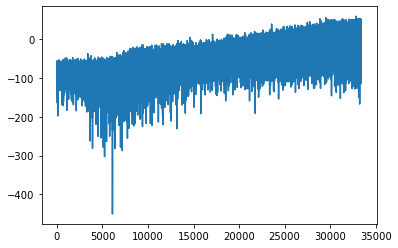

In [7]:
def play_episode(env, agent, max_episode_steps=None, mode=None, render=False):
    observation, reward, done = env.reset(), 0., False
    agent.reset(mode=mode)
    episode_reward, elapsed_steps = 0., 0
    while True:
        action = agent.step(observation, reward, done)
        if render:
            env.render()
        if done:
            break
        observation, reward, done, _ = env.step(action)
        episode_reward += reward
        elapsed_steps += 1
        if max_episode_steps and elapsed_steps >= max_episode_steps:
            break
    agent.close()
    return episode_reward, elapsed_steps



logging.info('==== expert ====')
episode_rewards = []
for episode in range(5):
    episode_reward, elapsed_steps = play_episode(env, agent, mode='expert')
    episode_rewards.append(episode_reward)
    logging.debug('expert episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
logging.info('average expert episode reward = %.2f ± %.2f',
        np.mean(episode_rewards), np.std(episode_rewards))


logging.info('==== train ====')
episode_rewards = []
for episode in itertools.count():
    episode_reward, elapsed_steps = play_episode(env.unwrapped, agent,
            max_episode_steps=env.spec.max_episode_steps, mode='train')
    episode_rewards.append(episode_reward)
    logging.debug('train episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
    if np.mean(episode_rewards[-10:]) > 30:
        break
plt.plot(episode_rewards)


logging.info('==== test ====')
episode_rewards = []
for episode in range(100):
    episode_reward, elapsed_steps = play_episode(env, agent)
    episode_rewards.append(episode_reward)
    logging.debug('test episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
logging.info('average episode reward = %.2f ± %.2f',
        np.mean(episode_rewards), np.std(episode_rewards))

In [8]:
env.close()